In [53]:
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
from functools import partial
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval
import data_transformers as dt
import model_wrapper as mw
from data_transformers import create_molecular_features, process_molecular_features
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, ConfusionMatrixDisplay, precision_score, recall_score, roc_auc_score, average_precision_score, accuracy_score
from auxiliary import plotScatterWithIdeal, get_logger, create_precision_recall_plot
from paths import DATA_DIR, PIPELINES_DIR, MODELS_DIR

from enum import Enum
class ColumnNames(Enum):
    SMILES_COLUMN = "canonical_smiles"
    TARGET_COLUMN = "standard_value_mean"

pd.set_option("display.max_rows", 500)
l = get_logger(logger_name="logger")
USE_CASE = "gyrase"

In [2]:
df = pd.read_parquet(DATA_DIR/USE_CASE/"final_aggregates_chembl_binding_pdb.parquet")
df.head()

,standard_value_min,standard_value_max,standard_value_get_all_levels,standard_value_get_mean,db_id,canonical_smiles,source,activity
0,28000.0,28000.0,[28000.0],2.800000e+04,CHEMBL4,CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,chembl,inactive
1,4750000.0,4750000.0,[4750000.0],4.750000e+06,CHEMBL5,CCn1cc(C(=O)O)c(=O)c2ccc(C)nc21,chembl,inactive
2,10600.0,37725.5,"[10600.0, 37725.5]",2.416275e+04,CHEMBL8,O=C(O)c1cn(C2CC2)c2cc(N3CCNCC3)c(F)cc2c1=O,chembl,inactive
3,6000.0,12500.0,"[6000.0, 8100.0, 10000.0, 11200.0, 12500.0]",1.043333e+04,CHEMBL32,COc1c(N2C[C@@H]3CCCN[C@@H]3C2)c(F)cc2c(=O)c(C(...,chembl,active
4,50000.0,50000.0,[50000.0],5.000000e+04,CHEMBL64,NNC(=O)c1ccncc1,chembl,inactive


* an additional aggregation related to duplicated entry - the explanations are in the notebook related to the data retrieval (data_retrieval_chembl3.0.ipynb), the other project (DNA_GYRAZE) 

In [3]:
def combine_lists(x):
    y = x.dropna()
    if y.empty:
        return np.nan
    else:
        a = [item for item in x]
        ret_val = []
        for item in a: ret_val.extend(item)
        return ret_val

In [4]:
df = df.groupby("db_id").agg({"standard_value_min": min, "standard_value_max": max, "standard_value_get_all_levels": combine_lists, "db_id": min,
"canonical_smiles": min, "source": min})

In [5]:
df["standard_value_mean"] = df["standard_value_get_all_levels"].apply(lambda x: np.array(x).mean())
df["standard_value_mean"] = df["standard_value_mean"].astype(float)
df.head()

,standard_value_min,standard_value_max,standard_value_get_all_levels,db_id,canonical_smiles,source,standard_value_mean
db_id,,,,,,,
50117914,5.0,9400.0,"[5.0, 7990.0, 9400.0]",50117914,COc1c(N2CCNC(C)C2)c(F)cc2c1n(cc(C(O)=O)c2=O)C1CC1,bindingpdb,5798.333333
50131428,9200.0,9200.0,[9200.0],50131428,COc1c(N2CC3CCCNC3C2)c(F)cc2C(=O)C(CN(C3CC3)c12...,bindingpdb,9200.000000
50131445,52000.0,52000.0,[52000.0],50131445,COC(=O)c1cn2[C@@H](C)COc3c(N4CCN(C)CC4)c(F)cc(...,bindingpdb,52000.000000
50330327,2900.0,2900.0,[2900.0],50330327,COc1c(N2CC[C@H](C2)C(C)(C)N)c(F)cc2c1n(C1CC1)c...,bindingpdb,2900.000000
50490565,48400.0,48400.0,[48400.0],50490565,CCOC(=O)C1CN(CCN1)c1c(F)cc2c(c1OC)n(cc(C(O)=O)...,bindingpdb,48400.000000


In [6]:
df[df["db_id"].duplicated(keep=False)]

,standard_value_min,standard_value_max,standard_value_get_all_levels,db_id,canonical_smiles,source,standard_value_mean
db_id,,,,,,,


# QED regression

## Training

In [7]:
TRAINING_CONFIGURATION_FILE = "QED_training_gyrase_regression.json"
with open(PIPELINES_DIR/TRAINING_CONFIGURATION_FILE, "r") as f:
    training_conf = json.load(f)
configuration_train = training_conf["training_aux_data"]

smiles_codes = df[ColumnNames.SMILES_COLUMN.value].copy()
target = df[ColumnNames.TARGET_COLUMN.value].copy()

non_idx = dt.validate_smiles(smiles_codes=smiles_codes)
smiles_codes = smiles_codes.drop(non_idx, axis=0)
target = target.drop(non_idx, axis=0)

pipeline_configuration = dt.read_in_pipeline(pipeline_file=configuration_train["pipeline_file"], 
                                                 pipeline_directory=PIPELINES_DIR)

y_train = dt.process_taget(pipeline_configuration=pipeline_configuration["target_transform"], y=target)
smiles_codes = smiles_codes.loc[y_train.index]

smiles_codes_train, smiles_codes_train_val, y_train, y_train_val = train_test_split(smiles_codes, y_train, test_size=0.1, random_state=42)

prediction_type = "regression"
model_wrapper = mw.model_wrapper.M_XGBoost(prediction_type=prediction_type, pipeline_configuration=pipeline_configuration)
model_wrapper.Data = {"smiles_codes_train": smiles_codes_train, "targets_train": y_train, "smiles_codes_val": smiles_codes_train_val, "targets_val": y_train_val}
model_wrapper.Create_Features()

2022-07-31 08:18:43,089 - logger - INFO - Scaler constructor...
2022-07-31 08:18:43,091 - logger - INFO - CreateFPS fit...
2022-07-31 08:18:43,092 - logger - INFO - CreateFPS transform...
100%|██████████| 318/318 [00:01<00:00, 305.95it/s]


In [8]:
fmin_objective = partial(model_wrapper.F_Opt, aux_data=configuration_train)
trials = Trials()
rstate = np.random.RandomState(42)
max_evals = configuration_train["max_evals"]
best_hyperparams = fmin(fn=fmin_objective, space=model_wrapper.Space, algo=tpe.suggest, max_evals=max_evals, 
                        trials=trials, return_argmin=True, rstate=rstate, show_progressbar=True)

  0%|          | 0/200 [00:00<?, ?it/s, best loss: ?]

2022-07-31 08:18:55,269 - logger - INFO - Scaler fit...
2022-07-31 08:18:55,273 - logger - INFO - Scaler transform...
2022-07-31 08:18:55,279 - logger - INFO - Scaler transform...
2022-07-31 08:18:55,749 - logger - INFO - Scaler fit...
2022-07-31 08:18:55,752 - logger - INFO - Scaler transform...
2022-07-31 08:18:55,757 - logger - INFO - Scaler transform...
2022-07-31 08:18:56,193 - logger - INFO - Scaler fit...
2022-07-31 08:18:56,197 - logger - INFO - Scaler transform...
2022-07-31 08:18:56,201 - logger - INFO - Scaler transform...
2022-07-31 08:18:56,428 - logger - INFO - Scaler fit...
2022-07-31 08:18:56,431 - logger - INFO - Scaler transform...
2022-07-31 08:18:56,435 - logger - INFO - Scaler transform...


  0%|          | 1/200 [00:01<04:40,  1.41s/it, best loss: 0.4679554793114231]

2022-07-31 08:18:56,677 - logger - INFO - Scaler fit...
2022-07-31 08:18:56,679 - logger - INFO - Scaler transform...
2022-07-31 08:18:56,683 - logger - INFO - Scaler transform...
2022-07-31 08:18:57,042 - logger - INFO - Scaler fit...
2022-07-31 08:18:57,045 - logger - INFO - Scaler transform...
2022-07-31 08:18:57,049 - logger - INFO - Scaler transform...
2022-07-31 08:18:57,208 - logger - INFO - Scaler fit...
2022-07-31 08:18:57,211 - logger - INFO - Scaler transform...
2022-07-31 08:18:57,216 - logger - INFO - Scaler transform...
2022-07-31 08:18:57,395 - logger - INFO - Scaler fit...
2022-07-31 08:18:57,398 - logger - INFO - Scaler transform...
2022-07-31 08:18:57,402 - logger - INFO - Scaler transform...


  1%|          | 2/200 [00:02<03:43,  1.13s/it, best loss: 0.4679554793114231]

2022-07-31 08:18:57,605 - logger - INFO - Scaler fit...
2022-07-31 08:18:57,608 - logger - INFO - Scaler transform...
2022-07-31 08:18:57,611 - logger - INFO - Scaler transform...
2022-07-31 08:18:58,110 - logger - INFO - Scaler fit...
2022-07-31 08:18:58,114 - logger - INFO - Scaler transform...
2022-07-31 08:18:58,118 - logger - INFO - Scaler transform...
2022-07-31 08:18:58,344 - logger - INFO - Scaler fit...
2022-07-31 08:18:58,347 - logger - INFO - Scaler transform...
2022-07-31 08:18:58,352 - logger - INFO - Scaler transform...
2022-07-31 08:18:58,560 - logger - INFO - Scaler fit...
2022-07-31 08:18:58,563 - logger - INFO - Scaler transform...
2022-07-31 08:18:58,567 - logger - INFO - Scaler transform...


  2%|▏         | 3/200 [00:03<03:49,  1.16s/it, best loss: 0.4595762315769787]

2022-07-31 08:18:58,817 - logger - INFO - Scaler fit...
2022-07-31 08:18:58,819 - logger - INFO - Scaler transform...
2022-07-31 08:18:58,824 - logger - INFO - Scaler transform...
2022-07-31 08:18:59,402 - logger - INFO - Scaler fit...
2022-07-31 08:18:59,406 - logger - INFO - Scaler transform...
2022-07-31 08:18:59,411 - logger - INFO - Scaler transform...
2022-07-31 08:18:59,760 - logger - INFO - Scaler fit...
2022-07-31 08:18:59,763 - logger - INFO - Scaler transform...
2022-07-31 08:18:59,768 - logger - INFO - Scaler transform...
2022-07-31 08:19:00,128 - logger - INFO - Scaler fit...
2022-07-31 08:19:00,131 - logger - INFO - Scaler transform...
2022-07-31 08:19:00,136 - logger - INFO - Scaler transform...


  2%|▏         | 4/200 [00:05<04:28,  1.37s/it, best loss: 0.4595762315769787]

2022-07-31 08:19:00,501 - logger - INFO - Scaler fit...
2022-07-31 08:19:00,504 - logger - INFO - Scaler transform...
2022-07-31 08:19:00,508 - logger - INFO - Scaler transform...
2022-07-31 08:19:00,985 - logger - INFO - Scaler fit...
2022-07-31 08:19:00,989 - logger - INFO - Scaler transform...
2022-07-31 08:19:00,994 - logger - INFO - Scaler transform...
2022-07-31 08:19:01,333 - logger - INFO - Scaler fit...
2022-07-31 08:19:01,337 - logger - INFO - Scaler transform...
2022-07-31 08:19:01,342 - logger - INFO - Scaler transform...
2022-07-31 08:19:01,608 - logger - INFO - Scaler fit...
2022-07-31 08:19:01,611 - logger - INFO - Scaler transform...
2022-07-31 08:19:01,616 - logger - INFO - Scaler transform...


  2%|▎         | 5/200 [00:06<04:27,  1.37s/it, best loss: 0.4595762315769787]

2022-07-31 08:19:01,875 - logger - INFO - Scaler fit...
2022-07-31 08:19:01,878 - logger - INFO - Scaler transform...
2022-07-31 08:19:01,883 - logger - INFO - Scaler transform...
2022-07-31 08:19:02,376 - logger - INFO - Scaler fit...
2022-07-31 08:19:02,380 - logger - INFO - Scaler transform...
2022-07-31 08:19:02,385 - logger - INFO - Scaler transform...
2022-07-31 08:19:02,668 - logger - INFO - Scaler fit...
2022-07-31 08:19:02,672 - logger - INFO - Scaler transform...
2022-07-31 08:19:02,677 - logger - INFO - Scaler transform...
2022-07-31 08:19:02,983 - logger - INFO - Scaler fit...
2022-07-31 08:19:02,986 - logger - INFO - Scaler transform...
2022-07-31 08:19:02,991 - logger - INFO - Scaler transform...


  3%|▎         | 6/200 [00:08<04:38,  1.44s/it, best loss: 0.4595762315769787]

2022-07-31 08:19:03,662 - logger - INFO - Scaler fit...
2022-07-31 08:19:03,665 - logger - INFO - Scaler transform...
2022-07-31 08:19:03,670 - logger - INFO - Scaler transform...
2022-07-31 08:19:03,890 - logger - INFO - Scaler fit...
2022-07-31 08:19:03,893 - logger - INFO - Scaler transform...
2022-07-31 08:19:03,898 - logger - INFO - Scaler transform...
2022-07-31 08:19:04,150 - logger - INFO - Scaler fit...
2022-07-31 08:19:04,153 - logger - INFO - Scaler transform...
2022-07-31 08:19:04,158 - logger - INFO - Scaler transform...
2022-07-31 08:19:04,384 - logger - INFO - Scaler fit...
2022-07-31 08:19:04,387 - logger - INFO - Scaler transform...
2022-07-31 08:19:04,392 - logger - INFO - Scaler transform...


  4%|▎         | 7/200 [00:09<04:20,  1.35s/it, best loss: 0.4595762315769787]

2022-07-31 08:19:04,610 - logger - INFO - Scaler fit...
2022-07-31 08:19:04,613 - logger - INFO - Scaler transform...
2022-07-31 08:19:04,617 - logger - INFO - Scaler transform...
2022-07-31 08:19:05,164 - logger - INFO - Scaler fit...
2022-07-31 08:19:05,168 - logger - INFO - Scaler transform...
2022-07-31 08:19:05,172 - logger - INFO - Scaler transform...
2022-07-31 08:19:05,515 - logger - INFO - Scaler fit...
2022-07-31 08:19:05,519 - logger - INFO - Scaler transform...
2022-07-31 08:19:05,523 - logger - INFO - Scaler transform...
2022-07-31 08:19:05,999 - logger - INFO - Scaler fit...
2022-07-31 08:19:06,003 - logger - INFO - Scaler transform...
2022-07-31 08:19:06,008 - logger - INFO - Scaler transform...


  4%|▍         | 8/200 [00:11<04:42,  1.47s/it, best loss: 0.4595762315769787]

2022-07-31 08:19:06,349 - logger - INFO - Scaler fit...
2022-07-31 08:19:06,352 - logger - INFO - Scaler transform...
2022-07-31 08:19:06,356 - logger - INFO - Scaler transform...
2022-07-31 08:19:06,764 - logger - INFO - Scaler fit...
2022-07-31 08:19:06,767 - logger - INFO - Scaler transform...
2022-07-31 08:19:06,772 - logger - INFO - Scaler transform...
2022-07-31 08:19:06,960 - logger - INFO - Scaler fit...
2022-07-31 08:19:06,963 - logger - INFO - Scaler transform...
2022-07-31 08:19:06,967 - logger - INFO - Scaler transform...
2022-07-31 08:19:07,157 - logger - INFO - Scaler fit...
2022-07-31 08:19:07,161 - logger - INFO - Scaler transform...
2022-07-31 08:19:07,166 - logger - INFO - Scaler transform...


  4%|▍         | 9/200 [00:12<04:15,  1.34s/it, best loss: 0.4595762315769787]

2022-07-31 08:19:07,389 - logger - INFO - Scaler fit...
2022-07-31 08:19:07,392 - logger - INFO - Scaler transform...
2022-07-31 08:19:07,396 - logger - INFO - Scaler transform...
2022-07-31 08:19:07,868 - logger - INFO - Scaler fit...
2022-07-31 08:19:07,872 - logger - INFO - Scaler transform...
2022-07-31 08:19:07,876 - logger - INFO - Scaler transform...
2022-07-31 08:19:08,305 - logger - INFO - Scaler fit...
2022-07-31 08:19:08,308 - logger - INFO - Scaler transform...
2022-07-31 08:19:08,313 - logger - INFO - Scaler transform...
2022-07-31 08:19:08,467 - logger - INFO - Scaler fit...
2022-07-31 08:19:08,471 - logger - INFO - Scaler transform...
2022-07-31 08:19:08,475 - logger - INFO - Scaler transform...


  5%|▌         | 10/200 [00:13<04:08,  1.31s/it, best loss: 0.4595762315769787]

2022-07-31 08:19:08,634 - logger - INFO - Scaler fit...
2022-07-31 08:19:08,637 - logger - INFO - Scaler transform...
2022-07-31 08:19:08,641 - logger - INFO - Scaler transform...
2022-07-31 08:19:08,698 - logger - INFO - Scaler fit...
2022-07-31 08:19:08,701 - logger - INFO - Scaler transform...
2022-07-31 08:19:08,706 - logger - INFO - Scaler transform...
2022-07-31 08:19:09,042 - logger - INFO - Scaler fit...
2022-07-31 08:19:09,046 - logger - INFO - Scaler transform...
2022-07-31 08:19:09,051 - logger - INFO - Scaler transform...
2022-07-31 08:19:09,122 - logger - INFO - Scaler fit...
2022-07-31 08:19:09,126 - logger - INFO - Scaler transform...
2022-07-31 08:19:09,130 - logger - INFO - Scaler transform...


  6%|▌         | 11/200 [00:13<03:23,  1.08s/it, best loss: 0.4595762315769787]

2022-07-31 08:19:09,187 - logger - INFO - Scaler fit...
2022-07-31 08:19:09,189 - logger - INFO - Scaler transform...
2022-07-31 08:19:09,193 - logger - INFO - Scaler transform...
2022-07-31 08:19:09,874 - logger - INFO - Scaler fit...
2022-07-31 08:19:09,878 - logger - INFO - Scaler transform...
2022-07-31 08:19:09,882 - logger - INFO - Scaler transform...
2022-07-31 08:19:10,275 - logger - INFO - Scaler fit...
2022-07-31 08:19:10,278 - logger - INFO - Scaler transform...
2022-07-31 08:19:10,282 - logger - INFO - Scaler transform...
2022-07-31 08:19:10,641 - logger - INFO - Scaler fit...
2022-07-31 08:19:10,644 - logger - INFO - Scaler transform...
2022-07-31 08:19:10,649 - logger - INFO - Scaler transform...


  6%|▌         | 12/200 [00:15<04:06,  1.31s/it, best loss: 0.4595762315769787]

2022-07-31 08:19:11,036 - logger - INFO - Scaler fit...
2022-07-31 08:19:11,038 - logger - INFO - Scaler transform...
2022-07-31 08:19:11,041 - logger - INFO - Scaler transform...
2022-07-31 08:19:11,500 - logger - INFO - Scaler fit...
2022-07-31 08:19:11,503 - logger - INFO - Scaler transform...
2022-07-31 08:19:11,508 - logger - INFO - Scaler transform...
2022-07-31 08:19:11,767 - logger - INFO - Scaler fit...
2022-07-31 08:19:11,770 - logger - INFO - Scaler transform...
2022-07-31 08:19:11,775 - logger - INFO - Scaler transform...
2022-07-31 08:19:12,020 - logger - INFO - Scaler fit...
2022-07-31 08:19:12,023 - logger - INFO - Scaler transform...
2022-07-31 08:19:12,027 - logger - INFO - Scaler transform...


  6%|▋         | 13/200 [00:17<04:23,  1.41s/it, best loss: 0.4557440798962134]

2022-07-31 08:19:12,676 - logger - INFO - Scaler fit...
2022-07-31 08:19:12,679 - logger - INFO - Scaler transform...
2022-07-31 08:19:12,684 - logger - INFO - Scaler transform...
2022-07-31 08:19:12,882 - logger - INFO - Scaler fit...
2022-07-31 08:19:12,886 - logger - INFO - Scaler transform...
2022-07-31 08:19:12,891 - logger - INFO - Scaler transform...
2022-07-31 08:19:13,092 - logger - INFO - Scaler fit...
2022-07-31 08:19:13,097 - logger - INFO - Scaler transform...
2022-07-31 08:19:13,102 - logger - INFO - Scaler transform...
2022-07-31 08:19:13,586 - logger - INFO - Scaler fit...
2022-07-31 08:19:13,590 - logger - INFO - Scaler transform...
2022-07-31 08:19:13,594 - logger - INFO - Scaler transform...


  7%|▋         | 14/200 [00:18<04:07,  1.33s/it, best loss: 0.4557440798962134]

2022-07-31 08:19:13,822 - logger - INFO - Scaler fit...
2022-07-31 08:19:13,825 - logger - INFO - Scaler transform...
2022-07-31 08:19:13,829 - logger - INFO - Scaler transform...
2022-07-31 08:19:14,343 - logger - INFO - Scaler fit...
2022-07-31 08:19:14,347 - logger - INFO - Scaler transform...
2022-07-31 08:19:14,352 - logger - INFO - Scaler transform...
2022-07-31 08:19:14,545 - logger - INFO - Scaler fit...
2022-07-31 08:19:14,549 - logger - INFO - Scaler transform...
2022-07-31 08:19:14,554 - logger - INFO - Scaler transform...
2022-07-31 08:19:14,774 - logger - INFO - Scaler fit...
2022-07-31 08:19:14,778 - logger - INFO - Scaler transform...
2022-07-31 08:19:14,782 - logger - INFO - Scaler transform...


  8%|▊         | 15/200 [00:19<04:10,  1.35s/it, best loss: 0.4557440798962134]

2022-07-31 08:19:15,221 - logger - INFO - Scaler fit...
2022-07-31 08:19:15,224 - logger - INFO - Scaler transform...
2022-07-31 08:19:15,228 - logger - INFO - Scaler transform...
2022-07-31 08:19:15,383 - logger - INFO - Scaler fit...
2022-07-31 08:19:15,386 - logger - INFO - Scaler transform...
2022-07-31 08:19:15,390 - logger - INFO - Scaler transform...
2022-07-31 08:19:15,563 - logger - INFO - Scaler fit...
2022-07-31 08:19:15,567 - logger - INFO - Scaler transform...
2022-07-31 08:19:15,571 - logger - INFO - Scaler transform...
2022-07-31 08:19:15,932 - logger - INFO - Scaler fit...
2022-07-31 08:19:15,935 - logger - INFO - Scaler transform...
2022-07-31 08:19:15,940 - logger - INFO - Scaler transform...


  8%|▊         | 16/200 [00:20<03:41,  1.21s/it, best loss: 0.45202610878839855]

2022-07-31 08:19:16,090 - logger - INFO - Scaler fit...
2022-07-31 08:19:16,093 - logger - INFO - Scaler transform...
2022-07-31 08:19:16,097 - logger - INFO - Scaler transform...
2022-07-31 08:19:16,966 - logger - INFO - Scaler fit...
2022-07-31 08:19:16,971 - logger - INFO - Scaler transform...
2022-07-31 08:19:16,975 - logger - INFO - Scaler transform...
2022-07-31 08:19:17,508 - logger - INFO - Scaler fit...
2022-07-31 08:19:17,512 - logger - INFO - Scaler transform...
2022-07-31 08:19:17,517 - logger - INFO - Scaler transform...
2022-07-31 08:19:18,490 - logger - INFO - Scaler fit...
2022-07-31 08:19:18,494 - logger - INFO - Scaler transform...
2022-07-31 08:19:18,499 - logger - INFO - Scaler transform...


  8%|▊         | 17/200 [00:23<05:19,  1.75s/it, best loss: 0.45202610878839855]

2022-07-31 08:19:19,096 - logger - INFO - Scaler fit...
2022-07-31 08:19:19,099 - logger - INFO - Scaler transform...
2022-07-31 08:19:19,103 - logger - INFO - Scaler transform...
2022-07-31 08:19:19,420 - logger - INFO - Scaler fit...
2022-07-31 08:19:19,423 - logger - INFO - Scaler transform...
2022-07-31 08:19:19,428 - logger - INFO - Scaler transform...
2022-07-31 08:19:19,913 - logger - INFO - Scaler fit...
2022-07-31 08:19:19,917 - logger - INFO - Scaler transform...
2022-07-31 08:19:19,921 - logger - INFO - Scaler transform...
2022-07-31 08:19:20,208 - logger - INFO - Scaler fit...
2022-07-31 08:19:20,211 - logger - INFO - Scaler transform...
2022-07-31 08:19:20,216 - logger - INFO - Scaler transform...


  9%|▉         | 18/200 [00:25<05:01,  1.66s/it, best loss: 0.45202610878839855]

2022-07-31 08:19:20,546 - logger - INFO - Scaler fit...
2022-07-31 08:19:20,549 - logger - INFO - Scaler transform...
2022-07-31 08:19:20,552 - logger - INFO - Scaler transform...
2022-07-31 08:19:20,883 - logger - INFO - Scaler fit...
2022-07-31 08:19:20,887 - logger - INFO - Scaler transform...
2022-07-31 08:19:20,891 - logger - INFO - Scaler transform...
2022-07-31 08:19:21,058 - logger - INFO - Scaler fit...
2022-07-31 08:19:21,061 - logger - INFO - Scaler transform...
2022-07-31 08:19:21,066 - logger - INFO - Scaler transform...
2022-07-31 08:19:21,226 - logger - INFO - Scaler fit...
2022-07-31 08:19:21,229 - logger - INFO - Scaler transform...
2022-07-31 08:19:21,233 - logger - INFO - Scaler transform...


 10%|▉         | 19/200 [00:26<04:16,  1.42s/it, best loss: 0.45202610878839855]

2022-07-31 08:19:21,410 - logger - INFO - Scaler fit...
2022-07-31 08:19:21,412 - logger - INFO - Scaler transform...
2022-07-31 08:19:21,416 - logger - INFO - Scaler transform...
2022-07-31 08:19:21,793 - logger - INFO - Scaler fit...
2022-07-31 08:19:21,797 - logger - INFO - Scaler transform...
2022-07-31 08:19:21,802 - logger - INFO - Scaler transform...
2022-07-31 08:19:21,900 - logger - INFO - Scaler fit...
2022-07-31 08:19:21,903 - logger - INFO - Scaler transform...
2022-07-31 08:19:21,908 - logger - INFO - Scaler transform...
2022-07-31 08:19:22,034 - logger - INFO - Scaler fit...
2022-07-31 08:19:22,037 - logger - INFO - Scaler transform...
2022-07-31 08:19:22,042 - logger - INFO - Scaler transform...


 10%|█         | 20/200 [00:26<03:38,  1.21s/it, best loss: 0.45202610878839855]

2022-07-31 08:19:22,149 - logger - INFO - Scaler fit...
2022-07-31 08:19:22,151 - logger - INFO - Scaler transform...
2022-07-31 08:19:22,155 - logger - INFO - Scaler transform...
2022-07-31 08:19:22,385 - logger - INFO - Scaler fit...
2022-07-31 08:19:22,388 - logger - INFO - Scaler transform...
2022-07-31 08:19:22,393 - logger - INFO - Scaler transform...
2022-07-31 08:19:22,861 - logger - INFO - Scaler fit...
2022-07-31 08:19:22,865 - logger - INFO - Scaler transform...
2022-07-31 08:19:22,869 - logger - INFO - Scaler transform...
2022-07-31 08:19:23,091 - logger - INFO - Scaler fit...
2022-07-31 08:19:23,095 - logger - INFO - Scaler transform...
2022-07-31 08:19:23,099 - logger - INFO - Scaler transform...


 10%|█         | 21/200 [00:28<03:35,  1.20s/it, best loss: 0.45202610878839855]

2022-07-31 08:19:23,330 - logger - INFO - Scaler fit...
2022-07-31 08:19:23,332 - logger - INFO - Scaler transform...
2022-07-31 08:19:23,336 - logger - INFO - Scaler transform...
2022-07-31 08:19:23,592 - logger - INFO - Scaler fit...
2022-07-31 08:19:23,595 - logger - INFO - Scaler transform...
2022-07-31 08:19:23,600 - logger - INFO - Scaler transform...
2022-07-31 08:19:23,715 - logger - INFO - Scaler fit...
2022-07-31 08:19:23,718 - logger - INFO - Scaler transform...
2022-07-31 08:19:23,722 - logger - INFO - Scaler transform...
2022-07-31 08:19:23,804 - logger - INFO - Scaler fit...
2022-07-31 08:19:23,807 - logger - INFO - Scaler transform...
2022-07-31 08:19:23,812 - logger - INFO - Scaler transform...


 11%|█         | 22/200 [00:28<03:05,  1.04s/it, best loss: 0.45202610878839855]

2022-07-31 08:19:23,990 - logger - INFO - Scaler fit...
2022-07-31 08:19:23,993 - logger - INFO - Scaler transform...
2022-07-31 08:19:23,997 - logger - INFO - Scaler transform...
2022-07-31 08:19:24,343 - logger - INFO - Scaler fit...
2022-07-31 08:19:24,347 - logger - INFO - Scaler transform...
2022-07-31 08:19:24,352 - logger - INFO - Scaler transform...
2022-07-31 08:19:24,423 - logger - INFO - Scaler fit...
2022-07-31 08:19:24,426 - logger - INFO - Scaler transform...
2022-07-31 08:19:24,431 - logger - INFO - Scaler transform...
2022-07-31 08:19:24,504 - logger - INFO - Scaler fit...
2022-07-31 08:19:24,507 - logger - INFO - Scaler transform...
2022-07-31 08:19:24,511 - logger - INFO - Scaler transform...


 12%|█▏        | 23/200 [00:29<02:53,  1.02it/s, best loss: 0.45202610878839855]

2022-07-31 08:19:24,843 - logger - INFO - Scaler fit...
2022-07-31 08:19:24,847 - logger - INFO - Scaler transform...
2022-07-31 08:19:24,851 - logger - INFO - Scaler transform...
2022-07-31 08:19:25,545 - logger - INFO - Scaler fit...
2022-07-31 08:19:25,549 - logger - INFO - Scaler transform...
2022-07-31 08:19:25,554 - logger - INFO - Scaler transform...
2022-07-31 08:19:25,996 - logger - INFO - Scaler fit...
2022-07-31 08:19:25,999 - logger - INFO - Scaler transform...
2022-07-31 08:19:26,004 - logger - INFO - Scaler transform...
2022-07-31 08:19:26,594 - logger - INFO - Scaler fit...
2022-07-31 08:19:26,597 - logger - INFO - Scaler transform...
2022-07-31 08:19:26,602 - logger - INFO - Scaler transform...


 12%|█▏        | 24/200 [00:31<03:58,  1.35s/it, best loss: 0.45202610878839855]

2022-07-31 08:19:27,065 - logger - INFO - Scaler fit...
2022-07-31 08:19:27,068 - logger - INFO - Scaler transform...
2022-07-31 08:19:27,072 - logger - INFO - Scaler transform...
2022-07-31 08:19:27,304 - logger - INFO - Scaler fit...
2022-07-31 08:19:27,307 - logger - INFO - Scaler transform...
2022-07-31 08:19:27,312 - logger - INFO - Scaler transform...
2022-07-31 08:19:27,511 - logger - INFO - Scaler fit...
2022-07-31 08:19:27,515 - logger - INFO - Scaler transform...
2022-07-31 08:19:27,519 - logger - INFO - Scaler transform...
2022-07-31 08:19:27,720 - logger - INFO - Scaler fit...
2022-07-31 08:19:27,724 - logger - INFO - Scaler transform...
2022-07-31 08:19:27,728 - logger - INFO - Scaler transform...


 12%|█▎        | 25/200 [00:32<03:38,  1.25s/it, best loss: 0.45202610878839855]

2022-07-31 08:19:28,058 - logger - INFO - Scaler fit...
2022-07-31 08:19:28,061 - logger - INFO - Scaler transform...
2022-07-31 08:19:28,065 - logger - INFO - Scaler transform...
2022-07-31 08:19:28,583 - logger - INFO - Scaler fit...
2022-07-31 08:19:28,587 - logger - INFO - Scaler transform...
2022-07-31 08:19:28,592 - logger - INFO - Scaler transform...
2022-07-31 08:19:28,795 - logger - INFO - Scaler fit...
2022-07-31 08:19:28,799 - logger - INFO - Scaler transform...
2022-07-31 08:19:28,803 - logger - INFO - Scaler transform...
2022-07-31 08:19:28,984 - logger - INFO - Scaler fit...
2022-07-31 08:19:28,987 - logger - INFO - Scaler transform...
2022-07-31 08:19:28,993 - logger - INFO - Scaler transform...


 13%|█▎        | 26/200 [00:34<03:39,  1.26s/it, best loss: 0.45202610878839855]

2022-07-31 08:19:29,354 - logger - INFO - Scaler fit...
2022-07-31 08:19:29,358 - logger - INFO - Scaler transform...
2022-07-31 08:19:29,362 - logger - INFO - Scaler transform...
2022-07-31 08:19:29,971 - logger - INFO - Scaler fit...
2022-07-31 08:19:29,975 - logger - INFO - Scaler transform...
2022-07-31 08:19:29,980 - logger - INFO - Scaler transform...
2022-07-31 08:19:30,359 - logger - INFO - Scaler fit...
2022-07-31 08:19:30,363 - logger - INFO - Scaler transform...
2022-07-31 08:19:30,368 - logger - INFO - Scaler transform...
2022-07-31 08:19:30,746 - logger - INFO - Scaler fit...
2022-07-31 08:19:30,750 - logger - INFO - Scaler transform...
2022-07-31 08:19:30,754 - logger - INFO - Scaler transform...


 14%|█▎        | 27/200 [00:36<04:17,  1.49s/it, best loss: 0.4354588054710442] 

2022-07-31 08:19:31,373 - logger - INFO - Scaler fit...
2022-07-31 08:19:31,375 - logger - INFO - Scaler transform...
2022-07-31 08:19:31,379 - logger - INFO - Scaler transform...
2022-07-31 08:19:32,139 - logger - INFO - Scaler fit...
2022-07-31 08:19:32,143 - logger - INFO - Scaler transform...
2022-07-31 08:19:32,148 - logger - INFO - Scaler transform...
2022-07-31 08:19:32,727 - logger - INFO - Scaler fit...
2022-07-31 08:19:32,731 - logger - INFO - Scaler transform...
2022-07-31 08:19:32,735 - logger - INFO - Scaler transform...
2022-07-31 08:19:33,309 - logger - INFO - Scaler fit...
2022-07-31 08:19:33,313 - logger - INFO - Scaler transform...
2022-07-31 08:19:33,317 - logger - INFO - Scaler transform...


 14%|█▍        | 28/200 [00:38<05:10,  1.80s/it, best loss: 0.4354588054710442]

2022-07-31 08:19:33,913 - logger - INFO - Scaler fit...
2022-07-31 08:19:33,916 - logger - INFO - Scaler transform...
2022-07-31 08:19:33,920 - logger - INFO - Scaler transform...
2022-07-31 08:19:34,614 - logger - INFO - Scaler fit...
2022-07-31 08:19:34,618 - logger - INFO - Scaler transform...
2022-07-31 08:19:34,624 - logger - INFO - Scaler transform...
2022-07-31 08:19:35,072 - logger - INFO - Scaler fit...
2022-07-31 08:19:35,076 - logger - INFO - Scaler transform...
2022-07-31 08:19:35,080 - logger - INFO - Scaler transform...
2022-07-31 08:19:35,898 - logger - INFO - Scaler fit...
2022-07-31 08:19:35,902 - logger - INFO - Scaler transform...
2022-07-31 08:19:35,907 - logger - INFO - Scaler transform...


 14%|█▍        | 29/200 [00:41<05:42,  2.00s/it, best loss: 0.4354588054710442]

2022-07-31 08:19:36,378 - logger - INFO - Scaler fit...
2022-07-31 08:19:36,381 - logger - INFO - Scaler transform...
2022-07-31 08:19:36,385 - logger - INFO - Scaler transform...
2022-07-31 08:19:36,673 - logger - INFO - Scaler fit...
2022-07-31 08:19:36,677 - logger - INFO - Scaler transform...
2022-07-31 08:19:36,681 - logger - INFO - Scaler transform...
2022-07-31 08:19:37,091 - logger - INFO - Scaler fit...
2022-07-31 08:19:37,094 - logger - INFO - Scaler transform...
2022-07-31 08:19:37,099 - logger - INFO - Scaler transform...
2022-07-31 08:19:37,349 - logger - INFO - Scaler fit...
2022-07-31 08:19:37,352 - logger - INFO - Scaler transform...
2022-07-31 08:19:37,356 - logger - INFO - Scaler transform...


 15%|█▌        | 30/200 [00:42<05:12,  1.84s/it, best loss: 0.4354588054710442]

2022-07-31 08:19:37,837 - logger - INFO - Scaler fit...
2022-07-31 08:19:37,840 - logger - INFO - Scaler transform...
2022-07-31 08:19:37,846 - logger - INFO - Scaler transform...
2022-07-31 08:19:38,637 - logger - INFO - Scaler fit...
2022-07-31 08:19:38,641 - logger - INFO - Scaler transform...
2022-07-31 08:19:38,646 - logger - INFO - Scaler transform...
2022-07-31 08:19:39,097 - logger - INFO - Scaler fit...
2022-07-31 08:19:39,100 - logger - INFO - Scaler transform...
2022-07-31 08:19:39,105 - logger - INFO - Scaler transform...
2022-07-31 08:19:39,508 - logger - INFO - Scaler fit...
2022-07-31 08:19:39,512 - logger - INFO - Scaler transform...
2022-07-31 08:19:39,516 - logger - INFO - Scaler transform...


 16%|█▌        | 31/200 [00:44<05:36,  1.99s/it, best loss: 0.4354588054710442]

2022-07-31 08:19:40,189 - logger - INFO - Scaler fit...
2022-07-31 08:19:40,193 - logger - INFO - Scaler transform...
2022-07-31 08:19:40,197 - logger - INFO - Scaler transform...
2022-07-31 08:19:40,895 - logger - INFO - Scaler fit...
2022-07-31 08:19:40,898 - logger - INFO - Scaler transform...
2022-07-31 08:19:40,903 - logger - INFO - Scaler transform...
2022-07-31 08:19:41,293 - logger - INFO - Scaler fit...
2022-07-31 08:19:41,296 - logger - INFO - Scaler transform...
2022-07-31 08:19:41,301 - logger - INFO - Scaler transform...
2022-07-31 08:19:41,905 - logger - INFO - Scaler fit...
2022-07-31 08:19:41,909 - logger - INFO - Scaler transform...
2022-07-31 08:19:41,914 - logger - INFO - Scaler transform...


 16%|█▌        | 32/200 [00:47<05:50,  2.09s/it, best loss: 0.4354588054710442]

2022-07-31 08:19:42,494 - logger - INFO - Scaler fit...
2022-07-31 08:19:42,497 - logger - INFO - Scaler transform...
2022-07-31 08:19:42,502 - logger - INFO - Scaler transform...
2022-07-31 08:19:42,889 - logger - INFO - Scaler fit...
2022-07-31 08:19:42,892 - logger - INFO - Scaler transform...
2022-07-31 08:19:42,896 - logger - INFO - Scaler transform...
2022-07-31 08:19:43,691 - logger - INFO - Scaler fit...
2022-07-31 08:19:43,694 - logger - INFO - Scaler transform...
2022-07-31 08:19:43,699 - logger - INFO - Scaler transform...
2022-07-31 08:19:44,039 - logger - INFO - Scaler fit...
2022-07-31 08:19:44,042 - logger - INFO - Scaler transform...
2022-07-31 08:19:44,047 - logger - INFO - Scaler transform...


 16%|█▋        | 33/200 [00:49<05:40,  2.04s/it, best loss: 0.4354588054710442]

2022-07-31 08:19:44,412 - logger - INFO - Scaler fit...
2022-07-31 08:19:44,415 - logger - INFO - Scaler transform...
2022-07-31 08:19:44,418 - logger - INFO - Scaler transform...
2022-07-31 08:19:45,080 - logger - INFO - Scaler fit...
2022-07-31 08:19:45,084 - logger - INFO - Scaler transform...
2022-07-31 08:19:45,088 - logger - INFO - Scaler transform...
2022-07-31 08:19:45,834 - logger - INFO - Scaler fit...
2022-07-31 08:19:45,838 - logger - INFO - Scaler transform...
2022-07-31 08:19:45,843 - logger - INFO - Scaler transform...
2022-07-31 08:19:46,322 - logger - INFO - Scaler fit...
2022-07-31 08:19:46,325 - logger - INFO - Scaler transform...
2022-07-31 08:19:46,329 - logger - INFO - Scaler transform...


 17%|█▋        | 34/200 [00:51<05:59,  2.17s/it, best loss: 0.4354588054710442]

2022-07-31 08:19:46,890 - logger - INFO - Scaler fit...
2022-07-31 08:19:46,892 - logger - INFO - Scaler transform...
2022-07-31 08:19:46,896 - logger - INFO - Scaler transform...
2022-07-31 08:19:47,429 - logger - INFO - Scaler fit...
2022-07-31 08:19:47,432 - logger - INFO - Scaler transform...
2022-07-31 08:19:47,437 - logger - INFO - Scaler transform...
2022-07-31 08:19:47,820 - logger - INFO - Scaler fit...
2022-07-31 08:19:47,823 - logger - INFO - Scaler transform...
2022-07-31 08:19:47,828 - logger - INFO - Scaler transform...
2022-07-31 08:19:48,290 - logger - INFO - Scaler fit...
2022-07-31 08:19:48,293 - logger - INFO - Scaler transform...
2022-07-31 08:19:48,298 - logger - INFO - Scaler transform...


 18%|█▊        | 35/200 [00:53<05:33,  2.02s/it, best loss: 0.4354588054710442]

2022-07-31 08:19:48,576 - logger - INFO - Scaler fit...
2022-07-31 08:19:48,578 - logger - INFO - Scaler transform...
2022-07-31 08:19:48,583 - logger - INFO - Scaler transform...
2022-07-31 08:19:48,763 - logger - INFO - Scaler fit...
2022-07-31 08:19:48,766 - logger - INFO - Scaler transform...
2022-07-31 08:19:48,770 - logger - INFO - Scaler transform...
2022-07-31 08:19:48,892 - logger - INFO - Scaler fit...
2022-07-31 08:19:48,895 - logger - INFO - Scaler transform...
2022-07-31 08:19:48,900 - logger - INFO - Scaler transform...
2022-07-31 08:19:49,355 - logger - INFO - Scaler fit...
2022-07-31 08:19:49,358 - logger - INFO - Scaler transform...
2022-07-31 08:19:49,363 - logger - INFO - Scaler transform...


 18%|█▊        | 36/200 [00:54<04:39,  1.70s/it, best loss: 0.4354588054710442]

2022-07-31 08:19:49,535 - logger - INFO - Scaler fit...
2022-07-31 08:19:49,538 - logger - INFO - Scaler transform...
2022-07-31 08:19:49,542 - logger - INFO - Scaler transform...
2022-07-31 08:19:50,138 - logger - INFO - Scaler fit...
2022-07-31 08:19:50,141 - logger - INFO - Scaler transform...
2022-07-31 08:19:50,146 - logger - INFO - Scaler transform...
2022-07-31 08:19:50,598 - logger - INFO - Scaler fit...
2022-07-31 08:19:50,602 - logger - INFO - Scaler transform...
2022-07-31 08:19:50,606 - logger - INFO - Scaler transform...
2022-07-31 08:19:51,325 - logger - INFO - Scaler fit...
2022-07-31 08:19:51,331 - logger - INFO - Scaler transform...
2022-07-31 08:19:51,335 - logger - INFO - Scaler transform...


 18%|█▊        | 37/200 [00:56<05:10,  1.90s/it, best loss: 0.4354588054710442]

2022-07-31 08:19:51,905 - logger - INFO - Scaler fit...
2022-07-31 08:19:51,907 - logger - INFO - Scaler transform...
2022-07-31 08:19:51,911 - logger - INFO - Scaler transform...
2022-07-31 08:19:52,372 - logger - INFO - Scaler fit...
2022-07-31 08:19:52,375 - logger - INFO - Scaler transform...
2022-07-31 08:19:52,380 - logger - INFO - Scaler transform...
2022-07-31 08:19:52,932 - logger - INFO - Scaler fit...
2022-07-31 08:19:52,936 - logger - INFO - Scaler transform...
2022-07-31 08:19:52,941 - logger - INFO - Scaler transform...
2022-07-31 08:19:53,220 - logger - INFO - Scaler fit...
2022-07-31 08:19:53,223 - logger - INFO - Scaler transform...
2022-07-31 08:19:53,228 - logger - INFO - Scaler transform...


 19%|█▉        | 38/200 [00:58<04:55,  1.83s/it, best loss: 0.4354588054710442]

2022-07-31 08:19:53,550 - logger - INFO - Scaler fit...
2022-07-31 08:19:53,553 - logger - INFO - Scaler transform...
2022-07-31 08:19:53,557 - logger - INFO - Scaler transform...
2022-07-31 08:19:54,302 - logger - INFO - Scaler fit...
2022-07-31 08:19:54,306 - logger - INFO - Scaler transform...
2022-07-31 08:19:54,310 - logger - INFO - Scaler transform...
2022-07-31 08:19:54,927 - logger - INFO - Scaler fit...
2022-07-31 08:19:54,931 - logger - INFO - Scaler transform...
2022-07-31 08:19:54,936 - logger - INFO - Scaler transform...
2022-07-31 08:19:55,433 - logger - INFO - Scaler fit...
2022-07-31 08:19:55,437 - logger - INFO - Scaler transform...
2022-07-31 08:19:55,441 - logger - INFO - Scaler transform...


 20%|█▉        | 39/200 [01:00<05:24,  2.01s/it, best loss: 0.4244887903669767]

2022-07-31 08:19:55,998 - logger - INFO - Scaler fit...
2022-07-31 08:19:56,001 - logger - INFO - Scaler transform...
2022-07-31 08:19:56,006 - logger - INFO - Scaler transform...
2022-07-31 08:19:56,664 - logger - INFO - Scaler fit...
2022-07-31 08:19:56,667 - logger - INFO - Scaler transform...
2022-07-31 08:19:56,672 - logger - INFO - Scaler transform...
2022-07-31 08:19:57,127 - logger - INFO - Scaler fit...
2022-07-31 08:19:57,130 - logger - INFO - Scaler transform...
2022-07-31 08:19:57,135 - logger - INFO - Scaler transform...
2022-07-31 08:19:57,573 - logger - INFO - Scaler fit...
2022-07-31 08:19:57,577 - logger - INFO - Scaler transform...
2022-07-31 08:19:57,581 - logger - INFO - Scaler transform...


 20%|██        | 40/200 [01:02<05:24,  2.03s/it, best loss: 0.4244887903669767]

2022-07-31 08:19:58,069 - logger - INFO - Scaler fit...
2022-07-31 08:19:58,071 - logger - INFO - Scaler transform...
2022-07-31 08:19:58,076 - logger - INFO - Scaler transform...
2022-07-31 08:19:58,817 - logger - INFO - Scaler fit...
2022-07-31 08:19:58,820 - logger - INFO - Scaler transform...
2022-07-31 08:19:58,825 - logger - INFO - Scaler transform...
2022-07-31 08:19:59,508 - logger - INFO - Scaler fit...
2022-07-31 08:19:59,511 - logger - INFO - Scaler transform...
2022-07-31 08:19:59,516 - logger - INFO - Scaler transform...
2022-07-31 08:20:00,129 - logger - INFO - Scaler fit...
2022-07-31 08:20:00,132 - logger - INFO - Scaler transform...
2022-07-31 08:20:00,137 - logger - INFO - Scaler transform...


 20%|██        | 41/200 [01:05<06:07,  2.31s/it, best loss: 0.4244887903669767]

2022-07-31 08:20:01,040 - logger - INFO - Scaler fit...
2022-07-31 08:20:01,043 - logger - INFO - Scaler transform...
2022-07-31 08:20:01,048 - logger - INFO - Scaler transform...
2022-07-31 08:20:01,385 - logger - INFO - Scaler fit...
2022-07-31 08:20:01,388 - logger - INFO - Scaler transform...
2022-07-31 08:20:01,392 - logger - INFO - Scaler transform...
2022-07-31 08:20:01,694 - logger - INFO - Scaler fit...
2022-07-31 08:20:01,697 - logger - INFO - Scaler transform...
2022-07-31 08:20:01,702 - logger - INFO - Scaler transform...
2022-07-31 08:20:02,224 - logger - INFO - Scaler fit...
2022-07-31 08:20:02,228 - logger - INFO - Scaler transform...
2022-07-31 08:20:02,233 - logger - INFO - Scaler transform...


 21%|██        | 42/200 [01:07<05:34,  2.12s/it, best loss: 0.4244887903669767]

2022-07-31 08:20:02,702 - logger - INFO - Scaler fit...
2022-07-31 08:20:02,705 - logger - INFO - Scaler transform...
2022-07-31 08:20:02,710 - logger - INFO - Scaler transform...
2022-07-31 08:20:03,125 - logger - INFO - Scaler fit...
2022-07-31 08:20:03,129 - logger - INFO - Scaler transform...
2022-07-31 08:20:03,133 - logger - INFO - Scaler transform...
2022-07-31 08:20:03,589 - logger - INFO - Scaler fit...
2022-07-31 08:20:03,593 - logger - INFO - Scaler transform...
2022-07-31 08:20:03,597 - logger - INFO - Scaler transform...
2022-07-31 08:20:04,234 - logger - INFO - Scaler fit...
2022-07-31 08:20:04,237 - logger - INFO - Scaler transform...
2022-07-31 08:20:04,242 - logger - INFO - Scaler transform...


 22%|██▏       | 43/200 [01:09<05:24,  2.06s/it, best loss: 0.41484740150934385]

2022-07-31 08:20:04,640 - logger - INFO - Scaler fit...
2022-07-31 08:20:04,643 - logger - INFO - Scaler transform...
2022-07-31 08:20:04,647 - logger - INFO - Scaler transform...
2022-07-31 08:20:04,954 - logger - INFO - Scaler fit...
2022-07-31 08:20:04,957 - logger - INFO - Scaler transform...
2022-07-31 08:20:04,961 - logger - INFO - Scaler transform...
2022-07-31 08:20:05,285 - logger - INFO - Scaler fit...
2022-07-31 08:20:05,289 - logger - INFO - Scaler transform...
2022-07-31 08:20:05,293 - logger - INFO - Scaler transform...
2022-07-31 08:20:05,576 - logger - INFO - Scaler fit...
2022-07-31 08:20:05,579 - logger - INFO - Scaler transform...
2022-07-31 08:20:05,584 - logger - INFO - Scaler transform...


 22%|██▏       | 44/200 [01:10<04:53,  1.88s/it, best loss: 0.41484740150934385]

2022-07-31 08:20:06,089 - logger - INFO - Scaler fit...
2022-07-31 08:20:06,092 - logger - INFO - Scaler transform...
2022-07-31 08:20:06,097 - logger - INFO - Scaler transform...
2022-07-31 08:20:06,477 - logger - INFO - Scaler fit...
2022-07-31 08:20:06,480 - logger - INFO - Scaler transform...
2022-07-31 08:20:06,485 - logger - INFO - Scaler transform...
2022-07-31 08:20:06,775 - logger - INFO - Scaler fit...
2022-07-31 08:20:06,778 - logger - INFO - Scaler transform...
2022-07-31 08:20:06,783 - logger - INFO - Scaler transform...
2022-07-31 08:20:07,258 - logger - INFO - Scaler fit...
2022-07-31 08:20:07,261 - logger - INFO - Scaler transform...
2022-07-31 08:20:07,266 - logger - INFO - Scaler transform...


 22%|██▎       | 45/200 [01:12<04:38,  1.80s/it, best loss: 0.41484740150934385]

2022-07-31 08:20:07,704 - logger - INFO - Scaler fit...
2022-07-31 08:20:07,706 - logger - INFO - Scaler transform...
2022-07-31 08:20:07,711 - logger - INFO - Scaler transform...
2022-07-31 08:20:08,069 - logger - INFO - Scaler fit...
2022-07-31 08:20:08,073 - logger - INFO - Scaler transform...
2022-07-31 08:20:08,077 - logger - INFO - Scaler transform...
2022-07-31 08:20:08,594 - logger - INFO - Scaler fit...
2022-07-31 08:20:08,597 - logger - INFO - Scaler transform...
2022-07-31 08:20:08,602 - logger - INFO - Scaler transform...
2022-07-31 08:20:08,973 - logger - INFO - Scaler fit...
2022-07-31 08:20:08,977 - logger - INFO - Scaler transform...
2022-07-31 08:20:08,981 - logger - INFO - Scaler transform...


 23%|██▎       | 46/200 [01:14<04:39,  1.82s/it, best loss: 0.41484740150934385]

2022-07-31 08:20:09,555 - logger - INFO - Scaler fit...
2022-07-31 08:20:09,558 - logger - INFO - Scaler transform...
2022-07-31 08:20:09,562 - logger - INFO - Scaler transform...
2022-07-31 08:20:09,855 - logger - INFO - Scaler fit...
2022-07-31 08:20:09,858 - logger - INFO - Scaler transform...
2022-07-31 08:20:09,862 - logger - INFO - Scaler transform...
2022-07-31 08:20:10,379 - logger - INFO - Scaler fit...
2022-07-31 08:20:10,382 - logger - INFO - Scaler transform...
2022-07-31 08:20:10,387 - logger - INFO - Scaler transform...
2022-07-31 08:20:10,640 - logger - INFO - Scaler fit...
2022-07-31 08:20:10,644 - logger - INFO - Scaler transform...
2022-07-31 08:20:10,649 - logger - INFO - Scaler transform...


 24%|██▎       | 47/200 [01:15<04:19,  1.69s/it, best loss: 0.41484740150934385]

2022-07-31 08:20:10,965 - logger - INFO - Scaler fit...
2022-07-31 08:20:10,968 - logger - INFO - Scaler transform...
2022-07-31 08:20:10,972 - logger - INFO - Scaler transform...
2022-07-31 08:20:11,414 - logger - INFO - Scaler fit...
2022-07-31 08:20:11,417 - logger - INFO - Scaler transform...
2022-07-31 08:20:11,422 - logger - INFO - Scaler transform...
2022-07-31 08:20:11,650 - logger - INFO - Scaler fit...
2022-07-31 08:20:11,654 - logger - INFO - Scaler transform...
2022-07-31 08:20:11,658 - logger - INFO - Scaler transform...
2022-07-31 08:20:11,901 - logger - INFO - Scaler fit...
2022-07-31 08:20:11,904 - logger - INFO - Scaler transform...
2022-07-31 08:20:11,909 - logger - INFO - Scaler transform...


 24%|██▍       | 48/200 [01:16<03:54,  1.54s/it, best loss: 0.41484740150934385]

2022-07-31 08:20:12,145 - logger - INFO - Scaler fit...
2022-07-31 08:20:12,148 - logger - INFO - Scaler transform...
2022-07-31 08:20:12,152 - logger - INFO - Scaler transform...
2022-07-31 08:20:12,871 - logger - INFO - Scaler fit...
2022-07-31 08:20:12,874 - logger - INFO - Scaler transform...
2022-07-31 08:20:12,879 - logger - INFO - Scaler transform...
2022-07-31 08:20:13,233 - logger - INFO - Scaler fit...
2022-07-31 08:20:13,236 - logger - INFO - Scaler transform...
2022-07-31 08:20:13,241 - logger - INFO - Scaler transform...
2022-07-31 08:20:13,675 - logger - INFO - Scaler fit...
2022-07-31 08:20:13,679 - logger - INFO - Scaler transform...
2022-07-31 08:20:13,683 - logger - INFO - Scaler transform...


 24%|██▍       | 49/200 [01:18<04:09,  1.65s/it, best loss: 0.41484740150934385]

2022-07-31 08:20:14,059 - logger - INFO - Scaler fit...
2022-07-31 08:20:14,062 - logger - INFO - Scaler transform...
2022-07-31 08:20:14,066 - logger - INFO - Scaler transform...
2022-07-31 08:20:14,739 - logger - INFO - Scaler fit...
2022-07-31 08:20:14,743 - logger - INFO - Scaler transform...
2022-07-31 08:20:14,748 - logger - INFO - Scaler transform...
2022-07-31 08:20:15,128 - logger - INFO - Scaler fit...
2022-07-31 08:20:15,131 - logger - INFO - Scaler transform...
2022-07-31 08:20:15,136 - logger - INFO - Scaler transform...
2022-07-31 08:20:15,529 - logger - INFO - Scaler fit...
2022-07-31 08:20:15,532 - logger - INFO - Scaler transform...
2022-07-31 08:20:15,537 - logger - INFO - Scaler transform...


 25%|██▌       | 50/200 [01:20<04:19,  1.73s/it, best loss: 0.41484740150934385]

2022-07-31 08:20:15,967 - logger - INFO - Scaler fit...
2022-07-31 08:20:15,970 - logger - INFO - Scaler transform...
2022-07-31 08:20:15,973 - logger - INFO - Scaler transform...
2022-07-31 08:20:16,601 - logger - INFO - Scaler fit...
2022-07-31 08:20:16,604 - logger - INFO - Scaler transform...
2022-07-31 08:20:16,609 - logger - INFO - Scaler transform...
2022-07-31 08:20:16,887 - logger - INFO - Scaler fit...
2022-07-31 08:20:16,891 - logger - INFO - Scaler transform...
2022-07-31 08:20:16,895 - logger - INFO - Scaler transform...
2022-07-31 08:20:17,170 - logger - INFO - Scaler fit...
2022-07-31 08:20:17,173 - logger - INFO - Scaler transform...
2022-07-31 08:20:17,178 - logger - INFO - Scaler transform...


 26%|██▌       | 51/200 [01:22<04:07,  1.66s/it, best loss: 0.41484740150934385]

2022-07-31 08:20:17,477 - logger - INFO - Scaler fit...
2022-07-31 08:20:17,480 - logger - INFO - Scaler transform...
2022-07-31 08:20:17,484 - logger - INFO - Scaler transform...
2022-07-31 08:20:18,324 - logger - INFO - Scaler fit...
2022-07-31 08:20:18,327 - logger - INFO - Scaler transform...
2022-07-31 08:20:18,332 - logger - INFO - Scaler transform...
2022-07-31 08:20:18,650 - logger - INFO - Scaler fit...
2022-07-31 08:20:18,654 - logger - INFO - Scaler transform...
2022-07-31 08:20:18,658 - logger - INFO - Scaler transform...
2022-07-31 08:20:19,086 - logger - INFO - Scaler fit...
2022-07-31 08:20:19,089 - logger - INFO - Scaler transform...
2022-07-31 08:20:19,094 - logger - INFO - Scaler transform...


 26%|██▌       | 52/200 [01:24<04:20,  1.76s/it, best loss: 0.41484740150934385]

2022-07-31 08:20:19,470 - logger - INFO - Scaler fit...
2022-07-31 08:20:19,473 - logger - INFO - Scaler transform...
2022-07-31 08:20:19,477 - logger - INFO - Scaler transform...
2022-07-31 08:20:19,877 - logger - INFO - Scaler fit...
2022-07-31 08:20:19,881 - logger - INFO - Scaler transform...
2022-07-31 08:20:19,885 - logger - INFO - Scaler transform...
2022-07-31 08:20:20,234 - logger - INFO - Scaler fit...
2022-07-31 08:20:20,237 - logger - INFO - Scaler transform...
2022-07-31 08:20:20,242 - logger - INFO - Scaler transform...
2022-07-31 08:20:20,870 - logger - INFO - Scaler fit...
2022-07-31 08:20:20,873 - logger - INFO - Scaler transform...
2022-07-31 08:20:20,878 - logger - INFO - Scaler transform...


 26%|██▋       | 53/200 [01:25<04:18,  1.76s/it, best loss: 0.41484740150934385]

2022-07-31 08:20:21,210 - logger - INFO - Scaler fit...
2022-07-31 08:20:21,213 - logger - INFO - Scaler transform...
2022-07-31 08:20:21,218 - logger - INFO - Scaler transform...
2022-07-31 08:20:21,366 - logger - INFO - Scaler fit...
2022-07-31 08:20:21,370 - logger - INFO - Scaler transform...
2022-07-31 08:20:21,374 - logger - INFO - Scaler transform...
2022-07-31 08:20:21,677 - logger - INFO - Scaler fit...
2022-07-31 08:20:21,681 - logger - INFO - Scaler transform...
2022-07-31 08:20:21,685 - logger - INFO - Scaler transform...
2022-07-31 08:20:21,900 - logger - INFO - Scaler fit...
2022-07-31 08:20:21,903 - logger - INFO - Scaler transform...
2022-07-31 08:20:21,908 - logger - INFO - Scaler transform...


 27%|██▋       | 54/200 [01:26<03:34,  1.47s/it, best loss: 0.41484740150934385]

2022-07-31 08:20:22,018 - logger - INFO - Scaler fit...
2022-07-31 08:20:22,020 - logger - INFO - Scaler transform...
2022-07-31 08:20:22,027 - logger - INFO - Scaler transform...
2022-07-31 08:20:22,510 - logger - INFO - Scaler fit...
2022-07-31 08:20:22,514 - logger - INFO - Scaler transform...
2022-07-31 08:20:22,519 - logger - INFO - Scaler transform...
2022-07-31 08:20:22,798 - logger - INFO - Scaler fit...
2022-07-31 08:20:22,802 - logger - INFO - Scaler transform...
2022-07-31 08:20:22,807 - logger - INFO - Scaler transform...
2022-07-31 08:20:22,971 - logger - INFO - Scaler fit...
2022-07-31 08:20:22,975 - logger - INFO - Scaler transform...
2022-07-31 08:20:22,980 - logger - INFO - Scaler transform...


 28%|██▊       | 55/200 [01:28<03:27,  1.43s/it, best loss: 0.41484740150934385]

2022-07-31 08:20:23,360 - logger - INFO - Scaler fit...
2022-07-31 08:20:23,363 - logger - INFO - Scaler transform...
2022-07-31 08:20:23,367 - logger - INFO - Scaler transform...
2022-07-31 08:20:23,805 - logger - INFO - Scaler fit...
2022-07-31 08:20:23,809 - logger - INFO - Scaler transform...
2022-07-31 08:20:23,814 - logger - INFO - Scaler transform...
2022-07-31 08:20:24,224 - logger - INFO - Scaler fit...
2022-07-31 08:20:24,227 - logger - INFO - Scaler transform...
2022-07-31 08:20:24,232 - logger - INFO - Scaler transform...
2022-07-31 08:20:24,690 - logger - INFO - Scaler fit...
2022-07-31 08:20:24,693 - logger - INFO - Scaler transform...
2022-07-31 08:20:24,698 - logger - INFO - Scaler transform...


 28%|██▊       | 56/200 [01:30<03:47,  1.58s/it, best loss: 0.41484740150934385]

2022-07-31 08:20:25,293 - logger - INFO - Scaler fit...
2022-07-31 08:20:25,296 - logger - INFO - Scaler transform...
2022-07-31 08:20:25,300 - logger - INFO - Scaler transform...
2022-07-31 08:20:25,699 - logger - INFO - Scaler fit...
2022-07-31 08:20:25,702 - logger - INFO - Scaler transform...
2022-07-31 08:20:25,707 - logger - INFO - Scaler transform...
2022-07-31 08:20:26,309 - logger - INFO - Scaler fit...
2022-07-31 08:20:26,312 - logger - INFO - Scaler transform...
2022-07-31 08:20:26,317 - logger - INFO - Scaler transform...
2022-07-31 08:20:26,665 - logger - INFO - Scaler fit...
2022-07-31 08:20:26,669 - logger - INFO - Scaler transform...
2022-07-31 08:20:26,673 - logger - INFO - Scaler transform...


 28%|██▊       | 57/200 [01:31<03:52,  1.63s/it, best loss: 0.41484740150934385]

2022-07-31 08:20:27,024 - logger - INFO - Scaler fit...
2022-07-31 08:20:27,027 - logger - INFO - Scaler transform...
2022-07-31 08:20:27,031 - logger - INFO - Scaler transform...
2022-07-31 08:20:27,586 - logger - INFO - Scaler fit...
2022-07-31 08:20:27,590 - logger - INFO - Scaler transform...
2022-07-31 08:20:27,594 - logger - INFO - Scaler transform...
2022-07-31 08:20:27,883 - logger - INFO - Scaler fit...
2022-07-31 08:20:27,886 - logger - INFO - Scaler transform...
2022-07-31 08:20:27,890 - logger - INFO - Scaler transform...
2022-07-31 08:20:28,161 - logger - INFO - Scaler fit...
2022-07-31 08:20:28,164 - logger - INFO - Scaler transform...
2022-07-31 08:20:28,169 - logger - INFO - Scaler transform...


 29%|██▉       | 58/200 [01:33<03:53,  1.64s/it, best loss: 0.41484740150934385]

2022-07-31 08:20:28,707 - logger - INFO - Scaler fit...
2022-07-31 08:20:28,710 - logger - INFO - Scaler transform...
2022-07-31 08:20:28,714 - logger - INFO - Scaler transform...
2022-07-31 08:20:28,899 - logger - INFO - Scaler fit...
2022-07-31 08:20:28,902 - logger - INFO - Scaler transform...
2022-07-31 08:20:28,907 - logger - INFO - Scaler transform...
2022-07-31 08:20:29,261 - logger - INFO - Scaler fit...
2022-07-31 08:20:29,264 - logger - INFO - Scaler transform...
2022-07-31 08:20:29,269 - logger - INFO - Scaler transform...
2022-07-31 08:20:29,430 - logger - INFO - Scaler fit...
2022-07-31 08:20:29,433 - logger - INFO - Scaler transform...
2022-07-31 08:20:29,437 - logger - INFO - Scaler transform...


 30%|██▉       | 59/200 [01:34<03:20,  1.42s/it, best loss: 0.41484740150934385]

2022-07-31 08:20:29,617 - logger - INFO - Scaler fit...
2022-07-31 08:20:29,619 - logger - INFO - Scaler transform...
2022-07-31 08:20:29,623 - logger - INFO - Scaler transform...
2022-07-31 08:20:29,958 - logger - INFO - Scaler fit...
2022-07-31 08:20:29,961 - logger - INFO - Scaler transform...
2022-07-31 08:20:29,965 - logger - INFO - Scaler transform...
2022-07-31 08:20:30,548 - logger - INFO - Scaler fit...
2022-07-31 08:20:30,551 - logger - INFO - Scaler transform...
2022-07-31 08:20:30,556 - logger - INFO - Scaler transform...
2022-07-31 08:20:30,837 - logger - INFO - Scaler fit...
2022-07-31 08:20:30,840 - logger - INFO - Scaler transform...
2022-07-31 08:20:30,845 - logger - INFO - Scaler transform...


 30%|███       | 60/200 [01:35<03:25,  1.47s/it, best loss: 0.41484740150934385]

2022-07-31 08:20:31,192 - logger - INFO - Scaler fit...
2022-07-31 08:20:31,194 - logger - INFO - Scaler transform...
2022-07-31 08:20:31,198 - logger - INFO - Scaler transform...
2022-07-31 08:20:31,620 - logger - INFO - Scaler fit...
2022-07-31 08:20:31,623 - logger - INFO - Scaler transform...
2022-07-31 08:20:31,628 - logger - INFO - Scaler transform...
2022-07-31 08:20:31,914 - logger - INFO - Scaler fit...
2022-07-31 08:20:31,917 - logger - INFO - Scaler transform...
2022-07-31 08:20:31,922 - logger - INFO - Scaler transform...
2022-07-31 08:20:32,143 - logger - INFO - Scaler fit...
2022-07-31 08:20:32,147 - logger - INFO - Scaler transform...
2022-07-31 08:20:32,151 - logger - INFO - Scaler transform...


 30%|███       | 61/200 [01:37<03:12,  1.38s/it, best loss: 0.41484740150934385]

2022-07-31 08:20:32,372 - logger - INFO - Scaler fit...
2022-07-31 08:20:32,375 - logger - INFO - Scaler transform...
2022-07-31 08:20:32,379 - logger - INFO - Scaler transform...
2022-07-31 08:20:33,291 - logger - INFO - Scaler fit...
2022-07-31 08:20:33,294 - logger - INFO - Scaler transform...
2022-07-31 08:20:33,298 - logger - INFO - Scaler transform...
2022-07-31 08:20:33,818 - logger - INFO - Scaler fit...
2022-07-31 08:20:33,821 - logger - INFO - Scaler transform...
2022-07-31 08:20:33,825 - logger - INFO - Scaler transform...
2022-07-31 08:20:34,376 - logger - INFO - Scaler fit...
2022-07-31 08:20:34,379 - logger - INFO - Scaler transform...
2022-07-31 08:20:34,384 - logger - INFO - Scaler transform...


 31%|███       | 62/200 [01:39<03:58,  1.73s/it, best loss: 0.41484740150934385]

2022-07-31 08:20:34,911 - logger - INFO - Scaler fit...
2022-07-31 08:20:34,914 - logger - INFO - Scaler transform...
2022-07-31 08:20:34,918 - logger - INFO - Scaler transform...
2022-07-31 08:20:35,446 - logger - INFO - Scaler fit...
2022-07-31 08:20:35,450 - logger - INFO - Scaler transform...
2022-07-31 08:20:35,455 - logger - INFO - Scaler transform...
2022-07-31 08:20:35,737 - logger - INFO - Scaler fit...
2022-07-31 08:20:35,740 - logger - INFO - Scaler transform...
2022-07-31 08:20:35,744 - logger - INFO - Scaler transform...
2022-07-31 08:20:36,034 - logger - INFO - Scaler fit...
2022-07-31 08:20:36,038 - logger - INFO - Scaler transform...
2022-07-31 08:20:36,042 - logger - INFO - Scaler transform...


 32%|███▏      | 63/200 [01:41<03:45,  1.64s/it, best loss: 0.41484740150934385]

2022-07-31 08:20:36,353 - logger - INFO - Scaler fit...
2022-07-31 08:20:36,355 - logger - INFO - Scaler transform...
2022-07-31 08:20:36,359 - logger - INFO - Scaler transform...
2022-07-31 08:20:37,107 - logger - INFO - Scaler fit...
2022-07-31 08:20:37,111 - logger - INFO - Scaler transform...
2022-07-31 08:20:37,116 - logger - INFO - Scaler transform...
2022-07-31 08:20:37,553 - logger - INFO - Scaler fit...
2022-07-31 08:20:37,557 - logger - INFO - Scaler transform...
2022-07-31 08:20:37,562 - logger - INFO - Scaler transform...
2022-07-31 08:20:38,009 - logger - INFO - Scaler fit...
2022-07-31 08:20:38,012 - logger - INFO - Scaler transform...
2022-07-31 08:20:38,017 - logger - INFO - Scaler transform...


 32%|███▏      | 64/200 [01:43<04:12,  1.86s/it, best loss: 0.41484740150934385]

2022-07-31 08:20:38,716 - logger - INFO - Scaler fit...
2022-07-31 08:20:38,719 - logger - INFO - Scaler transform...
2022-07-31 08:20:38,723 - logger - INFO - Scaler transform...
2022-07-31 08:20:39,114 - logger - INFO - Scaler fit...
2022-07-31 08:20:39,117 - logger - INFO - Scaler transform...
2022-07-31 08:20:39,121 - logger - INFO - Scaler transform...
2022-07-31 08:20:39,639 - logger - INFO - Scaler fit...
2022-07-31 08:20:39,643 - logger - INFO - Scaler transform...
2022-07-31 08:20:39,648 - logger - INFO - Scaler transform...
2022-07-31 08:20:39,950 - logger - INFO - Scaler fit...
2022-07-31 08:20:39,953 - logger - INFO - Scaler transform...
2022-07-31 08:20:39,957 - logger - INFO - Scaler transform...


 32%|███▎      | 65/200 [01:45<03:59,  1.77s/it, best loss: 0.41484740150934385]

2022-07-31 08:20:40,289 - logger - INFO - Scaler fit...
2022-07-31 08:20:40,292 - logger - INFO - Scaler transform...
2022-07-31 08:20:40,296 - logger - INFO - Scaler transform...
2022-07-31 08:20:40,932 - logger - INFO - Scaler fit...
2022-07-31 08:20:40,935 - logger - INFO - Scaler transform...
2022-07-31 08:20:40,940 - logger - INFO - Scaler transform...
2022-07-31 08:20:41,266 - logger - INFO - Scaler fit...
2022-07-31 08:20:41,270 - logger - INFO - Scaler transform...
2022-07-31 08:20:41,274 - logger - INFO - Scaler transform...
2022-07-31 08:20:41,578 - logger - INFO - Scaler fit...
2022-07-31 08:20:41,582 - logger - INFO - Scaler transform...
2022-07-31 08:20:41,586 - logger - INFO - Scaler transform...


 33%|███▎      | 66/200 [01:46<03:58,  1.78s/it, best loss: 0.41484740150934385]

2022-07-31 08:20:42,081 - logger - INFO - Scaler fit...
2022-07-31 08:20:42,084 - logger - INFO - Scaler transform...
2022-07-31 08:20:42,088 - logger - INFO - Scaler transform...
2022-07-31 08:20:42,574 - logger - INFO - Scaler fit...
2022-07-31 08:20:42,577 - logger - INFO - Scaler transform...
2022-07-31 08:20:42,582 - logger - INFO - Scaler transform...
2022-07-31 08:20:42,970 - logger - INFO - Scaler fit...
2022-07-31 08:20:42,973 - logger - INFO - Scaler transform...
2022-07-31 08:20:42,978 - logger - INFO - Scaler transform...
2022-07-31 08:20:43,233 - logger - INFO - Scaler fit...
2022-07-31 08:20:43,236 - logger - INFO - Scaler transform...
2022-07-31 08:20:43,241 - logger - INFO - Scaler transform...


 34%|███▎      | 67/200 [01:48<03:43,  1.68s/it, best loss: 0.4145406866315862] 

2022-07-31 08:20:43,527 - logger - INFO - Scaler fit...
2022-07-31 08:20:43,530 - logger - INFO - Scaler transform...
2022-07-31 08:20:43,534 - logger - INFO - Scaler transform...
2022-07-31 08:20:43,855 - logger - INFO - Scaler fit...
2022-07-31 08:20:43,858 - logger - INFO - Scaler transform...
2022-07-31 08:20:43,862 - logger - INFO - Scaler transform...
2022-07-31 08:20:44,356 - logger - INFO - Scaler fit...
2022-07-31 08:20:44,359 - logger - INFO - Scaler transform...
2022-07-31 08:20:44,364 - logger - INFO - Scaler transform...
2022-07-31 08:20:44,610 - logger - INFO - Scaler fit...
2022-07-31 08:20:44,613 - logger - INFO - Scaler transform...
2022-07-31 08:20:44,618 - logger - INFO - Scaler transform...


 34%|███▍      | 68/200 [01:49<03:37,  1.65s/it, best loss: 0.4145406866315862]

2022-07-31 08:20:45,106 - logger - INFO - Scaler fit...
2022-07-31 08:20:45,108 - logger - INFO - Scaler transform...
2022-07-31 08:20:45,112 - logger - INFO - Scaler transform...
2022-07-31 08:20:45,410 - logger - INFO - Scaler fit...
2022-07-31 08:20:45,413 - logger - INFO - Scaler transform...
2022-07-31 08:20:45,417 - logger - INFO - Scaler transform...
2022-07-31 08:20:45,869 - logger - INFO - Scaler fit...
2022-07-31 08:20:45,872 - logger - INFO - Scaler transform...
2022-07-31 08:20:45,877 - logger - INFO - Scaler transform...
2022-07-31 08:20:46,090 - logger - INFO - Scaler fit...
2022-07-31 08:20:46,093 - logger - INFO - Scaler transform...
2022-07-31 08:20:46,098 - logger - INFO - Scaler transform...


 34%|███▍      | 69/200 [01:51<03:20,  1.53s/it, best loss: 0.4103256774854606]

2022-07-31 08:20:46,370 - logger - INFO - Scaler fit...
2022-07-31 08:20:46,373 - logger - INFO - Scaler transform...
2022-07-31 08:20:46,377 - logger - INFO - Scaler transform...
2022-07-31 08:20:46,843 - logger - INFO - Scaler fit...
2022-07-31 08:20:46,846 - logger - INFO - Scaler transform...
2022-07-31 08:20:46,851 - logger - INFO - Scaler transform...
2022-07-31 08:20:47,079 - logger - INFO - Scaler fit...
2022-07-31 08:20:47,082 - logger - INFO - Scaler transform...
2022-07-31 08:20:47,087 - logger - INFO - Scaler transform...
2022-07-31 08:20:47,319 - logger - INFO - Scaler fit...
2022-07-31 08:20:47,323 - logger - INFO - Scaler transform...
2022-07-31 08:20:47,327 - logger - INFO - Scaler transform...


 35%|███▌      | 70/200 [01:52<03:07,  1.44s/it, best loss: 0.4103256774854606]

2022-07-31 08:20:47,591 - logger - INFO - Scaler fit...
2022-07-31 08:20:47,594 - logger - INFO - Scaler transform...
2022-07-31 08:20:47,598 - logger - INFO - Scaler transform...
2022-07-31 08:20:48,043 - logger - INFO - Scaler fit...
2022-07-31 08:20:48,047 - logger - INFO - Scaler transform...
2022-07-31 08:20:48,052 - logger - INFO - Scaler transform...
2022-07-31 08:20:48,376 - logger - INFO - Scaler fit...
2022-07-31 08:20:48,380 - logger - INFO - Scaler transform...
2022-07-31 08:20:48,384 - logger - INFO - Scaler transform...
2022-07-31 08:20:48,689 - logger - INFO - Scaler fit...
2022-07-31 08:20:48,692 - logger - INFO - Scaler transform...
2022-07-31 08:20:48,697 - logger - INFO - Scaler transform...


 36%|███▌      | 71/200 [01:53<03:08,  1.46s/it, best loss: 0.4103256774854606]

2022-07-31 08:20:49,096 - logger - INFO - Scaler fit...
2022-07-31 08:20:49,099 - logger - INFO - Scaler transform...
2022-07-31 08:20:49,104 - logger - INFO - Scaler transform...
2022-07-31 08:20:49,384 - logger - INFO - Scaler fit...
2022-07-31 08:20:49,387 - logger - INFO - Scaler transform...
2022-07-31 08:20:49,392 - logger - INFO - Scaler transform...
2022-07-31 08:20:49,639 - logger - INFO - Scaler fit...
2022-07-31 08:20:49,642 - logger - INFO - Scaler transform...
2022-07-31 08:20:49,647 - logger - INFO - Scaler transform...
2022-07-31 08:20:50,062 - logger - INFO - Scaler fit...
2022-07-31 08:20:50,065 - logger - INFO - Scaler transform...
2022-07-31 08:20:50,070 - logger - INFO - Scaler transform...


 36%|███▌      | 72/200 [01:55<02:57,  1.39s/it, best loss: 0.4103256774854606]

2022-07-31 08:20:50,324 - logger - INFO - Scaler fit...
2022-07-31 08:20:50,326 - logger - INFO - Scaler transform...
2022-07-31 08:20:50,330 - logger - INFO - Scaler transform...
2022-07-31 08:20:50,657 - logger - INFO - Scaler fit...
2022-07-31 08:20:50,660 - logger - INFO - Scaler transform...
2022-07-31 08:20:50,665 - logger - INFO - Scaler transform...
2022-07-31 08:20:51,163 - logger - INFO - Scaler fit...
2022-07-31 08:20:51,166 - logger - INFO - Scaler transform...
2022-07-31 08:20:51,171 - logger - INFO - Scaler transform...
2022-07-31 08:20:51,450 - logger - INFO - Scaler fit...
2022-07-31 08:20:51,453 - logger - INFO - Scaler transform...
2022-07-31 08:20:51,458 - logger - INFO - Scaler transform...


 36%|███▋      | 73/200 [01:56<02:59,  1.41s/it, best loss: 0.4103256774854606]

2022-07-31 08:20:51,781 - logger - INFO - Scaler fit...
2022-07-31 08:20:51,784 - logger - INFO - Scaler transform...
2022-07-31 08:20:51,788 - logger - INFO - Scaler transform...
2022-07-31 08:20:52,320 - logger - INFO - Scaler fit...
2022-07-31 08:20:52,324 - logger - INFO - Scaler transform...
2022-07-31 08:20:52,328 - logger - INFO - Scaler transform...
2022-07-31 08:20:52,571 - logger - INFO - Scaler fit...
2022-07-31 08:20:52,575 - logger - INFO - Scaler transform...
2022-07-31 08:20:52,579 - logger - INFO - Scaler transform...
2022-07-31 08:20:52,909 - logger - INFO - Scaler fit...
2022-07-31 08:20:52,913 - logger - INFO - Scaler transform...
2022-07-31 08:20:52,917 - logger - INFO - Scaler transform...


 37%|███▋      | 74/200 [01:58<03:05,  1.47s/it, best loss: 0.4103256774854606]

2022-07-31 08:20:53,404 - logger - INFO - Scaler fit...
2022-07-31 08:20:53,407 - logger - INFO - Scaler transform...
2022-07-31 08:20:53,411 - logger - INFO - Scaler transform...
2022-07-31 08:20:53,735 - logger - INFO - Scaler fit...
2022-07-31 08:20:53,739 - logger - INFO - Scaler transform...
2022-07-31 08:20:53,743 - logger - INFO - Scaler transform...
2022-07-31 08:20:54,045 - logger - INFO - Scaler fit...
2022-07-31 08:20:54,048 - logger - INFO - Scaler transform...
2022-07-31 08:20:54,052 - logger - INFO - Scaler transform...
2022-07-31 08:20:54,384 - logger - INFO - Scaler fit...
2022-07-31 08:20:54,387 - logger - INFO - Scaler transform...
2022-07-31 08:20:54,392 - logger - INFO - Scaler transform...


 38%|███▊      | 75/200 [01:59<03:10,  1.52s/it, best loss: 0.4103256774854606]

2022-07-31 08:20:55,054 - logger - INFO - Scaler fit...
2022-07-31 08:20:55,057 - logger - INFO - Scaler transform...
2022-07-31 08:20:55,061 - logger - INFO - Scaler transform...
2022-07-31 08:20:55,326 - logger - INFO - Scaler fit...
2022-07-31 08:20:55,330 - logger - INFO - Scaler transform...
2022-07-31 08:20:55,334 - logger - INFO - Scaler transform...
2022-07-31 08:20:55,532 - logger - INFO - Scaler fit...
2022-07-31 08:20:55,536 - logger - INFO - Scaler transform...
2022-07-31 08:20:55,540 - logger - INFO - Scaler transform...
2022-07-31 08:20:55,753 - logger - INFO - Scaler fit...
2022-07-31 08:20:55,756 - logger - INFO - Scaler transform...
2022-07-31 08:20:55,761 - logger - INFO - Scaler transform...


 38%|███▊      | 76/200 [02:00<02:55,  1.42s/it, best loss: 0.4103256774854606]

2022-07-31 08:20:56,214 - logger - INFO - Scaler fit...
2022-07-31 08:20:56,217 - logger - INFO - Scaler transform...
2022-07-31 08:20:56,222 - logger - INFO - Scaler transform...
2022-07-31 08:20:56,474 - logger - INFO - Scaler fit...
2022-07-31 08:20:56,478 - logger - INFO - Scaler transform...
2022-07-31 08:20:56,482 - logger - INFO - Scaler transform...
2022-07-31 08:20:56,872 - logger - INFO - Scaler fit...
2022-07-31 08:20:56,876 - logger - INFO - Scaler transform...
2022-07-31 08:20:56,880 - logger - INFO - Scaler transform...
2022-07-31 08:20:57,285 - logger - INFO - Scaler fit...
2022-07-31 08:20:57,289 - logger - INFO - Scaler transform...
2022-07-31 08:20:57,294 - logger - INFO - Scaler transform...


 38%|███▊      | 77/200 [02:02<02:50,  1.39s/it, best loss: 0.4103256774854606]

2022-07-31 08:20:57,523 - logger - INFO - Scaler fit...
2022-07-31 08:20:57,526 - logger - INFO - Scaler transform...
2022-07-31 08:20:57,530 - logger - INFO - Scaler transform...
2022-07-31 08:20:57,768 - logger - INFO - Scaler fit...
2022-07-31 08:20:57,771 - logger - INFO - Scaler transform...
2022-07-31 08:20:57,776 - logger - INFO - Scaler transform...
2022-07-31 08:20:57,962 - logger - INFO - Scaler fit...
2022-07-31 08:20:57,965 - logger - INFO - Scaler transform...
2022-07-31 08:20:57,969 - logger - INFO - Scaler transform...
2022-07-31 08:20:58,166 - logger - INFO - Scaler fit...
2022-07-31 08:20:58,169 - logger - INFO - Scaler transform...
2022-07-31 08:20:58,174 - logger - INFO - Scaler transform...


 39%|███▉      | 78/200 [02:03<02:37,  1.29s/it, best loss: 0.4103256774854606]

2022-07-31 08:20:58,590 - logger - INFO - Scaler fit...
2022-07-31 08:20:58,593 - logger - INFO - Scaler transform...
2022-07-31 08:20:58,597 - logger - INFO - Scaler transform...
2022-07-31 08:20:58,836 - logger - INFO - Scaler fit...
2022-07-31 08:20:58,839 - logger - INFO - Scaler transform...
2022-07-31 08:20:58,844 - logger - INFO - Scaler transform...
2022-07-31 08:20:59,050 - logger - INFO - Scaler fit...
2022-07-31 08:20:59,053 - logger - INFO - Scaler transform...
2022-07-31 08:20:59,058 - logger - INFO - Scaler transform...
2022-07-31 08:20:59,463 - logger - INFO - Scaler fit...
2022-07-31 08:20:59,466 - logger - INFO - Scaler transform...
2022-07-31 08:20:59,471 - logger - INFO - Scaler transform...


 40%|███▉      | 79/200 [02:04<02:29,  1.24s/it, best loss: 0.4103256774854606]

2022-07-31 08:20:59,701 - logger - INFO - Scaler fit...
2022-07-31 08:20:59,703 - logger - INFO - Scaler transform...
2022-07-31 08:20:59,707 - logger - INFO - Scaler transform...
2022-07-31 08:20:59,936 - logger - INFO - Scaler fit...
2022-07-31 08:20:59,939 - logger - INFO - Scaler transform...
2022-07-31 08:20:59,944 - logger - INFO - Scaler transform...
2022-07-31 08:21:00,150 - logger - INFO - Scaler fit...
2022-07-31 08:21:00,153 - logger - INFO - Scaler transform...
2022-07-31 08:21:00,157 - logger - INFO - Scaler transform...
2022-07-31 08:21:00,338 - logger - INFO - Scaler fit...
2022-07-31 08:21:00,341 - logger - INFO - Scaler transform...
2022-07-31 08:21:00,345 - logger - INFO - Scaler transform...


 40%|████      | 80/200 [02:05<02:15,  1.13s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:00,582 - logger - INFO - Scaler fit...
2022-07-31 08:21:00,584 - logger - INFO - Scaler transform...
2022-07-31 08:21:00,588 - logger - INFO - Scaler transform...
2022-07-31 08:21:01,142 - logger - INFO - Scaler fit...
2022-07-31 08:21:01,145 - logger - INFO - Scaler transform...
2022-07-31 08:21:01,150 - logger - INFO - Scaler transform...
2022-07-31 08:21:01,312 - logger - INFO - Scaler fit...
2022-07-31 08:21:01,315 - logger - INFO - Scaler transform...
2022-07-31 08:21:01,319 - logger - INFO - Scaler transform...
2022-07-31 08:21:01,479 - logger - INFO - Scaler fit...
2022-07-31 08:21:01,482 - logger - INFO - Scaler transform...
2022-07-31 08:21:01,487 - logger - INFO - Scaler transform...


 40%|████      | 81/200 [02:06<02:13,  1.12s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:01,676 - logger - INFO - Scaler fit...
2022-07-31 08:21:01,679 - logger - INFO - Scaler transform...
2022-07-31 08:21:01,682 - logger - INFO - Scaler transform...
2022-07-31 08:21:02,219 - logger - INFO - Scaler fit...
2022-07-31 08:21:02,222 - logger - INFO - Scaler transform...
2022-07-31 08:21:02,227 - logger - INFO - Scaler transform...
2022-07-31 08:21:02,425 - logger - INFO - Scaler fit...
2022-07-31 08:21:02,428 - logger - INFO - Scaler transform...
2022-07-31 08:21:02,432 - logger - INFO - Scaler transform...
2022-07-31 08:21:02,826 - logger - INFO - Scaler fit...
2022-07-31 08:21:02,830 - logger - INFO - Scaler transform...
2022-07-31 08:21:02,835 - logger - INFO - Scaler transform...


 41%|████      | 82/200 [02:07<02:21,  1.20s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:03,062 - logger - INFO - Scaler fit...
2022-07-31 08:21:03,065 - logger - INFO - Scaler transform...
2022-07-31 08:21:03,068 - logger - INFO - Scaler transform...
2022-07-31 08:21:03,503 - logger - INFO - Scaler fit...
2022-07-31 08:21:03,507 - logger - INFO - Scaler transform...
2022-07-31 08:21:03,512 - logger - INFO - Scaler transform...
2022-07-31 08:21:03,720 - logger - INFO - Scaler fit...
2022-07-31 08:21:03,723 - logger - INFO - Scaler transform...
2022-07-31 08:21:03,727 - logger - INFO - Scaler transform...
2022-07-31 08:21:03,924 - logger - INFO - Scaler fit...
2022-07-31 08:21:03,927 - logger - INFO - Scaler transform...
2022-07-31 08:21:03,932 - logger - INFO - Scaler transform...


 42%|████▏     | 83/200 [02:08<02:16,  1.17s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:04,167 - logger - INFO - Scaler fit...
2022-07-31 08:21:04,169 - logger - INFO - Scaler transform...
2022-07-31 08:21:04,172 - logger - INFO - Scaler transform...
2022-07-31 08:21:04,681 - logger - INFO - Scaler fit...
2022-07-31 08:21:04,685 - logger - INFO - Scaler transform...
2022-07-31 08:21:04,689 - logger - INFO - Scaler transform...
2022-07-31 08:21:04,947 - logger - INFO - Scaler fit...
2022-07-31 08:21:04,951 - logger - INFO - Scaler transform...
2022-07-31 08:21:04,955 - logger - INFO - Scaler transform...
2022-07-31 08:21:05,207 - logger - INFO - Scaler fit...
2022-07-31 08:21:05,210 - logger - INFO - Scaler transform...
2022-07-31 08:21:05,214 - logger - INFO - Scaler transform...


 42%|████▏     | 84/200 [02:10<02:20,  1.21s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:05,483 - logger - INFO - Scaler fit...
2022-07-31 08:21:05,486 - logger - INFO - Scaler transform...
2022-07-31 08:21:05,489 - logger - INFO - Scaler transform...
2022-07-31 08:21:05,932 - logger - INFO - Scaler fit...
2022-07-31 08:21:05,936 - logger - INFO - Scaler transform...
2022-07-31 08:21:05,940 - logger - INFO - Scaler transform...
2022-07-31 08:21:06,127 - logger - INFO - Scaler fit...
2022-07-31 08:21:06,130 - logger - INFO - Scaler transform...
2022-07-31 08:21:06,134 - logger - INFO - Scaler transform...
2022-07-31 08:21:06,301 - logger - INFO - Scaler fit...
2022-07-31 08:21:06,304 - logger - INFO - Scaler transform...
2022-07-31 08:21:06,308 - logger - INFO - Scaler transform...


 42%|████▎     | 85/200 [02:11<02:13,  1.16s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:06,529 - logger - INFO - Scaler fit...
2022-07-31 08:21:06,532 - logger - INFO - Scaler transform...
2022-07-31 08:21:06,535 - logger - INFO - Scaler transform...
2022-07-31 08:21:06,968 - logger - INFO - Scaler fit...
2022-07-31 08:21:06,972 - logger - INFO - Scaler transform...
2022-07-31 08:21:06,976 - logger - INFO - Scaler transform...
2022-07-31 08:21:07,233 - logger - INFO - Scaler fit...
2022-07-31 08:21:07,236 - logger - INFO - Scaler transform...
2022-07-31 08:21:07,241 - logger - INFO - Scaler transform...
2022-07-31 08:21:07,488 - logger - INFO - Scaler fit...
2022-07-31 08:21:07,491 - logger - INFO - Scaler transform...
2022-07-31 08:21:07,496 - logger - INFO - Scaler transform...


 43%|████▎     | 86/200 [02:12<02:24,  1.27s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:08,034 - logger - INFO - Scaler fit...
2022-07-31 08:21:08,036 - logger - INFO - Scaler transform...
2022-07-31 08:21:08,040 - logger - INFO - Scaler transform...
2022-07-31 08:21:08,251 - logger - INFO - Scaler fit...
2022-07-31 08:21:08,254 - logger - INFO - Scaler transform...
2022-07-31 08:21:08,258 - logger - INFO - Scaler transform...
2022-07-31 08:21:08,437 - logger - INFO - Scaler fit...
2022-07-31 08:21:08,440 - logger - INFO - Scaler transform...
2022-07-31 08:21:08,444 - logger - INFO - Scaler transform...
2022-07-31 08:21:08,825 - logger - INFO - Scaler fit...
2022-07-31 08:21:08,828 - logger - INFO - Scaler transform...
2022-07-31 08:21:08,833 - logger - INFO - Scaler transform...


 44%|████▎     | 87/200 [02:13<02:13,  1.18s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:09,024 - logger - INFO - Scaler fit...
2022-07-31 08:21:09,026 - logger - INFO - Scaler transform...
2022-07-31 08:21:09,030 - logger - INFO - Scaler transform...
2022-07-31 08:21:09,238 - logger - INFO - Scaler fit...
2022-07-31 08:21:09,241 - logger - INFO - Scaler transform...
2022-07-31 08:21:09,246 - logger - INFO - Scaler transform...
2022-07-31 08:21:09,786 - logger - INFO - Scaler fit...
2022-07-31 08:21:09,790 - logger - INFO - Scaler transform...
2022-07-31 08:21:09,794 - logger - INFO - Scaler transform...
2022-07-31 08:21:09,994 - logger - INFO - Scaler fit...
2022-07-31 08:21:09,997 - logger - INFO - Scaler transform...
2022-07-31 08:21:10,002 - logger - INFO - Scaler transform...


 44%|████▍     | 88/200 [02:14<02:12,  1.18s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:10,203 - logger - INFO - Scaler fit...
2022-07-31 08:21:10,206 - logger - INFO - Scaler transform...
2022-07-31 08:21:10,210 - logger - INFO - Scaler transform...
2022-07-31 08:21:10,657 - logger - INFO - Scaler fit...
2022-07-31 08:21:10,661 - logger - INFO - Scaler transform...
2022-07-31 08:21:10,666 - logger - INFO - Scaler transform...
2022-07-31 08:21:10,871 - logger - INFO - Scaler fit...
2022-07-31 08:21:10,874 - logger - INFO - Scaler transform...
2022-07-31 08:21:10,878 - logger - INFO - Scaler transform...
2022-07-31 08:21:11,077 - logger - INFO - Scaler fit...
2022-07-31 08:21:11,080 - logger - INFO - Scaler transform...
2022-07-31 08:21:11,084 - logger - INFO - Scaler transform...


 44%|████▍     | 89/200 [02:16<02:14,  1.21s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:11,489 - logger - INFO - Scaler fit...
2022-07-31 08:21:11,491 - logger - INFO - Scaler transform...
2022-07-31 08:21:11,495 - logger - INFO - Scaler transform...
2022-07-31 08:21:11,804 - logger - INFO - Scaler fit...
2022-07-31 08:21:11,807 - logger - INFO - Scaler transform...
2022-07-31 08:21:11,812 - logger - INFO - Scaler transform...
2022-07-31 08:21:12,261 - logger - INFO - Scaler fit...
2022-07-31 08:21:12,265 - logger - INFO - Scaler transform...
2022-07-31 08:21:12,269 - logger - INFO - Scaler transform...
2022-07-31 08:21:12,590 - logger - INFO - Scaler fit...
2022-07-31 08:21:12,594 - logger - INFO - Scaler transform...
2022-07-31 08:21:12,598 - logger - INFO - Scaler transform...


 45%|████▌     | 90/200 [02:17<02:19,  1.27s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:12,882 - logger - INFO - Scaler fit...
2022-07-31 08:21:12,885 - logger - INFO - Scaler transform...
2022-07-31 08:21:12,889 - logger - INFO - Scaler transform...
2022-07-31 08:21:13,352 - logger - INFO - Scaler fit...
2022-07-31 08:21:13,355 - logger - INFO - Scaler transform...
2022-07-31 08:21:13,360 - logger - INFO - Scaler transform...
2022-07-31 08:21:13,585 - logger - INFO - Scaler fit...
2022-07-31 08:21:13,588 - logger - INFO - Scaler transform...
2022-07-31 08:21:13,592 - logger - INFO - Scaler transform...
2022-07-31 08:21:13,801 - logger - INFO - Scaler fit...
2022-07-31 08:21:13,804 - logger - INFO - Scaler transform...
2022-07-31 08:21:13,808 - logger - INFO - Scaler transform...


 46%|████▌     | 91/200 [02:18<02:14,  1.23s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:14,036 - logger - INFO - Scaler fit...
2022-07-31 08:21:14,038 - logger - INFO - Scaler transform...
2022-07-31 08:21:14,042 - logger - INFO - Scaler transform...
2022-07-31 08:21:14,473 - logger - INFO - Scaler fit...
2022-07-31 08:21:14,476 - logger - INFO - Scaler transform...
2022-07-31 08:21:14,480 - logger - INFO - Scaler transform...
2022-07-31 08:21:14,708 - logger - INFO - Scaler fit...
2022-07-31 08:21:14,711 - logger - INFO - Scaler transform...
2022-07-31 08:21:14,716 - logger - INFO - Scaler transform...
2022-07-31 08:21:15,095 - logger - INFO - Scaler fit...
2022-07-31 08:21:15,098 - logger - INFO - Scaler transform...
2022-07-31 08:21:15,102 - logger - INFO - Scaler transform...


 46%|████▌     | 92/200 [02:20<02:15,  1.25s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:15,328 - logger - INFO - Scaler fit...
2022-07-31 08:21:15,331 - logger - INFO - Scaler transform...
2022-07-31 08:21:15,335 - logger - INFO - Scaler transform...
2022-07-31 08:21:15,490 - logger - INFO - Scaler fit...
2022-07-31 08:21:15,493 - logger - INFO - Scaler transform...
2022-07-31 08:21:15,498 - logger - INFO - Scaler transform...
2022-07-31 08:21:15,803 - logger - INFO - Scaler fit...
2022-07-31 08:21:15,806 - logger - INFO - Scaler transform...
2022-07-31 08:21:15,810 - logger - INFO - Scaler transform...
2022-07-31 08:21:15,935 - logger - INFO - Scaler fit...
2022-07-31 08:21:15,938 - logger - INFO - Scaler transform...
2022-07-31 08:21:15,942 - logger - INFO - Scaler transform...


 46%|████▋     | 93/200 [02:20<02:02,  1.15s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:16,237 - logger - INFO - Scaler fit...
2022-07-31 08:21:16,239 - logger - INFO - Scaler transform...
2022-07-31 08:21:16,244 - logger - INFO - Scaler transform...
2022-07-31 08:21:16,342 - logger - INFO - Scaler fit...
2022-07-31 08:21:16,346 - logger - INFO - Scaler transform...
2022-07-31 08:21:16,350 - logger - INFO - Scaler transform...
2022-07-31 08:21:16,677 - logger - INFO - Scaler fit...
2022-07-31 08:21:16,680 - logger - INFO - Scaler transform...
2022-07-31 08:21:16,685 - logger - INFO - Scaler transform...
2022-07-31 08:21:16,775 - logger - INFO - Scaler fit...
2022-07-31 08:21:16,778 - logger - INFO - Scaler transform...
2022-07-31 08:21:16,782 - logger - INFO - Scaler transform...


 47%|████▋     | 94/200 [02:21<01:45,  1.00it/s, best loss: 0.4103256774854606]

2022-07-31 08:21:16,884 - logger - INFO - Scaler fit...
2022-07-31 08:21:16,887 - logger - INFO - Scaler transform...
2022-07-31 08:21:16,891 - logger - INFO - Scaler transform...
2022-07-31 08:21:17,466 - logger - INFO - Scaler fit...
2022-07-31 08:21:17,469 - logger - INFO - Scaler transform...
2022-07-31 08:21:17,474 - logger - INFO - Scaler transform...
2022-07-31 08:21:17,787 - logger - INFO - Scaler fit...
2022-07-31 08:21:17,790 - logger - INFO - Scaler transform...
2022-07-31 08:21:17,795 - logger - INFO - Scaler transform...
2022-07-31 08:21:18,105 - logger - INFO - Scaler fit...
2022-07-31 08:21:18,108 - logger - INFO - Scaler transform...
2022-07-31 08:21:18,113 - logger - INFO - Scaler transform...


 48%|████▊     | 95/200 [02:23<02:02,  1.17s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:18,452 - logger - INFO - Scaler fit...
2022-07-31 08:21:18,454 - logger - INFO - Scaler transform...
2022-07-31 08:21:18,458 - logger - INFO - Scaler transform...
2022-07-31 08:21:18,722 - logger - INFO - Scaler fit...
2022-07-31 08:21:18,725 - logger - INFO - Scaler transform...
2022-07-31 08:21:18,729 - logger - INFO - Scaler transform...
2022-07-31 08:21:18,961 - logger - INFO - Scaler fit...
2022-07-31 08:21:18,964 - logger - INFO - Scaler transform...
2022-07-31 08:21:18,968 - logger - INFO - Scaler transform...
2022-07-31 08:21:19,216 - logger - INFO - Scaler fit...
2022-07-31 08:21:19,219 - logger - INFO - Scaler transform...
2022-07-31 08:21:19,224 - logger - INFO - Scaler transform...


 48%|████▊     | 96/200 [02:24<01:56,  1.12s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:19,472 - logger - INFO - Scaler fit...
2022-07-31 08:21:19,475 - logger - INFO - Scaler transform...
2022-07-31 08:21:19,479 - logger - INFO - Scaler transform...
2022-07-31 08:21:19,922 - logger - INFO - Scaler fit...
2022-07-31 08:21:19,925 - logger - INFO - Scaler transform...
2022-07-31 08:21:19,930 - logger - INFO - Scaler transform...
2022-07-31 08:21:20,148 - logger - INFO - Scaler fit...
2022-07-31 08:21:20,151 - logger - INFO - Scaler transform...
2022-07-31 08:21:20,156 - logger - INFO - Scaler transform...
2022-07-31 08:21:20,379 - logger - INFO - Scaler fit...
2022-07-31 08:21:20,382 - logger - INFO - Scaler transform...
2022-07-31 08:21:20,386 - logger - INFO - Scaler transform...


 48%|████▊     | 97/200 [02:25<01:56,  1.13s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:20,625 - logger - INFO - Scaler fit...
2022-07-31 08:21:20,628 - logger - INFO - Scaler transform...
2022-07-31 08:21:20,632 - logger - INFO - Scaler transform...
2022-07-31 08:21:21,062 - logger - INFO - Scaler fit...
2022-07-31 08:21:21,065 - logger - INFO - Scaler transform...
2022-07-31 08:21:21,070 - logger - INFO - Scaler transform...
2022-07-31 08:21:21,268 - logger - INFO - Scaler fit...
2022-07-31 08:21:21,271 - logger - INFO - Scaler transform...
2022-07-31 08:21:21,276 - logger - INFO - Scaler transform...
2022-07-31 08:21:21,464 - logger - INFO - Scaler fit...
2022-07-31 08:21:21,467 - logger - INFO - Scaler transform...
2022-07-31 08:21:21,472 - logger - INFO - Scaler transform...


 49%|████▉     | 98/200 [02:26<01:54,  1.12s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:21,712 - logger - INFO - Scaler fit...
2022-07-31 08:21:21,715 - logger - INFO - Scaler transform...
2022-07-31 08:21:21,719 - logger - INFO - Scaler transform...
2022-07-31 08:21:22,251 - logger - INFO - Scaler fit...
2022-07-31 08:21:22,255 - logger - INFO - Scaler transform...
2022-07-31 08:21:22,260 - logger - INFO - Scaler transform...
2022-07-31 08:21:22,586 - logger - INFO - Scaler fit...
2022-07-31 08:21:22,589 - logger - INFO - Scaler transform...
2022-07-31 08:21:22,594 - logger - INFO - Scaler transform...
2022-07-31 08:21:23,119 - logger - INFO - Scaler fit...
2022-07-31 08:21:23,122 - logger - INFO - Scaler transform...
2022-07-31 08:21:23,127 - logger - INFO - Scaler transform...


 50%|████▉     | 99/200 [02:28<02:12,  1.31s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:23,459 - logger - INFO - Scaler fit...
2022-07-31 08:21:23,462 - logger - INFO - Scaler transform...
2022-07-31 08:21:23,465 - logger - INFO - Scaler transform...
2022-07-31 08:21:24,031 - logger - INFO - Scaler fit...
2022-07-31 08:21:24,034 - logger - INFO - Scaler transform...
2022-07-31 08:21:24,039 - logger - INFO - Scaler transform...
2022-07-31 08:21:24,379 - logger - INFO - Scaler fit...
2022-07-31 08:21:24,383 - logger - INFO - Scaler transform...
2022-07-31 08:21:24,388 - logger - INFO - Scaler transform...
2022-07-31 08:21:24,709 - logger - INFO - Scaler fit...
2022-07-31 08:21:24,714 - logger - INFO - Scaler transform...
2022-07-31 08:21:24,718 - logger - INFO - Scaler transform...


 50%|█████     | 100/200 [02:29<02:21,  1.41s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:25,120 - logger - INFO - Scaler fit...
2022-07-31 08:21:25,123 - logger - INFO - Scaler transform...
2022-07-31 08:21:25,128 - logger - INFO - Scaler transform...
2022-07-31 08:21:25,480 - logger - INFO - Scaler fit...
2022-07-31 08:21:25,483 - logger - INFO - Scaler transform...
2022-07-31 08:21:25,488 - logger - INFO - Scaler transform...
2022-07-31 08:21:25,688 - logger - INFO - Scaler fit...
2022-07-31 08:21:25,691 - logger - INFO - Scaler transform...
2022-07-31 08:21:25,696 - logger - INFO - Scaler transform...
2022-07-31 08:21:25,879 - logger - INFO - Scaler fit...
2022-07-31 08:21:25,882 - logger - INFO - Scaler transform...
2022-07-31 08:21:25,886 - logger - INFO - Scaler transform...


 50%|█████     | 101/200 [02:31<02:13,  1.35s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:26,315 - logger - INFO - Scaler fit...
2022-07-31 08:21:26,318 - logger - INFO - Scaler transform...
2022-07-31 08:21:26,322 - logger - INFO - Scaler transform...
2022-07-31 08:21:26,507 - logger - INFO - Scaler fit...
2022-07-31 08:21:26,510 - logger - INFO - Scaler transform...
2022-07-31 08:21:26,515 - logger - INFO - Scaler transform...
2022-07-31 08:21:26,671 - logger - INFO - Scaler fit...
2022-07-31 08:21:26,673 - logger - INFO - Scaler transform...
2022-07-31 08:21:26,678 - logger - INFO - Scaler transform...
2022-07-31 08:21:27,040 - logger - INFO - Scaler fit...
2022-07-31 08:21:27,043 - logger - INFO - Scaler transform...
2022-07-31 08:21:27,048 - logger - INFO - Scaler transform...


 51%|█████     | 102/200 [02:31<01:59,  1.22s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:27,241 - logger - INFO - Scaler fit...
2022-07-31 08:21:27,244 - logger - INFO - Scaler transform...
2022-07-31 08:21:27,247 - logger - INFO - Scaler transform...
2022-07-31 08:21:27,879 - logger - INFO - Scaler fit...
2022-07-31 08:21:27,882 - logger - INFO - Scaler transform...
2022-07-31 08:21:27,887 - logger - INFO - Scaler transform...
2022-07-31 08:21:28,287 - logger - INFO - Scaler fit...
2022-07-31 08:21:28,290 - logger - INFO - Scaler transform...
2022-07-31 08:21:28,295 - logger - INFO - Scaler transform...
2022-07-31 08:21:28,500 - logger - INFO - Scaler fit...
2022-07-31 08:21:28,503 - logger - INFO - Scaler transform...
2022-07-31 08:21:28,508 - logger - INFO - Scaler transform...


 52%|█████▏    | 103/200 [02:33<02:07,  1.32s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:28,775 - logger - INFO - Scaler fit...
2022-07-31 08:21:28,778 - logger - INFO - Scaler transform...
2022-07-31 08:21:28,781 - logger - INFO - Scaler transform...
2022-07-31 08:21:29,221 - logger - INFO - Scaler fit...
2022-07-31 08:21:29,225 - logger - INFO - Scaler transform...
2022-07-31 08:21:29,230 - logger - INFO - Scaler transform...
2022-07-31 08:21:29,616 - logger - INFO - Scaler fit...
2022-07-31 08:21:29,620 - logger - INFO - Scaler transform...
2022-07-31 08:21:29,625 - logger - INFO - Scaler transform...
2022-07-31 08:21:29,877 - logger - INFO - Scaler fit...
2022-07-31 08:21:29,880 - logger - INFO - Scaler transform...
2022-07-31 08:21:29,885 - logger - INFO - Scaler transform...


 52%|█████▏    | 104/200 [02:35<02:12,  1.38s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:30,302 - logger - INFO - Scaler fit...
2022-07-31 08:21:30,305 - logger - INFO - Scaler transform...
2022-07-31 08:21:30,309 - logger - INFO - Scaler transform...
2022-07-31 08:21:30,451 - logger - INFO - Scaler fit...
2022-07-31 08:21:30,454 - logger - INFO - Scaler transform...
2022-07-31 08:21:30,458 - logger - INFO - Scaler transform...
2022-07-31 08:21:30,529 - logger - INFO - Scaler fit...
2022-07-31 08:21:30,532 - logger - INFO - Scaler transform...
2022-07-31 08:21:30,536 - logger - INFO - Scaler transform...
2022-07-31 08:21:30,853 - logger - INFO - Scaler fit...
2022-07-31 08:21:30,856 - logger - INFO - Scaler transform...
2022-07-31 08:21:30,861 - logger - INFO - Scaler transform...


 52%|█████▎    | 105/200 [02:35<01:51,  1.17s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:30,984 - logger - INFO - Scaler fit...
2022-07-31 08:21:30,987 - logger - INFO - Scaler transform...
2022-07-31 08:21:30,990 - logger - INFO - Scaler transform...
2022-07-31 08:21:31,261 - logger - INFO - Scaler fit...
2022-07-31 08:21:31,264 - logger - INFO - Scaler transform...
2022-07-31 08:21:31,269 - logger - INFO - Scaler transform...
2022-07-31 08:21:31,714 - logger - INFO - Scaler fit...
2022-07-31 08:21:31,717 - logger - INFO - Scaler transform...
2022-07-31 08:21:31,722 - logger - INFO - Scaler transform...
2022-07-31 08:21:31,983 - logger - INFO - Scaler fit...
2022-07-31 08:21:31,986 - logger - INFO - Scaler transform...
2022-07-31 08:21:31,990 - logger - INFO - Scaler transform...


 53%|█████▎    | 106/200 [02:36<01:52,  1.20s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:32,263 - logger - INFO - Scaler fit...
2022-07-31 08:21:32,266 - logger - INFO - Scaler transform...
2022-07-31 08:21:32,269 - logger - INFO - Scaler transform...
2022-07-31 08:21:32,900 - logger - INFO - Scaler fit...
2022-07-31 08:21:32,903 - logger - INFO - Scaler transform...
2022-07-31 08:21:32,908 - logger - INFO - Scaler transform...
2022-07-31 08:21:33,162 - logger - INFO - Scaler fit...
2022-07-31 08:21:33,165 - logger - INFO - Scaler transform...
2022-07-31 08:21:33,169 - logger - INFO - Scaler transform...
2022-07-31 08:21:33,452 - logger - INFO - Scaler fit...
2022-07-31 08:21:33,455 - logger - INFO - Scaler transform...
2022-07-31 08:21:33,460 - logger - INFO - Scaler transform...


 54%|█████▎    | 107/200 [02:38<02:02,  1.31s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:33,840 - logger - INFO - Scaler fit...
2022-07-31 08:21:33,843 - logger - INFO - Scaler transform...
2022-07-31 08:21:33,847 - logger - INFO - Scaler transform...
2022-07-31 08:21:34,484 - logger - INFO - Scaler fit...
2022-07-31 08:21:34,487 - logger - INFO - Scaler transform...
2022-07-31 08:21:34,492 - logger - INFO - Scaler transform...
2022-07-31 08:21:34,756 - logger - INFO - Scaler fit...
2022-07-31 08:21:34,759 - logger - INFO - Scaler transform...
2022-07-31 08:21:34,764 - logger - INFO - Scaler transform...
2022-07-31 08:21:35,015 - logger - INFO - Scaler fit...
2022-07-31 08:21:35,018 - logger - INFO - Scaler transform...
2022-07-31 08:21:35,023 - logger - INFO - Scaler transform...


 54%|█████▍    | 108/200 [02:40<02:11,  1.42s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:35,522 - logger - INFO - Scaler fit...
2022-07-31 08:21:35,525 - logger - INFO - Scaler transform...
2022-07-31 08:21:35,530 - logger - INFO - Scaler transform...
2022-07-31 08:21:35,900 - logger - INFO - Scaler fit...
2022-07-31 08:21:35,903 - logger - INFO - Scaler transform...
2022-07-31 08:21:35,908 - logger - INFO - Scaler transform...
2022-07-31 08:21:36,220 - logger - INFO - Scaler fit...
2022-07-31 08:21:36,223 - logger - INFO - Scaler transform...
2022-07-31 08:21:36,228 - logger - INFO - Scaler transform...
2022-07-31 08:21:36,683 - logger - INFO - Scaler fit...
2022-07-31 08:21:36,687 - logger - INFO - Scaler transform...
2022-07-31 08:21:36,691 - logger - INFO - Scaler transform...


 55%|█████▍    | 109/200 [02:41<02:17,  1.51s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:37,219 - logger - INFO - Scaler fit...
2022-07-31 08:21:37,222 - logger - INFO - Scaler transform...
2022-07-31 08:21:37,226 - logger - INFO - Scaler transform...
2022-07-31 08:21:37,467 - logger - INFO - Scaler fit...
2022-07-31 08:21:37,471 - logger - INFO - Scaler transform...
2022-07-31 08:21:37,475 - logger - INFO - Scaler transform...
2022-07-31 08:21:37,914 - logger - INFO - Scaler fit...
2022-07-31 08:21:37,918 - logger - INFO - Scaler transform...
2022-07-31 08:21:37,923 - logger - INFO - Scaler transform...
2022-07-31 08:21:38,131 - logger - INFO - Scaler fit...
2022-07-31 08:21:38,134 - logger - INFO - Scaler transform...
2022-07-31 08:21:38,139 - logger - INFO - Scaler transform...


 55%|█████▌    | 110/200 [02:43<02:05,  1.40s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:38,361 - logger - INFO - Scaler fit...
2022-07-31 08:21:38,363 - logger - INFO - Scaler transform...
2022-07-31 08:21:38,367 - logger - INFO - Scaler transform...
2022-07-31 08:21:38,980 - logger - INFO - Scaler fit...
2022-07-31 08:21:38,983 - logger - INFO - Scaler transform...
2022-07-31 08:21:38,988 - logger - INFO - Scaler transform...
2022-07-31 08:21:39,195 - logger - INFO - Scaler fit...
2022-07-31 08:21:39,198 - logger - INFO - Scaler transform...
2022-07-31 08:21:39,203 - logger - INFO - Scaler transform...
2022-07-31 08:21:39,416 - logger - INFO - Scaler fit...
2022-07-31 08:21:39,419 - logger - INFO - Scaler transform...
2022-07-31 08:21:39,424 - logger - INFO - Scaler transform...


 56%|█████▌    | 111/200 [02:44<02:06,  1.42s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:39,837 - logger - INFO - Scaler fit...
2022-07-31 08:21:39,839 - logger - INFO - Scaler transform...
2022-07-31 08:21:39,843 - logger - INFO - Scaler transform...
2022-07-31 08:21:40,029 - logger - INFO - Scaler fit...
2022-07-31 08:21:40,032 - logger - INFO - Scaler transform...
2022-07-31 08:21:40,037 - logger - INFO - Scaler transform...
2022-07-31 08:21:40,193 - logger - INFO - Scaler fit...
2022-07-31 08:21:40,197 - logger - INFO - Scaler transform...
2022-07-31 08:21:40,201 - logger - INFO - Scaler transform...
2022-07-31 08:21:40,544 - logger - INFO - Scaler fit...
2022-07-31 08:21:40,547 - logger - INFO - Scaler transform...
2022-07-31 08:21:40,551 - logger - INFO - Scaler transform...


 56%|█████▌    | 112/200 [02:45<01:50,  1.26s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:40,713 - logger - INFO - Scaler fit...
2022-07-31 08:21:40,715 - logger - INFO - Scaler transform...
2022-07-31 08:21:40,719 - logger - INFO - Scaler transform...
2022-07-31 08:21:40,972 - logger - INFO - Scaler fit...
2022-07-31 08:21:40,975 - logger - INFO - Scaler transform...
2022-07-31 08:21:40,980 - logger - INFO - Scaler transform...
2022-07-31 08:21:41,365 - logger - INFO - Scaler fit...
2022-07-31 08:21:41,368 - logger - INFO - Scaler transform...
2022-07-31 08:21:41,373 - logger - INFO - Scaler transform...
2022-07-31 08:21:41,570 - logger - INFO - Scaler fit...
2022-07-31 08:21:41,573 - logger - INFO - Scaler transform...
2022-07-31 08:21:41,578 - logger - INFO - Scaler transform...


 56%|█████▋    | 113/200 [02:46<01:45,  1.21s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:41,809 - logger - INFO - Scaler fit...
2022-07-31 08:21:41,811 - logger - INFO - Scaler transform...
2022-07-31 08:21:41,815 - logger - INFO - Scaler transform...
2022-07-31 08:21:42,318 - logger - INFO - Scaler fit...
2022-07-31 08:21:42,321 - logger - INFO - Scaler transform...
2022-07-31 08:21:42,326 - logger - INFO - Scaler transform...
2022-07-31 08:21:42,575 - logger - INFO - Scaler fit...
2022-07-31 08:21:42,578 - logger - INFO - Scaler transform...
2022-07-31 08:21:42,582 - logger - INFO - Scaler transform...
2022-07-31 08:21:42,833 - logger - INFO - Scaler fit...
2022-07-31 08:21:42,836 - logger - INFO - Scaler transform...
2022-07-31 08:21:42,841 - logger - INFO - Scaler transform...


 57%|█████▋    | 114/200 [02:48<01:54,  1.33s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:43,422 - logger - INFO - Scaler fit...
2022-07-31 08:21:43,425 - logger - INFO - Scaler transform...
2022-07-31 08:21:43,429 - logger - INFO - Scaler transform...
2022-07-31 08:21:43,666 - logger - INFO - Scaler fit...
2022-07-31 08:21:43,669 - logger - INFO - Scaler transform...
2022-07-31 08:21:43,674 - logger - INFO - Scaler transform...
2022-07-31 08:21:43,909 - logger - INFO - Scaler fit...
2022-07-31 08:21:43,912 - logger - INFO - Scaler transform...
2022-07-31 08:21:43,917 - logger - INFO - Scaler transform...
2022-07-31 08:21:44,306 - logger - INFO - Scaler fit...
2022-07-31 08:21:44,309 - logger - INFO - Scaler transform...
2022-07-31 08:21:44,314 - logger - INFO - Scaler transform...


 57%|█████▊    | 115/200 [02:49<01:47,  1.27s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:44,549 - logger - INFO - Scaler fit...
2022-07-31 08:21:44,552 - logger - INFO - Scaler transform...
2022-07-31 08:21:44,556 - logger - INFO - Scaler transform...
2022-07-31 08:21:44,625 - logger - INFO - Scaler fit...
2022-07-31 08:21:44,628 - logger - INFO - Scaler transform...
2022-07-31 08:21:44,632 - logger - INFO - Scaler transform...
2022-07-31 08:21:44,701 - logger - INFO - Scaler fit...
2022-07-31 08:21:44,704 - logger - INFO - Scaler transform...
2022-07-31 08:21:44,708 - logger - INFO - Scaler transform...
2022-07-31 08:21:44,888 - logger - INFO - Scaler fit...
2022-07-31 08:21:44,891 - logger - INFO - Scaler transform...
2022-07-31 08:21:44,896 - logger - INFO - Scaler transform...


 58%|█████▊    | 116/200 [02:49<01:26,  1.03s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:45,026 - logger - INFO - Scaler fit...
2022-07-31 08:21:45,029 - logger - INFO - Scaler transform...
2022-07-31 08:21:45,033 - logger - INFO - Scaler transform...
2022-07-31 08:21:45,440 - logger - INFO - Scaler fit...
2022-07-31 08:21:45,443 - logger - INFO - Scaler transform...
2022-07-31 08:21:45,447 - logger - INFO - Scaler transform...
2022-07-31 08:21:45,853 - logger - INFO - Scaler fit...
2022-07-31 08:21:45,856 - logger - INFO - Scaler transform...
2022-07-31 08:21:45,861 - logger - INFO - Scaler transform...
2022-07-31 08:21:46,090 - logger - INFO - Scaler fit...
2022-07-31 08:21:46,093 - logger - INFO - Scaler transform...
2022-07-31 08:21:46,097 - logger - INFO - Scaler transform...


 58%|█████▊    | 117/200 [02:51<01:36,  1.17s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:46,505 - logger - INFO - Scaler fit...
2022-07-31 08:21:46,508 - logger - INFO - Scaler transform...
2022-07-31 08:21:46,512 - logger - INFO - Scaler transform...
2022-07-31 08:21:46,653 - logger - INFO - Scaler fit...
2022-07-31 08:21:46,656 - logger - INFO - Scaler transform...
2022-07-31 08:21:46,661 - logger - INFO - Scaler transform...
2022-07-31 08:21:46,763 - logger - INFO - Scaler fit...
2022-07-31 08:21:46,767 - logger - INFO - Scaler transform...
2022-07-31 08:21:46,771 - logger - INFO - Scaler transform...
2022-07-31 08:21:47,054 - logger - INFO - Scaler fit...
2022-07-31 08:21:47,057 - logger - INFO - Scaler transform...
2022-07-31 08:21:47,062 - logger - INFO - Scaler transform...


 59%|█████▉    | 118/200 [02:51<01:23,  1.02s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:47,178 - logger - INFO - Scaler fit...
2022-07-31 08:21:47,180 - logger - INFO - Scaler transform...
2022-07-31 08:21:47,184 - logger - INFO - Scaler transform...
2022-07-31 08:21:47,573 - logger - INFO - Scaler fit...
2022-07-31 08:21:47,576 - logger - INFO - Scaler transform...
2022-07-31 08:21:47,580 - logger - INFO - Scaler transform...
2022-07-31 08:21:48,126 - logger - INFO - Scaler fit...
2022-07-31 08:21:48,129 - logger - INFO - Scaler transform...
2022-07-31 08:21:48,134 - logger - INFO - Scaler transform...
2022-07-31 08:21:48,460 - logger - INFO - Scaler fit...
2022-07-31 08:21:48,463 - logger - INFO - Scaler transform...
2022-07-31 08:21:48,467 - logger - INFO - Scaler transform...


 60%|█████▉    | 119/200 [02:53<01:38,  1.21s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:48,846 - logger - INFO - Scaler fit...
2022-07-31 08:21:48,848 - logger - INFO - Scaler transform...
2022-07-31 08:21:48,851 - logger - INFO - Scaler transform...
2022-07-31 08:21:49,077 - logger - INFO - Scaler fit...
2022-07-31 08:21:49,080 - logger - INFO - Scaler transform...
2022-07-31 08:21:49,085 - logger - INFO - Scaler transform...
2022-07-31 08:21:49,426 - logger - INFO - Scaler fit...
2022-07-31 08:21:49,429 - logger - INFO - Scaler transform...
2022-07-31 08:21:49,434 - logger - INFO - Scaler transform...
2022-07-31 08:21:49,729 - logger - INFO - Scaler fit...
2022-07-31 08:21:49,733 - logger - INFO - Scaler transform...
2022-07-31 08:21:49,738 - logger - INFO - Scaler transform...


 60%|██████    | 120/200 [02:54<01:33,  1.17s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:49,930 - logger - INFO - Scaler fit...
2022-07-31 08:21:49,933 - logger - INFO - Scaler transform...
2022-07-31 08:21:49,936 - logger - INFO - Scaler transform...
2022-07-31 08:21:50,413 - logger - INFO - Scaler fit...
2022-07-31 08:21:50,416 - logger - INFO - Scaler transform...
2022-07-31 08:21:50,421 - logger - INFO - Scaler transform...
2022-07-31 08:21:50,763 - logger - INFO - Scaler fit...
2022-07-31 08:21:50,766 - logger - INFO - Scaler transform...
2022-07-31 08:21:50,771 - logger - INFO - Scaler transform...
2022-07-31 08:21:51,027 - logger - INFO - Scaler fit...
2022-07-31 08:21:51,030 - logger - INFO - Scaler transform...
2022-07-31 08:21:51,035 - logger - INFO - Scaler transform...


 60%|██████    | 121/200 [02:56<01:38,  1.24s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:51,336 - logger - INFO - Scaler fit...
2022-07-31 08:21:51,339 - logger - INFO - Scaler transform...
2022-07-31 08:21:51,342 - logger - INFO - Scaler transform...
2022-07-31 08:21:51,766 - logger - INFO - Scaler fit...
2022-07-31 08:21:51,769 - logger - INFO - Scaler transform...
2022-07-31 08:21:51,774 - logger - INFO - Scaler transform...
2022-07-31 08:21:51,905 - logger - INFO - Scaler fit...
2022-07-31 08:21:51,908 - logger - INFO - Scaler transform...
2022-07-31 08:21:51,912 - logger - INFO - Scaler transform...
2022-07-31 08:21:52,034 - logger - INFO - Scaler fit...
2022-07-31 08:21:52,037 - logger - INFO - Scaler transform...
2022-07-31 08:21:52,041 - logger - INFO - Scaler transform...


 61%|██████    | 122/200 [02:56<01:28,  1.13s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:52,209 - logger - INFO - Scaler fit...
2022-07-31 08:21:52,212 - logger - INFO - Scaler transform...
2022-07-31 08:21:52,215 - logger - INFO - Scaler transform...
2022-07-31 08:21:52,705 - logger - INFO - Scaler fit...
2022-07-31 08:21:52,709 - logger - INFO - Scaler transform...
2022-07-31 08:21:52,714 - logger - INFO - Scaler transform...
2022-07-31 08:21:52,959 - logger - INFO - Scaler fit...
2022-07-31 08:21:52,963 - logger - INFO - Scaler transform...
2022-07-31 08:21:52,967 - logger - INFO - Scaler transform...
2022-07-31 08:21:53,319 - logger - INFO - Scaler fit...
2022-07-31 08:21:53,322 - logger - INFO - Scaler transform...
2022-07-31 08:21:53,327 - logger - INFO - Scaler transform...


 62%|██████▏   | 123/200 [02:58<01:37,  1.27s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:53,793 - logger - INFO - Scaler fit...
2022-07-31 08:21:53,795 - logger - INFO - Scaler transform...
2022-07-31 08:21:53,799 - logger - INFO - Scaler transform...
2022-07-31 08:21:54,229 - logger - INFO - Scaler fit...
2022-07-31 08:21:54,232 - logger - INFO - Scaler transform...
2022-07-31 08:21:54,237 - logger - INFO - Scaler transform...
2022-07-31 08:21:54,584 - logger - INFO - Scaler fit...
2022-07-31 08:21:54,587 - logger - INFO - Scaler transform...
2022-07-31 08:21:54,592 - logger - INFO - Scaler transform...
2022-07-31 08:21:55,123 - logger - INFO - Scaler fit...
2022-07-31 08:21:55,126 - logger - INFO - Scaler transform...
2022-07-31 08:21:55,131 - logger - INFO - Scaler transform...


 62%|██████▏   | 124/200 [03:00<01:43,  1.37s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:55,394 - logger - INFO - Scaler fit...
2022-07-31 08:21:55,397 - logger - INFO - Scaler transform...
2022-07-31 08:21:55,401 - logger - INFO - Scaler transform...
2022-07-31 08:21:55,660 - logger - INFO - Scaler fit...
2022-07-31 08:21:55,663 - logger - INFO - Scaler transform...
2022-07-31 08:21:55,668 - logger - INFO - Scaler transform...
2022-07-31 08:21:55,877 - logger - INFO - Scaler fit...
2022-07-31 08:21:55,881 - logger - INFO - Scaler transform...
2022-07-31 08:21:55,885 - logger - INFO - Scaler transform...
2022-07-31 08:21:56,301 - logger - INFO - Scaler fit...
2022-07-31 08:21:56,304 - logger - INFO - Scaler transform...
2022-07-31 08:21:56,309 - logger - INFO - Scaler transform...


 62%|██████▎   | 125/200 [03:01<01:37,  1.30s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:56,548 - logger - INFO - Scaler fit...
2022-07-31 08:21:56,551 - logger - INFO - Scaler transform...
2022-07-31 08:21:56,555 - logger - INFO - Scaler transform...
2022-07-31 08:21:56,952 - logger - INFO - Scaler fit...
2022-07-31 08:21:56,955 - logger - INFO - Scaler transform...
2022-07-31 08:21:56,960 - logger - INFO - Scaler transform...
2022-07-31 08:21:57,521 - logger - INFO - Scaler fit...
2022-07-31 08:21:57,524 - logger - INFO - Scaler transform...
2022-07-31 08:21:57,529 - logger - INFO - Scaler transform...
2022-07-31 08:21:57,809 - logger - INFO - Scaler fit...
2022-07-31 08:21:57,812 - logger - INFO - Scaler transform...
2022-07-31 08:21:57,816 - logger - INFO - Scaler transform...


 63%|██████▎   | 126/200 [03:02<01:41,  1.38s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:58,094 - logger - INFO - Scaler fit...
2022-07-31 08:21:58,097 - logger - INFO - Scaler transform...
2022-07-31 08:21:58,100 - logger - INFO - Scaler transform...
2022-07-31 08:21:58,649 - logger - INFO - Scaler fit...
2022-07-31 08:21:58,652 - logger - INFO - Scaler transform...
2022-07-31 08:21:58,657 - logger - INFO - Scaler transform...
2022-07-31 08:21:58,884 - logger - INFO - Scaler fit...
2022-07-31 08:21:58,887 - logger - INFO - Scaler transform...
2022-07-31 08:21:58,892 - logger - INFO - Scaler transform...
2022-07-31 08:21:59,109 - logger - INFO - Scaler fit...
2022-07-31 08:21:59,113 - logger - INFO - Scaler transform...
2022-07-31 08:21:59,117 - logger - INFO - Scaler transform...


 64%|██████▎   | 127/200 [03:04<01:38,  1.35s/it, best loss: 0.4103256774854606]

2022-07-31 08:21:59,367 - logger - INFO - Scaler fit...
2022-07-31 08:21:59,370 - logger - INFO - Scaler transform...
2022-07-31 08:21:59,375 - logger - INFO - Scaler transform...
2022-07-31 08:21:59,844 - logger - INFO - Scaler fit...
2022-07-31 08:21:59,848 - logger - INFO - Scaler transform...
2022-07-31 08:21:59,853 - logger - INFO - Scaler transform...
2022-07-31 08:22:00,067 - logger - INFO - Scaler fit...
2022-07-31 08:22:00,070 - logger - INFO - Scaler transform...
2022-07-31 08:22:00,075 - logger - INFO - Scaler transform...
2022-07-31 08:22:00,354 - logger - INFO - Scaler fit...
2022-07-31 08:22:00,357 - logger - INFO - Scaler transform...
2022-07-31 08:22:00,361 - logger - INFO - Scaler transform...


 64%|██████▍   | 128/200 [03:05<01:34,  1.31s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:00,600 - logger - INFO - Scaler fit...
2022-07-31 08:22:00,602 - logger - INFO - Scaler transform...
2022-07-31 08:22:00,606 - logger - INFO - Scaler transform...
2022-07-31 08:22:01,069 - logger - INFO - Scaler fit...
2022-07-31 08:22:01,073 - logger - INFO - Scaler transform...
2022-07-31 08:22:01,078 - logger - INFO - Scaler transform...
2022-07-31 08:22:01,333 - logger - INFO - Scaler fit...
2022-07-31 08:22:01,336 - logger - INFO - Scaler transform...
2022-07-31 08:22:01,341 - logger - INFO - Scaler transform...
2022-07-31 08:22:01,583 - logger - INFO - Scaler fit...
2022-07-31 08:22:01,586 - logger - INFO - Scaler transform...
2022-07-31 08:22:01,590 - logger - INFO - Scaler transform...


 64%|██████▍   | 129/200 [03:06<01:36,  1.36s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:02,096 - logger - INFO - Scaler fit...
2022-07-31 08:22:02,098 - logger - INFO - Scaler transform...
2022-07-31 08:22:02,103 - logger - INFO - Scaler transform...
2022-07-31 08:22:02,240 - logger - INFO - Scaler fit...
2022-07-31 08:22:02,243 - logger - INFO - Scaler transform...
2022-07-31 08:22:02,248 - logger - INFO - Scaler transform...
2022-07-31 08:22:02,548 - logger - INFO - Scaler fit...
2022-07-31 08:22:02,552 - logger - INFO - Scaler transform...
2022-07-31 08:22:02,556 - logger - INFO - Scaler transform...
2022-07-31 08:22:02,651 - logger - INFO - Scaler fit...
2022-07-31 08:22:02,654 - logger - INFO - Scaler transform...
2022-07-31 08:22:02,658 - logger - INFO - Scaler transform...


 65%|██████▌   | 130/200 [03:07<01:27,  1.26s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:03,099 - logger - INFO - Scaler fit...
2022-07-31 08:22:03,102 - logger - INFO - Scaler transform...
2022-07-31 08:22:03,106 - logger - INFO - Scaler transform...
2022-07-31 08:22:03,389 - logger - INFO - Scaler fit...
2022-07-31 08:22:03,393 - logger - INFO - Scaler transform...
2022-07-31 08:22:03,397 - logger - INFO - Scaler transform...
2022-07-31 08:22:03,562 - logger - INFO - Scaler fit...
2022-07-31 08:22:03,565 - logger - INFO - Scaler transform...
2022-07-31 08:22:03,569 - logger - INFO - Scaler transform...
2022-07-31 08:22:04,053 - logger - INFO - Scaler fit...
2022-07-31 08:22:04,056 - logger - INFO - Scaler transform...
2022-07-31 08:22:04,061 - logger - INFO - Scaler transform...


 66%|██████▌   | 131/200 [03:09<01:26,  1.25s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:04,336 - logger - INFO - Scaler fit...
2022-07-31 08:22:04,339 - logger - INFO - Scaler transform...
2022-07-31 08:22:04,342 - logger - INFO - Scaler transform...
2022-07-31 08:22:04,511 - logger - INFO - Scaler fit...
2022-07-31 08:22:04,514 - logger - INFO - Scaler transform...
2022-07-31 08:22:04,519 - logger - INFO - Scaler transform...
2022-07-31 08:22:04,812 - logger - INFO - Scaler fit...
2022-07-31 08:22:04,815 - logger - INFO - Scaler transform...
2022-07-31 08:22:04,820 - logger - INFO - Scaler transform...
2022-07-31 08:22:04,933 - logger - INFO - Scaler fit...
2022-07-31 08:22:04,936 - logger - INFO - Scaler transform...
2022-07-31 08:22:04,940 - logger - INFO - Scaler transform...


 66%|██████▌   | 132/200 [03:09<01:15,  1.11s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:05,128 - logger - INFO - Scaler fit...
2022-07-31 08:22:05,131 - logger - INFO - Scaler transform...
2022-07-31 08:22:05,135 - logger - INFO - Scaler transform...
2022-07-31 08:22:05,527 - logger - INFO - Scaler fit...
2022-07-31 08:22:05,530 - logger - INFO - Scaler transform...
2022-07-31 08:22:05,535 - logger - INFO - Scaler transform...
2022-07-31 08:22:05,740 - logger - INFO - Scaler fit...
2022-07-31 08:22:05,743 - logger - INFO - Scaler transform...
2022-07-31 08:22:05,748 - logger - INFO - Scaler transform...
2022-07-31 08:22:05,944 - logger - INFO - Scaler fit...
2022-07-31 08:22:05,947 - logger - INFO - Scaler transform...
2022-07-31 08:22:05,951 - logger - INFO - Scaler transform...


 66%|██████▋   | 133/200 [03:11<01:17,  1.15s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:06,366 - logger - INFO - Scaler fit...
2022-07-31 08:22:06,369 - logger - INFO - Scaler transform...
2022-07-31 08:22:06,373 - logger - INFO - Scaler transform...
2022-07-31 08:22:06,731 - logger - INFO - Scaler fit...
2022-07-31 08:22:06,735 - logger - INFO - Scaler transform...
2022-07-31 08:22:06,740 - logger - INFO - Scaler transform...
2022-07-31 08:22:06,925 - logger - INFO - Scaler fit...
2022-07-31 08:22:06,929 - logger - INFO - Scaler transform...
2022-07-31 08:22:06,934 - logger - INFO - Scaler transform...
2022-07-31 08:22:07,286 - logger - INFO - Scaler fit...
2022-07-31 08:22:07,290 - logger - INFO - Scaler transform...
2022-07-31 08:22:07,294 - logger - INFO - Scaler transform...


 67%|██████▋   | 134/200 [03:12<01:15,  1.15s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:07,515 - logger - INFO - Scaler fit...
2022-07-31 08:22:07,517 - logger - INFO - Scaler transform...
2022-07-31 08:22:07,521 - logger - INFO - Scaler transform...
2022-07-31 08:22:07,936 - logger - INFO - Scaler fit...
2022-07-31 08:22:07,940 - logger - INFO - Scaler transform...
2022-07-31 08:22:07,944 - logger - INFO - Scaler transform...
2022-07-31 08:22:08,454 - logger - INFO - Scaler fit...
2022-07-31 08:22:08,458 - logger - INFO - Scaler transform...
2022-07-31 08:22:08,462 - logger - INFO - Scaler transform...
2022-07-31 08:22:08,732 - logger - INFO - Scaler fit...
2022-07-31 08:22:08,735 - logger - INFO - Scaler transform...
2022-07-31 08:22:08,740 - logger - INFO - Scaler transform...


 68%|██████▊   | 135/200 [03:13<01:21,  1.25s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:09,006 - logger - INFO - Scaler fit...
2022-07-31 08:22:09,009 - logger - INFO - Scaler transform...
2022-07-31 08:22:09,013 - logger - INFO - Scaler transform...
2022-07-31 08:22:09,502 - logger - INFO - Scaler fit...
2022-07-31 08:22:09,506 - logger - INFO - Scaler transform...
2022-07-31 08:22:09,510 - logger - INFO - Scaler transform...
2022-07-31 08:22:09,815 - logger - INFO - Scaler fit...
2022-07-31 08:22:09,818 - logger - INFO - Scaler transform...
2022-07-31 08:22:09,823 - logger - INFO - Scaler transform...
2022-07-31 08:22:10,286 - logger - INFO - Scaler fit...
2022-07-31 08:22:10,290 - logger - INFO - Scaler transform...
2022-07-31 08:22:10,294 - logger - INFO - Scaler transform...


 68%|██████▊   | 136/200 [03:15<01:27,  1.37s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:10,668 - logger - INFO - Scaler fit...
2022-07-31 08:22:10,671 - logger - INFO - Scaler transform...
2022-07-31 08:22:10,676 - logger - INFO - Scaler transform...
2022-07-31 08:22:11,159 - logger - INFO - Scaler fit...
2022-07-31 08:22:11,162 - logger - INFO - Scaler transform...
2022-07-31 08:22:11,167 - logger - INFO - Scaler transform...
2022-07-31 08:22:11,407 - logger - INFO - Scaler fit...
2022-07-31 08:22:11,410 - logger - INFO - Scaler transform...
2022-07-31 08:22:11,415 - logger - INFO - Scaler transform...
2022-07-31 08:22:11,651 - logger - INFO - Scaler fit...
2022-07-31 08:22:11,655 - logger - INFO - Scaler transform...
2022-07-31 08:22:11,659 - logger - INFO - Scaler transform...


 68%|██████▊   | 137/200 [03:16<01:24,  1.35s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:11,949 - logger - INFO - Scaler fit...
2022-07-31 08:22:11,952 - logger - INFO - Scaler transform...
2022-07-31 08:22:11,956 - logger - INFO - Scaler transform...
2022-07-31 08:22:12,478 - logger - INFO - Scaler fit...
2022-07-31 08:22:12,483 - logger - INFO - Scaler transform...
2022-07-31 08:22:12,487 - logger - INFO - Scaler transform...
2022-07-31 08:22:12,758 - logger - INFO - Scaler fit...
2022-07-31 08:22:12,761 - logger - INFO - Scaler transform...
2022-07-31 08:22:12,765 - logger - INFO - Scaler transform...
2022-07-31 08:22:13,046 - logger - INFO - Scaler fit...
2022-07-31 08:22:13,049 - logger - INFO - Scaler transform...
2022-07-31 08:22:13,054 - logger - INFO - Scaler transform...


 69%|██████▉   | 138/200 [03:18<01:24,  1.36s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:13,343 - logger - INFO - Scaler fit...
2022-07-31 08:22:13,346 - logger - INFO - Scaler transform...
2022-07-31 08:22:13,350 - logger - INFO - Scaler transform...
2022-07-31 08:22:13,935 - logger - INFO - Scaler fit...
2022-07-31 08:22:13,939 - logger - INFO - Scaler transform...
2022-07-31 08:22:13,943 - logger - INFO - Scaler transform...
2022-07-31 08:22:14,295 - logger - INFO - Scaler fit...
2022-07-31 08:22:14,298 - logger - INFO - Scaler transform...
2022-07-31 08:22:14,302 - logger - INFO - Scaler transform...
2022-07-31 08:22:14,684 - logger - INFO - Scaler fit...
2022-07-31 08:22:14,687 - logger - INFO - Scaler transform...
2022-07-31 08:22:14,692 - logger - INFO - Scaler transform...


 70%|██████▉   | 139/200 [03:19<01:33,  1.53s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:15,263 - logger - INFO - Scaler fit...
2022-07-31 08:22:15,265 - logger - INFO - Scaler transform...
2022-07-31 08:22:15,269 - logger - INFO - Scaler transform...
2022-07-31 08:22:15,549 - logger - INFO - Scaler fit...
2022-07-31 08:22:15,552 - logger - INFO - Scaler transform...
2022-07-31 08:22:15,556 - logger - INFO - Scaler transform...
2022-07-31 08:22:15,906 - logger - INFO - Scaler fit...
2022-07-31 08:22:15,910 - logger - INFO - Scaler transform...
2022-07-31 08:22:15,914 - logger - INFO - Scaler transform...
2022-07-31 08:22:16,366 - logger - INFO - Scaler fit...
2022-07-31 08:22:16,369 - logger - INFO - Scaler transform...
2022-07-31 08:22:16,373 - logger - INFO - Scaler transform...


 70%|███████   | 140/200 [03:21<01:28,  1.48s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:16,630 - logger - INFO - Scaler fit...
2022-07-31 08:22:16,632 - logger - INFO - Scaler transform...
2022-07-31 08:22:16,636 - logger - INFO - Scaler transform...
2022-07-31 08:22:16,696 - logger - INFO - Scaler fit...
2022-07-31 08:22:16,699 - logger - INFO - Scaler transform...
2022-07-31 08:22:16,704 - logger - INFO - Scaler transform...
2022-07-31 08:22:16,842 - logger - INFO - Scaler fit...
2022-07-31 08:22:16,845 - logger - INFO - Scaler transform...
2022-07-31 08:22:16,849 - logger - INFO - Scaler transform...
2022-07-31 08:22:17,066 - logger - INFO - Scaler fit...
2022-07-31 08:22:17,069 - logger - INFO - Scaler transform...
2022-07-31 08:22:17,074 - logger - INFO - Scaler transform...


 70%|███████   | 141/200 [03:22<01:18,  1.33s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:17,605 - logger - INFO - Scaler fit...
2022-07-31 08:22:17,608 - logger - INFO - Scaler transform...
2022-07-31 08:22:17,612 - logger - INFO - Scaler transform...
2022-07-31 08:22:18,124 - logger - INFO - Scaler fit...
2022-07-31 08:22:18,127 - logger - INFO - Scaler transform...
2022-07-31 08:22:18,132 - logger - INFO - Scaler transform...
2022-07-31 08:22:18,423 - logger - INFO - Scaler fit...
2022-07-31 08:22:18,427 - logger - INFO - Scaler transform...
2022-07-31 08:22:18,431 - logger - INFO - Scaler transform...
2022-07-31 08:22:18,713 - logger - INFO - Scaler fit...
2022-07-31 08:22:18,716 - logger - INFO - Scaler transform...
2022-07-31 08:22:18,721 - logger - INFO - Scaler transform...


 71%|███████   | 142/200 [03:23<01:19,  1.37s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:19,081 - logger - INFO - Scaler fit...
2022-07-31 08:22:19,084 - logger - INFO - Scaler transform...
2022-07-31 08:22:19,088 - logger - INFO - Scaler transform...
2022-07-31 08:22:19,603 - logger - INFO - Scaler fit...
2022-07-31 08:22:19,607 - logger - INFO - Scaler transform...
2022-07-31 08:22:19,612 - logger - INFO - Scaler transform...
2022-07-31 08:22:19,870 - logger - INFO - Scaler fit...
2022-07-31 08:22:19,873 - logger - INFO - Scaler transform...
2022-07-31 08:22:19,878 - logger - INFO - Scaler transform...
2022-07-31 08:22:20,129 - logger - INFO - Scaler fit...
2022-07-31 08:22:20,133 - logger - INFO - Scaler transform...
2022-07-31 08:22:20,137 - logger - INFO - Scaler transform...


 72%|███████▏  | 143/200 [03:25<01:21,  1.43s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:20,661 - logger - INFO - Scaler fit...
2022-07-31 08:22:20,664 - logger - INFO - Scaler transform...
2022-07-31 08:22:20,668 - logger - INFO - Scaler transform...
2022-07-31 08:22:21,139 - logger - INFO - Scaler fit...
2022-07-31 08:22:21,143 - logger - INFO - Scaler transform...
2022-07-31 08:22:21,147 - logger - INFO - Scaler transform...
2022-07-31 08:22:21,507 - logger - INFO - Scaler fit...
2022-07-31 08:22:21,510 - logger - INFO - Scaler transform...
2022-07-31 08:22:21,515 - logger - INFO - Scaler transform...
2022-07-31 08:22:22,037 - logger - INFO - Scaler fit...
2022-07-31 08:22:22,041 - logger - INFO - Scaler transform...
2022-07-31 08:22:22,046 - logger - INFO - Scaler transform...


 72%|███████▏  | 144/200 [03:27<01:25,  1.53s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:22,419 - logger - INFO - Scaler fit...
2022-07-31 08:22:22,421 - logger - INFO - Scaler transform...
2022-07-31 08:22:22,425 - logger - INFO - Scaler transform...
2022-07-31 08:22:22,710 - logger - INFO - Scaler fit...
2022-07-31 08:22:22,713 - logger - INFO - Scaler transform...
2022-07-31 08:22:22,717 - logger - INFO - Scaler transform...
2022-07-31 08:22:22,976 - logger - INFO - Scaler fit...
2022-07-31 08:22:22,979 - logger - INFO - Scaler transform...
2022-07-31 08:22:22,984 - logger - INFO - Scaler transform...
2022-07-31 08:22:23,425 - logger - INFO - Scaler fit...
2022-07-31 08:22:23,429 - logger - INFO - Scaler transform...
2022-07-31 08:22:23,433 - logger - INFO - Scaler transform...


 72%|███████▎  | 145/200 [03:28<01:20,  1.46s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:23,696 - logger - INFO - Scaler fit...
2022-07-31 08:22:23,698 - logger - INFO - Scaler transform...
2022-07-31 08:22:23,702 - logger - INFO - Scaler transform...
2022-07-31 08:22:24,313 - logger - INFO - Scaler fit...
2022-07-31 08:22:24,316 - logger - INFO - Scaler transform...
2022-07-31 08:22:24,321 - logger - INFO - Scaler transform...
2022-07-31 08:22:25,045 - logger - INFO - Scaler fit...
2022-07-31 08:22:25,048 - logger - INFO - Scaler transform...
2022-07-31 08:22:25,053 - logger - INFO - Scaler transform...
2022-07-31 08:22:25,443 - logger - INFO - Scaler fit...
2022-07-31 08:22:25,446 - logger - INFO - Scaler transform...
2022-07-31 08:22:25,450 - logger - INFO - Scaler transform...


 73%|███████▎  | 146/200 [03:30<01:30,  1.68s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:25,904 - logger - INFO - Scaler fit...
2022-07-31 08:22:25,906 - logger - INFO - Scaler transform...
2022-07-31 08:22:25,910 - logger - INFO - Scaler transform...
2022-07-31 08:22:26,533 - logger - INFO - Scaler fit...
2022-07-31 08:22:26,536 - logger - INFO - Scaler transform...
2022-07-31 08:22:26,541 - logger - INFO - Scaler transform...
2022-07-31 08:22:26,919 - logger - INFO - Scaler fit...
2022-07-31 08:22:26,923 - logger - INFO - Scaler transform...
2022-07-31 08:22:26,928 - logger - INFO - Scaler transform...
2022-07-31 08:22:27,273 - logger - INFO - Scaler fit...
2022-07-31 08:22:27,277 - logger - INFO - Scaler transform...
2022-07-31 08:22:27,281 - logger - INFO - Scaler transform...


 74%|███████▎  | 147/200 [03:32<01:30,  1.70s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:27,654 - logger - INFO - Scaler fit...
2022-07-31 08:22:27,657 - logger - INFO - Scaler transform...
2022-07-31 08:22:27,660 - logger - INFO - Scaler transform...
2022-07-31 08:22:28,242 - logger - INFO - Scaler fit...
2022-07-31 08:22:28,246 - logger - INFO - Scaler transform...
2022-07-31 08:22:28,250 - logger - INFO - Scaler transform...
2022-07-31 08:22:28,641 - logger - INFO - Scaler fit...
2022-07-31 08:22:28,644 - logger - INFO - Scaler transform...
2022-07-31 08:22:28,648 - logger - INFO - Scaler transform...
2022-07-31 08:22:29,008 - logger - INFO - Scaler fit...
2022-07-31 08:22:29,011 - logger - INFO - Scaler transform...
2022-07-31 08:22:29,016 - logger - INFO - Scaler transform...


 74%|███████▍  | 148/200 [03:34<01:29,  1.72s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:29,426 - logger - INFO - Scaler fit...
2022-07-31 08:22:29,429 - logger - INFO - Scaler transform...
2022-07-31 08:22:29,432 - logger - INFO - Scaler transform...
2022-07-31 08:22:29,957 - logger - INFO - Scaler fit...
2022-07-31 08:22:29,961 - logger - INFO - Scaler transform...
2022-07-31 08:22:29,965 - logger - INFO - Scaler transform...
2022-07-31 08:22:30,240 - logger - INFO - Scaler fit...
2022-07-31 08:22:30,243 - logger - INFO - Scaler transform...
2022-07-31 08:22:30,248 - logger - INFO - Scaler transform...
2022-07-31 08:22:30,520 - logger - INFO - Scaler fit...
2022-07-31 08:22:30,523 - logger - INFO - Scaler transform...
2022-07-31 08:22:30,527 - logger - INFO - Scaler transform...


 74%|███████▍  | 149/200 [03:35<01:23,  1.63s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:30,842 - logger - INFO - Scaler fit...
2022-07-31 08:22:30,845 - logger - INFO - Scaler transform...
2022-07-31 08:22:30,850 - logger - INFO - Scaler transform...
2022-07-31 08:22:31,453 - logger - INFO - Scaler fit...
2022-07-31 08:22:31,456 - logger - INFO - Scaler transform...
2022-07-31 08:22:31,461 - logger - INFO - Scaler transform...
2022-07-31 08:22:31,923 - logger - INFO - Scaler fit...
2022-07-31 08:22:31,926 - logger - INFO - Scaler transform...
2022-07-31 08:22:31,930 - logger - INFO - Scaler transform...
2022-07-31 08:22:32,390 - logger - INFO - Scaler fit...
2022-07-31 08:22:32,393 - logger - INFO - Scaler transform...
2022-07-31 08:22:32,398 - logger - INFO - Scaler transform...


 75%|███████▌  | 150/200 [03:38<01:35,  1.91s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:33,412 - logger - INFO - Scaler fit...
2022-07-31 08:22:33,415 - logger - INFO - Scaler transform...
2022-07-31 08:22:33,419 - logger - INFO - Scaler transform...
2022-07-31 08:22:33,821 - logger - INFO - Scaler fit...
2022-07-31 08:22:33,825 - logger - INFO - Scaler transform...
2022-07-31 08:22:33,829 - logger - INFO - Scaler transform...
2022-07-31 08:22:34,251 - logger - INFO - Scaler fit...
2022-07-31 08:22:34,254 - logger - INFO - Scaler transform...
2022-07-31 08:22:34,259 - logger - INFO - Scaler transform...
2022-07-31 08:22:34,813 - logger - INFO - Scaler fit...
2022-07-31 08:22:34,816 - logger - INFO - Scaler transform...
2022-07-31 08:22:34,821 - logger - INFO - Scaler transform...


 76%|███████▌  | 151/200 [03:39<01:31,  1.86s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:35,164 - logger - INFO - Scaler fit...
2022-07-31 08:22:35,167 - logger - INFO - Scaler transform...
2022-07-31 08:22:35,170 - logger - INFO - Scaler transform...
2022-07-31 08:22:35,533 - logger - INFO - Scaler fit...
2022-07-31 08:22:35,537 - logger - INFO - Scaler transform...
2022-07-31 08:22:35,541 - logger - INFO - Scaler transform...
2022-07-31 08:22:36,068 - logger - INFO - Scaler fit...
2022-07-31 08:22:36,071 - logger - INFO - Scaler transform...
2022-07-31 08:22:36,076 - logger - INFO - Scaler transform...
2022-07-31 08:22:36,377 - logger - INFO - Scaler fit...
2022-07-31 08:22:36,381 - logger - INFO - Scaler transform...
2022-07-31 08:22:36,385 - logger - INFO - Scaler transform...


 76%|███████▌  | 152/200 [03:41<01:25,  1.78s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:36,737 - logger - INFO - Scaler fit...
2022-07-31 08:22:36,740 - logger - INFO - Scaler transform...
2022-07-31 08:22:36,744 - logger - INFO - Scaler transform...
2022-07-31 08:22:37,280 - logger - INFO - Scaler fit...
2022-07-31 08:22:37,283 - logger - INFO - Scaler transform...
2022-07-31 08:22:37,288 - logger - INFO - Scaler transform...
2022-07-31 08:22:37,551 - logger - INFO - Scaler fit...
2022-07-31 08:22:37,555 - logger - INFO - Scaler transform...
2022-07-31 08:22:37,560 - logger - INFO - Scaler transform...
2022-07-31 08:22:37,818 - logger - INFO - Scaler fit...
2022-07-31 08:22:37,821 - logger - INFO - Scaler transform...
2022-07-31 08:22:37,826 - logger - INFO - Scaler transform...


 76%|███████▋  | 153/200 [03:42<01:18,  1.67s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:38,144 - logger - INFO - Scaler fit...
2022-07-31 08:22:38,147 - logger - INFO - Scaler transform...
2022-07-31 08:22:38,151 - logger - INFO - Scaler transform...
2022-07-31 08:22:38,785 - logger - INFO - Scaler fit...
2022-07-31 08:22:38,789 - logger - INFO - Scaler transform...
2022-07-31 08:22:38,793 - logger - INFO - Scaler transform...
2022-07-31 08:22:39,197 - logger - INFO - Scaler fit...
2022-07-31 08:22:39,200 - logger - INFO - Scaler transform...
2022-07-31 08:22:39,205 - logger - INFO - Scaler transform...
2022-07-31 08:22:39,605 - logger - INFO - Scaler fit...
2022-07-31 08:22:39,608 - logger - INFO - Scaler transform...
2022-07-31 08:22:39,613 - logger - INFO - Scaler transform...


 77%|███████▋  | 154/200 [03:44<01:19,  1.73s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:40,037 - logger - INFO - Scaler fit...
2022-07-31 08:22:40,039 - logger - INFO - Scaler transform...
2022-07-31 08:22:40,043 - logger - INFO - Scaler transform...
2022-07-31 08:22:40,734 - logger - INFO - Scaler fit...
2022-07-31 08:22:40,737 - logger - INFO - Scaler transform...
2022-07-31 08:22:40,742 - logger - INFO - Scaler transform...
2022-07-31 08:22:41,418 - logger - INFO - Scaler fit...
2022-07-31 08:22:41,423 - logger - INFO - Scaler transform...
2022-07-31 08:22:41,427 - logger - INFO - Scaler transform...
2022-07-31 08:22:41,733 - logger - INFO - Scaler fit...
2022-07-31 08:22:41,737 - logger - INFO - Scaler transform...
2022-07-31 08:22:41,741 - logger - INFO - Scaler transform...


 78%|███████▊  | 155/200 [03:46<01:24,  1.89s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:42,283 - logger - INFO - Scaler fit...
2022-07-31 08:22:42,285 - logger - INFO - Scaler transform...
2022-07-31 08:22:42,289 - logger - INFO - Scaler transform...
2022-07-31 08:22:42,918 - logger - INFO - Scaler fit...
2022-07-31 08:22:42,921 - logger - INFO - Scaler transform...
2022-07-31 08:22:42,925 - logger - INFO - Scaler transform...
2022-07-31 08:22:43,219 - logger - INFO - Scaler fit...
2022-07-31 08:22:43,222 - logger - INFO - Scaler transform...
2022-07-31 08:22:43,227 - logger - INFO - Scaler transform...
2022-07-31 08:22:43,962 - logger - INFO - Scaler fit...
2022-07-31 08:22:43,966 - logger - INFO - Scaler transform...
2022-07-31 08:22:43,970 - logger - INFO - Scaler transform...


 78%|███████▊  | 156/200 [04:00<03:54,  5.34s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:55,670 - logger - INFO - Scaler fit...
2022-07-31 08:22:55,673 - logger - INFO - Scaler transform...
2022-07-31 08:22:55,677 - logger - INFO - Scaler transform...
2022-07-31 08:22:56,342 - logger - INFO - Scaler fit...
2022-07-31 08:22:56,346 - logger - INFO - Scaler transform...
2022-07-31 08:22:56,350 - logger - INFO - Scaler transform...
2022-07-31 08:22:56,696 - logger - INFO - Scaler fit...
2022-07-31 08:22:56,700 - logger - INFO - Scaler transform...
2022-07-31 08:22:56,705 - logger - INFO - Scaler transform...
2022-07-31 08:22:57,276 - logger - INFO - Scaler fit...
2022-07-31 08:22:57,280 - logger - INFO - Scaler transform...
2022-07-31 08:22:57,284 - logger - INFO - Scaler transform...


 78%|███████▊  | 157/200 [04:02<03:06,  4.33s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:57,648 - logger - INFO - Scaler fit...
2022-07-31 08:22:57,650 - logger - INFO - Scaler transform...
2022-07-31 08:22:57,655 - logger - INFO - Scaler transform...
2022-07-31 08:22:58,322 - logger - INFO - Scaler fit...
2022-07-31 08:22:58,327 - logger - INFO - Scaler transform...
2022-07-31 08:22:58,332 - logger - INFO - Scaler transform...
2022-07-31 08:22:58,747 - logger - INFO - Scaler fit...
2022-07-31 08:22:58,750 - logger - INFO - Scaler transform...
2022-07-31 08:22:58,755 - logger - INFO - Scaler transform...
2022-07-31 08:22:59,001 - logger - INFO - Scaler fit...
2022-07-31 08:22:59,005 - logger - INFO - Scaler transform...
2022-07-31 08:22:59,009 - logger - INFO - Scaler transform...


 79%|███████▉  | 158/200 [04:04<02:30,  3.57s/it, best loss: 0.4103256774854606]

2022-07-31 08:22:59,459 - logger - INFO - Scaler fit...
2022-07-31 08:22:59,462 - logger - INFO - Scaler transform...
2022-07-31 08:22:59,467 - logger - INFO - Scaler transform...
2022-07-31 08:22:59,912 - logger - INFO - Scaler fit...
2022-07-31 08:22:59,915 - logger - INFO - Scaler transform...
2022-07-31 08:22:59,920 - logger - INFO - Scaler transform...
2022-07-31 08:23:00,435 - logger - INFO - Scaler fit...
2022-07-31 08:23:00,438 - logger - INFO - Scaler transform...
2022-07-31 08:23:00,443 - logger - INFO - Scaler transform...
2022-07-31 08:23:00,792 - logger - INFO - Scaler fit...
2022-07-31 08:23:00,795 - logger - INFO - Scaler transform...
2022-07-31 08:23:00,800 - logger - INFO - Scaler transform...


 80%|███████▉  | 159/200 [04:05<02:03,  3.01s/it, best loss: 0.4103256774854606]

2022-07-31 08:23:01,155 - logger - INFO - Scaler fit...
2022-07-31 08:23:01,157 - logger - INFO - Scaler transform...
2022-07-31 08:23:01,161 - logger - INFO - Scaler transform...
2022-07-31 08:23:02,567 - logger - INFO - Scaler fit...
2022-07-31 08:23:02,570 - logger - INFO - Scaler transform...
2022-07-31 08:23:02,575 - logger - INFO - Scaler transform...
2022-07-31 08:23:03,187 - logger - INFO - Scaler fit...
2022-07-31 08:23:03,192 - logger - INFO - Scaler transform...
2022-07-31 08:23:03,196 - logger - INFO - Scaler transform...
2022-07-31 08:23:03,642 - logger - INFO - Scaler fit...
2022-07-31 08:23:03,645 - logger - INFO - Scaler transform...
2022-07-31 08:23:03,650 - logger - INFO - Scaler transform...


 80%|████████  | 160/200 [04:09<02:04,  3.11s/it, best loss: 0.4103256774854606]

2022-07-31 08:23:04,508 - logger - INFO - Scaler fit...
2022-07-31 08:23:04,511 - logger - INFO - Scaler transform...
2022-07-31 08:23:04,515 - logger - INFO - Scaler transform...
2022-07-31 08:23:04,793 - logger - INFO - Scaler fit...
2022-07-31 08:23:04,796 - logger - INFO - Scaler transform...
2022-07-31 08:23:04,801 - logger - INFO - Scaler transform...
2022-07-31 08:23:05,027 - logger - INFO - Scaler fit...
2022-07-31 08:23:05,030 - logger - INFO - Scaler transform...
2022-07-31 08:23:05,035 - logger - INFO - Scaler transform...
2022-07-31 08:23:05,503 - logger - INFO - Scaler fit...
2022-07-31 08:23:05,507 - logger - INFO - Scaler transform...
2022-07-31 08:23:05,512 - logger - INFO - Scaler transform...


 80%|████████  | 161/200 [04:10<01:40,  2.57s/it, best loss: 0.4103256774854606]

2022-07-31 08:23:05,811 - logger - INFO - Scaler fit...
2022-07-31 08:23:05,814 - logger - INFO - Scaler transform...
2022-07-31 08:23:05,818 - logger - INFO - Scaler transform...
2022-07-31 08:23:07,174 - logger - INFO - Scaler fit...
2022-07-31 08:23:07,177 - logger - INFO - Scaler transform...
2022-07-31 08:23:07,182 - logger - INFO - Scaler transform...
2022-07-31 08:23:07,396 - logger - INFO - Scaler fit...
2022-07-31 08:23:07,399 - logger - INFO - Scaler transform...
2022-07-31 08:23:07,404 - logger - INFO - Scaler transform...
2022-07-31 08:23:07,623 - logger - INFO - Scaler fit...
2022-07-31 08:23:07,626 - logger - INFO - Scaler transform...
2022-07-31 08:23:07,631 - logger - INFO - Scaler transform...


 81%|████████  | 162/200 [04:12<01:35,  2.51s/it, best loss: 0.4103256774854606]

2022-07-31 08:23:08,183 - logger - INFO - Scaler fit...
2022-07-31 08:23:08,185 - logger - INFO - Scaler transform...
2022-07-31 08:23:08,188 - logger - INFO - Scaler transform...
2022-07-31 08:23:08,417 - logger - INFO - Scaler fit...
2022-07-31 08:23:08,420 - logger - INFO - Scaler transform...
2022-07-31 08:23:08,425 - logger - INFO - Scaler transform...
2022-07-31 08:23:08,792 - logger - INFO - Scaler fit...
2022-07-31 08:23:08,796 - logger - INFO - Scaler transform...
2022-07-31 08:23:08,801 - logger - INFO - Scaler transform...
2022-07-31 08:23:08,991 - logger - INFO - Scaler fit...
2022-07-31 08:23:08,994 - logger - INFO - Scaler transform...
2022-07-31 08:23:08,998 - logger - INFO - Scaler transform...


 82%|████████▏ | 163/200 [04:13<01:16,  2.07s/it, best loss: 0.4103256774854606]

2022-07-31 08:23:09,211 - logger - INFO - Scaler fit...
2022-07-31 08:23:09,213 - logger - INFO - Scaler transform...
2022-07-31 08:23:09,217 - logger - INFO - Scaler transform...
2022-07-31 08:23:09,772 - logger - INFO - Scaler fit...
2022-07-31 08:23:09,775 - logger - INFO - Scaler transform...
2022-07-31 08:23:09,780 - logger - INFO - Scaler transform...
2022-07-31 08:23:11,271 - logger - INFO - Scaler fit...
2022-07-31 08:23:11,275 - logger - INFO - Scaler transform...
2022-07-31 08:23:11,279 - logger - INFO - Scaler transform...
2022-07-31 08:23:11,565 - logger - INFO - Scaler fit...
2022-07-31 08:23:11,568 - logger - INFO - Scaler transform...
2022-07-31 08:23:11,573 - logger - INFO - Scaler transform...


 82%|████████▏ | 164/200 [04:17<01:26,  2.40s/it, best loss: 0.4103256774854606]

2022-07-31 08:23:12,405 - logger - INFO - Scaler fit...
2022-07-31 08:23:12,408 - logger - INFO - Scaler transform...
2022-07-31 08:23:12,412 - logger - INFO - Scaler transform...
2022-07-31 08:23:13,111 - logger - INFO - Scaler fit...
2022-07-31 08:23:13,115 - logger - INFO - Scaler transform...
2022-07-31 08:23:13,120 - logger - INFO - Scaler transform...
2022-07-31 08:23:13,608 - logger - INFO - Scaler fit...
2022-07-31 08:23:13,611 - logger - INFO - Scaler transform...
2022-07-31 08:23:13,616 - logger - INFO - Scaler transform...
2022-07-31 08:23:14,111 - logger - INFO - Scaler fit...
2022-07-31 08:23:14,114 - logger - INFO - Scaler transform...
2022-07-31 08:23:14,119 - logger - INFO - Scaler transform...


 82%|████████▎ | 165/200 [04:19<01:25,  2.43s/it, best loss: 0.4103256774854606]

2022-07-31 08:23:14,904 - logger - INFO - Scaler fit...
2022-07-31 08:23:14,907 - logger - INFO - Scaler transform...
2022-07-31 08:23:14,912 - logger - INFO - Scaler transform...
2022-07-31 08:23:15,493 - logger - INFO - Scaler fit...
2022-07-31 08:23:15,497 - logger - INFO - Scaler transform...
2022-07-31 08:23:15,501 - logger - INFO - Scaler transform...
2022-07-31 08:23:15,778 - logger - INFO - Scaler fit...
2022-07-31 08:23:15,781 - logger - INFO - Scaler transform...
2022-07-31 08:23:15,786 - logger - INFO - Scaler transform...
2022-07-31 08:23:16,225 - logger - INFO - Scaler fit...
2022-07-31 08:23:16,228 - logger - INFO - Scaler transform...
2022-07-31 08:23:16,233 - logger - INFO - Scaler transform...


 83%|████████▎ | 166/200 [04:21<01:20,  2.36s/it, best loss: 0.4103256774854606]

2022-07-31 08:23:17,085 - logger - INFO - Scaler fit...
2022-07-31 08:23:17,088 - logger - INFO - Scaler transform...
2022-07-31 08:23:17,092 - logger - INFO - Scaler transform...
2022-07-31 08:23:17,606 - logger - INFO - Scaler fit...
2022-07-31 08:23:17,610 - logger - INFO - Scaler transform...
2022-07-31 08:23:17,614 - logger - INFO - Scaler transform...
2022-07-31 08:23:17,810 - logger - INFO - Scaler fit...
2022-07-31 08:23:17,813 - logger - INFO - Scaler transform...
2022-07-31 08:23:17,817 - logger - INFO - Scaler transform...
2022-07-31 08:23:18,031 - logger - INFO - Scaler fit...
2022-07-31 08:23:18,034 - logger - INFO - Scaler transform...
2022-07-31 08:23:18,039 - logger - INFO - Scaler transform...


 84%|████████▎ | 167/200 [04:23<01:08,  2.07s/it, best loss: 0.4103256774854606]

2022-07-31 08:23:18,498 - logger - INFO - Scaler fit...
2022-07-31 08:23:18,500 - logger - INFO - Scaler transform...
2022-07-31 08:23:18,504 - logger - INFO - Scaler transform...
2022-07-31 08:23:18,975 - logger - INFO - Scaler fit...
2022-07-31 08:23:18,979 - logger - INFO - Scaler transform...
2022-07-31 08:23:18,983 - logger - INFO - Scaler transform...
2022-07-31 08:23:19,162 - logger - INFO - Scaler fit...
2022-07-31 08:23:19,165 - logger - INFO - Scaler transform...
2022-07-31 08:23:19,170 - logger - INFO - Scaler transform...
2022-07-31 08:23:19,363 - logger - INFO - Scaler fit...
2022-07-31 08:23:19,366 - logger - INFO - Scaler transform...
2022-07-31 08:23:19,371 - logger - INFO - Scaler transform...


 84%|████████▍ | 168/200 [04:24<00:58,  1.83s/it, best loss: 0.4103256774854606]

2022-07-31 08:23:19,763 - logger - INFO - Scaler fit...
2022-07-31 08:23:19,765 - logger - INFO - Scaler transform...
2022-07-31 08:23:19,769 - logger - INFO - Scaler transform...
2022-07-31 08:23:20,187 - logger - INFO - Scaler fit...
2022-07-31 08:23:20,191 - logger - INFO - Scaler transform...
2022-07-31 08:23:20,195 - logger - INFO - Scaler transform...
2022-07-31 08:23:20,346 - logger - INFO - Scaler fit...
2022-07-31 08:23:20,349 - logger - INFO - Scaler transform...
2022-07-31 08:23:20,353 - logger - INFO - Scaler transform...
2022-07-31 08:23:20,497 - logger - INFO - Scaler fit...
2022-07-31 08:23:20,500 - logger - INFO - Scaler transform...
2022-07-31 08:23:20,504 - logger - INFO - Scaler transform...


 84%|████████▍ | 169/200 [04:25<00:48,  1.56s/it, best loss: 0.4103256774854606]

2022-07-31 08:23:20,694 - logger - INFO - Scaler fit...
2022-07-31 08:23:20,697 - logger - INFO - Scaler transform...
2022-07-31 08:23:20,701 - logger - INFO - Scaler transform...
2022-07-31 08:23:21,237 - logger - INFO - Scaler fit...
2022-07-31 08:23:21,240 - logger - INFO - Scaler transform...
2022-07-31 08:23:21,245 - logger - INFO - Scaler transform...
2022-07-31 08:23:21,506 - logger - INFO - Scaler fit...
2022-07-31 08:23:21,509 - logger - INFO - Scaler transform...
2022-07-31 08:23:21,514 - logger - INFO - Scaler transform...
2022-07-31 08:23:21,762 - logger - INFO - Scaler fit...
2022-07-31 08:23:21,765 - logger - INFO - Scaler transform...
2022-07-31 08:23:21,770 - logger - INFO - Scaler transform...


 85%|████████▌ | 170/200 [04:26<00:45,  1.51s/it, best loss: 0.4103256774854606]

2022-07-31 08:23:22,083 - logger - INFO - Scaler fit...
2022-07-31 08:23:22,086 - logger - INFO - Scaler transform...
2022-07-31 08:23:22,090 - logger - INFO - Scaler transform...
2022-07-31 08:23:22,558 - logger - INFO - Scaler fit...
2022-07-31 08:23:22,562 - logger - INFO - Scaler transform...
2022-07-31 08:23:22,566 - logger - INFO - Scaler transform...
2022-07-31 08:23:22,895 - logger - INFO - Scaler fit...
2022-07-31 08:23:22,899 - logger - INFO - Scaler transform...
2022-07-31 08:23:22,903 - logger - INFO - Scaler transform...
2022-07-31 08:23:23,084 - logger - INFO - Scaler fit...
2022-07-31 08:23:23,088 - logger - INFO - Scaler transform...
2022-07-31 08:23:23,092 - logger - INFO - Scaler transform...


 86%|████████▌ | 171/200 [04:28<00:41,  1.43s/it, best loss: 0.4103256774854606]

2022-07-31 08:23:23,330 - logger - INFO - Scaler fit...
2022-07-31 08:23:23,333 - logger - INFO - Scaler transform...
2022-07-31 08:23:23,337 - logger - INFO - Scaler transform...
2022-07-31 08:23:23,807 - logger - INFO - Scaler fit...
2022-07-31 08:23:23,811 - logger - INFO - Scaler transform...
2022-07-31 08:23:23,815 - logger - INFO - Scaler transform...
2022-07-31 08:23:24,012 - logger - INFO - Scaler fit...
2022-07-31 08:23:24,015 - logger - INFO - Scaler transform...
2022-07-31 08:23:24,020 - logger - INFO - Scaler transform...
2022-07-31 08:23:24,246 - logger - INFO - Scaler fit...
2022-07-31 08:23:24,249 - logger - INFO - Scaler transform...
2022-07-31 08:23:24,254 - logger - INFO - Scaler transform...


 86%|████████▌ | 172/200 [04:29<00:38,  1.37s/it, best loss: 0.4103256774854606]

2022-07-31 08:23:24,542 - logger - INFO - Scaler fit...
2022-07-31 08:23:24,545 - logger - INFO - Scaler transform...
2022-07-31 08:23:24,549 - logger - INFO - Scaler transform...
2022-07-31 08:23:25,339 - logger - INFO - Scaler fit...
2022-07-31 08:23:25,342 - logger - INFO - Scaler transform...
2022-07-31 08:23:25,347 - logger - INFO - Scaler transform...
2022-07-31 08:23:25,874 - logger - INFO - Scaler fit...
2022-07-31 08:23:25,877 - logger - INFO - Scaler transform...
2022-07-31 08:23:25,882 - logger - INFO - Scaler transform...
2022-07-31 08:23:26,160 - logger - INFO - Scaler fit...
2022-07-31 08:23:26,163 - logger - INFO - Scaler transform...
2022-07-31 08:23:26,168 - logger - INFO - Scaler transform...


 86%|████████▋ | 173/200 [04:31<00:44,  1.66s/it, best loss: 0.4103256774854606]

2022-07-31 08:23:26,892 - logger - INFO - Scaler fit...
2022-07-31 08:23:26,894 - logger - INFO - Scaler transform...
2022-07-31 08:23:26,898 - logger - INFO - Scaler transform...
2022-07-31 08:23:27,188 - logger - INFO - Scaler fit...
2022-07-31 08:23:27,191 - logger - INFO - Scaler transform...
2022-07-31 08:23:27,195 - logger - INFO - Scaler transform...
2022-07-31 08:23:27,643 - logger - INFO - Scaler fit...
2022-07-31 08:23:27,646 - logger - INFO - Scaler transform...
2022-07-31 08:23:27,651 - logger - INFO - Scaler transform...
2022-07-31 08:23:27,886 - logger - INFO - Scaler fit...
2022-07-31 08:23:27,889 - logger - INFO - Scaler transform...
2022-07-31 08:23:27,893 - logger - INFO - Scaler transform...


 87%|████████▋ | 174/200 [04:32<00:40,  1.54s/it, best loss: 0.4103256774854606]

2022-07-31 08:23:28,146 - logger - INFO - Scaler fit...
2022-07-31 08:23:28,149 - logger - INFO - Scaler transform...
2022-07-31 08:23:28,153 - logger - INFO - Scaler transform...
2022-07-31 08:23:28,684 - logger - INFO - Scaler fit...
2022-07-31 08:23:28,688 - logger - INFO - Scaler transform...
2022-07-31 08:23:28,692 - logger - INFO - Scaler transform...
2022-07-31 08:23:29,070 - logger - INFO - Scaler fit...
2022-07-31 08:23:29,073 - logger - INFO - Scaler transform...
2022-07-31 08:23:29,078 - logger - INFO - Scaler transform...
2022-07-31 08:23:29,281 - logger - INFO - Scaler fit...
2022-07-31 08:23:29,284 - logger - INFO - Scaler transform...
2022-07-31 08:23:29,289 - logger - INFO - Scaler transform...


 88%|████████▊ | 175/200 [04:34<00:38,  1.56s/it, best loss: 0.4103256774854606]

2022-07-31 08:23:29,740 - logger - INFO - Scaler fit...
2022-07-31 08:23:29,742 - logger - INFO - Scaler transform...
2022-07-31 08:23:29,746 - logger - INFO - Scaler transform...
2022-07-31 08:23:30,008 - logger - INFO - Scaler fit...
2022-07-31 08:23:30,012 - logger - INFO - Scaler transform...
2022-07-31 08:23:30,016 - logger - INFO - Scaler transform...
2022-07-31 08:23:30,416 - logger - INFO - Scaler fit...
2022-07-31 08:23:30,420 - logger - INFO - Scaler transform...
2022-07-31 08:23:30,424 - logger - INFO - Scaler transform...
2022-07-31 08:23:30,633 - logger - INFO - Scaler fit...
2022-07-31 08:23:30,636 - logger - INFO - Scaler transform...
2022-07-31 08:23:30,640 - logger - INFO - Scaler transform...


 88%|████████▊ | 176/200 [04:35<00:34,  1.43s/it, best loss: 0.4103256774854606]

2022-07-31 08:23:30,871 - logger - INFO - Scaler fit...
2022-07-31 08:23:30,873 - logger - INFO - Scaler transform...
2022-07-31 08:23:30,877 - logger - INFO - Scaler transform...
2022-07-31 08:23:31,303 - logger - INFO - Scaler fit...
2022-07-31 08:23:31,306 - logger - INFO - Scaler transform...
2022-07-31 08:23:31,311 - logger - INFO - Scaler transform...
2022-07-31 08:23:31,546 - logger - INFO - Scaler fit...
2022-07-31 08:23:31,549 - logger - INFO - Scaler transform...
2022-07-31 08:23:31,554 - logger - INFO - Scaler transform...
2022-07-31 08:23:32,117 - logger - INFO - Scaler fit...
2022-07-31 08:23:32,120 - logger - INFO - Scaler transform...
2022-07-31 08:23:32,125 - logger - INFO - Scaler transform...


 88%|████████▊ | 177/200 [04:37<00:33,  1.45s/it, best loss: 0.4103256774854606]

2022-07-31 08:23:32,384 - logger - INFO - Scaler fit...
2022-07-31 08:23:32,387 - logger - INFO - Scaler transform...
2022-07-31 08:23:32,390 - logger - INFO - Scaler transform...
2022-07-31 08:23:32,641 - logger - INFO - Scaler fit...
2022-07-31 08:23:32,644 - logger - INFO - Scaler transform...
2022-07-31 08:23:32,648 - logger - INFO - Scaler transform...
2022-07-31 08:23:33,061 - logger - INFO - Scaler fit...
2022-07-31 08:23:33,064 - logger - INFO - Scaler transform...
2022-07-31 08:23:33,068 - logger - INFO - Scaler transform...
2022-07-31 08:23:33,265 - logger - INFO - Scaler fit...
2022-07-31 08:23:33,268 - logger - INFO - Scaler transform...
2022-07-31 08:23:33,273 - logger - INFO - Scaler transform...


 89%|████████▉ | 178/200 [04:38<00:29,  1.35s/it, best loss: 0.4103256774854606]

2022-07-31 08:23:33,498 - logger - INFO - Scaler fit...
2022-07-31 08:23:33,501 - logger - INFO - Scaler transform...
2022-07-31 08:23:33,505 - logger - INFO - Scaler transform...
2022-07-31 08:23:34,018 - logger - INFO - Scaler fit...
2022-07-31 08:23:34,022 - logger - INFO - Scaler transform...
2022-07-31 08:23:34,026 - logger - INFO - Scaler transform...
2022-07-31 08:23:34,278 - logger - INFO - Scaler fit...
2022-07-31 08:23:34,281 - logger - INFO - Scaler transform...
2022-07-31 08:23:34,285 - logger - INFO - Scaler transform...
2022-07-31 08:23:34,507 - logger - INFO - Scaler fit...
2022-07-31 08:23:34,510 - logger - INFO - Scaler transform...
2022-07-31 08:23:34,515 - logger - INFO - Scaler transform...


 90%|████████▉ | 179/200 [04:39<00:28,  1.37s/it, best loss: 0.4103256774854606]

2022-07-31 08:23:34,921 - logger - INFO - Scaler fit...
2022-07-31 08:23:34,924 - logger - INFO - Scaler transform...
2022-07-31 08:23:34,927 - logger - INFO - Scaler transform...
2022-07-31 08:23:35,479 - logger - INFO - Scaler fit...
2022-07-31 08:23:35,482 - logger - INFO - Scaler transform...
2022-07-31 08:23:35,487 - logger - INFO - Scaler transform...
2022-07-31 08:23:35,757 - logger - INFO - Scaler fit...
2022-07-31 08:23:35,762 - logger - INFO - Scaler transform...
2022-07-31 08:23:35,766 - logger - INFO - Scaler transform...
2022-07-31 08:23:36,081 - logger - INFO - Scaler fit...
2022-07-31 08:23:36,085 - logger - INFO - Scaler transform...
2022-07-31 08:23:36,089 - logger - INFO - Scaler transform...


 90%|█████████ | 180/200 [04:41<00:29,  1.46s/it, best loss: 0.4103256774854606]

2022-07-31 08:23:36,585 - logger - INFO - Scaler fit...
2022-07-31 08:23:36,588 - logger - INFO - Scaler transform...
2022-07-31 08:23:36,591 - logger - INFO - Scaler transform...
2022-07-31 08:23:36,737 - logger - INFO - Scaler fit...
2022-07-31 08:23:36,740 - logger - INFO - Scaler transform...
2022-07-31 08:23:36,745 - logger - INFO - Scaler transform...
2022-07-31 08:23:36,895 - logger - INFO - Scaler fit...
2022-07-31 08:23:36,898 - logger - INFO - Scaler transform...
2022-07-31 08:23:36,903 - logger - INFO - Scaler transform...
2022-07-31 08:23:37,272 - logger - INFO - Scaler fit...
2022-07-31 08:23:37,275 - logger - INFO - Scaler transform...
2022-07-31 08:23:37,280 - logger - INFO - Scaler transform...


 90%|█████████ | 181/200 [04:42<00:24,  1.28s/it, best loss: 0.4103256774854606]

2022-07-31 08:23:37,438 - logger - INFO - Scaler fit...
2022-07-31 08:23:37,441 - logger - INFO - Scaler transform...
2022-07-31 08:23:37,445 - logger - INFO - Scaler transform...
2022-07-31 08:23:37,888 - logger - INFO - Scaler fit...
2022-07-31 08:23:37,891 - logger - INFO - Scaler transform...
2022-07-31 08:23:37,896 - logger - INFO - Scaler transform...
2022-07-31 08:23:38,386 - logger - INFO - Scaler fit...
2022-07-31 08:23:38,389 - logger - INFO - Scaler transform...
2022-07-31 08:23:38,394 - logger - INFO - Scaler transform...
2022-07-31 08:23:38,662 - logger - INFO - Scaler fit...
2022-07-31 08:23:38,665 - logger - INFO - Scaler transform...
2022-07-31 08:23:38,670 - logger - INFO - Scaler transform...


 91%|█████████ | 182/200 [04:43<00:24,  1.36s/it, best loss: 0.4103256774854606]

2022-07-31 08:23:38,988 - logger - INFO - Scaler fit...
2022-07-31 08:23:38,991 - logger - INFO - Scaler transform...
2022-07-31 08:23:38,995 - logger - INFO - Scaler transform...
2022-07-31 08:23:39,542 - logger - INFO - Scaler fit...
2022-07-31 08:23:39,545 - logger - INFO - Scaler transform...
2022-07-31 08:23:39,550 - logger - INFO - Scaler transform...
2022-07-31 08:23:39,805 - logger - INFO - Scaler fit...
2022-07-31 08:23:39,808 - logger - INFO - Scaler transform...
2022-07-31 08:23:39,812 - logger - INFO - Scaler transform...
2022-07-31 08:23:40,073 - logger - INFO - Scaler fit...
2022-07-31 08:23:40,076 - logger - INFO - Scaler transform...
2022-07-31 08:23:40,081 - logger - INFO - Scaler transform...


 92%|█████████▏| 183/200 [04:45<00:23,  1.37s/it, best loss: 0.4103256774854606]

2022-07-31 08:23:40,391 - logger - INFO - Scaler fit...
2022-07-31 08:23:40,394 - logger - INFO - Scaler transform...
2022-07-31 08:23:40,398 - logger - INFO - Scaler transform...
2022-07-31 08:23:40,834 - logger - INFO - Scaler fit...
2022-07-31 08:23:40,837 - logger - INFO - Scaler transform...
2022-07-31 08:23:40,842 - logger - INFO - Scaler transform...
2022-07-31 08:23:41,125 - logger - INFO - Scaler fit...
2022-07-31 08:23:41,129 - logger - INFO - Scaler transform...
2022-07-31 08:23:41,133 - logger - INFO - Scaler transform...
2022-07-31 08:23:41,605 - logger - INFO - Scaler fit...
2022-07-31 08:23:41,608 - logger - INFO - Scaler transform...
2022-07-31 08:23:41,613 - logger - INFO - Scaler transform...


 92%|█████████▏| 184/200 [04:46<00:22,  1.42s/it, best loss: 0.4103256774854606]

2022-07-31 08:23:41,916 - logger - INFO - Scaler fit...
2022-07-31 08:23:41,919 - logger - INFO - Scaler transform...
2022-07-31 08:23:41,922 - logger - INFO - Scaler transform...
2022-07-31 08:23:42,357 - logger - INFO - Scaler fit...
2022-07-31 08:23:42,360 - logger - INFO - Scaler transform...
2022-07-31 08:23:42,365 - logger - INFO - Scaler transform...
2022-07-31 08:23:42,969 - logger - INFO - Scaler fit...
2022-07-31 08:23:42,973 - logger - INFO - Scaler transform...
2022-07-31 08:23:42,978 - logger - INFO - Scaler transform...
2022-07-31 08:23:43,364 - logger - INFO - Scaler fit...
2022-07-31 08:23:43,367 - logger - INFO - Scaler transform...
2022-07-31 08:23:43,371 - logger - INFO - Scaler transform...


 92%|█████████▎| 185/200 [04:48<00:23,  1.56s/it, best loss: 0.4103256774854606]

2022-07-31 08:23:43,818 - logger - INFO - Scaler fit...
2022-07-31 08:23:43,821 - logger - INFO - Scaler transform...
2022-07-31 08:23:43,825 - logger - INFO - Scaler transform...
2022-07-31 08:23:44,584 - logger - INFO - Scaler fit...
2022-07-31 08:23:44,587 - logger - INFO - Scaler transform...
2022-07-31 08:23:44,592 - logger - INFO - Scaler transform...
2022-07-31 08:23:45,264 - logger - INFO - Scaler fit...
2022-07-31 08:23:45,267 - logger - INFO - Scaler transform...
2022-07-31 08:23:45,272 - logger - INFO - Scaler transform...
2022-07-31 08:23:45,969 - logger - INFO - Scaler fit...
2022-07-31 08:23:45,972 - logger - INFO - Scaler transform...
2022-07-31 08:23:45,977 - logger - INFO - Scaler transform...


 93%|█████████▎| 186/200 [04:51<00:26,  1.91s/it, best loss: 0.4103256774854606]

2022-07-31 08:23:46,529 - logger - INFO - Scaler fit...
2022-07-31 08:23:46,532 - logger - INFO - Scaler transform...
2022-07-31 08:23:46,536 - logger - INFO - Scaler transform...
2022-07-31 08:23:46,921 - logger - INFO - Scaler fit...
2022-07-31 08:23:46,924 - logger - INFO - Scaler transform...
2022-07-31 08:23:46,928 - logger - INFO - Scaler transform...
2022-07-31 08:23:47,469 - logger - INFO - Scaler fit...
2022-07-31 08:23:47,472 - logger - INFO - Scaler transform...
2022-07-31 08:23:47,477 - logger - INFO - Scaler transform...
2022-07-31 08:23:47,808 - logger - INFO - Scaler fit...
2022-07-31 08:23:47,812 - logger - INFO - Scaler transform...
2022-07-31 08:23:47,816 - logger - INFO - Scaler transform...


 94%|█████████▎| 187/200 [04:52<00:23,  1.84s/it, best loss: 0.4103256774854606]

2022-07-31 08:23:48,212 - logger - INFO - Scaler fit...
2022-07-31 08:23:48,214 - logger - INFO - Scaler transform...
2022-07-31 08:23:48,218 - logger - INFO - Scaler transform...
2022-07-31 08:23:48,775 - logger - INFO - Scaler fit...
2022-07-31 08:23:48,778 - logger - INFO - Scaler transform...
2022-07-31 08:23:48,783 - logger - INFO - Scaler transform...
2022-07-31 08:23:49,113 - logger - INFO - Scaler fit...
2022-07-31 08:23:49,117 - logger - INFO - Scaler transform...
2022-07-31 08:23:49,122 - logger - INFO - Scaler transform...
2022-07-31 08:23:49,543 - logger - INFO - Scaler fit...
2022-07-31 08:23:49,546 - logger - INFO - Scaler transform...
2022-07-31 08:23:49,551 - logger - INFO - Scaler transform...


 94%|█████████▍| 188/200 [04:54<00:22,  1.87s/it, best loss: 0.4103256774854606]

2022-07-31 08:23:50,164 - logger - INFO - Scaler fit...
2022-07-31 08:23:50,167 - logger - INFO - Scaler transform...
2022-07-31 08:23:50,171 - logger - INFO - Scaler transform...
2022-07-31 08:23:50,480 - logger - INFO - Scaler fit...
2022-07-31 08:23:50,483 - logger - INFO - Scaler transform...
2022-07-31 08:23:50,487 - logger - INFO - Scaler transform...
2022-07-31 08:23:50,733 - logger - INFO - Scaler fit...
2022-07-31 08:23:50,736 - logger - INFO - Scaler transform...
2022-07-31 08:23:50,741 - logger - INFO - Scaler transform...
2022-07-31 08:23:51,170 - logger - INFO - Scaler fit...
2022-07-31 08:23:51,173 - logger - INFO - Scaler transform...
2022-07-31 08:23:51,178 - logger - INFO - Scaler transform...


 94%|█████████▍| 189/200 [04:56<00:18,  1.70s/it, best loss: 0.4103256774854606]

2022-07-31 08:23:51,459 - logger - INFO - Scaler fit...
2022-07-31 08:23:51,462 - logger - INFO - Scaler transform...
2022-07-31 08:23:51,465 - logger - INFO - Scaler transform...
2022-07-31 08:23:51,971 - logger - INFO - Scaler fit...
2022-07-31 08:23:51,974 - logger - INFO - Scaler transform...
2022-07-31 08:23:51,979 - logger - INFO - Scaler transform...
2022-07-31 08:23:52,226 - logger - INFO - Scaler fit...
2022-07-31 08:23:52,229 - logger - INFO - Scaler transform...
2022-07-31 08:23:52,233 - logger - INFO - Scaler transform...
2022-07-31 08:23:52,487 - logger - INFO - Scaler fit...
2022-07-31 08:23:52,491 - logger - INFO - Scaler transform...
2022-07-31 08:23:52,495 - logger - INFO - Scaler transform...


 95%|█████████▌| 190/200 [04:57<00:16,  1.64s/it, best loss: 0.4103256774854606]

2022-07-31 08:23:52,944 - logger - INFO - Scaler fit...
2022-07-31 08:23:52,947 - logger - INFO - Scaler transform...
2022-07-31 08:23:52,951 - logger - INFO - Scaler transform...
2022-07-31 08:23:53,499 - logger - INFO - Scaler fit...
2022-07-31 08:23:53,502 - logger - INFO - Scaler transform...
2022-07-31 08:23:53,507 - logger - INFO - Scaler transform...
2022-07-31 08:23:53,783 - logger - INFO - Scaler fit...
2022-07-31 08:23:53,786 - logger - INFO - Scaler transform...
2022-07-31 08:23:53,790 - logger - INFO - Scaler transform...
2022-07-31 08:23:54,062 - logger - INFO - Scaler fit...
2022-07-31 08:23:54,065 - logger - INFO - Scaler transform...
2022-07-31 08:23:54,070 - logger - INFO - Scaler transform...


 96%|█████████▌| 191/200 [04:59<00:15,  1.69s/it, best loss: 0.4103256774854606]

2022-07-31 08:23:54,769 - logger - INFO - Scaler fit...
2022-07-31 08:23:54,772 - logger - INFO - Scaler transform...
2022-07-31 08:23:54,777 - logger - INFO - Scaler transform...
2022-07-31 08:23:55,059 - logger - INFO - Scaler fit...
2022-07-31 08:23:55,062 - logger - INFO - Scaler transform...
2022-07-31 08:23:55,066 - logger - INFO - Scaler transform...
2022-07-31 08:23:55,512 - logger - INFO - Scaler fit...
2022-07-31 08:23:55,516 - logger - INFO - Scaler transform...
2022-07-31 08:23:55,521 - logger - INFO - Scaler transform...
2022-07-31 08:23:55,723 - logger - INFO - Scaler fit...
2022-07-31 08:23:55,726 - logger - INFO - Scaler transform...
2022-07-31 08:23:55,730 - logger - INFO - Scaler transform...


 96%|█████████▌| 192/200 [05:00<00:12,  1.60s/it, best loss: 0.4103256774854606]

2022-07-31 08:23:56,147 - logger - INFO - Scaler fit...
2022-07-31 08:23:56,150 - logger - INFO - Scaler transform...
2022-07-31 08:23:56,154 - logger - INFO - Scaler transform...
2022-07-31 08:23:56,709 - logger - INFO - Scaler fit...
2022-07-31 08:23:56,712 - logger - INFO - Scaler transform...
2022-07-31 08:23:56,717 - logger - INFO - Scaler transform...
2022-07-31 08:23:57,016 - logger - INFO - Scaler fit...
2022-07-31 08:23:57,019 - logger - INFO - Scaler transform...
2022-07-31 08:23:57,023 - logger - INFO - Scaler transform...
2022-07-31 08:23:57,325 - logger - INFO - Scaler fit...
2022-07-31 08:23:57,328 - logger - INFO - Scaler transform...
2022-07-31 08:23:57,333 - logger - INFO - Scaler transform...


 96%|█████████▋| 193/200 [05:02<00:11,  1.58s/it, best loss: 0.4103256774854606]

2022-07-31 08:23:57,667 - logger - INFO - Scaler fit...
2022-07-31 08:23:57,669 - logger - INFO - Scaler transform...
2022-07-31 08:23:57,673 - logger - INFO - Scaler transform...
2022-07-31 08:23:58,115 - logger - INFO - Scaler fit...
2022-07-31 08:23:58,118 - logger - INFO - Scaler transform...
2022-07-31 08:23:58,123 - logger - INFO - Scaler transform...
2022-07-31 08:23:58,328 - logger - INFO - Scaler fit...
2022-07-31 08:23:58,331 - logger - INFO - Scaler transform...
2022-07-31 08:23:58,335 - logger - INFO - Scaler transform...
2022-07-31 08:23:58,507 - logger - INFO - Scaler fit...
2022-07-31 08:23:58,510 - logger - INFO - Scaler transform...
2022-07-31 08:23:58,515 - logger - INFO - Scaler transform...


 97%|█████████▋| 194/200 [05:03<00:08,  1.49s/it, best loss: 0.4103256774854606]

2022-07-31 08:23:58,970 - logger - INFO - Scaler fit...
2022-07-31 08:23:58,972 - logger - INFO - Scaler transform...
2022-07-31 08:23:58,976 - logger - INFO - Scaler transform...
2022-07-31 08:23:59,305 - logger - INFO - Scaler fit...
2022-07-31 08:23:59,308 - logger - INFO - Scaler transform...
2022-07-31 08:23:59,312 - logger - INFO - Scaler transform...
2022-07-31 08:23:59,757 - logger - INFO - Scaler fit...
2022-07-31 08:23:59,760 - logger - INFO - Scaler transform...
2022-07-31 08:23:59,765 - logger - INFO - Scaler transform...
2022-07-31 08:24:00,252 - logger - INFO - Scaler fit...
2022-07-31 08:24:00,255 - logger - INFO - Scaler transform...
2022-07-31 08:24:00,260 - logger - INFO - Scaler transform...


 98%|█████████▊| 195/200 [05:05<00:07,  1.52s/it, best loss: 0.4103256774854606]

2022-07-31 08:24:00,561 - logger - INFO - Scaler fit...
2022-07-31 08:24:00,563 - logger - INFO - Scaler transform...
2022-07-31 08:24:00,567 - logger - INFO - Scaler transform...
2022-07-31 08:24:00,809 - logger - INFO - Scaler fit...
2022-07-31 08:24:00,812 - logger - INFO - Scaler transform...
2022-07-31 08:24:00,816 - logger - INFO - Scaler transform...
2022-07-31 08:24:01,159 - logger - INFO - Scaler fit...
2022-07-31 08:24:01,162 - logger - INFO - Scaler transform...
2022-07-31 08:24:01,167 - logger - INFO - Scaler transform...
2022-07-31 08:24:01,341 - logger - INFO - Scaler fit...
2022-07-31 08:24:01,344 - logger - INFO - Scaler transform...
2022-07-31 08:24:01,348 - logger - INFO - Scaler transform...


 98%|█████████▊| 196/200 [05:06<00:05,  1.37s/it, best loss: 0.4103256774854606]

2022-07-31 08:24:01,561 - logger - INFO - Scaler fit...
2022-07-31 08:24:01,563 - logger - INFO - Scaler transform...
2022-07-31 08:24:01,567 - logger - INFO - Scaler transform...
2022-07-31 08:24:02,014 - logger - INFO - Scaler fit...
2022-07-31 08:24:02,017 - logger - INFO - Scaler transform...
2022-07-31 08:24:02,022 - logger - INFO - Scaler transform...
2022-07-31 08:24:02,220 - logger - INFO - Scaler fit...
2022-07-31 08:24:02,223 - logger - INFO - Scaler transform...
2022-07-31 08:24:02,227 - logger - INFO - Scaler transform...
2022-07-31 08:24:02,420 - logger - INFO - Scaler fit...
2022-07-31 08:24:02,423 - logger - INFO - Scaler transform...
2022-07-31 08:24:02,427 - logger - INFO - Scaler transform...


 98%|█████████▊| 197/200 [05:07<00:03,  1.29s/it, best loss: 0.4103256774854606]

2022-07-31 08:24:02,669 - logger - INFO - Scaler fit...
2022-07-31 08:24:02,671 - logger - INFO - Scaler transform...
2022-07-31 08:24:02,675 - logger - INFO - Scaler transform...
2022-07-31 08:24:03,102 - logger - INFO - Scaler fit...
2022-07-31 08:24:03,105 - logger - INFO - Scaler transform...
2022-07-31 08:24:03,109 - logger - INFO - Scaler transform...
2022-07-31 08:24:03,334 - logger - INFO - Scaler fit...
2022-07-31 08:24:03,337 - logger - INFO - Scaler transform...
2022-07-31 08:24:03,341 - logger - INFO - Scaler transform...
2022-07-31 08:24:03,592 - logger - INFO - Scaler fit...
2022-07-31 08:24:03,595 - logger - INFO - Scaler transform...
2022-07-31 08:24:03,599 - logger - INFO - Scaler transform...


 99%|█████████▉| 198/200 [05:08<00:02,  1.32s/it, best loss: 0.4103256774854606]

2022-07-31 08:24:04,073 - logger - INFO - Scaler fit...
2022-07-31 08:24:04,075 - logger - INFO - Scaler transform...
2022-07-31 08:24:04,080 - logger - INFO - Scaler transform...
2022-07-31 08:24:04,383 - logger - INFO - Scaler fit...
2022-07-31 08:24:04,386 - logger - INFO - Scaler transform...
2022-07-31 08:24:04,391 - logger - INFO - Scaler transform...
2022-07-31 08:24:04,646 - logger - INFO - Scaler fit...
2022-07-31 08:24:04,649 - logger - INFO - Scaler transform...
2022-07-31 08:24:04,653 - logger - INFO - Scaler transform...
2022-07-31 08:24:05,068 - logger - INFO - Scaler fit...
2022-07-31 08:24:05,071 - logger - INFO - Scaler transform...
2022-07-31 08:24:05,076 - logger - INFO - Scaler transform...


100%|█████████▉| 199/200 [05:10<00:01,  1.31s/it, best loss: 0.4103256774854606]

2022-07-31 08:24:05,349 - logger - INFO - Scaler fit...
2022-07-31 08:24:05,352 - logger - INFO - Scaler transform...
2022-07-31 08:24:05,356 - logger - INFO - Scaler transform...
2022-07-31 08:24:05,784 - logger - INFO - Scaler fit...
2022-07-31 08:24:05,787 - logger - INFO - Scaler transform...
2022-07-31 08:24:05,792 - logger - INFO - Scaler transform...
2022-07-31 08:24:06,189 - logger - INFO - Scaler fit...
2022-07-31 08:24:06,192 - logger - INFO - Scaler transform...
2022-07-31 08:24:06,197 - logger - INFO - Scaler transform...
2022-07-31 08:24:06,437 - logger - INFO - Scaler fit...
2022-07-31 08:24:06,441 - logger - INFO - Scaler transform...
2022-07-31 08:24:06,445 - logger - INFO - Scaler transform...


100%|██████████| 200/200 [05:11<00:00,  1.56s/it, best loss: 0.4103256774854606]


In [9]:
model_wrapper.Save((MODELS_DIR/training_conf["model_storage"]["resulting_model"]).as_posix())

## Results

2022-07-31 08:25:40,715 - logger - INFO - CreateFPS fit...
2022-07-31 08:25:40,717 - logger - INFO - CreateFPS transform...
100%|██████████| 318/318 [00:00<00:00, 352.98it/s]
2022-07-31 08:25:42,206 - logger - INFO - Scaler fit...
2022-07-31 08:25:42,213 - logger - INFO - CreateFPS fit...
2022-07-31 08:25:42,215 - logger - INFO - CreateFPS transform...
100%|██████████| 36/36 [00:00<00:00, 345.37it/s]
2022-07-31 08:25:42,393 - logger - INFO - Scaler transform...
2022-07-31 08:25:42,468 - logger - INFO - R2 score on hold-out/external: 0.455872707093285
2022-07-31 08:25:42,469 - logger - INFO - MSE score on hold-out/external: 0.5449584444309475
2022-07-31 08:25:42,471 - logger - INFO - MAE score on hold-out/external: 0.5581887985506779


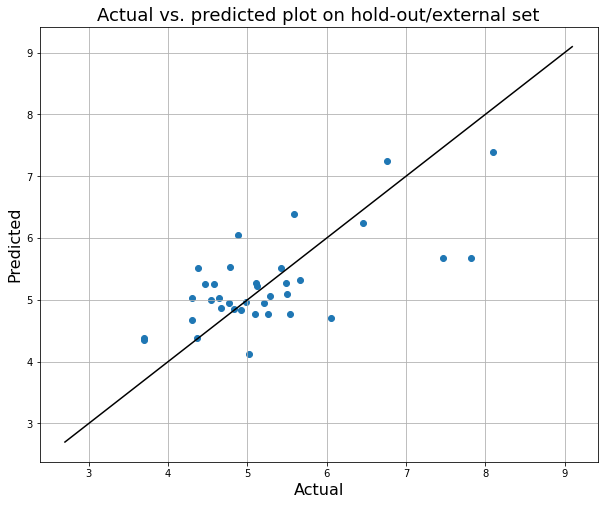

In [10]:
smiles_codes_val = model_wrapper.Data["smiles_codes_val"]
smiles_codes_train = model_wrapper.Data["smiles_codes_train"]
model_wrapper.Pipeline.fit(X=smiles_codes_train, y=None)
X_val = create_molecular_features(pipeline=model_wrapper.Pipeline, smiles_codes=smiles_codes_val)
X_val = process_molecular_features(pipeline=model_wrapper.Pipeline, X=X_val)
y_train_val_pred = model_wrapper.Predict(X_val)
y_train_val = model_wrapper.Data["targets_val"]
plotScatterWithIdeal(y_train_val.values, y_train_val_pred.values, "Actual vs. predicted plot on hold-out/external set")
l.info("R2 score on hold-out/external: %s", r2_score(y_train_val, y_train_val_pred))
l.info("MSE score on hold-out/external: %s", mean_squared_error(y_train_val, y_train_val_pred))
l.info("MAE score on hold-out/external: %s", mean_absolute_error(y_train_val, y_train_val_pred))

# QED, FP/PCA128 regression

## Training

In [58]:
TRAINING_CONFIGURATION_FILE = "QED_FP_PCA128_training_gyrase_regression.json"
with open(PIPELINES_DIR/TRAINING_CONFIGURATION_FILE, "r") as f:
    training_conf = json.load(f)
configuration_train = training_conf["training_aux_data"]

smiles_codes = df[ColumnNames.SMILES_COLUMN.value].copy()
target = df[ColumnNames.TARGET_COLUMN.value].copy()

non_idx = dt.validate_smiles(smiles_codes=smiles_codes)
smiles_codes = smiles_codes.drop(non_idx, axis=0)
target = target.drop(non_idx, axis=0)

pipeline_configuration = dt.read_in_pipeline(pipeline_file=configuration_train["pipeline_file"], 
                                                 pipeline_directory=PIPELINES_DIR)

y_train = dt.process_taget(pipeline_configuration=pipeline_configuration["target_transform"], y=target)
smiles_codes = smiles_codes.loc[y_train.index]

smiles_codes_train, smiles_codes_train_val, y_train, y_train_val = train_test_split(smiles_codes, y_train, test_size=0.1, random_state=42)

prediction_type = "regression"
model_wrapper = mw.model_wrapper.M_XGBoost(prediction_type=prediction_type, pipeline_configuration=pipeline_configuration)
model_wrapper.Data = {"smiles_codes_train": smiles_codes_train, "targets_train": y_train, "smiles_codes_val": smiles_codes_train_val, "targets_val": y_train_val}
model_wrapper.Create_Features()

2022-07-31 10:25:16,194 - logger - INFO - Scaler constructor...
2022-07-31 10:25:16,196 - logger - INFO - PCA constructor...
2022-07-31 10:25:16,197 - logger - INFO - CreateFPS fit...
2022-07-31 10:25:16,198 - logger - INFO - CreateFPS transform...
100%|██████████| 318/318 [00:00<00:00, 340.77it/s]


In [62]:
fmin_objective = partial(model_wrapper.F_Opt, aux_data=configuration_train)
trials = Trials()
rstate = np.random.RandomState(42)
max_evals = configuration_train["max_evals"]
best_hyperparams = fmin(fn=fmin_objective, space=model_wrapper.Space, algo=tpe.suggest, max_evals=max_evals, 
                        trials=trials, return_argmin=True, rstate=rstate, show_progressbar=True)

  0%|          | 0/200 [00:00<?, ?it/s, best loss: ?]

2022-07-31 10:26:12,493 - logger - INFO - Scaler fit...
2022-07-31 10:26:12,498 - logger - INFO - Scaler transform...
2022-07-31 10:26:12,508 - logger - INFO - Scaler fit...
2022-07-31 10:26:12,593 - logger - INFO - Scaler transform...
2022-07-31 10:26:12,604 - logger - INFO - PCA transform...
2022-07-31 10:26:12,627 - logger - INFO - Scaler transform...
2022-07-31 10:26:12,636 - logger - INFO - PCA transform...
2022-07-31 10:26:13,769 - logger - INFO - Scaler fit...
2022-07-31 10:26:13,772 - logger - INFO - Scaler transform...
2022-07-31 10:26:13,779 - logger - INFO - Scaler fit...
2022-07-31 10:26:13,849 - logger - INFO - Scaler transform...
2022-07-31 10:26:13,858 - logger - INFO - PCA transform...
2022-07-31 10:26:13,881 - logger - INFO - Scaler transform...
2022-07-31 10:26:13,889 - logger - INFO - PCA transform...
2022-07-31 10:26:14,921 - logger - INFO - Scaler fit...
2022-07-31 10:26:14,925 - logger - INFO - Scaler transform...
2022-07-31 10:26:14,932 - logger - INFO - Scaler f

  0%|          | 1/200 [00:04<14:38,  4.41s/it, best loss: 0.4717305185185984]

2022-07-31 10:26:16,902 - logger - INFO - Scaler fit...
2022-07-31 10:26:16,905 - logger - INFO - Scaler transform...
2022-07-31 10:26:16,912 - logger - INFO - Scaler fit...
2022-07-31 10:26:17,017 - logger - INFO - Scaler transform...
2022-07-31 10:26:17,027 - logger - INFO - PCA transform...
2022-07-31 10:26:17,050 - logger - INFO - Scaler transform...
2022-07-31 10:26:17,058 - logger - INFO - PCA transform...
2022-07-31 10:26:17,728 - logger - INFO - Scaler fit...
2022-07-31 10:26:17,732 - logger - INFO - Scaler transform...
2022-07-31 10:26:17,738 - logger - INFO - Scaler fit...
2022-07-31 10:26:17,857 - logger - INFO - Scaler transform...
2022-07-31 10:26:17,867 - logger - INFO - PCA transform...
2022-07-31 10:26:17,890 - logger - INFO - Scaler transform...
2022-07-31 10:26:17,898 - logger - INFO - PCA transform...
2022-07-31 10:26:18,862 - logger - INFO - Scaler fit...
2022-07-31 10:26:18,866 - logger - INFO - Scaler transform...
2022-07-31 10:26:18,873 - logger - INFO - Scaler f

  1%|          | 2/200 [00:08<12:59,  3.93s/it, best loss: 0.4717305185185984]

2022-07-31 10:26:20,500 - logger - INFO - Scaler fit...
2022-07-31 10:26:20,503 - logger - INFO - Scaler transform...
2022-07-31 10:26:20,509 - logger - INFO - Scaler fit...
2022-07-31 10:26:20,618 - logger - INFO - Scaler transform...
2022-07-31 10:26:20,628 - logger - INFO - PCA transform...
2022-07-31 10:26:20,651 - logger - INFO - Scaler transform...
2022-07-31 10:26:20,659 - logger - INFO - PCA transform...
2022-07-31 10:26:21,521 - logger - INFO - Scaler fit...
2022-07-31 10:26:21,525 - logger - INFO - Scaler transform...
2022-07-31 10:26:21,532 - logger - INFO - Scaler fit...
2022-07-31 10:26:21,639 - logger - INFO - Scaler transform...
2022-07-31 10:26:21,648 - logger - INFO - PCA transform...
2022-07-31 10:26:21,671 - logger - INFO - Scaler transform...
2022-07-31 10:26:21,680 - logger - INFO - PCA transform...
2022-07-31 10:26:22,558 - logger - INFO - Scaler fit...
2022-07-31 10:26:22,562 - logger - INFO - Scaler transform...
2022-07-31 10:26:22,568 - logger - INFO - Scaler f

  2%|▏         | 3/200 [00:11<12:52,  3.92s/it, best loss: 0.4717305185185984]

2022-07-31 10:26:24,408 - logger - INFO - Scaler fit...
2022-07-31 10:26:24,411 - logger - INFO - Scaler transform...
2022-07-31 10:26:24,416 - logger - INFO - Scaler fit...
2022-07-31 10:26:24,517 - logger - INFO - Scaler transform...
2022-07-31 10:26:24,526 - logger - INFO - PCA transform...
2022-07-31 10:26:24,557 - logger - INFO - Scaler transform...
2022-07-31 10:26:24,565 - logger - INFO - PCA transform...
2022-07-31 10:26:25,497 - logger - INFO - Scaler fit...
2022-07-31 10:26:25,501 - logger - INFO - Scaler transform...
2022-07-31 10:26:25,507 - logger - INFO - Scaler fit...
2022-07-31 10:26:25,635 - logger - INFO - Scaler transform...
2022-07-31 10:26:25,648 - logger - INFO - PCA transform...
2022-07-31 10:26:25,672 - logger - INFO - Scaler transform...
2022-07-31 10:26:25,680 - logger - INFO - PCA transform...
2022-07-31 10:26:26,728 - logger - INFO - Scaler fit...
2022-07-31 10:26:26,732 - logger - INFO - Scaler transform...
2022-07-31 10:26:26,739 - logger - INFO - Scaler f

  2%|▏         | 4/200 [00:16<13:31,  4.14s/it, best loss: 0.4717305185185984]

2022-07-31 10:26:28,878 - logger - INFO - Scaler fit...
2022-07-31 10:26:28,881 - logger - INFO - Scaler transform...
2022-07-31 10:26:28,888 - logger - INFO - Scaler fit...
2022-07-31 10:26:28,986 - logger - INFO - Scaler transform...
2022-07-31 10:26:28,996 - logger - INFO - PCA transform...
2022-07-31 10:26:29,021 - logger - INFO - Scaler transform...
2022-07-31 10:26:29,029 - logger - INFO - PCA transform...
2022-07-31 10:26:29,953 - logger - INFO - Scaler fit...
2022-07-31 10:26:29,957 - logger - INFO - Scaler transform...
2022-07-31 10:26:29,965 - logger - INFO - Scaler fit...
2022-07-31 10:26:30,168 - logger - INFO - Scaler transform...
2022-07-31 10:26:30,179 - logger - INFO - PCA transform...
2022-07-31 10:26:30,204 - logger - INFO - Scaler transform...
2022-07-31 10:26:30,212 - logger - INFO - PCA transform...
2022-07-31 10:26:31,045 - logger - INFO - Scaler fit...
2022-07-31 10:26:31,048 - logger - INFO - Scaler transform...
2022-07-31 10:26:31,055 - logger - INFO - Scaler f

  2%|▎         | 5/200 [00:20<13:42,  4.22s/it, best loss: 0.4717305185185984]

2022-07-31 10:26:33,241 - logger - INFO - Scaler fit...
2022-07-31 10:26:33,245 - logger - INFO - Scaler transform...
2022-07-31 10:26:33,251 - logger - INFO - Scaler fit...
2022-07-31 10:26:33,454 - logger - INFO - Scaler transform...
2022-07-31 10:26:33,464 - logger - INFO - PCA transform...
2022-07-31 10:26:33,487 - logger - INFO - Scaler transform...
2022-07-31 10:26:33,496 - logger - INFO - PCA transform...
2022-07-31 10:26:34,886 - logger - INFO - Scaler fit...
2022-07-31 10:26:34,890 - logger - INFO - Scaler transform...
2022-07-31 10:26:34,896 - logger - INFO - Scaler fit...
2022-07-31 10:26:34,990 - logger - INFO - Scaler transform...
2022-07-31 10:26:35,000 - logger - INFO - PCA transform...
2022-07-31 10:26:35,023 - logger - INFO - Scaler transform...
2022-07-31 10:26:35,031 - logger - INFO - PCA transform...
2022-07-31 10:26:35,961 - logger - INFO - Scaler fit...
2022-07-31 10:26:35,965 - logger - INFO - Scaler transform...
2022-07-31 10:26:35,971 - logger - INFO - Scaler f

  3%|▎         | 6/200 [00:25<14:45,  4.56s/it, best loss: 0.4717305185185984]

2022-07-31 10:26:38,473 - logger - INFO - Scaler fit...
2022-07-31 10:26:38,475 - logger - INFO - Scaler transform...
2022-07-31 10:26:38,481 - logger - INFO - Scaler fit...
2022-07-31 10:26:38,639 - logger - INFO - Scaler transform...
2022-07-31 10:26:38,649 - logger - INFO - PCA transform...
2022-07-31 10:26:38,681 - logger - INFO - Scaler transform...
2022-07-31 10:26:38,690 - logger - INFO - PCA transform...
2022-07-31 10:26:39,521 - logger - INFO - Scaler fit...
2022-07-31 10:26:39,524 - logger - INFO - Scaler transform...
2022-07-31 10:26:39,531 - logger - INFO - Scaler fit...
2022-07-31 10:26:39,601 - logger - INFO - Scaler transform...
2022-07-31 10:26:39,611 - logger - INFO - PCA transform...
2022-07-31 10:26:39,642 - logger - INFO - Scaler transform...
2022-07-31 10:26:39,651 - logger - INFO - PCA transform...
2022-07-31 10:26:40,392 - logger - INFO - Scaler fit...
2022-07-31 10:26:40,395 - logger - INFO - Scaler transform...
2022-07-31 10:26:40,402 - logger - INFO - Scaler f

  4%|▎         | 7/200 [00:29<13:31,  4.20s/it, best loss: 0.4717305185185984]

2022-07-31 10:26:41,937 - logger - INFO - Scaler fit...
2022-07-31 10:26:41,940 - logger - INFO - Scaler transform...
2022-07-31 10:26:41,946 - logger - INFO - Scaler fit...
2022-07-31 10:26:42,104 - logger - INFO - Scaler transform...
2022-07-31 10:26:42,114 - logger - INFO - PCA transform...
2022-07-31 10:26:42,138 - logger - INFO - Scaler transform...
2022-07-31 10:26:42,146 - logger - INFO - PCA transform...
2022-07-31 10:26:43,647 - logger - INFO - Scaler fit...
2022-07-31 10:26:43,650 - logger - INFO - Scaler transform...
2022-07-31 10:26:43,657 - logger - INFO - Scaler fit...
2022-07-31 10:26:43,753 - logger - INFO - Scaler transform...
2022-07-31 10:26:43,762 - logger - INFO - PCA transform...
2022-07-31 10:26:43,786 - logger - INFO - Scaler transform...
2022-07-31 10:26:43,794 - logger - INFO - PCA transform...
2022-07-31 10:26:45,206 - logger - INFO - Scaler fit...
2022-07-31 10:26:45,209 - logger - INFO - Scaler transform...
2022-07-31 10:26:45,216 - logger - INFO - Scaler f

  4%|▍         | 8/200 [00:34<14:46,  4.62s/it, best loss: 0.4717305185185984]

2022-07-31 10:26:47,433 - logger - INFO - Scaler fit...
2022-07-31 10:26:47,435 - logger - INFO - Scaler transform...
2022-07-31 10:26:47,441 - logger - INFO - Scaler fit...
2022-07-31 10:26:47,560 - logger - INFO - Scaler transform...
2022-07-31 10:26:47,570 - logger - INFO - PCA transform...
2022-07-31 10:26:47,593 - logger - INFO - Scaler transform...
2022-07-31 10:26:47,601 - logger - INFO - PCA transform...
2022-07-31 10:26:48,438 - logger - INFO - Scaler fit...
2022-07-31 10:26:48,442 - logger - INFO - Scaler transform...
2022-07-31 10:26:48,448 - logger - INFO - Scaler fit...
2022-07-31 10:26:48,560 - logger - INFO - Scaler transform...
2022-07-31 10:26:48,569 - logger - INFO - PCA transform...
2022-07-31 10:26:48,592 - logger - INFO - Scaler transform...
2022-07-31 10:26:48,600 - logger - INFO - PCA transform...
2022-07-31 10:26:49,408 - logger - INFO - Scaler fit...
2022-07-31 10:26:49,411 - logger - INFO - Scaler transform...
2022-07-31 10:26:49,418 - logger - INFO - Scaler f

  4%|▍         | 9/200 [00:38<13:51,  4.35s/it, best loss: 0.4717305185185984]

2022-07-31 10:26:51,209 - logger - INFO - Scaler fit...
2022-07-31 10:26:51,212 - logger - INFO - Scaler transform...
2022-07-31 10:26:51,218 - logger - INFO - Scaler fit...
2022-07-31 10:26:51,349 - logger - INFO - Scaler transform...
2022-07-31 10:26:51,359 - logger - INFO - PCA transform...
2022-07-31 10:26:51,392 - logger - INFO - Scaler transform...
2022-07-31 10:26:51,400 - logger - INFO - PCA transform...
2022-07-31 10:26:52,008 - logger - INFO - Scaler fit...
2022-07-31 10:26:52,012 - logger - INFO - Scaler transform...
2022-07-31 10:26:52,019 - logger - INFO - Scaler fit...
2022-07-31 10:26:52,138 - logger - INFO - Scaler transform...
2022-07-31 10:26:52,147 - logger - INFO - PCA transform...
2022-07-31 10:26:52,170 - logger - INFO - Scaler transform...
2022-07-31 10:26:52,179 - logger - INFO - PCA transform...
2022-07-31 10:26:52,917 - logger - INFO - Scaler fit...
2022-07-31 10:26:52,920 - logger - INFO - Scaler transform...
2022-07-31 10:26:52,927 - logger - INFO - Scaler f

  5%|▌         | 10/200 [00:41<12:23,  3.91s/it, best loss: 0.4717305185185984]

2022-07-31 10:26:54,133 - logger - INFO - Scaler fit...
2022-07-31 10:26:54,136 - logger - INFO - Scaler transform...
2022-07-31 10:26:54,142 - logger - INFO - Scaler fit...
2022-07-31 10:26:54,237 - logger - INFO - Scaler transform...
2022-07-31 10:26:54,247 - logger - INFO - PCA transform...
2022-07-31 10:26:54,291 - logger - INFO - Scaler transform...
2022-07-31 10:26:54,299 - logger - INFO - PCA transform...
2022-07-31 10:26:54,780 - logger - INFO - Scaler fit...
2022-07-31 10:26:54,784 - logger - INFO - Scaler transform...
2022-07-31 10:26:54,791 - logger - INFO - Scaler fit...
2022-07-31 10:26:54,933 - logger - INFO - Scaler transform...
2022-07-31 10:26:54,942 - logger - INFO - PCA transform...
2022-07-31 10:26:54,966 - logger - INFO - Scaler transform...
2022-07-31 10:26:54,974 - logger - INFO - PCA transform...
2022-07-31 10:26:55,701 - logger - INFO - Scaler fit...
2022-07-31 10:26:55,705 - logger - INFO - Scaler transform...
2022-07-31 10:26:55,713 - logger - INFO - Scaler f

  6%|▌         | 11/200 [00:44<10:54,  3.46s/it, best loss: 0.4717305185185984]

2022-07-31 10:26:56,583 - logger - INFO - Scaler fit...
2022-07-31 10:26:56,586 - logger - INFO - Scaler transform...
2022-07-31 10:26:56,592 - logger - INFO - Scaler fit...
2022-07-31 10:26:56,812 - logger - INFO - Scaler transform...
2022-07-31 10:26:56,821 - logger - INFO - PCA transform...
2022-07-31 10:26:56,845 - logger - INFO - Scaler transform...
2022-07-31 10:26:56,853 - logger - INFO - PCA transform...
2022-07-31 10:26:58,037 - logger - INFO - Scaler fit...
2022-07-31 10:26:58,041 - logger - INFO - Scaler transform...
2022-07-31 10:26:58,048 - logger - INFO - Scaler fit...
2022-07-31 10:26:58,282 - logger - INFO - Scaler transform...
2022-07-31 10:26:58,291 - logger - INFO - PCA transform...
2022-07-31 10:26:58,315 - logger - INFO - Scaler transform...
2022-07-31 10:26:58,323 - logger - INFO - PCA transform...
2022-07-31 10:26:59,737 - logger - INFO - Scaler fit...
2022-07-31 10:26:59,741 - logger - INFO - Scaler transform...
2022-07-31 10:26:59,747 - logger - INFO - Scaler f

  6%|▌         | 12/200 [00:49<12:41,  4.05s/it, best loss: 0.46671172179205406]

2022-07-31 10:27:01,971 - logger - INFO - Scaler fit...
2022-07-31 10:27:01,974 - logger - INFO - Scaler transform...
2022-07-31 10:27:01,980 - logger - INFO - Scaler fit...
2022-07-31 10:27:02,087 - logger - INFO - Scaler transform...
2022-07-31 10:27:02,098 - logger - INFO - PCA transform...
2022-07-31 10:27:02,132 - logger - INFO - Scaler transform...
2022-07-31 10:27:02,141 - logger - INFO - PCA transform...
2022-07-31 10:27:02,921 - logger - INFO - Scaler fit...
2022-07-31 10:27:02,926 - logger - INFO - Scaler transform...
2022-07-31 10:27:02,932 - logger - INFO - Scaler fit...
2022-07-31 10:27:03,052 - logger - INFO - Scaler transform...
2022-07-31 10:27:03,062 - logger - INFO - PCA transform...
2022-07-31 10:27:03,092 - logger - INFO - Scaler transform...
2022-07-31 10:27:03,100 - logger - INFO - PCA transform...
2022-07-31 10:27:04,118 - logger - INFO - Scaler fit...
2022-07-31 10:27:04,121 - logger - INFO - Scaler transform...
2022-07-31 10:27:04,128 - logger - INFO - Scaler f

  6%|▋         | 13/200 [00:53<12:37,  4.05s/it, best loss: 0.46671172179205406]

2022-07-31 10:27:06,017 - logger - INFO - Scaler fit...
2022-07-31 10:27:06,020 - logger - INFO - Scaler transform...
2022-07-31 10:27:06,026 - logger - INFO - Scaler fit...
2022-07-31 10:27:06,123 - logger - INFO - Scaler transform...
2022-07-31 10:27:06,133 - logger - INFO - PCA transform...
2022-07-31 10:27:06,165 - logger - INFO - Scaler transform...
2022-07-31 10:27:06,173 - logger - INFO - PCA transform...
2022-07-31 10:27:06,933 - logger - INFO - Scaler fit...
2022-07-31 10:27:06,936 - logger - INFO - Scaler transform...
2022-07-31 10:27:06,943 - logger - INFO - Scaler fit...
2022-07-31 10:27:07,071 - logger - INFO - Scaler transform...
2022-07-31 10:27:07,081 - logger - INFO - PCA transform...
2022-07-31 10:27:07,105 - logger - INFO - Scaler transform...
2022-07-31 10:27:07,113 - logger - INFO - PCA transform...
2022-07-31 10:27:08,146 - logger - INFO - Scaler fit...
2022-07-31 10:27:08,150 - logger - INFO - Scaler transform...
2022-07-31 10:27:08,156 - logger - INFO - Scaler f

  7%|▋         | 14/200 [00:57<12:08,  3.92s/it, best loss: 0.46671172179205406]

2022-07-31 10:27:09,632 - logger - INFO - Scaler fit...
2022-07-31 10:27:09,634 - logger - INFO - Scaler transform...
2022-07-31 10:27:09,640 - logger - INFO - Scaler fit...
2022-07-31 10:27:09,784 - logger - INFO - Scaler transform...
2022-07-31 10:27:09,794 - logger - INFO - PCA transform...
2022-07-31 10:27:09,818 - logger - INFO - Scaler transform...
2022-07-31 10:27:09,826 - logger - INFO - PCA transform...
2022-07-31 10:27:10,821 - logger - INFO - Scaler fit...
2022-07-31 10:27:10,824 - logger - INFO - Scaler transform...
2022-07-31 10:27:10,831 - logger - INFO - Scaler fit...
2022-07-31 10:27:10,905 - logger - INFO - Scaler transform...
2022-07-31 10:27:10,914 - logger - INFO - PCA transform...
2022-07-31 10:27:10,938 - logger - INFO - Scaler transform...
2022-07-31 10:27:10,946 - logger - INFO - PCA transform...
2022-07-31 10:27:11,910 - logger - INFO - Scaler fit...
2022-07-31 10:27:11,913 - logger - INFO - Scaler transform...
2022-07-31 10:27:11,920 - logger - INFO - Scaler f

  8%|▊         | 15/200 [01:01<12:04,  3.91s/it, best loss: 0.46671172179205406]

2022-07-31 10:27:13,541 - logger - INFO - Scaler fit...
2022-07-31 10:27:13,543 - logger - INFO - Scaler transform...
2022-07-31 10:27:13,549 - logger - INFO - Scaler fit...
2022-07-31 10:27:13,681 - logger - INFO - Scaler transform...
2022-07-31 10:27:13,690 - logger - INFO - PCA transform...
2022-07-31 10:27:13,718 - logger - INFO - Scaler transform...
2022-07-31 10:27:13,726 - logger - INFO - PCA transform...
2022-07-31 10:27:14,273 - logger - INFO - Scaler fit...
2022-07-31 10:27:14,277 - logger - INFO - Scaler transform...
2022-07-31 10:27:14,283 - logger - INFO - Scaler fit...
2022-07-31 10:27:14,400 - logger - INFO - Scaler transform...
2022-07-31 10:27:14,410 - logger - INFO - PCA transform...
2022-07-31 10:27:14,434 - logger - INFO - Scaler transform...
2022-07-31 10:27:14,442 - logger - INFO - PCA transform...
2022-07-31 10:27:15,280 - logger - INFO - Scaler fit...
2022-07-31 10:27:15,284 - logger - INFO - Scaler transform...
2022-07-31 10:27:15,291 - logger - INFO - Scaler f

  8%|▊         | 16/200 [01:04<11:25,  3.73s/it, best loss: 0.46671172179205406]

2022-07-31 10:27:16,826 - logger - INFO - Scaler fit...
2022-07-31 10:27:16,829 - logger - INFO - Scaler transform...
2022-07-31 10:27:16,835 - logger - INFO - Scaler fit...
2022-07-31 10:27:16,937 - logger - INFO - Scaler transform...
2022-07-31 10:27:16,948 - logger - INFO - PCA transform...
2022-07-31 10:27:16,981 - logger - INFO - Scaler transform...
2022-07-31 10:27:16,989 - logger - INFO - PCA transform...
2022-07-31 10:27:18,846 - logger - INFO - Scaler fit...
2022-07-31 10:27:18,850 - logger - INFO - Scaler transform...
2022-07-31 10:27:18,857 - logger - INFO - Scaler fit...
2022-07-31 10:27:18,951 - logger - INFO - Scaler transform...
2022-07-31 10:27:18,961 - logger - INFO - PCA transform...
2022-07-31 10:27:18,985 - logger - INFO - Scaler transform...
2022-07-31 10:27:18,993 - logger - INFO - PCA transform...
2022-07-31 10:27:20,692 - logger - INFO - Scaler fit...
2022-07-31 10:27:20,696 - logger - INFO - Scaler transform...
2022-07-31 10:27:20,703 - logger - INFO - Scaler f

  8%|▊         | 17/200 [01:10<13:36,  4.46s/it, best loss: 0.46671172179205406]

2022-07-31 10:27:23,001 - logger - INFO - Scaler fit...
2022-07-31 10:27:23,004 - logger - INFO - Scaler transform...
2022-07-31 10:27:23,012 - logger - INFO - Scaler fit...
2022-07-31 10:27:23,163 - logger - INFO - Scaler transform...
2022-07-31 10:27:23,174 - logger - INFO - PCA transform...
2022-07-31 10:27:23,200 - logger - INFO - Scaler transform...
2022-07-31 10:27:23,209 - logger - INFO - PCA transform...
2022-07-31 10:27:24,319 - logger - INFO - Scaler fit...
2022-07-31 10:27:24,323 - logger - INFO - Scaler transform...
2022-07-31 10:27:24,330 - logger - INFO - Scaler fit...
2022-07-31 10:27:24,412 - logger - INFO - Scaler transform...
2022-07-31 10:27:24,424 - logger - INFO - PCA transform...
2022-07-31 10:27:24,458 - logger - INFO - Scaler transform...
2022-07-31 10:27:24,468 - logger - INFO - PCA transform...
2022-07-31 10:27:25,683 - logger - INFO - Scaler fit...
2022-07-31 10:27:25,687 - logger - INFO - Scaler transform...
2022-07-31 10:27:25,694 - logger - INFO - Scaler f

  9%|▉         | 18/200 [01:15<13:51,  4.57s/it, best loss: 0.46671172179205406]

2022-07-31 10:27:27,811 - logger - INFO - Scaler fit...
2022-07-31 10:27:27,814 - logger - INFO - Scaler transform...
2022-07-31 10:27:27,821 - logger - INFO - Scaler fit...
2022-07-31 10:27:27,991 - logger - INFO - Scaler transform...
2022-07-31 10:27:28,002 - logger - INFO - PCA transform...
2022-07-31 10:27:28,034 - logger - INFO - Scaler transform...
2022-07-31 10:27:28,043 - logger - INFO - PCA transform...
2022-07-31 10:27:28,829 - logger - INFO - Scaler fit...
2022-07-31 10:27:28,833 - logger - INFO - Scaler transform...
2022-07-31 10:27:28,840 - logger - INFO - Scaler fit...
2022-07-31 10:27:28,942 - logger - INFO - Scaler transform...
2022-07-31 10:27:28,969 - logger - INFO - PCA transform...
2022-07-31 10:27:28,994 - logger - INFO - Scaler transform...
2022-07-31 10:27:29,004 - logger - INFO - PCA transform...
2022-07-31 10:27:29,897 - logger - INFO - Scaler fit...
2022-07-31 10:27:29,901 - logger - INFO - Scaler transform...
2022-07-31 10:27:29,909 - logger - INFO - Scaler f

 10%|▉         | 19/200 [01:19<13:12,  4.38s/it, best loss: 0.46671172179205406]

2022-07-31 10:27:31,748 - logger - INFO - Scaler fit...
2022-07-31 10:27:31,751 - logger - INFO - Scaler transform...
2022-07-31 10:27:31,758 - logger - INFO - Scaler fit...
2022-07-31 10:27:31,861 - logger - INFO - Scaler transform...
2022-07-31 10:27:31,873 - logger - INFO - PCA transform...
2022-07-31 10:27:31,897 - logger - INFO - Scaler transform...
2022-07-31 10:27:31,906 - logger - INFO - PCA transform...
2022-07-31 10:27:32,553 - logger - INFO - Scaler fit...
2022-07-31 10:27:32,557 - logger - INFO - Scaler transform...
2022-07-31 10:27:32,564 - logger - INFO - Scaler fit...
2022-07-31 10:27:32,684 - logger - INFO - Scaler transform...
2022-07-31 10:27:32,696 - logger - INFO - PCA transform...
2022-07-31 10:27:32,721 - logger - INFO - Scaler transform...
2022-07-31 10:27:32,731 - logger - INFO - PCA transform...
2022-07-31 10:27:33,185 - logger - INFO - Scaler fit...
2022-07-31 10:27:33,189 - logger - INFO - Scaler transform...
2022-07-31 10:27:33,196 - logger - INFO - Scaler f

 10%|█         | 20/200 [01:22<11:49,  3.94s/it, best loss: 0.46671172179205406]

2022-07-31 10:27:34,681 - logger - INFO - Scaler fit...
2022-07-31 10:27:34,684 - logger - INFO - Scaler transform...
2022-07-31 10:27:34,691 - logger - INFO - Scaler fit...
2022-07-31 10:27:34,824 - logger - INFO - Scaler transform...
2022-07-31 10:27:34,835 - logger - INFO - PCA transform...
2022-07-31 10:27:34,858 - logger - INFO - Scaler transform...
2022-07-31 10:27:34,867 - logger - INFO - PCA transform...
2022-07-31 10:27:35,643 - logger - INFO - Scaler fit...
2022-07-31 10:27:35,647 - logger - INFO - Scaler transform...
2022-07-31 10:27:35,654 - logger - INFO - Scaler fit...
2022-07-31 10:27:35,797 - logger - INFO - Scaler transform...
2022-07-31 10:27:35,808 - logger - INFO - PCA transform...
2022-07-31 10:27:35,832 - logger - INFO - Scaler transform...
2022-07-31 10:27:35,841 - logger - INFO - PCA transform...
2022-07-31 10:27:36,681 - logger - INFO - Scaler fit...
2022-07-31 10:27:36,685 - logger - INFO - Scaler transform...
2022-07-31 10:27:36,692 - logger - INFO - Scaler f

 10%|█         | 21/200 [01:26<12:25,  4.16s/it, best loss: 0.46671172179205406]

2022-07-31 10:27:39,360 - logger - INFO - Scaler fit...
2022-07-31 10:27:39,363 - logger - INFO - Scaler transform...
2022-07-31 10:27:39,369 - logger - INFO - Scaler fit...
2022-07-31 10:27:39,511 - logger - INFO - Scaler transform...
2022-07-31 10:27:39,520 - logger - INFO - PCA transform...
2022-07-31 10:27:39,547 - logger - INFO - Scaler transform...
2022-07-31 10:27:39,555 - logger - INFO - PCA transform...
2022-07-31 10:27:40,949 - logger - INFO - Scaler fit...
2022-07-31 10:27:40,953 - logger - INFO - Scaler transform...
2022-07-31 10:27:40,960 - logger - INFO - Scaler fit...
2022-07-31 10:27:41,076 - logger - INFO - Scaler transform...
2022-07-31 10:27:41,085 - logger - INFO - PCA transform...
2022-07-31 10:27:41,108 - logger - INFO - Scaler transform...
2022-07-31 10:27:41,116 - logger - INFO - PCA transform...
2022-07-31 10:27:42,416 - logger - INFO - Scaler fit...
2022-07-31 10:27:42,419 - logger - INFO - Scaler transform...
2022-07-31 10:27:42,426 - logger - INFO - Scaler f

 11%|█         | 22/200 [01:32<13:16,  4.47s/it, best loss: 0.4550794895372439] 

2022-07-31 10:27:44,560 - logger - INFO - Scaler fit...
2022-07-31 10:27:44,563 - logger - INFO - Scaler transform...
2022-07-31 10:27:44,569 - logger - INFO - Scaler fit...
2022-07-31 10:27:44,678 - logger - INFO - Scaler transform...
2022-07-31 10:27:44,687 - logger - INFO - PCA transform...
2022-07-31 10:27:44,711 - logger - INFO - Scaler transform...
2022-07-31 10:27:44,719 - logger - INFO - PCA transform...
2022-07-31 10:27:46,647 - logger - INFO - Scaler fit...
2022-07-31 10:27:46,651 - logger - INFO - Scaler transform...
2022-07-31 10:27:46,657 - logger - INFO - Scaler fit...
2022-07-31 10:27:46,756 - logger - INFO - Scaler transform...
2022-07-31 10:27:46,766 - logger - INFO - PCA transform...
2022-07-31 10:27:46,791 - logger - INFO - Scaler transform...
2022-07-31 10:27:46,799 - logger - INFO - PCA transform...
2022-07-31 10:27:48,624 - logger - INFO - Scaler fit...
2022-07-31 10:27:48,628 - logger - INFO - Scaler transform...
2022-07-31 10:27:48,635 - logger - INFO - Scaler f

 12%|█▏        | 23/200 [01:39<15:48,  5.36s/it, best loss: 0.4550794895372439]

2022-07-31 10:27:51,983 - logger - INFO - Scaler fit...
2022-07-31 10:27:51,985 - logger - INFO - Scaler transform...
2022-07-31 10:27:51,991 - logger - INFO - Scaler fit...
2022-07-31 10:27:52,161 - logger - INFO - Scaler transform...
2022-07-31 10:27:52,173 - logger - INFO - PCA transform...
2022-07-31 10:27:52,196 - logger - INFO - Scaler transform...
2022-07-31 10:27:52,204 - logger - INFO - PCA transform...
2022-07-31 10:27:52,854 - logger - INFO - Scaler fit...
2022-07-31 10:27:52,858 - logger - INFO - Scaler transform...
2022-07-31 10:27:52,864 - logger - INFO - Scaler fit...
2022-07-31 10:27:52,957 - logger - INFO - Scaler transform...
2022-07-31 10:27:52,966 - logger - INFO - PCA transform...
2022-07-31 10:27:52,990 - logger - INFO - Scaler transform...
2022-07-31 10:27:52,998 - logger - INFO - PCA transform...
2022-07-31 10:27:53,816 - logger - INFO - Scaler fit...
2022-07-31 10:27:53,820 - logger - INFO - Scaler transform...
2022-07-31 10:27:53,827 - logger - INFO - Scaler f

 12%|█▏        | 24/200 [01:42<13:47,  4.70s/it, best loss: 0.4550794895372439]

2022-07-31 10:27:55,147 - logger - INFO - Scaler fit...
2022-07-31 10:27:55,150 - logger - INFO - Scaler transform...
2022-07-31 10:27:55,156 - logger - INFO - Scaler fit...
2022-07-31 10:27:55,254 - logger - INFO - Scaler transform...
2022-07-31 10:27:55,264 - logger - INFO - PCA transform...
2022-07-31 10:27:55,288 - logger - INFO - Scaler transform...
2022-07-31 10:27:55,296 - logger - INFO - PCA transform...
2022-07-31 10:27:56,949 - logger - INFO - Scaler fit...
2022-07-31 10:27:56,952 - logger - INFO - Scaler transform...
2022-07-31 10:27:56,959 - logger - INFO - Scaler fit...
2022-07-31 10:27:57,054 - logger - INFO - Scaler transform...
2022-07-31 10:27:57,064 - logger - INFO - PCA transform...
2022-07-31 10:27:57,087 - logger - INFO - Scaler transform...
2022-07-31 10:27:57,095 - logger - INFO - PCA transform...
2022-07-31 10:27:58,865 - logger - INFO - Scaler fit...
2022-07-31 10:27:58,869 - logger - INFO - Scaler transform...
2022-07-31 10:27:58,875 - logger - INFO - Scaler f

 12%|█▎        | 25/200 [01:48<14:53,  5.11s/it, best loss: 0.4550794895372439]

2022-07-31 10:28:01,205 - logger - INFO - Scaler fit...
2022-07-31 10:28:01,208 - logger - INFO - Scaler transform...
2022-07-31 10:28:01,214 - logger - INFO - Scaler fit...
2022-07-31 10:28:01,309 - logger - INFO - Scaler transform...
2022-07-31 10:28:01,319 - logger - INFO - PCA transform...
2022-07-31 10:28:01,342 - logger - INFO - Scaler transform...
2022-07-31 10:28:01,351 - logger - INFO - PCA transform...
2022-07-31 10:28:02,097 - logger - INFO - Scaler fit...
2022-07-31 10:28:02,101 - logger - INFO - Scaler transform...
2022-07-31 10:28:02,107 - logger - INFO - Scaler fit...
2022-07-31 10:28:02,223 - logger - INFO - Scaler transform...
2022-07-31 10:28:02,232 - logger - INFO - PCA transform...
2022-07-31 10:28:02,256 - logger - INFO - Scaler transform...
2022-07-31 10:28:02,264 - logger - INFO - PCA transform...
2022-07-31 10:28:03,107 - logger - INFO - Scaler fit...
2022-07-31 10:28:03,110 - logger - INFO - Scaler transform...
2022-07-31 10:28:03,117 - logger - INFO - Scaler f

 13%|█▎        | 26/200 [01:52<13:40,  4.72s/it, best loss: 0.4550794895372439]

2022-07-31 10:28:05,015 - logger - INFO - Scaler fit...
2022-07-31 10:28:05,018 - logger - INFO - Scaler transform...
2022-07-31 10:28:05,024 - logger - INFO - Scaler fit...
2022-07-31 10:28:05,140 - logger - INFO - Scaler transform...
2022-07-31 10:28:05,150 - logger - INFO - PCA transform...
2022-07-31 10:28:05,174 - logger - INFO - Scaler transform...
2022-07-31 10:28:05,183 - logger - INFO - PCA transform...
2022-07-31 10:28:06,894 - logger - INFO - Scaler fit...
2022-07-31 10:28:06,898 - logger - INFO - Scaler transform...
2022-07-31 10:28:06,905 - logger - INFO - Scaler fit...
2022-07-31 10:28:07,003 - logger - INFO - Scaler transform...
2022-07-31 10:28:07,014 - logger - INFO - PCA transform...
2022-07-31 10:28:07,038 - logger - INFO - Scaler transform...
2022-07-31 10:28:07,046 - logger - INFO - PCA transform...
2022-07-31 10:28:08,535 - logger - INFO - Scaler fit...
2022-07-31 10:28:08,539 - logger - INFO - Scaler transform...
2022-07-31 10:28:08,546 - logger - INFO - Scaler f

 14%|█▎        | 27/200 [01:58<14:47,  5.13s/it, best loss: 0.4550794895372439]

2022-07-31 10:28:11,108 - logger - INFO - Scaler fit...
2022-07-31 10:28:11,111 - logger - INFO - Scaler transform...
2022-07-31 10:28:11,118 - logger - INFO - Scaler fit...
2022-07-31 10:28:11,192 - logger - INFO - Scaler transform...
2022-07-31 10:28:11,203 - logger - INFO - PCA transform...
2022-07-31 10:28:11,227 - logger - INFO - Scaler transform...
2022-07-31 10:28:11,236 - logger - INFO - PCA transform...
2022-07-31 10:28:12,387 - logger - INFO - Scaler fit...
2022-07-31 10:28:12,391 - logger - INFO - Scaler transform...
2022-07-31 10:28:12,400 - logger - INFO - Scaler fit...
2022-07-31 10:28:12,530 - logger - INFO - Scaler transform...
2022-07-31 10:28:12,542 - logger - INFO - PCA transform...
2022-07-31 10:28:12,564 - logger - INFO - Scaler transform...
2022-07-31 10:28:12,571 - logger - INFO - PCA transform...
2022-07-31 10:28:13,848 - logger - INFO - Scaler fit...
2022-07-31 10:28:13,853 - logger - INFO - Scaler transform...
2022-07-31 10:28:13,860 - logger - INFO - Scaler f

 14%|█▍        | 28/200 [02:03<14:26,  5.04s/it, best loss: 0.4550794895372439]

2022-07-31 10:28:15,938 - logger - INFO - Scaler fit...
2022-07-31 10:28:15,940 - logger - INFO - Scaler transform...
2022-07-31 10:28:15,947 - logger - INFO - Scaler fit...
2022-07-31 10:28:16,088 - logger - INFO - Scaler transform...
2022-07-31 10:28:16,098 - logger - INFO - PCA transform...
2022-07-31 10:28:16,127 - logger - INFO - Scaler transform...
2022-07-31 10:28:16,136 - logger - INFO - PCA transform...
2022-07-31 10:28:18,034 - logger - INFO - Scaler fit...
2022-07-31 10:28:18,038 - logger - INFO - Scaler transform...
2022-07-31 10:28:18,044 - logger - INFO - Scaler fit...
2022-07-31 10:28:18,169 - logger - INFO - Scaler transform...
2022-07-31 10:28:18,180 - logger - INFO - PCA transform...
2022-07-31 10:28:18,205 - logger - INFO - Scaler transform...
2022-07-31 10:28:18,214 - logger - INFO - PCA transform...
2022-07-31 10:28:19,841 - logger - INFO - Scaler fit...
2022-07-31 10:28:19,847 - logger - INFO - Scaler transform...
2022-07-31 10:28:19,854 - logger - INFO - Scaler f

 14%|█▍        | 29/200 [02:10<15:55,  5.59s/it, best loss: 0.45039917063500645]

2022-07-31 10:28:22,803 - logger - INFO - Scaler fit...
2022-07-31 10:28:22,805 - logger - INFO - Scaler transform...
2022-07-31 10:28:22,811 - logger - INFO - Scaler fit...
2022-07-31 10:28:22,966 - logger - INFO - Scaler transform...
2022-07-31 10:28:22,976 - logger - INFO - PCA transform...
2022-07-31 10:28:22,999 - logger - INFO - Scaler transform...
2022-07-31 10:28:23,007 - logger - INFO - PCA transform...
2022-07-31 10:28:24,726 - logger - INFO - Scaler fit...
2022-07-31 10:28:24,729 - logger - INFO - Scaler transform...
2022-07-31 10:28:24,736 - logger - INFO - Scaler fit...
2022-07-31 10:28:24,808 - logger - INFO - Scaler transform...
2022-07-31 10:28:24,817 - logger - INFO - PCA transform...
2022-07-31 10:28:24,836 - logger - INFO - Scaler transform...
2022-07-31 10:28:24,844 - logger - INFO - PCA transform...
2022-07-31 10:28:26,669 - logger - INFO - Scaler fit...
2022-07-31 10:28:26,672 - logger - INFO - Scaler transform...
2022-07-31 10:28:26,679 - logger - INFO - Scaler f

 15%|█▌        | 30/200 [02:17<16:53,  5.96s/it, best loss: 0.45039917063500645]

2022-07-31 10:28:29,639 - logger - INFO - Scaler fit...
2022-07-31 10:28:29,642 - logger - INFO - Scaler transform...
2022-07-31 10:28:29,649 - logger - INFO - Scaler fit...
2022-07-31 10:28:29,830 - logger - INFO - Scaler transform...
2022-07-31 10:28:29,840 - logger - INFO - PCA transform...
2022-07-31 10:28:29,864 - logger - INFO - Scaler transform...
2022-07-31 10:28:29,872 - logger - INFO - PCA transform...
2022-07-31 10:28:31,299 - logger - INFO - Scaler fit...
2022-07-31 10:28:31,303 - logger - INFO - Scaler transform...
2022-07-31 10:28:31,309 - logger - INFO - Scaler fit...
2022-07-31 10:28:31,383 - logger - INFO - Scaler transform...
2022-07-31 10:28:31,393 - logger - INFO - PCA transform...
2022-07-31 10:28:31,416 - logger - INFO - Scaler transform...
2022-07-31 10:28:31,425 - logger - INFO - PCA transform...
2022-07-31 10:28:32,998 - logger - INFO - Scaler fit...
2022-07-31 10:28:33,002 - logger - INFO - Scaler transform...
2022-07-31 10:28:33,008 - logger - INFO - Scaler f

 16%|█▌        | 31/200 [02:23<17:15,  6.12s/it, best loss: 0.45039917063500645]

2022-07-31 10:28:36,142 - logger - INFO - Scaler fit...
2022-07-31 10:28:36,145 - logger - INFO - Scaler transform...
2022-07-31 10:28:36,151 - logger - INFO - Scaler fit...
2022-07-31 10:28:36,282 - logger - INFO - Scaler transform...
2022-07-31 10:28:36,291 - logger - INFO - PCA transform...
2022-07-31 10:28:36,325 - logger - INFO - Scaler transform...
2022-07-31 10:28:36,333 - logger - INFO - PCA transform...
2022-07-31 10:28:37,977 - logger - INFO - Scaler fit...
2022-07-31 10:28:37,981 - logger - INFO - Scaler transform...
2022-07-31 10:28:37,988 - logger - INFO - Scaler fit...
2022-07-31 10:28:38,084 - logger - INFO - Scaler transform...
2022-07-31 10:28:38,094 - logger - INFO - PCA transform...
2022-07-31 10:28:38,117 - logger - INFO - Scaler transform...
2022-07-31 10:28:38,125 - logger - INFO - PCA transform...
2022-07-31 10:28:39,613 - logger - INFO - Scaler fit...
2022-07-31 10:28:39,617 - logger - INFO - Scaler transform...
2022-07-31 10:28:39,624 - logger - INFO - Scaler f

 16%|█▌        | 32/200 [02:30<17:33,  6.27s/it, best loss: 0.45039917063500645]

2022-07-31 10:28:42,750 - logger - INFO - Scaler fit...
2022-07-31 10:28:42,753 - logger - INFO - Scaler transform...
2022-07-31 10:28:42,759 - logger - INFO - Scaler fit...
2022-07-31 10:28:42,862 - logger - INFO - Scaler transform...
2022-07-31 10:28:42,871 - logger - INFO - PCA transform...
2022-07-31 10:28:42,894 - logger - INFO - Scaler transform...
2022-07-31 10:28:42,902 - logger - INFO - PCA transform...
2022-07-31 10:28:43,800 - logger - INFO - Scaler fit...
2022-07-31 10:28:43,804 - logger - INFO - Scaler transform...
2022-07-31 10:28:43,810 - logger - INFO - Scaler fit...
2022-07-31 10:28:43,940 - logger - INFO - Scaler transform...
2022-07-31 10:28:43,950 - logger - INFO - PCA transform...
2022-07-31 10:28:43,973 - logger - INFO - Scaler transform...
2022-07-31 10:28:43,981 - logger - INFO - PCA transform...
2022-07-31 10:28:44,934 - logger - INFO - Scaler fit...
2022-07-31 10:28:44,938 - logger - INFO - Scaler transform...
2022-07-31 10:28:44,944 - logger - INFO - Scaler f

 16%|█▋        | 33/200 [02:34<15:40,  5.63s/it, best loss: 0.45039917063500645]

2022-07-31 10:28:46,897 - logger - INFO - Scaler fit...
2022-07-31 10:28:46,900 - logger - INFO - Scaler transform...
2022-07-31 10:28:46,906 - logger - INFO - Scaler fit...
2022-07-31 10:28:47,045 - logger - INFO - Scaler transform...
2022-07-31 10:28:47,055 - logger - INFO - PCA transform...
2022-07-31 10:28:47,081 - logger - INFO - Scaler transform...
2022-07-31 10:28:47,090 - logger - INFO - PCA transform...
2022-07-31 10:28:47,847 - logger - INFO - Scaler fit...
2022-07-31 10:28:47,851 - logger - INFO - Scaler transform...
2022-07-31 10:28:47,857 - logger - INFO - Scaler fit...
2022-07-31 10:28:47,958 - logger - INFO - Scaler transform...
2022-07-31 10:28:47,968 - logger - INFO - PCA transform...
2022-07-31 10:28:47,991 - logger - INFO - Scaler transform...
2022-07-31 10:28:47,999 - logger - INFO - PCA transform...
2022-07-31 10:28:48,582 - logger - INFO - Scaler fit...
2022-07-31 10:28:48,585 - logger - INFO - Scaler transform...
2022-07-31 10:28:48,591 - logger - INFO - Scaler f

 17%|█▋        | 34/200 [02:37<13:52,  5.02s/it, best loss: 0.45039917063500645]

2022-07-31 10:28:50,478 - logger - INFO - Scaler fit...
2022-07-31 10:28:50,481 - logger - INFO - Scaler transform...
2022-07-31 10:28:50,487 - logger - INFO - Scaler fit...
2022-07-31 10:28:50,599 - logger - INFO - Scaler transform...
2022-07-31 10:28:50,608 - logger - INFO - PCA transform...
2022-07-31 10:28:50,638 - logger - INFO - Scaler transform...
2022-07-31 10:28:50,646 - logger - INFO - PCA transform...
2022-07-31 10:28:52,100 - logger - INFO - Scaler fit...
2022-07-31 10:28:52,103 - logger - INFO - Scaler transform...
2022-07-31 10:28:52,110 - logger - INFO - Scaler fit...
2022-07-31 10:28:52,213 - logger - INFO - Scaler transform...
2022-07-31 10:28:52,223 - logger - INFO - PCA transform...
2022-07-31 10:28:52,250 - logger - INFO - Scaler transform...
2022-07-31 10:28:52,259 - logger - INFO - PCA transform...
2022-07-31 10:28:53,879 - logger - INFO - Scaler fit...
2022-07-31 10:28:53,883 - logger - INFO - Scaler transform...
2022-07-31 10:28:53,890 - logger - INFO - Scaler f

 18%|█▊        | 35/200 [02:43<14:36,  5.31s/it, best loss: 0.45039917063500645]

2022-07-31 10:28:56,485 - logger - INFO - Scaler fit...
2022-07-31 10:28:56,488 - logger - INFO - Scaler transform...
2022-07-31 10:28:56,494 - logger - INFO - Scaler fit...
2022-07-31 10:28:56,632 - logger - INFO - Scaler transform...
2022-07-31 10:28:56,642 - logger - INFO - PCA transform...
2022-07-31 10:28:56,665 - logger - INFO - Scaler transform...
2022-07-31 10:28:56,673 - logger - INFO - PCA transform...
2022-07-31 10:28:57,254 - logger - INFO - Scaler fit...
2022-07-31 10:28:57,258 - logger - INFO - Scaler transform...
2022-07-31 10:28:57,264 - logger - INFO - Scaler fit...
2022-07-31 10:28:57,348 - logger - INFO - Scaler transform...
2022-07-31 10:28:57,360 - logger - INFO - PCA transform...
2022-07-31 10:28:57,393 - logger - INFO - Scaler transform...
2022-07-31 10:28:57,401 - logger - INFO - PCA transform...
2022-07-31 10:28:57,977 - logger - INFO - Scaler fit...
2022-07-31 10:28:57,980 - logger - INFO - Scaler transform...
2022-07-31 10:28:57,987 - logger - INFO - Scaler f

 18%|█▊        | 36/200 [02:46<12:31,  4.58s/it, best loss: 0.45039917063500645]

2022-07-31 10:28:59,360 - logger - INFO - Scaler fit...
2022-07-31 10:28:59,363 - logger - INFO - Scaler transform...
2022-07-31 10:28:59,368 - logger - INFO - Scaler fit...
2022-07-31 10:28:59,445 - logger - INFO - Scaler transform...
2022-07-31 10:28:59,455 - logger - INFO - PCA transform...
2022-07-31 10:28:59,479 - logger - INFO - Scaler transform...
2022-07-31 10:28:59,488 - logger - INFO - PCA transform...
2022-07-31 10:29:00,608 - logger - INFO - Scaler fit...
2022-07-31 10:29:00,612 - logger - INFO - Scaler transform...
2022-07-31 10:29:00,619 - logger - INFO - Scaler fit...
2022-07-31 10:29:00,698 - logger - INFO - Scaler transform...
2022-07-31 10:29:00,708 - logger - INFO - PCA transform...
2022-07-31 10:29:00,739 - logger - INFO - Scaler transform...
2022-07-31 10:29:00,748 - logger - INFO - PCA transform...
2022-07-31 10:29:02,189 - logger - INFO - Scaler fit...
2022-07-31 10:29:02,193 - logger - INFO - Scaler transform...
2022-07-31 10:29:02,199 - logger - INFO - Scaler f

 18%|█▊        | 37/200 [02:51<12:46,  4.70s/it, best loss: 0.45039917063500645]

2022-07-31 10:29:04,337 - logger - INFO - Scaler fit...
2022-07-31 10:29:04,339 - logger - INFO - Scaler transform...
2022-07-31 10:29:04,345 - logger - INFO - Scaler fit...
2022-07-31 10:29:04,498 - logger - INFO - Scaler transform...
2022-07-31 10:29:04,507 - logger - INFO - PCA transform...
2022-07-31 10:29:04,530 - logger - INFO - Scaler transform...
2022-07-31 10:29:04,539 - logger - INFO - PCA transform...
2022-07-31 10:29:05,508 - logger - INFO - Scaler fit...
2022-07-31 10:29:05,511 - logger - INFO - Scaler transform...
2022-07-31 10:29:05,518 - logger - INFO - Scaler fit...
2022-07-31 10:29:05,673 - logger - INFO - Scaler transform...
2022-07-31 10:29:05,682 - logger - INFO - PCA transform...
2022-07-31 10:29:05,706 - logger - INFO - Scaler transform...
2022-07-31 10:29:05,714 - logger - INFO - PCA transform...
2022-07-31 10:29:06,574 - logger - INFO - Scaler fit...
2022-07-31 10:29:06,578 - logger - INFO - Scaler transform...
2022-07-31 10:29:06,584 - logger - INFO - Scaler f

 19%|█▉        | 38/200 [02:55<12:15,  4.54s/it, best loss: 0.45039917063500645]

2022-07-31 10:29:08,494 - logger - INFO - Scaler fit...
2022-07-31 10:29:08,497 - logger - INFO - Scaler transform...
2022-07-31 10:29:08,503 - logger - INFO - Scaler fit...
2022-07-31 10:29:08,580 - logger - INFO - Scaler transform...
2022-07-31 10:29:08,590 - logger - INFO - PCA transform...
2022-07-31 10:29:08,613 - logger - INFO - Scaler transform...
2022-07-31 10:29:08,621 - logger - INFO - PCA transform...
2022-07-31 10:29:10,324 - logger - INFO - Scaler fit...
2022-07-31 10:29:10,327 - logger - INFO - Scaler transform...
2022-07-31 10:29:10,334 - logger - INFO - Scaler fit...
2022-07-31 10:29:10,456 - logger - INFO - Scaler transform...
2022-07-31 10:29:10,465 - logger - INFO - PCA transform...
2022-07-31 10:29:10,494 - logger - INFO - Scaler transform...
2022-07-31 10:29:10,503 - logger - INFO - PCA transform...
2022-07-31 10:29:12,040 - logger - INFO - Scaler fit...
2022-07-31 10:29:12,044 - logger - INFO - Scaler transform...
2022-07-31 10:29:12,050 - logger - INFO - Scaler f

 20%|█▉        | 39/200 [03:02<13:28,  5.02s/it, best loss: 0.45039917063500645]

2022-07-31 10:29:14,638 - logger - INFO - Scaler fit...
2022-07-31 10:29:14,641 - logger - INFO - Scaler transform...
2022-07-31 10:29:14,647 - logger - INFO - Scaler fit...
2022-07-31 10:29:14,721 - logger - INFO - Scaler transform...
2022-07-31 10:29:14,731 - logger - INFO - PCA transform...
2022-07-31 10:29:14,755 - logger - INFO - Scaler transform...
2022-07-31 10:29:14,763 - logger - INFO - PCA transform...
2022-07-31 10:29:16,234 - logger - INFO - Scaler fit...
2022-07-31 10:29:16,238 - logger - INFO - Scaler transform...
2022-07-31 10:29:16,244 - logger - INFO - Scaler fit...
2022-07-31 10:29:16,340 - logger - INFO - Scaler transform...
2022-07-31 10:29:16,349 - logger - INFO - PCA transform...
2022-07-31 10:29:16,373 - logger - INFO - Scaler transform...
2022-07-31 10:29:16,381 - logger - INFO - PCA transform...
2022-07-31 10:29:17,405 - logger - INFO - Scaler fit...
2022-07-31 10:29:17,409 - logger - INFO - Scaler transform...
2022-07-31 10:29:17,415 - logger - INFO - Scaler f

 20%|██        | 40/200 [03:07<13:15,  4.97s/it, best loss: 0.45039917063500645]

2022-07-31 10:29:19,505 - logger - INFO - Scaler fit...
2022-07-31 10:29:19,508 - logger - INFO - Scaler transform...
2022-07-31 10:29:19,514 - logger - INFO - Scaler fit...
2022-07-31 10:29:19,643 - logger - INFO - Scaler transform...
2022-07-31 10:29:19,653 - logger - INFO - PCA transform...
2022-07-31 10:29:19,676 - logger - INFO - Scaler transform...
2022-07-31 10:29:19,685 - logger - INFO - PCA transform...
2022-07-31 10:29:20,709 - logger - INFO - Scaler fit...
2022-07-31 10:29:20,712 - logger - INFO - Scaler transform...
2022-07-31 10:29:20,719 - logger - INFO - Scaler fit...
2022-07-31 10:29:20,809 - logger - INFO - Scaler transform...
2022-07-31 10:29:20,818 - logger - INFO - PCA transform...
2022-07-31 10:29:20,841 - logger - INFO - Scaler transform...
2022-07-31 10:29:20,849 - logger - INFO - PCA transform...
2022-07-31 10:29:21,844 - logger - INFO - Scaler fit...
2022-07-31 10:29:21,847 - logger - INFO - Scaler transform...
2022-07-31 10:29:21,854 - logger - INFO - Scaler f

 20%|██        | 41/200 [03:11<12:44,  4.81s/it, best loss: 0.45039917063500645]

2022-07-31 10:29:23,920 - logger - INFO - Scaler fit...
2022-07-31 10:29:23,923 - logger - INFO - Scaler transform...
2022-07-31 10:29:23,929 - logger - INFO - Scaler fit...
2022-07-31 10:29:24,073 - logger - INFO - Scaler transform...
2022-07-31 10:29:24,082 - logger - INFO - PCA transform...
2022-07-31 10:29:24,105 - logger - INFO - Scaler transform...
2022-07-31 10:29:24,113 - logger - INFO - PCA transform...
2022-07-31 10:29:24,686 - logger - INFO - Scaler fit...
2022-07-31 10:29:24,690 - logger - INFO - Scaler transform...
2022-07-31 10:29:24,696 - logger - INFO - Scaler fit...
2022-07-31 10:29:24,782 - logger - INFO - Scaler transform...
2022-07-31 10:29:24,792 - logger - INFO - PCA transform...
2022-07-31 10:29:24,815 - logger - INFO - Scaler transform...
2022-07-31 10:29:24,823 - logger - INFO - PCA transform...
2022-07-31 10:29:25,407 - logger - INFO - Scaler fit...
2022-07-31 10:29:25,411 - logger - INFO - Scaler transform...
2022-07-31 10:29:25,418 - logger - INFO - Scaler f

 21%|██        | 42/200 [03:14<11:06,  4.22s/it, best loss: 0.45039917063500645]

2022-07-31 10:29:26,764 - logger - INFO - Scaler fit...
2022-07-31 10:29:26,767 - logger - INFO - Scaler transform...
2022-07-31 10:29:26,773 - logger - INFO - Scaler fit...
2022-07-31 10:29:26,855 - logger - INFO - Scaler transform...
2022-07-31 10:29:26,865 - logger - INFO - PCA transform...
2022-07-31 10:29:26,889 - logger - INFO - Scaler transform...
2022-07-31 10:29:26,897 - logger - INFO - PCA transform...
2022-07-31 10:29:28,605 - logger - INFO - Scaler fit...
2022-07-31 10:29:28,609 - logger - INFO - Scaler transform...
2022-07-31 10:29:28,617 - logger - INFO - Scaler fit...
2022-07-31 10:29:28,691 - logger - INFO - Scaler transform...
2022-07-31 10:29:28,701 - logger - INFO - PCA transform...
2022-07-31 10:29:28,725 - logger - INFO - Scaler transform...
2022-07-31 10:29:28,733 - logger - INFO - PCA transform...
2022-07-31 10:29:29,827 - logger - INFO - Scaler fit...
2022-07-31 10:29:29,830 - logger - INFO - Scaler transform...
2022-07-31 10:29:29,837 - logger - INFO - Scaler f

 22%|██▏       | 43/200 [03:20<12:23,  4.74s/it, best loss: 0.45039917063500645]

2022-07-31 10:29:32,719 - logger - INFO - Scaler fit...
2022-07-31 10:29:32,722 - logger - INFO - Scaler transform...
2022-07-31 10:29:32,729 - logger - INFO - Scaler fit...
2022-07-31 10:29:32,868 - logger - INFO - Scaler transform...
2022-07-31 10:29:32,878 - logger - INFO - PCA transform...
2022-07-31 10:29:32,902 - logger - INFO - Scaler transform...
2022-07-31 10:29:32,910 - logger - INFO - PCA transform...
2022-07-31 10:29:33,876 - logger - INFO - Scaler fit...
2022-07-31 10:29:33,879 - logger - INFO - Scaler transform...
2022-07-31 10:29:33,887 - logger - INFO - Scaler fit...
2022-07-31 10:29:33,982 - logger - INFO - Scaler transform...
2022-07-31 10:29:33,992 - logger - INFO - PCA transform...
2022-07-31 10:29:34,015 - logger - INFO - Scaler transform...
2022-07-31 10:29:34,024 - logger - INFO - PCA transform...
2022-07-31 10:29:34,861 - logger - INFO - Scaler fit...
2022-07-31 10:29:34,865 - logger - INFO - Scaler transform...
2022-07-31 10:29:34,872 - logger - INFO - Scaler f

 22%|██▏       | 44/200 [03:24<11:54,  4.58s/it, best loss: 0.45039917063500645]

2022-07-31 10:29:36,935 - logger - INFO - Scaler fit...
2022-07-31 10:29:36,938 - logger - INFO - Scaler transform...
2022-07-31 10:29:36,944 - logger - INFO - Scaler fit...
2022-07-31 10:29:37,069 - logger - INFO - Scaler transform...
2022-07-31 10:29:37,078 - logger - INFO - PCA transform...
2022-07-31 10:29:37,109 - logger - INFO - Scaler transform...
2022-07-31 10:29:37,117 - logger - INFO - PCA transform...
2022-07-31 10:29:38,650 - logger - INFO - Scaler fit...
2022-07-31 10:29:38,653 - logger - INFO - Scaler transform...
2022-07-31 10:29:38,660 - logger - INFO - Scaler fit...
2022-07-31 10:29:38,755 - logger - INFO - Scaler transform...
2022-07-31 10:29:38,764 - logger - INFO - PCA transform...
2022-07-31 10:29:38,794 - logger - INFO - Scaler transform...
2022-07-31 10:29:38,803 - logger - INFO - PCA transform...
2022-07-31 10:29:39,945 - logger - INFO - Scaler fit...
2022-07-31 10:29:39,949 - logger - INFO - Scaler transform...
2022-07-31 10:29:39,955 - logger - INFO - Scaler f

 22%|██▎       | 45/200 [03:29<12:12,  4.73s/it, best loss: 0.45039917063500645]

2022-07-31 10:29:41,996 - logger - INFO - Scaler fit...
2022-07-31 10:29:41,998 - logger - INFO - Scaler transform...
2022-07-31 10:29:42,005 - logger - INFO - Scaler fit...
2022-07-31 10:29:42,143 - logger - INFO - Scaler transform...
2022-07-31 10:29:42,153 - logger - INFO - PCA transform...
2022-07-31 10:29:42,177 - logger - INFO - Scaler transform...
2022-07-31 10:29:42,185 - logger - INFO - PCA transform...
2022-07-31 10:29:43,843 - logger - INFO - Scaler fit...
2022-07-31 10:29:43,847 - logger - INFO - Scaler transform...
2022-07-31 10:29:43,853 - logger - INFO - Scaler fit...
2022-07-31 10:29:43,951 - logger - INFO - Scaler transform...
2022-07-31 10:29:43,961 - logger - INFO - PCA transform...
2022-07-31 10:29:43,984 - logger - INFO - Scaler transform...
2022-07-31 10:29:43,992 - logger - INFO - PCA transform...
2022-07-31 10:29:45,023 - logger - INFO - Scaler fit...
2022-07-31 10:29:45,027 - logger - INFO - Scaler transform...
2022-07-31 10:29:45,033 - logger - INFO - Scaler f

 23%|██▎       | 46/200 [03:35<12:50,  5.01s/it, best loss: 0.45039917063500645]

2022-07-31 10:29:47,655 - logger - INFO - Scaler fit...
2022-07-31 10:29:47,658 - logger - INFO - Scaler transform...
2022-07-31 10:29:47,664 - logger - INFO - Scaler fit...
2022-07-31 10:29:47,776 - logger - INFO - Scaler transform...
2022-07-31 10:29:47,785 - logger - INFO - PCA transform...
2022-07-31 10:29:47,817 - logger - INFO - Scaler transform...
2022-07-31 10:29:47,825 - logger - INFO - PCA transform...
2022-07-31 10:29:48,991 - logger - INFO - Scaler fit...
2022-07-31 10:29:48,995 - logger - INFO - Scaler transform...
2022-07-31 10:29:49,001 - logger - INFO - Scaler fit...
2022-07-31 10:29:49,078 - logger - INFO - Scaler transform...
2022-07-31 10:29:49,089 - logger - INFO - PCA transform...
2022-07-31 10:29:49,113 - logger - INFO - Scaler transform...
2022-07-31 10:29:49,122 - logger - INFO - PCA transform...
2022-07-31 10:29:49,969 - logger - INFO - Scaler fit...
2022-07-31 10:29:49,973 - logger - INFO - Scaler transform...
2022-07-31 10:29:49,979 - logger - INFO - Scaler f

 24%|██▎       | 47/200 [03:39<12:00,  4.71s/it, best loss: 0.45039917063500645]

2022-07-31 10:29:51,672 - logger - INFO - Scaler fit...
2022-07-31 10:29:51,675 - logger - INFO - Scaler transform...
2022-07-31 10:29:51,681 - logger - INFO - Scaler fit...
2022-07-31 10:29:51,820 - logger - INFO - Scaler transform...
2022-07-31 10:29:51,829 - logger - INFO - PCA transform...
2022-07-31 10:29:51,867 - logger - INFO - Scaler transform...
2022-07-31 10:29:51,876 - logger - INFO - PCA transform...
2022-07-31 10:29:53,213 - logger - INFO - Scaler fit...
2022-07-31 10:29:53,217 - logger - INFO - Scaler transform...
2022-07-31 10:29:53,223 - logger - INFO - Scaler fit...
2022-07-31 10:29:53,333 - logger - INFO - Scaler transform...
2022-07-31 10:29:53,344 - logger - INFO - PCA transform...
2022-07-31 10:29:53,394 - logger - INFO - Scaler transform...
2022-07-31 10:29:53,404 - logger - INFO - PCA transform...
2022-07-31 10:29:54,486 - logger - INFO - Scaler fit...
2022-07-31 10:29:54,490 - logger - INFO - Scaler transform...
2022-07-31 10:29:54,496 - logger - INFO - Scaler f

 24%|██▍       | 48/200 [03:44<12:34,  4.97s/it, best loss: 0.4441355866259344] 

2022-07-31 10:29:57,235 - logger - INFO - Scaler fit...
2022-07-31 10:29:57,238 - logger - INFO - Scaler transform...
2022-07-31 10:29:57,244 - logger - INFO - Scaler fit...
2022-07-31 10:29:57,402 - logger - INFO - Scaler transform...
2022-07-31 10:29:57,412 - logger - INFO - PCA transform...
2022-07-31 10:29:57,435 - logger - INFO - Scaler transform...
2022-07-31 10:29:57,443 - logger - INFO - PCA transform...
2022-07-31 10:29:58,765 - logger - INFO - Scaler fit...
2022-07-31 10:29:58,769 - logger - INFO - Scaler transform...
2022-07-31 10:29:58,775 - logger - INFO - Scaler fit...
2022-07-31 10:29:58,867 - logger - INFO - Scaler transform...
2022-07-31 10:29:58,876 - logger - INFO - PCA transform...
2022-07-31 10:29:58,899 - logger - INFO - Scaler transform...
2022-07-31 10:29:58,907 - logger - INFO - PCA transform...
2022-07-31 10:30:00,157 - logger - INFO - Scaler fit...
2022-07-31 10:30:00,161 - logger - INFO - Scaler transform...
2022-07-31 10:30:00,168 - logger - INFO - Scaler f

 24%|██▍       | 49/200 [03:49<12:16,  4.88s/it, best loss: 0.424601038020496] 

2022-07-31 10:30:01,917 - logger - INFO - Scaler fit...
2022-07-31 10:30:01,920 - logger - INFO - Scaler transform...
2022-07-31 10:30:01,926 - logger - INFO - Scaler fit...
2022-07-31 10:30:02,069 - logger - INFO - Scaler transform...
2022-07-31 10:30:02,080 - logger - INFO - PCA transform...
2022-07-31 10:30:02,103 - logger - INFO - Scaler transform...
2022-07-31 10:30:02,112 - logger - INFO - PCA transform...
2022-07-31 10:30:03,396 - logger - INFO - Scaler fit...
2022-07-31 10:30:03,399 - logger - INFO - Scaler transform...
2022-07-31 10:30:03,406 - logger - INFO - Scaler fit...
2022-07-31 10:30:03,512 - logger - INFO - Scaler transform...
2022-07-31 10:30:03,522 - logger - INFO - PCA transform...
2022-07-31 10:30:03,550 - logger - INFO - Scaler transform...
2022-07-31 10:30:03,558 - logger - INFO - PCA transform...
2022-07-31 10:30:04,544 - logger - INFO - Scaler fit...
2022-07-31 10:30:04,547 - logger - INFO - Scaler transform...
2022-07-31 10:30:04,554 - logger - INFO - Scaler f

 25%|██▌       | 50/200 [03:54<12:03,  4.83s/it, best loss: 0.424601038020496]

2022-07-31 10:30:06,616 - logger - INFO - Scaler fit...
2022-07-31 10:30:06,618 - logger - INFO - Scaler transform...
2022-07-31 10:30:06,625 - logger - INFO - Scaler fit...
2022-07-31 10:30:06,721 - logger - INFO - Scaler transform...
2022-07-31 10:30:06,731 - logger - INFO - PCA transform...
2022-07-31 10:30:06,754 - logger - INFO - Scaler transform...
2022-07-31 10:30:06,762 - logger - INFO - PCA transform...
2022-07-31 10:30:07,909 - logger - INFO - Scaler fit...
2022-07-31 10:30:07,913 - logger - INFO - Scaler transform...
2022-07-31 10:30:07,919 - logger - INFO - Scaler fit...
2022-07-31 10:30:08,004 - logger - INFO - Scaler transform...
2022-07-31 10:30:08,014 - logger - INFO - PCA transform...
2022-07-31 10:30:08,037 - logger - INFO - Scaler transform...
2022-07-31 10:30:08,045 - logger - INFO - PCA transform...
2022-07-31 10:30:08,996 - logger - INFO - Scaler fit...
2022-07-31 10:30:09,000 - logger - INFO - Scaler transform...
2022-07-31 10:30:09,006 - logger - INFO - Scaler f

 26%|██▌       | 51/200 [03:59<12:25,  5.00s/it, best loss: 0.424601038020496]

2022-07-31 10:30:12,034 - logger - INFO - Scaler fit...
2022-07-31 10:30:12,037 - logger - INFO - Scaler transform...
2022-07-31 10:30:12,043 - logger - INFO - Scaler fit...
2022-07-31 10:30:12,118 - logger - INFO - Scaler transform...
2022-07-31 10:30:12,128 - logger - INFO - PCA transform...
2022-07-31 10:30:12,151 - logger - INFO - Scaler transform...
2022-07-31 10:30:12,160 - logger - INFO - PCA transform...
2022-07-31 10:30:13,566 - logger - INFO - Scaler fit...
2022-07-31 10:30:13,570 - logger - INFO - Scaler transform...
2022-07-31 10:30:13,576 - logger - INFO - Scaler fit...
2022-07-31 10:30:13,668 - logger - INFO - Scaler transform...
2022-07-31 10:30:13,678 - logger - INFO - PCA transform...
2022-07-31 10:30:13,700 - logger - INFO - Scaler transform...
2022-07-31 10:30:13,709 - logger - INFO - PCA transform...
2022-07-31 10:30:14,748 - logger - INFO - Scaler fit...
2022-07-31 10:30:14,751 - logger - INFO - Scaler transform...
2022-07-31 10:30:14,758 - logger - INFO - Scaler f

 26%|██▌       | 52/200 [04:04<12:16,  4.98s/it, best loss: 0.424601038020496]

2022-07-31 10:30:16,958 - logger - INFO - Scaler fit...
2022-07-31 10:30:16,961 - logger - INFO - Scaler transform...
2022-07-31 10:30:16,968 - logger - INFO - Scaler fit...
2022-07-31 10:30:17,078 - logger - INFO - Scaler transform...
2022-07-31 10:30:17,088 - logger - INFO - PCA transform...
2022-07-31 10:30:17,111 - logger - INFO - Scaler transform...
2022-07-31 10:30:17,119 - logger - INFO - PCA transform...
2022-07-31 10:30:18,200 - logger - INFO - Scaler fit...
2022-07-31 10:30:18,204 - logger - INFO - Scaler transform...
2022-07-31 10:30:18,210 - logger - INFO - Scaler fit...
2022-07-31 10:30:18,335 - logger - INFO - Scaler transform...
2022-07-31 10:30:18,345 - logger - INFO - PCA transform...
2022-07-31 10:30:18,368 - logger - INFO - Scaler transform...
2022-07-31 10:30:18,376 - logger - INFO - PCA transform...
2022-07-31 10:30:19,509 - logger - INFO - Scaler fit...
2022-07-31 10:30:19,513 - logger - INFO - Scaler transform...
2022-07-31 10:30:19,519 - logger - INFO - Scaler f

 26%|██▋       | 53/200 [04:08<11:49,  4.83s/it, best loss: 0.424601038020496]

2022-07-31 10:30:21,428 - logger - INFO - Scaler fit...
2022-07-31 10:30:21,431 - logger - INFO - Scaler transform...
2022-07-31 10:30:21,437 - logger - INFO - Scaler fit...
2022-07-31 10:30:21,722 - logger - INFO - Scaler transform...
2022-07-31 10:30:21,732 - logger - INFO - PCA transform...
2022-07-31 10:30:21,757 - logger - INFO - Scaler transform...
2022-07-31 10:30:21,766 - logger - INFO - PCA transform...
2022-07-31 10:30:22,877 - logger - INFO - Scaler fit...
2022-07-31 10:30:22,881 - logger - INFO - Scaler transform...
2022-07-31 10:30:22,888 - logger - INFO - Scaler fit...
2022-07-31 10:30:23,007 - logger - INFO - Scaler transform...
2022-07-31 10:30:23,016 - logger - INFO - PCA transform...
2022-07-31 10:30:23,046 - logger - INFO - Scaler transform...
2022-07-31 10:30:23,054 - logger - INFO - PCA transform...
2022-07-31 10:30:24,129 - logger - INFO - Scaler fit...
2022-07-31 10:30:24,133 - logger - INFO - Scaler transform...
2022-07-31 10:30:24,139 - logger - INFO - Scaler f

 27%|██▋       | 54/200 [04:13<11:32,  4.75s/it, best loss: 0.424601038020496]

2022-07-31 10:30:25,983 - logger - INFO - Scaler fit...
2022-07-31 10:30:25,987 - logger - INFO - Scaler transform...
2022-07-31 10:30:25,993 - logger - INFO - Scaler fit...
2022-07-31 10:30:26,125 - logger - INFO - Scaler transform...
2022-07-31 10:30:26,134 - logger - INFO - PCA transform...
2022-07-31 10:30:26,157 - logger - INFO - Scaler transform...
2022-07-31 10:30:26,166 - logger - INFO - PCA transform...
2022-07-31 10:30:27,282 - logger - INFO - Scaler fit...
2022-07-31 10:30:27,286 - logger - INFO - Scaler transform...
2022-07-31 10:30:27,292 - logger - INFO - Scaler fit...
2022-07-31 10:30:27,373 - logger - INFO - Scaler transform...
2022-07-31 10:30:27,383 - logger - INFO - PCA transform...
2022-07-31 10:30:27,406 - logger - INFO - Scaler transform...
2022-07-31 10:30:27,415 - logger - INFO - PCA transform...
2022-07-31 10:30:28,765 - logger - INFO - Scaler fit...
2022-07-31 10:30:28,768 - logger - INFO - Scaler transform...
2022-07-31 10:30:28,775 - logger - INFO - Scaler f

 28%|██▊       | 55/200 [04:18<11:45,  4.86s/it, best loss: 0.424601038020496]

2022-07-31 10:30:31,119 - logger - INFO - Scaler fit...
2022-07-31 10:30:31,122 - logger - INFO - Scaler transform...
2022-07-31 10:30:31,129 - logger - INFO - Scaler fit...
2022-07-31 10:30:31,266 - logger - INFO - Scaler transform...
2022-07-31 10:30:31,276 - logger - INFO - PCA transform...
2022-07-31 10:30:31,300 - logger - INFO - Scaler transform...
2022-07-31 10:30:31,308 - logger - INFO - PCA transform...
2022-07-31 10:30:32,700 - logger - INFO - Scaler fit...
2022-07-31 10:30:32,704 - logger - INFO - Scaler transform...
2022-07-31 10:30:32,711 - logger - INFO - Scaler fit...
2022-07-31 10:30:32,803 - logger - INFO - Scaler transform...
2022-07-31 10:30:32,812 - logger - INFO - PCA transform...
2022-07-31 10:30:32,837 - logger - INFO - Scaler transform...
2022-07-31 10:30:32,846 - logger - INFO - PCA transform...
2022-07-31 10:30:33,727 - logger - INFO - Scaler fit...
2022-07-31 10:30:33,731 - logger - INFO - Scaler transform...
2022-07-31 10:30:33,738 - logger - INFO - Scaler f

 28%|██▊       | 56/200 [04:23<11:29,  4.79s/it, best loss: 0.424601038020496]

2022-07-31 10:30:35,729 - logger - INFO - Scaler fit...
2022-07-31 10:30:35,732 - logger - INFO - Scaler transform...
2022-07-31 10:30:35,738 - logger - INFO - Scaler fit...
2022-07-31 10:30:35,896 - logger - INFO - Scaler transform...
2022-07-31 10:30:35,906 - logger - INFO - PCA transform...
2022-07-31 10:30:35,929 - logger - INFO - Scaler transform...
2022-07-31 10:30:35,937 - logger - INFO - PCA transform...
2022-07-31 10:30:37,248 - logger - INFO - Scaler fit...
2022-07-31 10:30:37,252 - logger - INFO - Scaler transform...
2022-07-31 10:30:37,258 - logger - INFO - Scaler fit...
2022-07-31 10:30:37,376 - logger - INFO - Scaler transform...
2022-07-31 10:30:37,386 - logger - INFO - PCA transform...
2022-07-31 10:30:37,409 - logger - INFO - Scaler transform...
2022-07-31 10:30:37,418 - logger - INFO - PCA transform...
2022-07-31 10:30:38,469 - logger - INFO - Scaler fit...
2022-07-31 10:30:38,473 - logger - INFO - Scaler transform...
2022-07-31 10:30:38,480 - logger - INFO - Scaler f

 28%|██▊       | 57/200 [04:28<11:25,  4.80s/it, best loss: 0.424601038020496]

2022-07-31 10:30:40,547 - logger - INFO - Scaler fit...
2022-07-31 10:30:40,549 - logger - INFO - Scaler transform...
2022-07-31 10:30:40,555 - logger - INFO - Scaler fit...
2022-07-31 10:30:40,655 - logger - INFO - Scaler transform...
2022-07-31 10:30:40,665 - logger - INFO - PCA transform...
2022-07-31 10:30:40,688 - logger - INFO - Scaler transform...
2022-07-31 10:30:40,696 - logger - INFO - PCA transform...
2022-07-31 10:30:41,510 - logger - INFO - Scaler fit...
2022-07-31 10:30:41,514 - logger - INFO - Scaler transform...
2022-07-31 10:30:41,521 - logger - INFO - Scaler fit...
2022-07-31 10:30:41,767 - logger - INFO - Scaler transform...
2022-07-31 10:30:41,777 - logger - INFO - PCA transform...
2022-07-31 10:30:41,801 - logger - INFO - Scaler transform...
2022-07-31 10:30:41,809 - logger - INFO - PCA transform...
2022-07-31 10:30:42,581 - logger - INFO - Scaler fit...
2022-07-31 10:30:42,585 - logger - INFO - Scaler transform...
2022-07-31 10:30:42,592 - logger - INFO - Scaler f

 29%|██▉       | 58/200 [04:31<10:36,  4.48s/it, best loss: 0.424601038020496]

2022-07-31 10:30:44,289 - logger - INFO - Scaler fit...
2022-07-31 10:30:44,292 - logger - INFO - Scaler transform...
2022-07-31 10:30:44,298 - logger - INFO - Scaler fit...
2022-07-31 10:30:44,438 - logger - INFO - Scaler transform...
2022-07-31 10:30:44,448 - logger - INFO - PCA transform...
2022-07-31 10:30:44,475 - logger - INFO - Scaler transform...
2022-07-31 10:30:44,484 - logger - INFO - PCA transform...
2022-07-31 10:30:45,160 - logger - INFO - Scaler fit...
2022-07-31 10:30:45,164 - logger - INFO - Scaler transform...
2022-07-31 10:30:45,171 - logger - INFO - Scaler fit...
2022-07-31 10:30:45,312 - logger - INFO - Scaler transform...
2022-07-31 10:30:45,322 - logger - INFO - PCA transform...
2022-07-31 10:30:45,345 - logger - INFO - Scaler transform...
2022-07-31 10:30:45,354 - logger - INFO - PCA transform...
2022-07-31 10:30:46,134 - logger - INFO - Scaler fit...
2022-07-31 10:30:46,137 - logger - INFO - Scaler transform...
2022-07-31 10:30:46,144 - logger - INFO - Scaler f

 30%|██▉       | 59/200 [04:35<09:48,  4.17s/it, best loss: 0.424601038020496]

2022-07-31 10:30:47,749 - logger - INFO - Scaler fit...
2022-07-31 10:30:47,752 - logger - INFO - Scaler transform...
2022-07-31 10:30:47,758 - logger - INFO - Scaler fit...
2022-07-31 10:30:47,888 - logger - INFO - Scaler transform...
2022-07-31 10:30:47,898 - logger - INFO - PCA transform...
2022-07-31 10:30:47,919 - logger - INFO - Scaler transform...
2022-07-31 10:30:47,927 - logger - INFO - PCA transform...
2022-07-31 10:30:49,597 - logger - INFO - Scaler fit...
2022-07-31 10:30:49,601 - logger - INFO - Scaler transform...
2022-07-31 10:30:49,608 - logger - INFO - Scaler fit...
2022-07-31 10:30:49,700 - logger - INFO - Scaler transform...
2022-07-31 10:30:49,709 - logger - INFO - PCA transform...
2022-07-31 10:30:49,733 - logger - INFO - Scaler transform...
2022-07-31 10:30:49,741 - logger - INFO - PCA transform...
2022-07-31 10:30:51,383 - logger - INFO - Scaler fit...
2022-07-31 10:30:51,386 - logger - INFO - Scaler transform...
2022-07-31 10:30:51,392 - logger - INFO - Scaler f

 30%|███       | 60/200 [04:42<11:33,  4.96s/it, best loss: 0.424601038020496]

2022-07-31 10:30:54,534 - logger - INFO - Scaler fit...
2022-07-31 10:30:54,537 - logger - INFO - Scaler transform...
2022-07-31 10:30:54,543 - logger - INFO - Scaler fit...
2022-07-31 10:30:54,652 - logger - INFO - Scaler transform...
2022-07-31 10:30:54,662 - logger - INFO - PCA transform...
2022-07-31 10:30:54,685 - logger - INFO - Scaler transform...
2022-07-31 10:30:54,693 - logger - INFO - PCA transform...
2022-07-31 10:30:55,624 - logger - INFO - Scaler fit...
2022-07-31 10:30:55,627 - logger - INFO - Scaler transform...
2022-07-31 10:30:55,634 - logger - INFO - Scaler fit...
2022-07-31 10:30:55,709 - logger - INFO - Scaler transform...
2022-07-31 10:30:55,718 - logger - INFO - PCA transform...
2022-07-31 10:30:55,742 - logger - INFO - Scaler transform...
2022-07-31 10:30:55,750 - logger - INFO - PCA transform...
2022-07-31 10:30:56,485 - logger - INFO - Scaler fit...
2022-07-31 10:30:56,489 - logger - INFO - Scaler transform...
2022-07-31 10:30:56,495 - logger - INFO - Scaler f

 30%|███       | 61/200 [04:45<10:41,  4.62s/it, best loss: 0.424601038020496]

2022-07-31 10:30:58,355 - logger - INFO - Scaler fit...
2022-07-31 10:30:58,358 - logger - INFO - Scaler transform...
2022-07-31 10:30:58,365 - logger - INFO - Scaler fit...
2022-07-31 10:30:58,525 - logger - INFO - Scaler transform...
2022-07-31 10:30:58,534 - logger - INFO - PCA transform...
2022-07-31 10:30:58,558 - logger - INFO - Scaler transform...
2022-07-31 10:30:58,566 - logger - INFO - PCA transform...
2022-07-31 10:30:59,540 - logger - INFO - Scaler fit...
2022-07-31 10:30:59,544 - logger - INFO - Scaler transform...
2022-07-31 10:30:59,551 - logger - INFO - Scaler fit...
2022-07-31 10:30:59,676 - logger - INFO - Scaler transform...
2022-07-31 10:30:59,685 - logger - INFO - PCA transform...
2022-07-31 10:30:59,709 - logger - INFO - Scaler transform...
2022-07-31 10:30:59,717 - logger - INFO - PCA transform...
2022-07-31 10:31:00,816 - logger - INFO - Scaler fit...
2022-07-31 10:31:00,819 - logger - INFO - Scaler transform...
2022-07-31 10:31:00,826 - logger - INFO - Scaler f

 31%|███       | 62/200 [04:50<10:22,  4.51s/it, best loss: 0.424601038020496]

2022-07-31 10:31:02,617 - logger - INFO - Scaler fit...
2022-07-31 10:31:02,620 - logger - INFO - Scaler transform...
2022-07-31 10:31:02,626 - logger - INFO - Scaler fit...
2022-07-31 10:31:02,734 - logger - INFO - Scaler transform...
2022-07-31 10:31:02,743 - logger - INFO - PCA transform...
2022-07-31 10:31:02,770 - logger - INFO - Scaler transform...
2022-07-31 10:31:02,778 - logger - INFO - PCA transform...
2022-07-31 10:31:03,833 - logger - INFO - Scaler fit...
2022-07-31 10:31:03,836 - logger - INFO - Scaler transform...
2022-07-31 10:31:03,843 - logger - INFO - Scaler fit...
2022-07-31 10:31:03,920 - logger - INFO - Scaler transform...
2022-07-31 10:31:03,932 - logger - INFO - PCA transform...
2022-07-31 10:31:03,956 - logger - INFO - Scaler transform...
2022-07-31 10:31:03,965 - logger - INFO - PCA transform...
2022-07-31 10:31:04,946 - logger - INFO - Scaler fit...
2022-07-31 10:31:04,950 - logger - INFO - Scaler transform...
2022-07-31 10:31:04,957 - logger - INFO - Scaler f

 32%|███▏      | 63/200 [04:54<10:12,  4.47s/it, best loss: 0.424601038020496]

2022-07-31 10:31:07,002 - logger - INFO - Scaler fit...
2022-07-31 10:31:07,005 - logger - INFO - Scaler transform...
2022-07-31 10:31:07,012 - logger - INFO - Scaler fit...
2022-07-31 10:31:07,126 - logger - INFO - Scaler transform...
2022-07-31 10:31:07,136 - logger - INFO - PCA transform...
2022-07-31 10:31:07,160 - logger - INFO - Scaler transform...
2022-07-31 10:31:07,168 - logger - INFO - PCA transform...
2022-07-31 10:31:08,356 - logger - INFO - Scaler fit...
2022-07-31 10:31:08,360 - logger - INFO - Scaler transform...
2022-07-31 10:31:08,366 - logger - INFO - Scaler fit...
2022-07-31 10:31:08,510 - logger - INFO - Scaler transform...
2022-07-31 10:31:08,520 - logger - INFO - PCA transform...
2022-07-31 10:31:08,543 - logger - INFO - Scaler transform...
2022-07-31 10:31:08,551 - logger - INFO - PCA transform...
2022-07-31 10:31:09,826 - logger - INFO - Scaler fit...
2022-07-31 10:31:09,829 - logger - INFO - Scaler transform...
2022-07-31 10:31:09,836 - logger - INFO - Scaler f

 32%|███▏      | 64/200 [04:59<10:21,  4.57s/it, best loss: 0.424601038020496]

2022-07-31 10:31:11,799 - logger - INFO - Scaler fit...
2022-07-31 10:31:11,802 - logger - INFO - Scaler transform...
2022-07-31 10:31:11,809 - logger - INFO - Scaler fit...
2022-07-31 10:31:11,981 - logger - INFO - Scaler transform...
2022-07-31 10:31:11,991 - logger - INFO - PCA transform...
2022-07-31 10:31:12,020 - logger - INFO - Scaler transform...
2022-07-31 10:31:12,029 - logger - INFO - PCA transform...
2022-07-31 10:31:12,944 - logger - INFO - Scaler fit...
2022-07-31 10:31:12,948 - logger - INFO - Scaler transform...
2022-07-31 10:31:12,955 - logger - INFO - Scaler fit...
2022-07-31 10:31:13,062 - logger - INFO - Scaler transform...
2022-07-31 10:31:13,072 - logger - INFO - PCA transform...
2022-07-31 10:31:13,094 - logger - INFO - Scaler transform...
2022-07-31 10:31:13,103 - logger - INFO - PCA transform...
2022-07-31 10:31:13,710 - logger - INFO - Scaler fit...
2022-07-31 10:31:13,713 - logger - INFO - Scaler transform...
2022-07-31 10:31:13,719 - logger - INFO - Scaler f

 32%|███▎      | 65/200 [05:03<09:42,  4.32s/it, best loss: 0.424601038020496]

2022-07-31 10:31:15,523 - logger - INFO - Scaler fit...
2022-07-31 10:31:15,525 - logger - INFO - Scaler transform...
2022-07-31 10:31:15,532 - logger - INFO - Scaler fit...
2022-07-31 10:31:15,718 - logger - INFO - Scaler transform...
2022-07-31 10:31:15,728 - logger - INFO - PCA transform...
2022-07-31 10:31:15,751 - logger - INFO - Scaler transform...
2022-07-31 10:31:15,759 - logger - INFO - PCA transform...
2022-07-31 10:31:17,133 - logger - INFO - Scaler fit...
2022-07-31 10:31:17,137 - logger - INFO - Scaler transform...
2022-07-31 10:31:17,144 - logger - INFO - Scaler fit...
2022-07-31 10:31:17,233 - logger - INFO - Scaler transform...
2022-07-31 10:31:17,242 - logger - INFO - PCA transform...
2022-07-31 10:31:17,265 - logger - INFO - Scaler transform...
2022-07-31 10:31:17,273 - logger - INFO - PCA transform...
2022-07-31 10:31:18,271 - logger - INFO - Scaler fit...
2022-07-31 10:31:18,274 - logger - INFO - Scaler transform...
2022-07-31 10:31:18,281 - logger - INFO - Scaler f

 33%|███▎      | 66/200 [05:07<09:59,  4.48s/it, best loss: 0.424601038020496]

2022-07-31 10:31:20,376 - logger - INFO - Scaler fit...
2022-07-31 10:31:20,379 - logger - INFO - Scaler transform...
2022-07-31 10:31:20,386 - logger - INFO - Scaler fit...
2022-07-31 10:31:20,539 - logger - INFO - Scaler transform...
2022-07-31 10:31:20,560 - logger - INFO - PCA transform...
2022-07-31 10:31:20,605 - logger - INFO - Scaler transform...
2022-07-31 10:31:20,615 - logger - INFO - PCA transform...
2022-07-31 10:31:22,257 - logger - INFO - Scaler fit...
2022-07-31 10:31:22,261 - logger - INFO - Scaler transform...
2022-07-31 10:31:22,268 - logger - INFO - Scaler fit...
2022-07-31 10:31:22,372 - logger - INFO - Scaler transform...
2022-07-31 10:31:22,381 - logger - INFO - PCA transform...
2022-07-31 10:31:22,404 - logger - INFO - Scaler transform...
2022-07-31 10:31:22,412 - logger - INFO - PCA transform...
2022-07-31 10:31:23,360 - logger - INFO - Scaler fit...
2022-07-31 10:31:23,364 - logger - INFO - Scaler transform...
2022-07-31 10:31:23,370 - logger - INFO - Scaler f

 34%|███▎      | 67/200 [05:13<10:36,  4.79s/it, best loss: 0.424601038020496]

2022-07-31 10:31:25,882 - logger - INFO - Scaler fit...
2022-07-31 10:31:25,885 - logger - INFO - Scaler transform...
2022-07-31 10:31:25,891 - logger - INFO - Scaler fit...
2022-07-31 10:31:26,049 - logger - INFO - Scaler transform...
2022-07-31 10:31:26,059 - logger - INFO - PCA transform...
2022-07-31 10:31:26,085 - logger - INFO - Scaler transform...
2022-07-31 10:31:26,093 - logger - INFO - PCA transform...
2022-07-31 10:31:27,590 - logger - INFO - Scaler fit...
2022-07-31 10:31:27,593 - logger - INFO - Scaler transform...
2022-07-31 10:31:27,600 - logger - INFO - Scaler fit...
2022-07-31 10:31:27,692 - logger - INFO - Scaler transform...
2022-07-31 10:31:27,702 - logger - INFO - PCA transform...
2022-07-31 10:31:27,725 - logger - INFO - Scaler transform...
2022-07-31 10:31:27,733 - logger - INFO - PCA transform...
2022-07-31 10:31:29,145 - logger - INFO - Scaler fit...
2022-07-31 10:31:29,148 - logger - INFO - Scaler transform...
2022-07-31 10:31:29,155 - logger - INFO - Scaler f

 34%|███▍      | 68/200 [05:18<10:56,  4.97s/it, best loss: 0.424601038020496]

2022-07-31 10:31:31,286 - logger - INFO - Scaler fit...
2022-07-31 10:31:31,289 - logger - INFO - Scaler transform...
2022-07-31 10:31:31,296 - logger - INFO - Scaler fit...
2022-07-31 10:31:31,389 - logger - INFO - Scaler transform...
2022-07-31 10:31:31,398 - logger - INFO - PCA transform...
2022-07-31 10:31:31,422 - logger - INFO - Scaler transform...
2022-07-31 10:31:31,430 - logger - INFO - PCA transform...
2022-07-31 10:31:33,087 - logger - INFO - Scaler fit...
2022-07-31 10:31:33,091 - logger - INFO - Scaler transform...
2022-07-31 10:31:33,097 - logger - INFO - Scaler fit...
2022-07-31 10:31:33,177 - logger - INFO - Scaler transform...
2022-07-31 10:31:33,186 - logger - INFO - PCA transform...
2022-07-31 10:31:33,210 - logger - INFO - Scaler transform...
2022-07-31 10:31:33,219 - logger - INFO - PCA transform...
2022-07-31 10:31:34,794 - logger - INFO - Scaler fit...
2022-07-31 10:31:34,797 - logger - INFO - Scaler transform...
2022-07-31 10:31:34,804 - logger - INFO - Scaler f

 34%|███▍      | 69/200 [05:24<11:21,  5.20s/it, best loss: 0.41402754479934356]

2022-07-31 10:31:37,028 - logger - INFO - Scaler fit...
2022-07-31 10:31:37,031 - logger - INFO - Scaler transform...
2022-07-31 10:31:37,037 - logger - INFO - Scaler fit...
2022-07-31 10:31:37,174 - logger - INFO - Scaler transform...
2022-07-31 10:31:37,185 - logger - INFO - PCA transform...
2022-07-31 10:31:37,214 - logger - INFO - Scaler transform...
2022-07-31 10:31:37,223 - logger - INFO - PCA transform...
2022-07-31 10:31:38,980 - logger - INFO - Scaler fit...
2022-07-31 10:31:38,984 - logger - INFO - Scaler transform...
2022-07-31 10:31:38,991 - logger - INFO - Scaler fit...
2022-07-31 10:31:39,106 - logger - INFO - Scaler transform...
2022-07-31 10:31:39,117 - logger - INFO - PCA transform...
2022-07-31 10:31:39,140 - logger - INFO - Scaler transform...
2022-07-31 10:31:39,149 - logger - INFO - PCA transform...
2022-07-31 10:31:40,285 - logger - INFO - Scaler fit...
2022-07-31 10:31:40,289 - logger - INFO - Scaler transform...
2022-07-31 10:31:40,295 - logger - INFO - Scaler f

 35%|███▌      | 70/200 [05:30<11:35,  5.35s/it, best loss: 0.41402754479934356]

2022-07-31 10:31:42,712 - logger - INFO - Scaler fit...
2022-07-31 10:31:42,715 - logger - INFO - Scaler transform...
2022-07-31 10:31:42,722 - logger - INFO - Scaler fit...
2022-07-31 10:31:42,913 - logger - INFO - Scaler transform...
2022-07-31 10:31:42,922 - logger - INFO - PCA transform...
2022-07-31 10:31:42,946 - logger - INFO - Scaler transform...
2022-07-31 10:31:42,954 - logger - INFO - PCA transform...
2022-07-31 10:31:44,343 - logger - INFO - Scaler fit...
2022-07-31 10:31:44,347 - logger - INFO - Scaler transform...
2022-07-31 10:31:44,354 - logger - INFO - Scaler fit...
2022-07-31 10:31:44,500 - logger - INFO - Scaler transform...
2022-07-31 10:31:44,510 - logger - INFO - PCA transform...
2022-07-31 10:31:44,535 - logger - INFO - Scaler transform...
2022-07-31 10:31:44,544 - logger - INFO - PCA transform...
2022-07-31 10:31:45,655 - logger - INFO - Scaler fit...
2022-07-31 10:31:45,659 - logger - INFO - Scaler transform...
2022-07-31 10:31:45,665 - logger - INFO - Scaler f

 36%|███▌      | 71/200 [05:35<11:25,  5.31s/it, best loss: 0.41402754479934356]

2022-07-31 10:31:47,947 - logger - INFO - Scaler fit...
2022-07-31 10:31:47,950 - logger - INFO - Scaler transform...
2022-07-31 10:31:47,956 - logger - INFO - Scaler fit...
2022-07-31 10:31:48,052 - logger - INFO - Scaler transform...
2022-07-31 10:31:48,062 - logger - INFO - PCA transform...
2022-07-31 10:31:48,094 - logger - INFO - Scaler transform...
2022-07-31 10:31:48,102 - logger - INFO - PCA transform...
2022-07-31 10:31:49,822 - logger - INFO - Scaler fit...
2022-07-31 10:31:49,825 - logger - INFO - Scaler transform...
2022-07-31 10:31:49,832 - logger - INFO - Scaler fit...
2022-07-31 10:31:49,924 - logger - INFO - Scaler transform...
2022-07-31 10:31:49,933 - logger - INFO - PCA transform...
2022-07-31 10:31:49,956 - logger - INFO - Scaler transform...
2022-07-31 10:31:49,964 - logger - INFO - PCA transform...
2022-07-31 10:31:51,035 - logger - INFO - Scaler fit...
2022-07-31 10:31:51,038 - logger - INFO - Scaler transform...
2022-07-31 10:31:51,044 - logger - INFO - Scaler f

 36%|███▌      | 72/200 [05:40<11:24,  5.35s/it, best loss: 0.41402754479934356]

2022-07-31 10:31:53,378 - logger - INFO - Scaler fit...
2022-07-31 10:31:53,381 - logger - INFO - Scaler transform...
2022-07-31 10:31:53,387 - logger - INFO - Scaler fit...
2022-07-31 10:31:53,523 - logger - INFO - Scaler transform...
2022-07-31 10:31:53,532 - logger - INFO - PCA transform...
2022-07-31 10:31:53,555 - logger - INFO - Scaler transform...
2022-07-31 10:31:53,564 - logger - INFO - PCA transform...
2022-07-31 10:31:54,779 - logger - INFO - Scaler fit...
2022-07-31 10:31:54,783 - logger - INFO - Scaler transform...
2022-07-31 10:31:54,790 - logger - INFO - Scaler fit...
2022-07-31 10:31:54,884 - logger - INFO - Scaler transform...
2022-07-31 10:31:54,894 - logger - INFO - PCA transform...
2022-07-31 10:31:54,917 - logger - INFO - Scaler transform...
2022-07-31 10:31:54,925 - logger - INFO - PCA transform...
2022-07-31 10:31:55,887 - logger - INFO - Scaler fit...
2022-07-31 10:31:55,891 - logger - INFO - Scaler transform...
2022-07-31 10:31:55,898 - logger - INFO - Scaler f

 36%|███▋      | 73/200 [05:45<10:47,  5.10s/it, best loss: 0.41402754479934356]

2022-07-31 10:31:57,882 - logger - INFO - Scaler fit...
2022-07-31 10:31:57,885 - logger - INFO - Scaler transform...
2022-07-31 10:31:57,891 - logger - INFO - Scaler fit...
2022-07-31 10:31:57,978 - logger - INFO - Scaler transform...
2022-07-31 10:31:57,987 - logger - INFO - PCA transform...
2022-07-31 10:31:58,022 - logger - INFO - Scaler transform...
2022-07-31 10:31:58,030 - logger - INFO - PCA transform...
2022-07-31 10:31:59,096 - logger - INFO - Scaler fit...
2022-07-31 10:31:59,099 - logger - INFO - Scaler transform...
2022-07-31 10:31:59,106 - logger - INFO - Scaler fit...
2022-07-31 10:31:59,284 - logger - INFO - Scaler transform...
2022-07-31 10:31:59,294 - logger - INFO - PCA transform...
2022-07-31 10:31:59,322 - logger - INFO - Scaler transform...
2022-07-31 10:31:59,330 - logger - INFO - PCA transform...
2022-07-31 10:32:00,672 - logger - INFO - Scaler fit...
2022-07-31 10:32:00,676 - logger - INFO - Scaler transform...
2022-07-31 10:32:00,683 - logger - INFO - Scaler f

 37%|███▋      | 74/200 [05:50<10:38,  5.07s/it, best loss: 0.41402754479934356]

2022-07-31 10:32:02,889 - logger - INFO - Scaler fit...
2022-07-31 10:32:02,892 - logger - INFO - Scaler transform...
2022-07-31 10:32:02,898 - logger - INFO - Scaler fit...
2022-07-31 10:32:02,970 - logger - INFO - Scaler transform...
2022-07-31 10:32:02,980 - logger - INFO - PCA transform...
2022-07-31 10:32:03,003 - logger - INFO - Scaler transform...
2022-07-31 10:32:03,011 - logger - INFO - PCA transform...
2022-07-31 10:32:04,091 - logger - INFO - Scaler fit...
2022-07-31 10:32:04,095 - logger - INFO - Scaler transform...
2022-07-31 10:32:04,102 - logger - INFO - Scaler fit...
2022-07-31 10:32:04,196 - logger - INFO - Scaler transform...
2022-07-31 10:32:04,206 - logger - INFO - PCA transform...
2022-07-31 10:32:04,229 - logger - INFO - Scaler transform...
2022-07-31 10:32:04,237 - logger - INFO - PCA transform...
2022-07-31 10:32:05,131 - logger - INFO - Scaler fit...
2022-07-31 10:32:05,135 - logger - INFO - Scaler transform...
2022-07-31 10:32:05,141 - logger - INFO - Scaler f

 38%|███▊      | 75/200 [05:54<10:10,  4.89s/it, best loss: 0.41402754479934356]

2022-07-31 10:32:07,355 - logger - INFO - Scaler fit...
2022-07-31 10:32:07,358 - logger - INFO - Scaler transform...
2022-07-31 10:32:07,364 - logger - INFO - Scaler fit...
2022-07-31 10:32:07,441 - logger - INFO - Scaler transform...
2022-07-31 10:32:07,450 - logger - INFO - PCA transform...
2022-07-31 10:32:07,474 - logger - INFO - Scaler transform...
2022-07-31 10:32:07,482 - logger - INFO - PCA transform...
2022-07-31 10:32:08,663 - logger - INFO - Scaler fit...
2022-07-31 10:32:08,667 - logger - INFO - Scaler transform...
2022-07-31 10:32:08,674 - logger - INFO - Scaler fit...
2022-07-31 10:32:08,774 - logger - INFO - Scaler transform...
2022-07-31 10:32:08,784 - logger - INFO - PCA transform...
2022-07-31 10:32:08,807 - logger - INFO - Scaler transform...
2022-07-31 10:32:08,815 - logger - INFO - PCA transform...
2022-07-31 10:32:09,909 - logger - INFO - Scaler fit...
2022-07-31 10:32:09,913 - logger - INFO - Scaler transform...
2022-07-31 10:32:09,920 - logger - INFO - Scaler f

 38%|███▊      | 76/200 [05:59<09:49,  4.75s/it, best loss: 0.41402754479934356]

2022-07-31 10:32:11,786 - logger - INFO - Scaler fit...
2022-07-31 10:32:11,789 - logger - INFO - Scaler transform...
2022-07-31 10:32:11,796 - logger - INFO - Scaler fit...
2022-07-31 10:32:11,920 - logger - INFO - Scaler transform...
2022-07-31 10:32:11,930 - logger - INFO - PCA transform...
2022-07-31 10:32:11,958 - logger - INFO - Scaler transform...
2022-07-31 10:32:11,966 - logger - INFO - PCA transform...
2022-07-31 10:32:13,932 - logger - INFO - Scaler fit...
2022-07-31 10:32:13,936 - logger - INFO - Scaler transform...
2022-07-31 10:32:13,942 - logger - INFO - Scaler fit...
2022-07-31 10:32:14,020 - logger - INFO - Scaler transform...
2022-07-31 10:32:14,030 - logger - INFO - PCA transform...
2022-07-31 10:32:14,060 - logger - INFO - Scaler transform...
2022-07-31 10:32:14,068 - logger - INFO - PCA transform...
2022-07-31 10:32:15,230 - logger - INFO - Scaler fit...
2022-07-31 10:32:15,234 - logger - INFO - Scaler transform...
2022-07-31 10:32:15,241 - logger - INFO - Scaler f

 38%|███▊      | 77/200 [06:05<10:51,  5.30s/it, best loss: 0.41402754479934356]

2022-07-31 10:32:18,363 - logger - INFO - Scaler fit...
2022-07-31 10:32:18,366 - logger - INFO - Scaler transform...
2022-07-31 10:32:18,372 - logger - INFO - Scaler fit...
2022-07-31 10:32:18,477 - logger - INFO - Scaler transform...
2022-07-31 10:32:18,487 - logger - INFO - PCA transform...
2022-07-31 10:32:18,510 - logger - INFO - Scaler transform...
2022-07-31 10:32:18,518 - logger - INFO - PCA transform...
2022-07-31 10:32:19,688 - logger - INFO - Scaler fit...
2022-07-31 10:32:19,692 - logger - INFO - Scaler transform...
2022-07-31 10:32:19,698 - logger - INFO - Scaler fit...
2022-07-31 10:32:19,927 - logger - INFO - Scaler transform...
2022-07-31 10:32:19,937 - logger - INFO - PCA transform...
2022-07-31 10:32:19,960 - logger - INFO - Scaler transform...
2022-07-31 10:32:19,968 - logger - INFO - PCA transform...
2022-07-31 10:32:21,007 - logger - INFO - Scaler fit...
2022-07-31 10:32:21,011 - logger - INFO - Scaler transform...
2022-07-31 10:32:21,017 - logger - INFO - Scaler f

 39%|███▉      | 78/200 [06:10<10:20,  5.09s/it, best loss: 0.41402754479934356]

2022-07-31 10:32:22,949 - logger - INFO - Scaler fit...
2022-07-31 10:32:22,952 - logger - INFO - Scaler transform...
2022-07-31 10:32:22,958 - logger - INFO - Scaler fit...
2022-07-31 10:32:23,057 - logger - INFO - Scaler transform...
2022-07-31 10:32:23,066 - logger - INFO - PCA transform...
2022-07-31 10:32:23,090 - logger - INFO - Scaler transform...
2022-07-31 10:32:23,098 - logger - INFO - PCA transform...
2022-07-31 10:32:24,777 - logger - INFO - Scaler fit...
2022-07-31 10:32:24,780 - logger - INFO - Scaler transform...
2022-07-31 10:32:24,787 - logger - INFO - Scaler fit...
2022-07-31 10:32:24,860 - logger - INFO - Scaler transform...
2022-07-31 10:32:24,870 - logger - INFO - PCA transform...
2022-07-31 10:32:24,904 - logger - INFO - Scaler transform...
2022-07-31 10:32:24,914 - logger - INFO - PCA transform...
2022-07-31 10:32:26,741 - logger - INFO - Scaler fit...
2022-07-31 10:32:26,745 - logger - INFO - Scaler transform...
2022-07-31 10:32:26,751 - logger - INFO - Scaler f

 40%|███▉      | 79/200 [06:16<10:55,  5.42s/it, best loss: 0.41402754479934356]

2022-07-31 10:32:29,157 - logger - INFO - Scaler fit...
2022-07-31 10:32:29,160 - logger - INFO - Scaler transform...
2022-07-31 10:32:29,167 - logger - INFO - Scaler fit...
2022-07-31 10:32:29,471 - logger - INFO - Scaler transform...
2022-07-31 10:32:29,480 - logger - INFO - PCA transform...
2022-07-31 10:32:29,504 - logger - INFO - Scaler transform...
2022-07-31 10:32:29,512 - logger - INFO - PCA transform...
2022-07-31 10:32:30,609 - logger - INFO - Scaler fit...
2022-07-31 10:32:30,613 - logger - INFO - Scaler transform...
2022-07-31 10:32:30,619 - logger - INFO - Scaler fit...
2022-07-31 10:32:30,748 - logger - INFO - Scaler transform...
2022-07-31 10:32:30,758 - logger - INFO - PCA transform...
2022-07-31 10:32:30,786 - logger - INFO - Scaler transform...
2022-07-31 10:32:30,794 - logger - INFO - PCA transform...
2022-07-31 10:32:32,046 - logger - INFO - Scaler fit...
2022-07-31 10:32:32,049 - logger - INFO - Scaler transform...
2022-07-31 10:32:32,055 - logger - INFO - Scaler f

 40%|████      | 80/200 [06:21<10:36,  5.30s/it, best loss: 0.41402754479934356]

2022-07-31 10:32:34,176 - logger - INFO - Scaler fit...
2022-07-31 10:32:34,179 - logger - INFO - Scaler transform...
2022-07-31 10:32:34,185 - logger - INFO - Scaler fit...
2022-07-31 10:32:34,371 - logger - INFO - Scaler transform...
2022-07-31 10:32:34,381 - logger - INFO - PCA transform...
2022-07-31 10:32:34,405 - logger - INFO - Scaler transform...
2022-07-31 10:32:34,413 - logger - INFO - PCA transform...
2022-07-31 10:32:35,044 - logger - INFO - Scaler fit...
2022-07-31 10:32:35,048 - logger - INFO - Scaler transform...
2022-07-31 10:32:35,054 - logger - INFO - Scaler fit...
2022-07-31 10:32:35,143 - logger - INFO - Scaler transform...
2022-07-31 10:32:35,152 - logger - INFO - PCA transform...
2022-07-31 10:32:35,175 - logger - INFO - Scaler transform...
2022-07-31 10:32:35,183 - logger - INFO - PCA transform...
2022-07-31 10:32:35,592 - logger - INFO - Scaler fit...
2022-07-31 10:32:35,596 - logger - INFO - Scaler transform...
2022-07-31 10:32:35,602 - logger - INFO - Scaler f

 40%|████      | 81/200 [06:25<09:20,  4.71s/it, best loss: 0.41402754479934356]

2022-07-31 10:32:37,512 - logger - INFO - Scaler fit...
2022-07-31 10:32:37,515 - logger - INFO - Scaler transform...
2022-07-31 10:32:37,521 - logger - INFO - Scaler fit...
2022-07-31 10:32:37,645 - logger - INFO - Scaler transform...
2022-07-31 10:32:37,654 - logger - INFO - PCA transform...
2022-07-31 10:32:37,702 - logger - INFO - Scaler transform...
2022-07-31 10:32:37,710 - logger - INFO - PCA transform...
2022-07-31 10:32:39,238 - logger - INFO - Scaler fit...
2022-07-31 10:32:39,241 - logger - INFO - Scaler transform...
2022-07-31 10:32:39,249 - logger - INFO - Scaler fit...
2022-07-31 10:32:39,366 - logger - INFO - Scaler transform...
2022-07-31 10:32:39,377 - logger - INFO - PCA transform...
2022-07-31 10:32:39,401 - logger - INFO - Scaler transform...
2022-07-31 10:32:39,409 - logger - INFO - PCA transform...
2022-07-31 10:32:40,737 - logger - INFO - Scaler fit...
2022-07-31 10:32:40,740 - logger - INFO - Scaler transform...
2022-07-31 10:32:40,747 - logger - INFO - Scaler f

 41%|████      | 82/200 [06:30<09:34,  4.87s/it, best loss: 0.41402754479934356]

2022-07-31 10:32:42,748 - logger - INFO - Scaler fit...
2022-07-31 10:32:42,751 - logger - INFO - Scaler transform...
2022-07-31 10:32:42,757 - logger - INFO - Scaler fit...
2022-07-31 10:32:42,892 - logger - INFO - Scaler transform...
2022-07-31 10:32:42,902 - logger - INFO - PCA transform...
2022-07-31 10:32:42,925 - logger - INFO - Scaler transform...
2022-07-31 10:32:42,934 - logger - INFO - PCA transform...
2022-07-31 10:32:44,100 - logger - INFO - Scaler fit...
2022-07-31 10:32:44,103 - logger - INFO - Scaler transform...
2022-07-31 10:32:44,110 - logger - INFO - Scaler fit...
2022-07-31 10:32:44,268 - logger - INFO - Scaler transform...
2022-07-31 10:32:44,278 - logger - INFO - PCA transform...
2022-07-31 10:32:44,306 - logger - INFO - Scaler transform...
2022-07-31 10:32:44,315 - logger - INFO - PCA transform...
2022-07-31 10:32:45,615 - logger - INFO - Scaler fit...
2022-07-31 10:32:45,619 - logger - INFO - Scaler transform...
2022-07-31 10:32:45,626 - logger - INFO - Scaler f

 42%|████▏     | 83/200 [06:35<09:35,  4.92s/it, best loss: 0.41402754479934356]

2022-07-31 10:32:47,778 - logger - INFO - Scaler fit...
2022-07-31 10:32:47,781 - logger - INFO - Scaler transform...
2022-07-31 10:32:47,787 - logger - INFO - Scaler fit...
2022-07-31 10:32:47,931 - logger - INFO - Scaler transform...
2022-07-31 10:32:47,940 - logger - INFO - PCA transform...
2022-07-31 10:32:47,964 - logger - INFO - Scaler transform...
2022-07-31 10:32:47,972 - logger - INFO - PCA transform...
2022-07-31 10:32:49,171 - logger - INFO - Scaler fit...
2022-07-31 10:32:49,174 - logger - INFO - Scaler transform...
2022-07-31 10:32:49,181 - logger - INFO - Scaler fit...
2022-07-31 10:32:49,290 - logger - INFO - Scaler transform...
2022-07-31 10:32:49,299 - logger - INFO - PCA transform...
2022-07-31 10:32:49,323 - logger - INFO - Scaler transform...
2022-07-31 10:32:49,331 - logger - INFO - PCA transform...
2022-07-31 10:32:50,886 - logger - INFO - Scaler fit...
2022-07-31 10:32:50,889 - logger - INFO - Scaler transform...
2022-07-31 10:32:50,896 - logger - INFO - Scaler f

 42%|████▏     | 84/200 [06:40<09:40,  5.00s/it, best loss: 0.41402754479934356]

2022-07-31 10:32:52,983 - logger - INFO - Scaler fit...
2022-07-31 10:32:52,986 - logger - INFO - Scaler transform...
2022-07-31 10:32:52,992 - logger - INFO - Scaler fit...
2022-07-31 10:32:53,225 - logger - INFO - Scaler transform...
2022-07-31 10:32:53,234 - logger - INFO - PCA transform...
2022-07-31 10:32:53,262 - logger - INFO - Scaler transform...
2022-07-31 10:32:53,270 - logger - INFO - PCA transform...
2022-07-31 10:32:54,747 - logger - INFO - Scaler fit...
2022-07-31 10:32:54,751 - logger - INFO - Scaler transform...
2022-07-31 10:32:54,758 - logger - INFO - Scaler fit...
2022-07-31 10:32:54,869 - logger - INFO - Scaler transform...
2022-07-31 10:32:54,879 - logger - INFO - PCA transform...
2022-07-31 10:32:54,908 - logger - INFO - Scaler transform...
2022-07-31 10:32:54,916 - logger - INFO - PCA transform...
2022-07-31 10:32:55,796 - logger - INFO - Scaler fit...
2022-07-31 10:32:55,799 - logger - INFO - Scaler transform...
2022-07-31 10:32:55,806 - logger - INFO - Scaler f

 42%|████▎     | 85/200 [06:44<09:12,  4.81s/it, best loss: 0.41402754479934356]

2022-07-31 10:32:57,326 - logger - INFO - Scaler fit...
2022-07-31 10:32:57,329 - logger - INFO - Scaler transform...
2022-07-31 10:32:57,335 - logger - INFO - Scaler fit...
2022-07-31 10:32:57,492 - logger - INFO - Scaler transform...
2022-07-31 10:32:57,502 - logger - INFO - PCA transform...
2022-07-31 10:32:57,534 - logger - INFO - Scaler transform...
2022-07-31 10:32:57,543 - logger - INFO - PCA transform...
2022-07-31 10:32:58,892 - logger - INFO - Scaler fit...
2022-07-31 10:32:58,895 - logger - INFO - Scaler transform...
2022-07-31 10:32:58,902 - logger - INFO - Scaler fit...
2022-07-31 10:32:59,124 - logger - INFO - Scaler transform...
2022-07-31 10:32:59,134 - logger - INFO - PCA transform...
2022-07-31 10:32:59,157 - logger - INFO - Scaler transform...
2022-07-31 10:32:59,166 - logger - INFO - PCA transform...
2022-07-31 10:33:00,537 - logger - INFO - Scaler fit...
2022-07-31 10:33:00,540 - logger - INFO - Scaler transform...
2022-07-31 10:33:00,547 - logger - INFO - Scaler f

 43%|████▎     | 86/200 [06:50<09:26,  4.97s/it, best loss: 0.41402754479934356]

2022-07-31 10:33:02,667 - logger - INFO - Scaler fit...
2022-07-31 10:33:02,669 - logger - INFO - Scaler transform...
2022-07-31 10:33:02,675 - logger - INFO - Scaler fit...
2022-07-31 10:33:02,817 - logger - INFO - Scaler transform...
2022-07-31 10:33:02,827 - logger - INFO - PCA transform...
2022-07-31 10:33:02,873 - logger - INFO - Scaler transform...
2022-07-31 10:33:02,881 - logger - INFO - PCA transform...
2022-07-31 10:33:03,915 - logger - INFO - Scaler fit...
2022-07-31 10:33:03,919 - logger - INFO - Scaler transform...
2022-07-31 10:33:03,926 - logger - INFO - Scaler fit...
2022-07-31 10:33:03,996 - logger - INFO - Scaler transform...
2022-07-31 10:33:04,007 - logger - INFO - PCA transform...
2022-07-31 10:33:04,032 - logger - INFO - Scaler transform...
2022-07-31 10:33:04,057 - logger - INFO - PCA transform...
2022-07-31 10:33:05,253 - logger - INFO - Scaler fit...
2022-07-31 10:33:05,256 - logger - INFO - Scaler transform...
2022-07-31 10:33:05,263 - logger - INFO - Scaler f

 44%|████▎     | 87/200 [06:54<09:00,  4.78s/it, best loss: 0.41402754479934356]

2022-07-31 10:33:07,027 - logger - INFO - Scaler fit...
2022-07-31 10:33:07,030 - logger - INFO - Scaler transform...
2022-07-31 10:33:07,035 - logger - INFO - Scaler fit...
2022-07-31 10:33:07,138 - logger - INFO - Scaler transform...
2022-07-31 10:33:07,148 - logger - INFO - PCA transform...
2022-07-31 10:33:07,186 - logger - INFO - Scaler transform...
2022-07-31 10:33:07,194 - logger - INFO - PCA transform...
2022-07-31 10:33:08,816 - logger - INFO - Scaler fit...
2022-07-31 10:33:08,819 - logger - INFO - Scaler transform...
2022-07-31 10:33:08,826 - logger - INFO - Scaler fit...
2022-07-31 10:33:08,959 - logger - INFO - Scaler transform...
2022-07-31 10:33:08,970 - logger - INFO - PCA transform...
2022-07-31 10:33:08,993 - logger - INFO - Scaler transform...
2022-07-31 10:33:09,001 - logger - INFO - PCA transform...
2022-07-31 10:33:10,060 - logger - INFO - Scaler fit...
2022-07-31 10:33:10,064 - logger - INFO - Scaler transform...
2022-07-31 10:33:10,071 - logger - INFO - Scaler f

 44%|████▍     | 88/200 [06:59<09:09,  4.91s/it, best loss: 0.41402754479934356]

2022-07-31 10:33:12,219 - logger - INFO - Scaler fit...
2022-07-31 10:33:12,222 - logger - INFO - Scaler transform...
2022-07-31 10:33:12,228 - logger - INFO - Scaler fit...
2022-07-31 10:33:12,332 - logger - INFO - Scaler transform...
2022-07-31 10:33:12,343 - logger - INFO - PCA transform...
2022-07-31 10:33:12,368 - logger - INFO - Scaler transform...
2022-07-31 10:33:12,376 - logger - INFO - PCA transform...
2022-07-31 10:33:13,404 - logger - INFO - Scaler fit...
2022-07-31 10:33:13,407 - logger - INFO - Scaler transform...
2022-07-31 10:33:13,414 - logger - INFO - Scaler fit...
2022-07-31 10:33:13,513 - logger - INFO - Scaler transform...
2022-07-31 10:33:13,522 - logger - INFO - PCA transform...
2022-07-31 10:33:13,545 - logger - INFO - Scaler transform...
2022-07-31 10:33:13,554 - logger - INFO - PCA transform...
2022-07-31 10:33:14,849 - logger - INFO - Scaler fit...
2022-07-31 10:33:14,852 - logger - INFO - Scaler transform...
2022-07-31 10:33:14,859 - logger - INFO - Scaler f

 44%|████▍     | 89/200 [07:04<08:54,  4.81s/it, best loss: 0.41402754479934356]

2022-07-31 10:33:16,812 - logger - INFO - Scaler fit...
2022-07-31 10:33:16,815 - logger - INFO - Scaler transform...
2022-07-31 10:33:16,821 - logger - INFO - Scaler fit...
2022-07-31 10:33:16,896 - logger - INFO - Scaler transform...
2022-07-31 10:33:16,906 - logger - INFO - PCA transform...
2022-07-31 10:33:16,929 - logger - INFO - Scaler transform...
2022-07-31 10:33:16,938 - logger - INFO - PCA transform...
2022-07-31 10:33:17,875 - logger - INFO - Scaler fit...
2022-07-31 10:33:17,879 - logger - INFO - Scaler transform...
2022-07-31 10:33:17,885 - logger - INFO - Scaler fit...
2022-07-31 10:33:17,972 - logger - INFO - Scaler transform...
2022-07-31 10:33:17,981 - logger - INFO - PCA transform...
2022-07-31 10:33:18,005 - logger - INFO - Scaler transform...
2022-07-31 10:33:18,013 - logger - INFO - PCA transform...
2022-07-31 10:33:18,812 - logger - INFO - Scaler fit...
2022-07-31 10:33:18,815 - logger - INFO - Scaler transform...
2022-07-31 10:33:18,822 - logger - INFO - Scaler f

 45%|████▌     | 90/200 [07:07<08:10,  4.46s/it, best loss: 0.41402754479934356]

2022-07-31 10:33:20,452 - logger - INFO - Scaler fit...
2022-07-31 10:33:20,455 - logger - INFO - Scaler transform...
2022-07-31 10:33:20,461 - logger - INFO - Scaler fit...
2022-07-31 10:33:20,600 - logger - INFO - Scaler transform...
2022-07-31 10:33:20,609 - logger - INFO - PCA transform...
2022-07-31 10:33:20,638 - logger - INFO - Scaler transform...
2022-07-31 10:33:20,646 - logger - INFO - PCA transform...
2022-07-31 10:33:21,489 - logger - INFO - Scaler fit...
2022-07-31 10:33:21,493 - logger - INFO - Scaler transform...
2022-07-31 10:33:21,500 - logger - INFO - Scaler fit...
2022-07-31 10:33:21,602 - logger - INFO - Scaler transform...
2022-07-31 10:33:21,611 - logger - INFO - PCA transform...
2022-07-31 10:33:21,643 - logger - INFO - Scaler transform...
2022-07-31 10:33:21,652 - logger - INFO - PCA transform...
2022-07-31 10:33:22,613 - logger - INFO - Scaler fit...
2022-07-31 10:33:22,616 - logger - INFO - Scaler transform...
2022-07-31 10:33:22,623 - logger - INFO - Scaler f

 46%|████▌     | 91/200 [07:11<07:48,  4.30s/it, best loss: 0.41402754479934356]

2022-07-31 10:33:24,375 - logger - INFO - Scaler fit...
2022-07-31 10:33:24,378 - logger - INFO - Scaler transform...
2022-07-31 10:33:24,384 - logger - INFO - Scaler fit...
2022-07-31 10:33:24,498 - logger - INFO - Scaler transform...
2022-07-31 10:33:24,508 - logger - INFO - PCA transform...
2022-07-31 10:33:24,538 - logger - INFO - Scaler transform...
2022-07-31 10:33:24,546 - logger - INFO - PCA transform...
2022-07-31 10:33:26,076 - logger - INFO - Scaler fit...
2022-07-31 10:33:26,079 - logger - INFO - Scaler transform...
2022-07-31 10:33:26,086 - logger - INFO - Scaler fit...
2022-07-31 10:33:26,188 - logger - INFO - Scaler transform...
2022-07-31 10:33:26,197 - logger - INFO - PCA transform...
2022-07-31 10:33:26,223 - logger - INFO - Scaler transform...
2022-07-31 10:33:26,232 - logger - INFO - PCA transform...
2022-07-31 10:33:27,303 - logger - INFO - Scaler fit...
2022-07-31 10:33:27,307 - logger - INFO - Scaler transform...
2022-07-31 10:33:27,313 - logger - INFO - Scaler f

 46%|████▌     | 92/200 [07:17<08:16,  4.60s/it, best loss: 0.41402754479934356]

2022-07-31 10:33:29,680 - logger - INFO - Scaler fit...
2022-07-31 10:33:29,682 - logger - INFO - Scaler transform...
2022-07-31 10:33:29,688 - logger - INFO - Scaler fit...
2022-07-31 10:33:29,823 - logger - INFO - Scaler transform...
2022-07-31 10:33:29,832 - logger - INFO - PCA transform...
2022-07-31 10:33:29,856 - logger - INFO - Scaler transform...
2022-07-31 10:33:29,864 - logger - INFO - PCA transform...
2022-07-31 10:33:30,533 - logger - INFO - Scaler fit...
2022-07-31 10:33:30,537 - logger - INFO - Scaler transform...
2022-07-31 10:33:30,544 - logger - INFO - Scaler fit...
2022-07-31 10:33:30,697 - logger - INFO - Scaler transform...
2022-07-31 10:33:30,707 - logger - INFO - PCA transform...
2022-07-31 10:33:30,732 - logger - INFO - Scaler transform...
2022-07-31 10:33:30,741 - logger - INFO - PCA transform...
2022-07-31 10:33:31,519 - logger - INFO - Scaler fit...
2022-07-31 10:33:31,523 - logger - INFO - Scaler transform...
2022-07-31 10:33:31,530 - logger - INFO - Scaler f

 46%|████▋     | 93/200 [07:20<07:29,  4.20s/it, best loss: 0.41402754479934356]

2022-07-31 10:33:32,941 - logger - INFO - Scaler fit...
2022-07-31 10:33:32,944 - logger - INFO - Scaler transform...
2022-07-31 10:33:32,950 - logger - INFO - Scaler fit...
2022-07-31 10:33:33,021 - logger - INFO - Scaler transform...
2022-07-31 10:33:33,031 - logger - INFO - PCA transform...
2022-07-31 10:33:33,062 - logger - INFO - Scaler transform...
2022-07-31 10:33:33,070 - logger - INFO - PCA transform...
2022-07-31 10:33:34,158 - logger - INFO - Scaler fit...
2022-07-31 10:33:34,161 - logger - INFO - Scaler transform...
2022-07-31 10:33:34,168 - logger - INFO - Scaler fit...
2022-07-31 10:33:34,276 - logger - INFO - Scaler transform...
2022-07-31 10:33:34,286 - logger - INFO - PCA transform...
2022-07-31 10:33:34,314 - logger - INFO - Scaler transform...
2022-07-31 10:33:34,322 - logger - INFO - PCA transform...
2022-07-31 10:33:35,480 - logger - INFO - Scaler fit...
2022-07-31 10:33:35,483 - logger - INFO - Scaler transform...
2022-07-31 10:33:35,490 - logger - INFO - Scaler f

 47%|████▋     | 94/200 [07:24<07:30,  4.25s/it, best loss: 0.41402754479934356]

2022-07-31 10:33:37,305 - logger - INFO - Scaler fit...
2022-07-31 10:33:37,308 - logger - INFO - Scaler transform...
2022-07-31 10:33:37,313 - logger - INFO - Scaler fit...
2022-07-31 10:33:37,422 - logger - INFO - Scaler transform...
2022-07-31 10:33:37,432 - logger - INFO - PCA transform...
2022-07-31 10:33:37,455 - logger - INFO - Scaler transform...
2022-07-31 10:33:37,463 - logger - INFO - PCA transform...
2022-07-31 10:33:38,585 - logger - INFO - Scaler fit...
2022-07-31 10:33:38,588 - logger - INFO - Scaler transform...
2022-07-31 10:33:38,596 - logger - INFO - Scaler fit...
2022-07-31 10:33:38,687 - logger - INFO - Scaler transform...
2022-07-31 10:33:38,697 - logger - INFO - PCA transform...
2022-07-31 10:33:38,720 - logger - INFO - Scaler transform...
2022-07-31 10:33:38,728 - logger - INFO - PCA transform...
2022-07-31 10:33:39,945 - logger - INFO - Scaler fit...
2022-07-31 10:33:39,949 - logger - INFO - Scaler transform...
2022-07-31 10:33:39,956 - logger - INFO - Scaler f

 48%|████▊     | 95/200 [07:29<07:38,  4.36s/it, best loss: 0.41402754479934356]

2022-07-31 10:33:41,942 - logger - INFO - Scaler fit...
2022-07-31 10:33:41,945 - logger - INFO - Scaler transform...
2022-07-31 10:33:41,952 - logger - INFO - Scaler fit...
2022-07-31 10:33:42,212 - logger - INFO - Scaler transform...
2022-07-31 10:33:42,223 - logger - INFO - PCA transform...
2022-07-31 10:33:42,247 - logger - INFO - Scaler transform...
2022-07-31 10:33:42,255 - logger - INFO - PCA transform...
2022-07-31 10:33:43,647 - logger - INFO - Scaler fit...
2022-07-31 10:33:43,652 - logger - INFO - Scaler transform...
2022-07-31 10:33:43,658 - logger - INFO - Scaler fit...
2022-07-31 10:33:43,740 - logger - INFO - Scaler transform...
2022-07-31 10:33:43,749 - logger - INFO - PCA transform...
2022-07-31 10:33:43,773 - logger - INFO - Scaler transform...
2022-07-31 10:33:43,781 - logger - INFO - PCA transform...
2022-07-31 10:33:44,809 - logger - INFO - Scaler fit...
2022-07-31 10:33:44,812 - logger - INFO - Scaler transform...
2022-07-31 10:33:44,819 - logger - INFO - Scaler f

 48%|████▊     | 96/200 [07:34<08:02,  4.63s/it, best loss: 0.41402754479934356]

2022-07-31 10:33:47,205 - logger - INFO - Scaler fit...
2022-07-31 10:33:47,208 - logger - INFO - Scaler transform...
2022-07-31 10:33:47,214 - logger - INFO - Scaler fit...
2022-07-31 10:33:47,457 - logger - INFO - Scaler transform...
2022-07-31 10:33:47,470 - logger - INFO - PCA transform...
2022-07-31 10:33:47,495 - logger - INFO - Scaler transform...
2022-07-31 10:33:47,504 - logger - INFO - PCA transform...
2022-07-31 10:33:48,144 - logger - INFO - Scaler fit...
2022-07-31 10:33:48,148 - logger - INFO - Scaler transform...
2022-07-31 10:33:48,155 - logger - INFO - Scaler fit...
2022-07-31 10:33:48,249 - logger - INFO - Scaler transform...
2022-07-31 10:33:48,260 - logger - INFO - PCA transform...
2022-07-31 10:33:48,284 - logger - INFO - Scaler transform...
2022-07-31 10:33:48,293 - logger - INFO - PCA transform...
2022-07-31 10:33:48,946 - logger - INFO - Scaler fit...
2022-07-31 10:33:48,950 - logger - INFO - Scaler transform...
2022-07-31 10:33:48,957 - logger - INFO - Scaler f

 48%|████▊     | 97/200 [07:37<07:08,  4.16s/it, best loss: 0.41402754479934356]

2022-07-31 10:33:50,276 - logger - INFO - Scaler fit...
2022-07-31 10:33:50,280 - logger - INFO - Scaler transform...
2022-07-31 10:33:50,285 - logger - INFO - Scaler fit...
2022-07-31 10:33:50,396 - logger - INFO - Scaler transform...
2022-07-31 10:33:50,406 - logger - INFO - PCA transform...
2022-07-31 10:33:50,429 - logger - INFO - Scaler transform...
2022-07-31 10:33:50,437 - logger - INFO - PCA transform...
2022-07-31 10:33:51,565 - logger - INFO - Scaler fit...
2022-07-31 10:33:51,569 - logger - INFO - Scaler transform...
2022-07-31 10:33:51,576 - logger - INFO - Scaler fit...
2022-07-31 10:33:51,774 - logger - INFO - Scaler transform...
2022-07-31 10:33:51,784 - logger - INFO - PCA transform...
2022-07-31 10:33:51,807 - logger - INFO - Scaler transform...
2022-07-31 10:33:51,815 - logger - INFO - PCA transform...
2022-07-31 10:33:52,958 - logger - INFO - Scaler fit...
2022-07-31 10:33:52,961 - logger - INFO - Scaler transform...
2022-07-31 10:33:52,968 - logger - INFO - Scaler f

 49%|████▉     | 98/200 [07:42<07:18,  4.30s/it, best loss: 0.41402754479934356]

2022-07-31 10:33:54,880 - logger - INFO - Scaler fit...
2022-07-31 10:33:54,884 - logger - INFO - Scaler transform...
2022-07-31 10:33:54,890 - logger - INFO - Scaler fit...
2022-07-31 10:33:55,006 - logger - INFO - Scaler transform...
2022-07-31 10:33:55,016 - logger - INFO - PCA transform...
2022-07-31 10:33:55,043 - logger - INFO - Scaler transform...
2022-07-31 10:33:55,051 - logger - INFO - PCA transform...
2022-07-31 10:33:55,976 - logger - INFO - Scaler fit...
2022-07-31 10:33:55,980 - logger - INFO - Scaler transform...
2022-07-31 10:33:55,986 - logger - INFO - Scaler fit...
2022-07-31 10:33:56,061 - logger - INFO - Scaler transform...
2022-07-31 10:33:56,076 - logger - INFO - PCA transform...
2022-07-31 10:33:56,101 - logger - INFO - Scaler transform...
2022-07-31 10:33:56,110 - logger - INFO - PCA transform...
2022-07-31 10:33:57,080 - logger - INFO - Scaler fit...
2022-07-31 10:33:57,084 - logger - INFO - Scaler transform...
2022-07-31 10:33:57,090 - logger - INFO - Scaler f

 50%|████▉     | 99/200 [07:46<07:03,  4.19s/it, best loss: 0.41402754479934356]

2022-07-31 10:33:58,825 - logger - INFO - Scaler fit...
2022-07-31 10:33:58,827 - logger - INFO - Scaler transform...
2022-07-31 10:33:58,834 - logger - INFO - Scaler fit...
2022-07-31 10:33:58,967 - logger - INFO - Scaler transform...
2022-07-31 10:33:58,977 - logger - INFO - PCA transform...
2022-07-31 10:33:59,001 - logger - INFO - Scaler transform...
2022-07-31 10:33:59,009 - logger - INFO - PCA transform...
2022-07-31 10:34:00,359 - logger - INFO - Scaler fit...
2022-07-31 10:34:00,363 - logger - INFO - Scaler transform...
2022-07-31 10:34:00,370 - logger - INFO - Scaler fit...
2022-07-31 10:34:00,447 - logger - INFO - Scaler transform...
2022-07-31 10:34:00,457 - logger - INFO - PCA transform...
2022-07-31 10:34:00,480 - logger - INFO - Scaler transform...
2022-07-31 10:34:00,488 - logger - INFO - PCA transform...
2022-07-31 10:34:01,926 - logger - INFO - Scaler fit...
2022-07-31 10:34:01,931 - logger - INFO - Scaler transform...
2022-07-31 10:34:01,937 - logger - INFO - Scaler f

 50%|█████     | 100/200 [07:51<07:28,  4.48s/it, best loss: 0.41402754479934356]

2022-07-31 10:34:03,992 - logger - INFO - Scaler fit...
2022-07-31 10:34:03,995 - logger - INFO - Scaler transform...
2022-07-31 10:34:04,002 - logger - INFO - Scaler fit...
2022-07-31 10:34:04,112 - logger - INFO - Scaler transform...
2022-07-31 10:34:04,122 - logger - INFO - PCA transform...
2022-07-31 10:34:04,154 - logger - INFO - Scaler transform...
2022-07-31 10:34:04,162 - logger - INFO - PCA transform...
2022-07-31 10:34:05,207 - logger - INFO - Scaler fit...
2022-07-31 10:34:05,210 - logger - INFO - Scaler transform...
2022-07-31 10:34:05,217 - logger - INFO - Scaler fit...
2022-07-31 10:34:05,326 - logger - INFO - Scaler transform...
2022-07-31 10:34:05,336 - logger - INFO - PCA transform...
2022-07-31 10:34:05,359 - logger - INFO - Scaler transform...
2022-07-31 10:34:05,367 - logger - INFO - PCA transform...
2022-07-31 10:34:06,401 - logger - INFO - Scaler fit...
2022-07-31 10:34:06,405 - logger - INFO - Scaler transform...
2022-07-31 10:34:06,412 - logger - INFO - Scaler f

 50%|█████     | 101/200 [07:55<07:21,  4.46s/it, best loss: 0.41402754479934356]

2022-07-31 10:34:08,388 - logger - INFO - Scaler fit...
2022-07-31 10:34:08,391 - logger - INFO - Scaler transform...
2022-07-31 10:34:08,398 - logger - INFO - Scaler fit...
2022-07-31 10:34:08,490 - logger - INFO - Scaler transform...
2022-07-31 10:34:08,501 - logger - INFO - PCA transform...
2022-07-31 10:34:08,525 - logger - INFO - Scaler transform...
2022-07-31 10:34:08,534 - logger - INFO - PCA transform...
2022-07-31 10:34:09,531 - logger - INFO - Scaler fit...
2022-07-31 10:34:09,535 - logger - INFO - Scaler transform...
2022-07-31 10:34:09,543 - logger - INFO - Scaler fit...
2022-07-31 10:34:09,674 - logger - INFO - Scaler transform...
2022-07-31 10:34:09,685 - logger - INFO - PCA transform...
2022-07-31 10:34:09,709 - logger - INFO - Scaler transform...
2022-07-31 10:34:09,718 - logger - INFO - PCA transform...
2022-07-31 10:34:10,704 - logger - INFO - Scaler fit...
2022-07-31 10:34:10,708 - logger - INFO - Scaler transform...
2022-07-31 10:34:10,716 - logger - INFO - Scaler f

 51%|█████     | 102/200 [07:59<07:05,  4.34s/it, best loss: 0.41402754479934356]

2022-07-31 10:34:12,448 - logger - INFO - Scaler fit...
2022-07-31 10:34:12,451 - logger - INFO - Scaler transform...
2022-07-31 10:34:12,458 - logger - INFO - Scaler fit...
2022-07-31 10:34:12,569 - logger - INFO - Scaler transform...
2022-07-31 10:34:12,581 - logger - INFO - PCA transform...
2022-07-31 10:34:12,634 - logger - INFO - Scaler transform...
2022-07-31 10:34:12,652 - logger - INFO - PCA transform...
2022-07-31 10:34:13,884 - logger - INFO - Scaler fit...
2022-07-31 10:34:13,888 - logger - INFO - Scaler transform...
2022-07-31 10:34:13,895 - logger - INFO - Scaler fit...
2022-07-31 10:34:13,964 - logger - INFO - Scaler transform...
2022-07-31 10:34:13,992 - logger - INFO - PCA transform...
2022-07-31 10:34:14,038 - logger - INFO - Scaler transform...
2022-07-31 10:34:14,049 - logger - INFO - PCA transform...
2022-07-31 10:34:15,236 - logger - INFO - Scaler fit...
2022-07-31 10:34:15,240 - logger - INFO - Scaler transform...
2022-07-31 10:34:15,248 - logger - INFO - Scaler f

 52%|█████▏    | 103/200 [08:04<07:20,  4.54s/it, best loss: 0.41402754479934356]

2022-07-31 10:34:17,459 - logger - INFO - Scaler fit...
2022-07-31 10:34:17,462 - logger - INFO - Scaler transform...
2022-07-31 10:34:17,469 - logger - INFO - Scaler fit...
2022-07-31 10:34:17,542 - logger - INFO - Scaler transform...
2022-07-31 10:34:17,553 - logger - INFO - PCA transform...
2022-07-31 10:34:17,578 - logger - INFO - Scaler transform...
2022-07-31 10:34:17,587 - logger - INFO - PCA transform...
2022-07-31 10:34:18,905 - logger - INFO - Scaler fit...
2022-07-31 10:34:18,911 - logger - INFO - Scaler transform...
2022-07-31 10:34:18,918 - logger - INFO - Scaler fit...
2022-07-31 10:34:18,992 - logger - INFO - Scaler transform...
2022-07-31 10:34:19,002 - logger - INFO - PCA transform...
2022-07-31 10:34:19,027 - logger - INFO - Scaler transform...
2022-07-31 10:34:19,035 - logger - INFO - PCA transform...
2022-07-31 10:34:20,169 - logger - INFO - Scaler fit...
2022-07-31 10:34:20,172 - logger - INFO - Scaler transform...
2022-07-31 10:34:20,180 - logger - INFO - Scaler f

 52%|█████▏    | 104/200 [08:10<07:31,  4.70s/it, best loss: 0.41402754479934356]

2022-07-31 10:34:22,531 - logger - INFO - Scaler fit...
2022-07-31 10:34:22,534 - logger - INFO - Scaler transform...
2022-07-31 10:34:22,541 - logger - INFO - Scaler fit...
2022-07-31 10:34:22,709 - logger - INFO - Scaler transform...
2022-07-31 10:34:22,719 - logger - INFO - PCA transform...
2022-07-31 10:34:22,746 - logger - INFO - Scaler transform...
2022-07-31 10:34:22,754 - logger - INFO - PCA transform...
2022-07-31 10:34:23,700 - logger - INFO - Scaler fit...
2022-07-31 10:34:23,704 - logger - INFO - Scaler transform...
2022-07-31 10:34:23,711 - logger - INFO - Scaler fit...
2022-07-31 10:34:23,805 - logger - INFO - Scaler transform...
2022-07-31 10:34:23,816 - logger - INFO - PCA transform...
2022-07-31 10:34:23,846 - logger - INFO - Scaler transform...
2022-07-31 10:34:23,855 - logger - INFO - PCA transform...
2022-07-31 10:34:25,071 - logger - INFO - Scaler fit...
2022-07-31 10:34:25,075 - logger - INFO - Scaler transform...
2022-07-31 10:34:25,083 - logger - INFO - Scaler f

 52%|█████▎    | 105/200 [08:14<07:31,  4.75s/it, best loss: 0.41402754479934356]

2022-07-31 10:34:27,410 - logger - INFO - Scaler fit...
2022-07-31 10:34:27,413 - logger - INFO - Scaler transform...
2022-07-31 10:34:27,420 - logger - INFO - Scaler fit...
2022-07-31 10:34:27,493 - logger - INFO - Scaler transform...
2022-07-31 10:34:27,504 - logger - INFO - PCA transform...
2022-07-31 10:34:27,529 - logger - INFO - Scaler transform...
2022-07-31 10:34:27,538 - logger - INFO - PCA transform...
2022-07-31 10:34:28,780 - logger - INFO - Scaler fit...
2022-07-31 10:34:28,784 - logger - INFO - Scaler transform...
2022-07-31 10:34:28,791 - logger - INFO - Scaler fit...
2022-07-31 10:34:28,887 - logger - INFO - Scaler transform...
2022-07-31 10:34:28,898 - logger - INFO - PCA transform...
2022-07-31 10:34:28,923 - logger - INFO - Scaler transform...
2022-07-31 10:34:28,931 - logger - INFO - PCA transform...
2022-07-31 10:34:30,041 - logger - INFO - Scaler fit...
2022-07-31 10:34:30,045 - logger - INFO - Scaler transform...
2022-07-31 10:34:30,053 - logger - INFO - Scaler f

 53%|█████▎    | 106/200 [08:19<07:29,  4.78s/it, best loss: 0.41402754479934356]

2022-07-31 10:34:32,257 - logger - INFO - Scaler fit...
2022-07-31 10:34:32,261 - logger - INFO - Scaler transform...
2022-07-31 10:34:32,268 - logger - INFO - Scaler fit...
2022-07-31 10:34:32,414 - logger - INFO - Scaler transform...
2022-07-31 10:34:32,425 - logger - INFO - PCA transform...
2022-07-31 10:34:32,449 - logger - INFO - Scaler transform...
2022-07-31 10:34:32,458 - logger - INFO - PCA transform...
2022-07-31 10:34:33,509 - logger - INFO - Scaler fit...
2022-07-31 10:34:33,513 - logger - INFO - Scaler transform...
2022-07-31 10:34:33,521 - logger - INFO - Scaler fit...
2022-07-31 10:34:33,630 - logger - INFO - Scaler transform...
2022-07-31 10:34:33,641 - logger - INFO - PCA transform...
2022-07-31 10:34:33,665 - logger - INFO - Scaler transform...
2022-07-31 10:34:33,674 - logger - INFO - PCA transform...
2022-07-31 10:34:34,858 - logger - INFO - Scaler fit...
2022-07-31 10:34:34,862 - logger - INFO - Scaler transform...
2022-07-31 10:34:34,869 - logger - INFO - Scaler f

 54%|█████▎    | 107/200 [08:24<07:16,  4.70s/it, best loss: 0.41402754479934356]

2022-07-31 10:34:36,754 - logger - INFO - Scaler fit...
2022-07-31 10:34:36,757 - logger - INFO - Scaler transform...
2022-07-31 10:34:36,764 - logger - INFO - Scaler fit...
2022-07-31 10:34:36,902 - logger - INFO - Scaler transform...
2022-07-31 10:34:36,913 - logger - INFO - PCA transform...
2022-07-31 10:34:36,941 - logger - INFO - Scaler transform...
2022-07-31 10:34:36,952 - logger - INFO - PCA transform...
2022-07-31 10:34:38,204 - logger - INFO - Scaler fit...
2022-07-31 10:34:38,208 - logger - INFO - Scaler transform...
2022-07-31 10:34:38,216 - logger - INFO - Scaler fit...
2022-07-31 10:34:38,460 - logger - INFO - Scaler transform...
2022-07-31 10:34:38,471 - logger - INFO - PCA transform...
2022-07-31 10:34:38,496 - logger - INFO - Scaler transform...
2022-07-31 10:34:38,504 - logger - INFO - PCA transform...
2022-07-31 10:34:39,683 - logger - INFO - Scaler fit...
2022-07-31 10:34:39,687 - logger - INFO - Scaler transform...
2022-07-31 10:34:39,694 - logger - INFO - Scaler f

 54%|█████▍    | 108/200 [08:29<07:40,  5.00s/it, best loss: 0.41402754479934356]

2022-07-31 10:34:42,470 - logger - INFO - Scaler fit...
2022-07-31 10:34:42,474 - logger - INFO - Scaler transform...
2022-07-31 10:34:42,481 - logger - INFO - Scaler fit...
2022-07-31 10:34:42,556 - logger - INFO - Scaler transform...
2022-07-31 10:34:42,567 - logger - INFO - PCA transform...
2022-07-31 10:34:42,591 - logger - INFO - Scaler transform...
2022-07-31 10:34:42,600 - logger - INFO - PCA transform...
2022-07-31 10:34:43,671 - logger - INFO - Scaler fit...
2022-07-31 10:34:43,675 - logger - INFO - Scaler transform...
2022-07-31 10:34:43,683 - logger - INFO - Scaler fit...
2022-07-31 10:34:43,810 - logger - INFO - Scaler transform...
2022-07-31 10:34:43,821 - logger - INFO - PCA transform...
2022-07-31 10:34:43,844 - logger - INFO - Scaler transform...
2022-07-31 10:34:43,853 - logger - INFO - PCA transform...
2022-07-31 10:34:44,648 - logger - INFO - Scaler fit...
2022-07-31 10:34:44,652 - logger - INFO - Scaler transform...
2022-07-31 10:34:44,659 - logger - INFO - Scaler f

 55%|█████▍    | 109/200 [08:34<07:08,  4.71s/it, best loss: 0.41402754479934356]

2022-07-31 10:34:46,511 - logger - INFO - Scaler fit...
2022-07-31 10:34:46,514 - logger - INFO - Scaler transform...
2022-07-31 10:34:46,521 - logger - INFO - Scaler fit...
2022-07-31 10:34:46,648 - logger - INFO - Scaler transform...
2022-07-31 10:34:46,658 - logger - INFO - PCA transform...
2022-07-31 10:34:46,687 - logger - INFO - Scaler transform...
2022-07-31 10:34:46,695 - logger - INFO - PCA transform...
2022-07-31 10:34:47,492 - logger - INFO - Scaler fit...
2022-07-31 10:34:47,496 - logger - INFO - Scaler transform...
2022-07-31 10:34:47,503 - logger - INFO - Scaler fit...
2022-07-31 10:34:47,594 - logger - INFO - Scaler transform...
2022-07-31 10:34:47,604 - logger - INFO - PCA transform...
2022-07-31 10:34:47,627 - logger - INFO - Scaler transform...
2022-07-31 10:34:47,635 - logger - INFO - PCA transform...
2022-07-31 10:34:48,371 - logger - INFO - Scaler fit...
2022-07-31 10:34:48,374 - logger - INFO - Scaler transform...
2022-07-31 10:34:48,381 - logger - INFO - Scaler f

 55%|█████▌    | 110/200 [08:37<06:40,  4.45s/it, best loss: 0.41402754479934356]

2022-07-31 10:34:50,327 - logger - INFO - Scaler fit...
2022-07-31 10:34:50,330 - logger - INFO - Scaler transform...
2022-07-31 10:34:50,336 - logger - INFO - Scaler fit...
2022-07-31 10:34:50,463 - logger - INFO - Scaler transform...
2022-07-31 10:34:50,474 - logger - INFO - PCA transform...
2022-07-31 10:34:50,497 - logger - INFO - Scaler transform...
2022-07-31 10:34:50,505 - logger - INFO - PCA transform...
2022-07-31 10:34:51,823 - logger - INFO - Scaler fit...
2022-07-31 10:34:51,826 - logger - INFO - Scaler transform...
2022-07-31 10:34:51,833 - logger - INFO - Scaler fit...
2022-07-31 10:34:51,962 - logger - INFO - Scaler transform...
2022-07-31 10:34:51,971 - logger - INFO - PCA transform...
2022-07-31 10:34:52,002 - logger - INFO - Scaler transform...
2022-07-31 10:34:52,010 - logger - INFO - PCA transform...
2022-07-31 10:34:53,155 - logger - INFO - Scaler fit...
2022-07-31 10:34:53,159 - logger - INFO - Scaler transform...
2022-07-31 10:34:53,166 - logger - INFO - Scaler f

 56%|█████▌    | 111/200 [08:42<06:53,  4.65s/it, best loss: 0.41402754479934356]

2022-07-31 10:34:55,459 - logger - INFO - Scaler fit...
2022-07-31 10:34:55,463 - logger - INFO - Scaler transform...
2022-07-31 10:34:55,470 - logger - INFO - Scaler fit...
2022-07-31 10:34:55,580 - logger - INFO - Scaler transform...
2022-07-31 10:34:55,591 - logger - INFO - PCA transform...
2022-07-31 10:34:55,615 - logger - INFO - Scaler transform...
2022-07-31 10:34:55,623 - logger - INFO - PCA transform...
2022-07-31 10:34:56,757 - logger - INFO - Scaler fit...
2022-07-31 10:34:56,760 - logger - INFO - Scaler transform...
2022-07-31 10:34:56,767 - logger - INFO - Scaler fit...
2022-07-31 10:34:56,844 - logger - INFO - Scaler transform...
2022-07-31 10:34:56,854 - logger - INFO - PCA transform...
2022-07-31 10:34:56,877 - logger - INFO - Scaler transform...
2022-07-31 10:34:56,886 - logger - INFO - PCA transform...
2022-07-31 10:34:57,794 - logger - INFO - Scaler fit...
2022-07-31 10:34:57,798 - logger - INFO - Scaler transform...
2022-07-31 10:34:57,804 - logger - INFO - Scaler f

 56%|█████▌    | 112/200 [08:47<06:36,  4.51s/it, best loss: 0.41402754479934356]

2022-07-31 10:34:59,636 - logger - INFO - Scaler fit...
2022-07-31 10:34:59,639 - logger - INFO - Scaler transform...
2022-07-31 10:34:59,645 - logger - INFO - Scaler fit...
2022-07-31 10:34:59,791 - logger - INFO - Scaler transform...
2022-07-31 10:34:59,800 - logger - INFO - PCA transform...
2022-07-31 10:34:59,824 - logger - INFO - Scaler transform...
2022-07-31 10:34:59,833 - logger - INFO - PCA transform...
2022-07-31 10:35:00,679 - logger - INFO - Scaler fit...
2022-07-31 10:35:00,683 - logger - INFO - Scaler transform...
2022-07-31 10:35:00,690 - logger - INFO - Scaler fit...
2022-07-31 10:35:00,783 - logger - INFO - Scaler transform...
2022-07-31 10:35:00,793 - logger - INFO - PCA transform...
2022-07-31 10:35:00,816 - logger - INFO - Scaler transform...
2022-07-31 10:35:00,824 - logger - INFO - PCA transform...
2022-07-31 10:35:01,526 - logger - INFO - Scaler fit...
2022-07-31 10:35:01,530 - logger - INFO - Scaler transform...
2022-07-31 10:35:01,536 - logger - INFO - Scaler f

 56%|█████▋    | 113/200 [08:50<06:01,  4.16s/it, best loss: 0.41402754479934356]

2022-07-31 10:35:02,979 - logger - INFO - Scaler fit...
2022-07-31 10:35:02,982 - logger - INFO - Scaler transform...
2022-07-31 10:35:02,988 - logger - INFO - Scaler fit...
2022-07-31 10:35:03,128 - logger - INFO - Scaler transform...
2022-07-31 10:35:03,138 - logger - INFO - PCA transform...
2022-07-31 10:35:03,162 - logger - INFO - Scaler transform...
2022-07-31 10:35:03,170 - logger - INFO - PCA transform...
2022-07-31 10:35:03,779 - logger - INFO - Scaler fit...
2022-07-31 10:35:03,783 - logger - INFO - Scaler transform...
2022-07-31 10:35:03,789 - logger - INFO - Scaler fit...
2022-07-31 10:35:03,889 - logger - INFO - Scaler transform...
2022-07-31 10:35:03,899 - logger - INFO - PCA transform...
2022-07-31 10:35:03,923 - logger - INFO - Scaler transform...
2022-07-31 10:35:03,931 - logger - INFO - PCA transform...
2022-07-31 10:35:04,718 - logger - INFO - Scaler fit...
2022-07-31 10:35:04,722 - logger - INFO - Scaler transform...
2022-07-31 10:35:04,729 - logger - INFO - Scaler f

 57%|█████▋    | 114/200 [08:53<05:33,  3.88s/it, best loss: 0.41402754479934356]

2022-07-31 10:35:06,197 - logger - INFO - Scaler fit...
2022-07-31 10:35:06,200 - logger - INFO - Scaler transform...
2022-07-31 10:35:06,206 - logger - INFO - Scaler fit...
2022-07-31 10:35:06,477 - logger - INFO - Scaler transform...
2022-07-31 10:35:06,487 - logger - INFO - PCA transform...
2022-07-31 10:35:06,511 - logger - INFO - Scaler transform...
2022-07-31 10:35:06,519 - logger - INFO - PCA transform...
2022-07-31 10:35:08,001 - logger - INFO - Scaler fit...
2022-07-31 10:35:08,005 - logger - INFO - Scaler transform...
2022-07-31 10:35:08,012 - logger - INFO - Scaler fit...
2022-07-31 10:35:08,219 - logger - INFO - Scaler transform...
2022-07-31 10:35:08,229 - logger - INFO - PCA transform...
2022-07-31 10:35:08,253 - logger - INFO - Scaler transform...
2022-07-31 10:35:08,261 - logger - INFO - PCA transform...
2022-07-31 10:35:10,024 - logger - INFO - Scaler fit...
2022-07-31 10:35:10,028 - logger - INFO - Scaler transform...
2022-07-31 10:35:10,034 - logger - INFO - Scaler f

 57%|█████▊    | 115/200 [08:59<06:28,  4.57s/it, best loss: 0.41402754479934356]

2022-07-31 10:35:12,387 - logger - INFO - Scaler fit...
2022-07-31 10:35:12,391 - logger - INFO - Scaler transform...
2022-07-31 10:35:12,397 - logger - INFO - Scaler fit...
2022-07-31 10:35:12,637 - logger - INFO - Scaler transform...
2022-07-31 10:35:12,647 - logger - INFO - PCA transform...
2022-07-31 10:35:12,670 - logger - INFO - Scaler transform...
2022-07-31 10:35:12,678 - logger - INFO - PCA transform...
2022-07-31 10:35:14,380 - logger - INFO - Scaler fit...
2022-07-31 10:35:14,384 - logger - INFO - Scaler transform...
2022-07-31 10:35:14,391 - logger - INFO - Scaler fit...
2022-07-31 10:35:14,500 - logger - INFO - Scaler transform...
2022-07-31 10:35:14,510 - logger - INFO - PCA transform...
2022-07-31 10:35:14,536 - logger - INFO - Scaler transform...
2022-07-31 10:35:14,545 - logger - INFO - PCA transform...
2022-07-31 10:35:15,798 - logger - INFO - Scaler fit...
2022-07-31 10:35:15,802 - logger - INFO - Scaler transform...
2022-07-31 10:35:15,809 - logger - INFO - Scaler f

 58%|█████▊    | 116/200 [09:05<06:46,  4.84s/it, best loss: 0.41402754479934356]

2022-07-31 10:35:17,850 - logger - INFO - Scaler fit...
2022-07-31 10:35:17,854 - logger - INFO - Scaler transform...
2022-07-31 10:35:17,861 - logger - INFO - Scaler fit...
2022-07-31 10:35:17,966 - logger - INFO - Scaler transform...
2022-07-31 10:35:17,977 - logger - INFO - PCA transform...
2022-07-31 10:35:18,014 - logger - INFO - Scaler transform...
2022-07-31 10:35:18,023 - logger - INFO - PCA transform...
2022-07-31 10:35:18,990 - logger - INFO - Scaler fit...
2022-07-31 10:35:18,994 - logger - INFO - Scaler transform...
2022-07-31 10:35:19,000 - logger - INFO - Scaler fit...
2022-07-31 10:35:19,131 - logger - INFO - Scaler transform...
2022-07-31 10:35:19,141 - logger - INFO - PCA transform...
2022-07-31 10:35:19,166 - logger - INFO - Scaler transform...
2022-07-31 10:35:19,174 - logger - INFO - PCA transform...
2022-07-31 10:35:20,316 - logger - INFO - Scaler fit...
2022-07-31 10:35:20,320 - logger - INFO - Scaler transform...
2022-07-31 10:35:20,327 - logger - INFO - Scaler f

 58%|█████▊    | 117/200 [09:09<06:30,  4.70s/it, best loss: 0.41402754479934356]

2022-07-31 10:35:22,231 - logger - INFO - Scaler fit...
2022-07-31 10:35:22,234 - logger - INFO - Scaler transform...
2022-07-31 10:35:22,241 - logger - INFO - Scaler fit...
2022-07-31 10:35:22,366 - logger - INFO - Scaler transform...
2022-07-31 10:35:22,376 - logger - INFO - PCA transform...
2022-07-31 10:35:22,399 - logger - INFO - Scaler transform...
2022-07-31 10:35:22,408 - logger - INFO - PCA transform...
2022-07-31 10:35:23,859 - logger - INFO - Scaler fit...
2022-07-31 10:35:23,863 - logger - INFO - Scaler transform...
2022-07-31 10:35:23,870 - logger - INFO - Scaler fit...
2022-07-31 10:35:23,943 - logger - INFO - Scaler transform...
2022-07-31 10:35:23,953 - logger - INFO - PCA transform...
2022-07-31 10:35:23,977 - logger - INFO - Scaler transform...
2022-07-31 10:35:23,985 - logger - INFO - PCA transform...
2022-07-31 10:35:25,403 - logger - INFO - Scaler fit...
2022-07-31 10:35:25,407 - logger - INFO - Scaler transform...
2022-07-31 10:35:25,414 - logger - INFO - Scaler f

 59%|█████▉    | 118/200 [09:15<06:42,  4.90s/it, best loss: 0.41402754479934356]

2022-07-31 10:35:27,604 - logger - INFO - Scaler fit...
2022-07-31 10:35:27,607 - logger - INFO - Scaler transform...
2022-07-31 10:35:27,614 - logger - INFO - Scaler fit...
2022-07-31 10:35:27,756 - logger - INFO - Scaler transform...
2022-07-31 10:35:27,767 - logger - INFO - PCA transform...
2022-07-31 10:35:27,791 - logger - INFO - Scaler transform...
2022-07-31 10:35:27,800 - logger - INFO - PCA transform...
2022-07-31 10:35:28,910 - logger - INFO - Scaler fit...
2022-07-31 10:35:28,914 - logger - INFO - Scaler transform...
2022-07-31 10:35:28,921 - logger - INFO - Scaler fit...
2022-07-31 10:35:29,033 - logger - INFO - Scaler transform...
2022-07-31 10:35:29,043 - logger - INFO - PCA transform...
2022-07-31 10:35:29,067 - logger - INFO - Scaler transform...
2022-07-31 10:35:29,076 - logger - INFO - PCA transform...
2022-07-31 10:35:30,608 - logger - INFO - Scaler fit...
2022-07-31 10:35:30,612 - logger - INFO - Scaler transform...
2022-07-31 10:35:30,619 - logger - INFO - Scaler f

 60%|█████▉    | 119/200 [09:20<06:46,  5.02s/it, best loss: 0.41402754479934356]

2022-07-31 10:35:32,908 - logger - INFO - Scaler fit...
2022-07-31 10:35:32,912 - logger - INFO - Scaler transform...
2022-07-31 10:35:32,918 - logger - INFO - Scaler fit...
2022-07-31 10:35:33,059 - logger - INFO - Scaler transform...
2022-07-31 10:35:33,070 - logger - INFO - PCA transform...
2022-07-31 10:35:33,094 - logger - INFO - Scaler transform...
2022-07-31 10:35:33,102 - logger - INFO - PCA transform...
2022-07-31 10:35:34,663 - logger - INFO - Scaler fit...
2022-07-31 10:35:34,667 - logger - INFO - Scaler transform...
2022-07-31 10:35:34,673 - logger - INFO - Scaler fit...
2022-07-31 10:35:34,775 - logger - INFO - Scaler transform...
2022-07-31 10:35:34,785 - logger - INFO - PCA transform...
2022-07-31 10:35:34,809 - logger - INFO - Scaler transform...
2022-07-31 10:35:34,818 - logger - INFO - PCA transform...
2022-07-31 10:35:35,979 - logger - INFO - Scaler fit...
2022-07-31 10:35:35,983 - logger - INFO - Scaler transform...
2022-07-31 10:35:35,990 - logger - INFO - Scaler f

 60%|██████    | 120/200 [09:25<06:53,  5.17s/it, best loss: 0.41402754479934356]

2022-07-31 10:35:38,419 - logger - INFO - Scaler fit...
2022-07-31 10:35:38,422 - logger - INFO - Scaler transform...
2022-07-31 10:35:38,429 - logger - INFO - Scaler fit...
2022-07-31 10:35:38,596 - logger - INFO - Scaler transform...
2022-07-31 10:35:38,606 - logger - INFO - PCA transform...
2022-07-31 10:35:38,630 - logger - INFO - Scaler transform...
2022-07-31 10:35:38,638 - logger - INFO - PCA transform...
2022-07-31 10:35:39,710 - logger - INFO - Scaler fit...
2022-07-31 10:35:39,713 - logger - INFO - Scaler transform...
2022-07-31 10:35:39,720 - logger - INFO - Scaler fit...
2022-07-31 10:35:39,815 - logger - INFO - Scaler transform...
2022-07-31 10:35:39,824 - logger - INFO - PCA transform...
2022-07-31 10:35:39,847 - logger - INFO - Scaler transform...
2022-07-31 10:35:39,856 - logger - INFO - PCA transform...
2022-07-31 10:35:40,947 - logger - INFO - Scaler fit...
2022-07-31 10:35:40,952 - logger - INFO - Scaler transform...
2022-07-31 10:35:40,958 - logger - INFO - Scaler f

 60%|██████    | 121/200 [09:30<06:25,  4.88s/it, best loss: 0.41402754479934356]

2022-07-31 10:35:42,621 - logger - INFO - Scaler fit...
2022-07-31 10:35:42,624 - logger - INFO - Scaler transform...
2022-07-31 10:35:42,631 - logger - INFO - Scaler fit...
2022-07-31 10:35:42,768 - logger - INFO - Scaler transform...
2022-07-31 10:35:42,779 - logger - INFO - PCA transform...
2022-07-31 10:35:42,838 - logger - INFO - Scaler transform...
2022-07-31 10:35:42,847 - logger - INFO - PCA transform...
2022-07-31 10:35:44,605 - logger - INFO - Scaler fit...
2022-07-31 10:35:44,609 - logger - INFO - Scaler transform...
2022-07-31 10:35:44,616 - logger - INFO - Scaler fit...
2022-07-31 10:35:44,687 - logger - INFO - Scaler transform...
2022-07-31 10:35:44,698 - logger - INFO - PCA transform...
2022-07-31 10:35:44,722 - logger - INFO - Scaler transform...
2022-07-31 10:35:44,731 - logger - INFO - PCA transform...
2022-07-31 10:35:45,850 - logger - INFO - Scaler fit...
2022-07-31 10:35:45,855 - logger - INFO - Scaler transform...
2022-07-31 10:35:45,862 - logger - INFO - Scaler f

 61%|██████    | 122/200 [09:35<06:42,  5.16s/it, best loss: 0.41402754479934356]

2022-07-31 10:35:48,448 - logger - INFO - Scaler fit...
2022-07-31 10:35:48,451 - logger - INFO - Scaler transform...
2022-07-31 10:35:48,457 - logger - INFO - Scaler fit...
2022-07-31 10:35:48,645 - logger - INFO - Scaler transform...
2022-07-31 10:35:48,655 - logger - INFO - PCA transform...
2022-07-31 10:35:48,685 - logger - INFO - Scaler transform...
2022-07-31 10:35:48,695 - logger - INFO - PCA transform...
2022-07-31 10:35:49,480 - logger - INFO - Scaler fit...
2022-07-31 10:35:49,484 - logger - INFO - Scaler transform...
2022-07-31 10:35:49,490 - logger - INFO - Scaler fit...
2022-07-31 10:35:49,591 - logger - INFO - Scaler transform...
2022-07-31 10:35:49,602 - logger - INFO - PCA transform...
2022-07-31 10:35:49,628 - logger - INFO - Scaler transform...
2022-07-31 10:35:49,638 - logger - INFO - PCA transform...
2022-07-31 10:35:50,680 - logger - INFO - Scaler fit...
2022-07-31 10:35:50,685 - logger - INFO - Scaler transform...
2022-07-31 10:35:50,691 - logger - INFO - Scaler f

 62%|██████▏   | 123/200 [09:40<06:22,  4.96s/it, best loss: 0.41402754479934356]

2022-07-31 10:35:52,951 - logger - INFO - Scaler fit...
2022-07-31 10:35:52,954 - logger - INFO - Scaler transform...
2022-07-31 10:35:52,960 - logger - INFO - Scaler fit...
2022-07-31 10:35:53,094 - logger - INFO - Scaler transform...
2022-07-31 10:35:53,105 - logger - INFO - PCA transform...
2022-07-31 10:35:53,133 - logger - INFO - Scaler transform...
2022-07-31 10:35:53,142 - logger - INFO - PCA transform...
2022-07-31 10:35:54,344 - logger - INFO - Scaler fit...
2022-07-31 10:35:54,351 - logger - INFO - Scaler transform...
2022-07-31 10:35:54,358 - logger - INFO - Scaler fit...
2022-07-31 10:35:54,452 - logger - INFO - Scaler transform...
2022-07-31 10:35:54,462 - logger - INFO - PCA transform...
2022-07-31 10:35:54,487 - logger - INFO - Scaler transform...
2022-07-31 10:35:54,496 - logger - INFO - PCA transform...
2022-07-31 10:35:55,993 - logger - INFO - Scaler fit...
2022-07-31 10:35:55,998 - logger - INFO - Scaler transform...
2022-07-31 10:35:56,005 - logger - INFO - Scaler f

 62%|██████▏   | 124/200 [09:45<06:22,  5.03s/it, best loss: 0.41402754479934356]

2022-07-31 10:35:58,148 - logger - INFO - Scaler fit...
2022-07-31 10:35:58,151 - logger - INFO - Scaler transform...
2022-07-31 10:35:58,157 - logger - INFO - Scaler fit...
2022-07-31 10:35:58,231 - logger - INFO - Scaler transform...
2022-07-31 10:35:58,241 - logger - INFO - PCA transform...
2022-07-31 10:35:58,264 - logger - INFO - Scaler transform...
2022-07-31 10:35:58,273 - logger - INFO - PCA transform...
2022-07-31 10:35:59,379 - logger - INFO - Scaler fit...
2022-07-31 10:35:59,382 - logger - INFO - Scaler transform...
2022-07-31 10:35:59,389 - logger - INFO - Scaler fit...
2022-07-31 10:35:59,462 - logger - INFO - Scaler transform...
2022-07-31 10:35:59,472 - logger - INFO - PCA transform...
2022-07-31 10:35:59,496 - logger - INFO - Scaler transform...
2022-07-31 10:35:59,504 - logger - INFO - PCA transform...
2022-07-31 10:36:00,447 - logger - INFO - Scaler fit...
2022-07-31 10:36:00,451 - logger - INFO - Scaler transform...
2022-07-31 10:36:00,458 - logger - INFO - Scaler f

 62%|██████▎   | 125/200 [09:50<06:05,  4.87s/it, best loss: 0.41402754479934356]

2022-07-31 10:36:02,641 - logger - INFO - Scaler fit...
2022-07-31 10:36:02,644 - logger - INFO - Scaler transform...
2022-07-31 10:36:02,651 - logger - INFO - Scaler fit...
2022-07-31 10:36:02,741 - logger - INFO - Scaler transform...
2022-07-31 10:36:02,752 - logger - INFO - PCA transform...
2022-07-31 10:36:02,776 - logger - INFO - Scaler transform...
2022-07-31 10:36:02,784 - logger - INFO - PCA transform...
2022-07-31 10:36:04,062 - logger - INFO - Scaler fit...
2022-07-31 10:36:04,066 - logger - INFO - Scaler transform...
2022-07-31 10:36:04,073 - logger - INFO - Scaler fit...
2022-07-31 10:36:04,168 - logger - INFO - Scaler transform...
2022-07-31 10:36:04,178 - logger - INFO - PCA transform...
2022-07-31 10:36:04,202 - logger - INFO - Scaler transform...
2022-07-31 10:36:04,211 - logger - INFO - PCA transform...
2022-07-31 10:36:05,545 - logger - INFO - Scaler fit...
2022-07-31 10:36:05,549 - logger - INFO - Scaler transform...
2022-07-31 10:36:05,556 - logger - INFO - Scaler f

 63%|██████▎   | 126/200 [09:54<06:00,  4.87s/it, best loss: 0.41402754479934356]

2022-07-31 10:36:07,508 - logger - INFO - Scaler fit...
2022-07-31 10:36:07,511 - logger - INFO - Scaler transform...
2022-07-31 10:36:07,518 - logger - INFO - Scaler fit...
2022-07-31 10:36:07,656 - logger - INFO - Scaler transform...
2022-07-31 10:36:07,667 - logger - INFO - PCA transform...
2022-07-31 10:36:07,692 - logger - INFO - Scaler transform...
2022-07-31 10:36:07,701 - logger - INFO - PCA transform...
2022-07-31 10:36:09,279 - logger - INFO - Scaler fit...
2022-07-31 10:36:09,283 - logger - INFO - Scaler transform...
2022-07-31 10:36:09,290 - logger - INFO - Scaler fit...
2022-07-31 10:36:09,382 - logger - INFO - Scaler transform...
2022-07-31 10:36:09,393 - logger - INFO - PCA transform...
2022-07-31 10:36:09,416 - logger - INFO - Scaler transform...
2022-07-31 10:36:09,425 - logger - INFO - PCA transform...
2022-07-31 10:36:10,817 - logger - INFO - Scaler fit...
2022-07-31 10:36:10,822 - logger - INFO - Scaler transform...
2022-07-31 10:36:10,829 - logger - INFO - Scaler f

 64%|██████▎   | 127/200 [10:00<06:03,  4.97s/it, best loss: 0.41402754479934356]

2022-07-31 10:36:12,722 - logger - INFO - Scaler fit...
2022-07-31 10:36:12,725 - logger - INFO - Scaler transform...
2022-07-31 10:36:12,731 - logger - INFO - Scaler fit...
2022-07-31 10:36:12,908 - logger - INFO - Scaler transform...
2022-07-31 10:36:12,918 - logger - INFO - PCA transform...
2022-07-31 10:36:12,946 - logger - INFO - Scaler transform...
2022-07-31 10:36:12,954 - logger - INFO - PCA transform...
2022-07-31 10:36:14,180 - logger - INFO - Scaler fit...
2022-07-31 10:36:14,184 - logger - INFO - Scaler transform...
2022-07-31 10:36:14,191 - logger - INFO - Scaler fit...
2022-07-31 10:36:14,313 - logger - INFO - Scaler transform...
2022-07-31 10:36:14,323 - logger - INFO - PCA transform...
2022-07-31 10:36:14,346 - logger - INFO - Scaler transform...
2022-07-31 10:36:14,354 - logger - INFO - PCA transform...
2022-07-31 10:36:15,597 - logger - INFO - Scaler fit...
2022-07-31 10:36:15,601 - logger - INFO - Scaler transform...
2022-07-31 10:36:15,607 - logger - INFO - Scaler f

 64%|██████▍   | 128/200 [10:04<05:53,  4.91s/it, best loss: 0.41402754479934356]

2022-07-31 10:36:17,499 - logger - INFO - Scaler fit...
2022-07-31 10:36:17,502 - logger - INFO - Scaler transform...
2022-07-31 10:36:17,508 - logger - INFO - Scaler fit...
2022-07-31 10:36:17,629 - logger - INFO - Scaler transform...
2022-07-31 10:36:17,638 - logger - INFO - PCA transform...
2022-07-31 10:36:17,662 - logger - INFO - Scaler transform...
2022-07-31 10:36:17,671 - logger - INFO - PCA transform...
2022-07-31 10:36:18,740 - logger - INFO - Scaler fit...
2022-07-31 10:36:18,744 - logger - INFO - Scaler transform...
2022-07-31 10:36:18,751 - logger - INFO - Scaler fit...
2022-07-31 10:36:18,843 - logger - INFO - Scaler transform...
2022-07-31 10:36:18,852 - logger - INFO - PCA transform...
2022-07-31 10:36:18,881 - logger - INFO - Scaler transform...
2022-07-31 10:36:18,890 - logger - INFO - PCA transform...
2022-07-31 10:36:19,886 - logger - INFO - Scaler fit...
2022-07-31 10:36:19,890 - logger - INFO - Scaler transform...
2022-07-31 10:36:19,896 - logger - INFO - Scaler f

 64%|██████▍   | 129/200 [10:09<05:34,  4.72s/it, best loss: 0.41402754479934356]

2022-07-31 10:36:21,753 - logger - INFO - Scaler fit...
2022-07-31 10:36:21,756 - logger - INFO - Scaler transform...
2022-07-31 10:36:21,764 - logger - INFO - Scaler fit...
2022-07-31 10:36:21,850 - logger - INFO - Scaler transform...
2022-07-31 10:36:21,861 - logger - INFO - PCA transform...
2022-07-31 10:36:21,894 - logger - INFO - Scaler transform...
2022-07-31 10:36:21,903 - logger - INFO - PCA transform...
2022-07-31 10:36:24,098 - logger - INFO - Scaler fit...
2022-07-31 10:36:24,101 - logger - INFO - Scaler transform...
2022-07-31 10:36:24,108 - logger - INFO - Scaler fit...
2022-07-31 10:36:24,183 - logger - INFO - Scaler transform...
2022-07-31 10:36:24,193 - logger - INFO - PCA transform...
2022-07-31 10:36:24,216 - logger - INFO - Scaler transform...
2022-07-31 10:36:24,224 - logger - INFO - PCA transform...
2022-07-31 10:36:25,880 - logger - INFO - Scaler fit...
2022-07-31 10:36:25,885 - logger - INFO - Scaler transform...
2022-07-31 10:36:25,892 - logger - INFO - Scaler f

 65%|██████▌   | 130/200 [10:16<06:20,  5.44s/it, best loss: 0.41402754479934356]

2022-07-31 10:36:28,865 - logger - INFO - Scaler fit...
2022-07-31 10:36:28,868 - logger - INFO - Scaler transform...
2022-07-31 10:36:28,874 - logger - INFO - Scaler fit...
2022-07-31 10:36:29,106 - logger - INFO - Scaler transform...
2022-07-31 10:36:29,115 - logger - INFO - PCA transform...
2022-07-31 10:36:29,139 - logger - INFO - Scaler transform...
2022-07-31 10:36:29,147 - logger - INFO - PCA transform...
2022-07-31 10:36:30,449 - logger - INFO - Scaler fit...
2022-07-31 10:36:30,452 - logger - INFO - Scaler transform...
2022-07-31 10:36:30,459 - logger - INFO - Scaler fit...
2022-07-31 10:36:30,577 - logger - INFO - Scaler transform...
2022-07-31 10:36:30,586 - logger - INFO - PCA transform...
2022-07-31 10:36:30,610 - logger - INFO - Scaler transform...
2022-07-31 10:36:30,618 - logger - INFO - PCA transform...
2022-07-31 10:36:32,360 - logger - INFO - Scaler fit...
2022-07-31 10:36:32,364 - logger - INFO - Scaler transform...
2022-07-31 10:36:32,371 - logger - INFO - Scaler f

 66%|██████▌   | 131/200 [10:21<06:18,  5.48s/it, best loss: 0.41402754479934356]

2022-07-31 10:36:34,460 - logger - INFO - Scaler fit...
2022-07-31 10:36:34,463 - logger - INFO - Scaler transform...
2022-07-31 10:36:34,470 - logger - INFO - Scaler fit...
2022-07-31 10:36:34,587 - logger - INFO - Scaler transform...
2022-07-31 10:36:34,597 - logger - INFO - PCA transform...
2022-07-31 10:36:34,630 - logger - INFO - Scaler transform...
2022-07-31 10:36:34,638 - logger - INFO - PCA transform...
2022-07-31 10:36:35,555 - logger - INFO - Scaler fit...
2022-07-31 10:36:35,559 - logger - INFO - Scaler transform...
2022-07-31 10:36:35,567 - logger - INFO - Scaler fit...
2022-07-31 10:36:35,817 - logger - INFO - Scaler transform...
2022-07-31 10:36:35,827 - logger - INFO - PCA transform...
2022-07-31 10:36:35,852 - logger - INFO - Scaler transform...
2022-07-31 10:36:35,860 - logger - INFO - PCA transform...
2022-07-31 10:36:36,563 - logger - INFO - Scaler fit...
2022-07-31 10:36:36,566 - logger - INFO - Scaler transform...
2022-07-31 10:36:36,573 - logger - INFO - Scaler f

 66%|██████▌   | 132/200 [10:25<05:36,  4.95s/it, best loss: 0.41402754479934356]

2022-07-31 10:36:38,151 - logger - INFO - Scaler fit...
2022-07-31 10:36:38,154 - logger - INFO - Scaler transform...
2022-07-31 10:36:38,160 - logger - INFO - Scaler fit...
2022-07-31 10:36:38,232 - logger - INFO - Scaler transform...
2022-07-31 10:36:38,242 - logger - INFO - PCA transform...
2022-07-31 10:36:38,266 - logger - INFO - Scaler transform...
2022-07-31 10:36:38,274 - logger - INFO - PCA transform...
2022-07-31 10:36:39,426 - logger - INFO - Scaler fit...
2022-07-31 10:36:39,430 - logger - INFO - Scaler transform...
2022-07-31 10:36:39,437 - logger - INFO - Scaler fit...
2022-07-31 10:36:39,505 - logger - INFO - Scaler transform...
2022-07-31 10:36:39,515 - logger - INFO - PCA transform...
2022-07-31 10:36:39,550 - logger - INFO - Scaler transform...
2022-07-31 10:36:39,558 - logger - INFO - PCA transform...
2022-07-31 10:36:40,725 - logger - INFO - Scaler fit...
2022-07-31 10:36:40,729 - logger - INFO - Scaler transform...
2022-07-31 10:36:40,735 - logger - INFO - Scaler f

 66%|██████▋   | 133/200 [10:30<05:25,  4.85s/it, best loss: 0.41402754479934356]

2022-07-31 10:36:42,789 - logger - INFO - Scaler fit...
2022-07-31 10:36:42,792 - logger - INFO - Scaler transform...
2022-07-31 10:36:42,798 - logger - INFO - Scaler fit...
2022-07-31 10:36:43,095 - logger - INFO - Scaler transform...
2022-07-31 10:36:43,105 - logger - INFO - PCA transform...
2022-07-31 10:36:43,128 - logger - INFO - Scaler transform...
2022-07-31 10:36:43,137 - logger - INFO - PCA transform...
2022-07-31 10:36:43,960 - logger - INFO - Scaler fit...
2022-07-31 10:36:43,964 - logger - INFO - Scaler transform...
2022-07-31 10:36:43,971 - logger - INFO - Scaler fit...
2022-07-31 10:36:44,062 - logger - INFO - Scaler transform...
2022-07-31 10:36:44,071 - logger - INFO - PCA transform...
2022-07-31 10:36:44,094 - logger - INFO - Scaler transform...
2022-07-31 10:36:44,103 - logger - INFO - PCA transform...
2022-07-31 10:36:44,671 - logger - INFO - Scaler fit...
2022-07-31 10:36:44,675 - logger - INFO - Scaler transform...
2022-07-31 10:36:44,681 - logger - INFO - Scaler f

 67%|██████▋   | 134/200 [10:33<04:56,  4.49s/it, best loss: 0.41402754479934356]

2022-07-31 10:36:46,417 - logger - INFO - Scaler fit...
2022-07-31 10:36:46,420 - logger - INFO - Scaler transform...
2022-07-31 10:36:46,427 - logger - INFO - Scaler fit...
2022-07-31 10:36:46,500 - logger - INFO - Scaler transform...
2022-07-31 10:36:46,511 - logger - INFO - PCA transform...
2022-07-31 10:36:46,558 - logger - INFO - Scaler transform...
2022-07-31 10:36:46,566 - logger - INFO - PCA transform...
2022-07-31 10:36:47,793 - logger - INFO - Scaler fit...
2022-07-31 10:36:47,797 - logger - INFO - Scaler transform...
2022-07-31 10:36:47,803 - logger - INFO - Scaler fit...
2022-07-31 10:36:48,267 - logger - INFO - Scaler transform...
2022-07-31 10:36:48,280 - logger - INFO - PCA transform...
2022-07-31 10:36:48,303 - logger - INFO - Scaler transform...
2022-07-31 10:36:48,312 - logger - INFO - PCA transform...
2022-07-31 10:36:49,920 - logger - INFO - Scaler fit...
2022-07-31 10:36:49,924 - logger - INFO - Scaler transform...
2022-07-31 10:36:49,930 - logger - INFO - Scaler f

 68%|██████▊   | 135/200 [10:39<05:10,  4.78s/it, best loss: 0.41402754479934356]

2022-07-31 10:36:51,888 - logger - INFO - Scaler fit...
2022-07-31 10:36:51,891 - logger - INFO - Scaler transform...
2022-07-31 10:36:51,897 - logger - INFO - Scaler fit...
2022-07-31 10:36:52,036 - logger - INFO - Scaler transform...
2022-07-31 10:36:52,047 - logger - INFO - PCA transform...
2022-07-31 10:36:52,074 - logger - INFO - Scaler transform...
2022-07-31 10:36:52,083 - logger - INFO - PCA transform...
2022-07-31 10:36:53,632 - logger - INFO - Scaler fit...
2022-07-31 10:36:53,636 - logger - INFO - Scaler transform...
2022-07-31 10:36:53,643 - logger - INFO - Scaler fit...
2022-07-31 10:36:53,784 - logger - INFO - Scaler transform...
2022-07-31 10:36:53,795 - logger - INFO - PCA transform...
2022-07-31 10:36:53,822 - logger - INFO - Scaler transform...
2022-07-31 10:36:53,831 - logger - INFO - PCA transform...
2022-07-31 10:36:55,202 - logger - INFO - Scaler fit...
2022-07-31 10:36:55,206 - logger - INFO - Scaler transform...
2022-07-31 10:36:55,212 - logger - INFO - Scaler f

 68%|██████▊   | 136/200 [10:44<05:20,  5.02s/it, best loss: 0.41402754479934356]

2022-07-31 10:36:57,453 - logger - INFO - Scaler fit...
2022-07-31 10:36:57,456 - logger - INFO - Scaler transform...
2022-07-31 10:36:57,464 - logger - INFO - Scaler fit...
2022-07-31 10:36:57,872 - logger - INFO - Scaler transform...
2022-07-31 10:36:57,882 - logger - INFO - PCA transform...
2022-07-31 10:36:57,905 - logger - INFO - Scaler transform...
2022-07-31 10:36:57,913 - logger - INFO - PCA transform...
2022-07-31 10:36:58,625 - logger - INFO - Scaler fit...
2022-07-31 10:36:58,629 - logger - INFO - Scaler transform...
2022-07-31 10:36:58,635 - logger - INFO - Scaler fit...
2022-07-31 10:36:58,704 - logger - INFO - Scaler transform...
2022-07-31 10:36:58,714 - logger - INFO - PCA transform...
2022-07-31 10:36:58,742 - logger - INFO - Scaler transform...
2022-07-31 10:36:58,751 - logger - INFO - PCA transform...
2022-07-31 10:36:59,179 - logger - INFO - Scaler fit...
2022-07-31 10:36:59,182 - logger - INFO - Scaler transform...
2022-07-31 10:36:59,189 - logger - INFO - Scaler f

 68%|██████▊   | 137/200 [10:47<04:38,  4.41s/it, best loss: 0.41402754479934356]

2022-07-31 10:37:00,460 - logger - INFO - Scaler fit...
2022-07-31 10:37:00,463 - logger - INFO - Scaler transform...
2022-07-31 10:37:00,469 - logger - INFO - Scaler fit...
2022-07-31 10:37:00,594 - logger - INFO - Scaler transform...
2022-07-31 10:37:00,604 - logger - INFO - PCA transform...
2022-07-31 10:37:00,630 - logger - INFO - Scaler transform...
2022-07-31 10:37:00,639 - logger - INFO - PCA transform...
2022-07-31 10:37:01,443 - logger - INFO - Scaler fit...
2022-07-31 10:37:01,447 - logger - INFO - Scaler transform...
2022-07-31 10:37:01,454 - logger - INFO - Scaler fit...
2022-07-31 10:37:01,549 - logger - INFO - Scaler transform...
2022-07-31 10:37:01,559 - logger - INFO - PCA transform...
2022-07-31 10:37:01,582 - logger - INFO - Scaler transform...
2022-07-31 10:37:01,590 - logger - INFO - PCA transform...
2022-07-31 10:37:02,204 - logger - INFO - Scaler fit...
2022-07-31 10:37:02,207 - logger - INFO - Scaler transform...
2022-07-31 10:37:02,214 - logger - INFO - Scaler f

 69%|██████▉   | 138/200 [10:51<04:21,  4.22s/it, best loss: 0.41402754479934356]

2022-07-31 10:37:04,216 - logger - INFO - Scaler fit...
2022-07-31 10:37:04,219 - logger - INFO - Scaler transform...
2022-07-31 10:37:04,224 - logger - INFO - Scaler fit...
2022-07-31 10:37:04,382 - logger - INFO - Scaler transform...
2022-07-31 10:37:04,392 - logger - INFO - PCA transform...
2022-07-31 10:37:04,441 - logger - INFO - Scaler transform...
2022-07-31 10:37:04,451 - logger - INFO - PCA transform...
2022-07-31 10:37:06,324 - logger - INFO - Scaler fit...
2022-07-31 10:37:06,327 - logger - INFO - Scaler transform...
2022-07-31 10:37:06,335 - logger - INFO - Scaler fit...
2022-07-31 10:37:06,432 - logger - INFO - Scaler transform...
2022-07-31 10:37:06,442 - logger - INFO - PCA transform...
2022-07-31 10:37:06,465 - logger - INFO - Scaler transform...
2022-07-31 10:37:06,474 - logger - INFO - PCA transform...
2022-07-31 10:37:07,528 - logger - INFO - Scaler fit...
2022-07-31 10:37:07,532 - logger - INFO - Scaler transform...
2022-07-31 10:37:07,539 - logger - INFO - Scaler f

 70%|██████▉   | 139/200 [10:57<04:45,  4.68s/it, best loss: 0.41402754479934356]

2022-07-31 10:37:09,989 - logger - INFO - Scaler fit...
2022-07-31 10:37:09,992 - logger - INFO - Scaler transform...
2022-07-31 10:37:09,997 - logger - INFO - Scaler fit...
2022-07-31 10:37:10,126 - logger - INFO - Scaler transform...
2022-07-31 10:37:10,136 - logger - INFO - PCA transform...
2022-07-31 10:37:10,170 - logger - INFO - Scaler transform...
2022-07-31 10:37:10,178 - logger - INFO - PCA transform...
2022-07-31 10:37:11,708 - logger - INFO - Scaler fit...
2022-07-31 10:37:11,712 - logger - INFO - Scaler transform...
2022-07-31 10:37:11,718 - logger - INFO - Scaler fit...
2022-07-31 10:37:11,790 - logger - INFO - Scaler transform...
2022-07-31 10:37:11,800 - logger - INFO - PCA transform...
2022-07-31 10:37:11,824 - logger - INFO - Scaler transform...
2022-07-31 10:37:11,832 - logger - INFO - PCA transform...
2022-07-31 10:37:13,310 - logger - INFO - Scaler fit...
2022-07-31 10:37:13,314 - logger - INFO - Scaler transform...
2022-07-31 10:37:13,320 - logger - INFO - Scaler f

 70%|███████   | 140/200 [11:02<04:55,  4.93s/it, best loss: 0.41402754479934356]

2022-07-31 10:37:15,508 - logger - INFO - Scaler fit...
2022-07-31 10:37:15,512 - logger - INFO - Scaler transform...
2022-07-31 10:37:15,519 - logger - INFO - Scaler fit...
2022-07-31 10:37:15,597 - logger - INFO - Scaler transform...
2022-07-31 10:37:15,607 - logger - INFO - PCA transform...
2022-07-31 10:37:15,631 - logger - INFO - Scaler transform...
2022-07-31 10:37:15,639 - logger - INFO - PCA transform...
2022-07-31 10:37:16,862 - logger - INFO - Scaler fit...
2022-07-31 10:37:16,866 - logger - INFO - Scaler transform...
2022-07-31 10:37:16,872 - logger - INFO - Scaler fit...
2022-07-31 10:37:16,945 - logger - INFO - Scaler transform...
2022-07-31 10:37:16,955 - logger - INFO - PCA transform...
2022-07-31 10:37:16,986 - logger - INFO - Scaler transform...
2022-07-31 10:37:16,994 - logger - INFO - PCA transform...
2022-07-31 10:37:19,141 - logger - INFO - Scaler fit...
2022-07-31 10:37:19,144 - logger - INFO - Scaler transform...
2022-07-31 10:37:19,151 - logger - INFO - Scaler f

 70%|███████   | 141/200 [11:08<05:02,  5.12s/it, best loss: 0.41402754479934356]

2022-07-31 10:37:21,065 - logger - INFO - Scaler fit...
2022-07-31 10:37:21,068 - logger - INFO - Scaler transform...
2022-07-31 10:37:21,076 - logger - INFO - Scaler fit...
2022-07-31 10:37:21,432 - logger - INFO - Scaler transform...
2022-07-31 10:37:21,441 - logger - INFO - PCA transform...
2022-07-31 10:37:21,465 - logger - INFO - Scaler transform...
2022-07-31 10:37:21,473 - logger - INFO - PCA transform...
2022-07-31 10:37:22,550 - logger - INFO - Scaler fit...
2022-07-31 10:37:22,553 - logger - INFO - Scaler transform...
2022-07-31 10:37:22,560 - logger - INFO - Scaler fit...
2022-07-31 10:37:22,631 - logger - INFO - Scaler transform...
2022-07-31 10:37:22,641 - logger - INFO - PCA transform...
2022-07-31 10:37:22,664 - logger - INFO - Scaler transform...
2022-07-31 10:37:22,672 - logger - INFO - PCA transform...
2022-07-31 10:37:23,489 - logger - INFO - Scaler fit...
2022-07-31 10:37:23,493 - logger - INFO - Scaler transform...
2022-07-31 10:37:23,499 - logger - INFO - Scaler f

 71%|███████   | 142/200 [11:13<04:45,  4.93s/it, best loss: 0.41402754479934356]

2022-07-31 10:37:25,538 - logger - INFO - Scaler fit...
2022-07-31 10:37:25,541 - logger - INFO - Scaler transform...
2022-07-31 10:37:25,548 - logger - INFO - Scaler fit...
2022-07-31 10:37:25,677 - logger - INFO - Scaler transform...
2022-07-31 10:37:25,687 - logger - INFO - PCA transform...
2022-07-31 10:37:25,710 - logger - INFO - Scaler transform...
2022-07-31 10:37:25,719 - logger - INFO - PCA transform...
2022-07-31 10:37:27,081 - logger - INFO - Scaler fit...
2022-07-31 10:37:27,085 - logger - INFO - Scaler transform...
2022-07-31 10:37:27,092 - logger - INFO - Scaler fit...
2022-07-31 10:37:27,186 - logger - INFO - Scaler transform...
2022-07-31 10:37:27,196 - logger - INFO - PCA transform...
2022-07-31 10:37:27,219 - logger - INFO - Scaler transform...
2022-07-31 10:37:27,227 - logger - INFO - PCA transform...
2022-07-31 10:37:28,635 - logger - INFO - Scaler fit...
2022-07-31 10:37:28,639 - logger - INFO - Scaler transform...
2022-07-31 10:37:28,646 - logger - INFO - Scaler f

 72%|███████▏  | 143/200 [11:18<04:48,  5.06s/it, best loss: 0.41402754479934356]

2022-07-31 10:37:30,911 - logger - INFO - Scaler fit...
2022-07-31 10:37:30,914 - logger - INFO - Scaler transform...
2022-07-31 10:37:30,921 - logger - INFO - Scaler fit...
2022-07-31 10:37:31,095 - logger - INFO - Scaler transform...
2022-07-31 10:37:31,106 - logger - INFO - PCA transform...
2022-07-31 10:37:31,129 - logger - INFO - Scaler transform...
2022-07-31 10:37:31,138 - logger - INFO - PCA transform...
2022-07-31 10:37:31,935 - logger - INFO - Scaler fit...
2022-07-31 10:37:31,939 - logger - INFO - Scaler transform...
2022-07-31 10:37:31,945 - logger - INFO - Scaler fit...
2022-07-31 10:37:32,045 - logger - INFO - Scaler transform...
2022-07-31 10:37:32,056 - logger - INFO - PCA transform...
2022-07-31 10:37:32,080 - logger - INFO - Scaler transform...
2022-07-31 10:37:32,089 - logger - INFO - PCA transform...
2022-07-31 10:37:33,013 - logger - INFO - Scaler fit...
2022-07-31 10:37:33,017 - logger - INFO - Scaler transform...
2022-07-31 10:37:33,024 - logger - INFO - Scaler f

 72%|███████▏  | 144/200 [11:21<04:18,  4.61s/it, best loss: 0.41402754479934356]

2022-07-31 10:37:34,484 - logger - INFO - Scaler fit...
2022-07-31 10:37:34,487 - logger - INFO - Scaler transform...
2022-07-31 10:37:34,494 - logger - INFO - Scaler fit...
2022-07-31 10:37:34,835 - logger - INFO - Scaler transform...
2022-07-31 10:37:34,846 - logger - INFO - PCA transform...
2022-07-31 10:37:34,871 - logger - INFO - Scaler transform...
2022-07-31 10:37:34,880 - logger - INFO - PCA transform...
2022-07-31 10:37:35,849 - logger - INFO - Scaler fit...
2022-07-31 10:37:35,853 - logger - INFO - Scaler transform...
2022-07-31 10:37:35,860 - logger - INFO - Scaler fit...
2022-07-31 10:37:35,939 - logger - INFO - Scaler transform...
2022-07-31 10:37:35,949 - logger - INFO - PCA transform...
2022-07-31 10:37:35,973 - logger - INFO - Scaler transform...
2022-07-31 10:37:35,981 - logger - INFO - PCA transform...
2022-07-31 10:37:37,330 - logger - INFO - Scaler fit...
2022-07-31 10:37:37,334 - logger - INFO - Scaler transform...
2022-07-31 10:37:37,341 - logger - INFO - Scaler f

 72%|███████▎  | 145/200 [11:26<04:18,  4.69s/it, best loss: 0.41402754479934356]

2022-07-31 10:37:39,363 - logger - INFO - Scaler fit...
2022-07-31 10:37:39,365 - logger - INFO - Scaler transform...
2022-07-31 10:37:39,372 - logger - INFO - Scaler fit...
2022-07-31 10:37:39,846 - logger - INFO - Scaler transform...
2022-07-31 10:37:39,857 - logger - INFO - PCA transform...
2022-07-31 10:37:39,881 - logger - INFO - Scaler transform...
2022-07-31 10:37:39,889 - logger - INFO - PCA transform...
2022-07-31 10:37:40,977 - logger - INFO - Scaler fit...
2022-07-31 10:37:40,981 - logger - INFO - Scaler transform...
2022-07-31 10:37:40,988 - logger - INFO - Scaler fit...
2022-07-31 10:37:41,108 - logger - INFO - Scaler transform...
2022-07-31 10:37:41,119 - logger - INFO - PCA transform...
2022-07-31 10:37:41,146 - logger - INFO - Scaler transform...
2022-07-31 10:37:41,155 - logger - INFO - PCA transform...
2022-07-31 10:37:42,716 - logger - INFO - Scaler fit...
2022-07-31 10:37:42,720 - logger - INFO - Scaler transform...
2022-07-31 10:37:42,726 - logger - INFO - Scaler f

 73%|███████▎  | 146/200 [11:32<04:26,  4.93s/it, best loss: 0.41402754479934356]

2022-07-31 10:37:44,830 - logger - INFO - Scaler fit...
2022-07-31 10:37:44,833 - logger - INFO - Scaler transform...
2022-07-31 10:37:44,839 - logger - INFO - Scaler fit...
2022-07-31 10:37:45,090 - logger - INFO - Scaler transform...
2022-07-31 10:37:45,101 - logger - INFO - PCA transform...
2022-07-31 10:37:45,125 - logger - INFO - Scaler transform...
2022-07-31 10:37:45,133 - logger - INFO - PCA transform...
2022-07-31 10:37:46,790 - logger - INFO - Scaler fit...
2022-07-31 10:37:46,794 - logger - INFO - Scaler transform...
2022-07-31 10:37:46,801 - logger - INFO - Scaler fit...
2022-07-31 10:37:46,897 - logger - INFO - Scaler transform...
2022-07-31 10:37:46,908 - logger - INFO - PCA transform...
2022-07-31 10:37:46,931 - logger - INFO - Scaler transform...
2022-07-31 10:37:46,940 - logger - INFO - PCA transform...
2022-07-31 10:37:48,281 - logger - INFO - Scaler fit...
2022-07-31 10:37:48,285 - logger - INFO - Scaler transform...
2022-07-31 10:37:48,293 - logger - INFO - Scaler f

 74%|███████▎  | 147/200 [11:37<04:29,  5.08s/it, best loss: 0.41402754479934356]

2022-07-31 10:37:50,261 - logger - INFO - Scaler fit...
2022-07-31 10:37:50,264 - logger - INFO - Scaler transform...
2022-07-31 10:37:50,270 - logger - INFO - Scaler fit...
2022-07-31 10:37:50,351 - logger - INFO - Scaler transform...
2022-07-31 10:37:50,361 - logger - INFO - PCA transform...
2022-07-31 10:37:50,385 - logger - INFO - Scaler transform...
2022-07-31 10:37:50,393 - logger - INFO - PCA transform...
2022-07-31 10:37:51,360 - logger - INFO - Scaler fit...
2022-07-31 10:37:51,364 - logger - INFO - Scaler transform...
2022-07-31 10:37:51,371 - logger - INFO - Scaler fit...
2022-07-31 10:37:51,503 - logger - INFO - Scaler transform...
2022-07-31 10:37:51,512 - logger - INFO - PCA transform...
2022-07-31 10:37:51,543 - logger - INFO - Scaler transform...
2022-07-31 10:37:51,551 - logger - INFO - PCA transform...
2022-07-31 10:37:52,636 - logger - INFO - Scaler fit...
2022-07-31 10:37:52,640 - logger - INFO - Scaler transform...
2022-07-31 10:37:52,646 - logger - INFO - Scaler f

 74%|███████▍  | 148/200 [11:41<04:09,  4.80s/it, best loss: 0.41402754479934356]

2022-07-31 10:37:54,429 - logger - INFO - Scaler fit...
2022-07-31 10:37:54,431 - logger - INFO - Scaler transform...
2022-07-31 10:37:54,438 - logger - INFO - Scaler fit...
2022-07-31 10:37:54,565 - logger - INFO - Scaler transform...
2022-07-31 10:37:54,575 - logger - INFO - PCA transform...
2022-07-31 10:37:54,599 - logger - INFO - Scaler transform...
2022-07-31 10:37:54,608 - logger - INFO - PCA transform...
2022-07-31 10:37:55,830 - logger - INFO - Scaler fit...
2022-07-31 10:37:55,834 - logger - INFO - Scaler transform...
2022-07-31 10:37:55,841 - logger - INFO - Scaler fit...
2022-07-31 10:37:55,932 - logger - INFO - Scaler transform...
2022-07-31 10:37:55,942 - logger - INFO - PCA transform...
2022-07-31 10:37:55,965 - logger - INFO - Scaler transform...
2022-07-31 10:37:55,973 - logger - INFO - PCA transform...
2022-07-31 10:37:57,646 - logger - INFO - Scaler fit...
2022-07-31 10:37:57,650 - logger - INFO - Scaler transform...
2022-07-31 10:37:57,657 - logger - INFO - Scaler f

 74%|███████▍  | 149/200 [11:47<04:12,  4.96s/it, best loss: 0.41402754479934356]

2022-07-31 10:37:59,747 - logger - INFO - Scaler fit...
2022-07-31 10:37:59,750 - logger - INFO - Scaler transform...
2022-07-31 10:37:59,756 - logger - INFO - Scaler fit...
2022-07-31 10:37:59,869 - logger - INFO - Scaler transform...
2022-07-31 10:37:59,878 - logger - INFO - PCA transform...
2022-07-31 10:37:59,902 - logger - INFO - Scaler transform...
2022-07-31 10:37:59,911 - logger - INFO - PCA transform...
2022-07-31 10:38:01,157 - logger - INFO - Scaler fit...
2022-07-31 10:38:01,160 - logger - INFO - Scaler transform...
2022-07-31 10:38:01,168 - logger - INFO - Scaler fit...
2022-07-31 10:38:01,238 - logger - INFO - Scaler transform...
2022-07-31 10:38:01,248 - logger - INFO - PCA transform...
2022-07-31 10:38:01,271 - logger - INFO - Scaler transform...
2022-07-31 10:38:01,280 - logger - INFO - PCA transform...
2022-07-31 10:38:02,471 - logger - INFO - Scaler fit...
2022-07-31 10:38:02,475 - logger - INFO - Scaler transform...
2022-07-31 10:38:02,482 - logger - INFO - Scaler f

 75%|███████▌  | 150/200 [11:52<04:06,  4.93s/it, best loss: 0.41402754479934356]

2022-07-31 10:38:04,595 - logger - INFO - Scaler fit...
2022-07-31 10:38:04,598 - logger - INFO - Scaler transform...
2022-07-31 10:38:04,604 - logger - INFO - Scaler fit...
2022-07-31 10:38:04,737 - logger - INFO - Scaler transform...
2022-07-31 10:38:04,746 - logger - INFO - PCA transform...
2022-07-31 10:38:04,770 - logger - INFO - Scaler transform...
2022-07-31 10:38:04,778 - logger - INFO - PCA transform...
2022-07-31 10:38:05,728 - logger - INFO - Scaler fit...
2022-07-31 10:38:05,731 - logger - INFO - Scaler transform...
2022-07-31 10:38:05,738 - logger - INFO - Scaler fit...
2022-07-31 10:38:05,814 - logger - INFO - Scaler transform...
2022-07-31 10:38:05,824 - logger - INFO - PCA transform...
2022-07-31 10:38:05,847 - logger - INFO - Scaler transform...
2022-07-31 10:38:05,855 - logger - INFO - PCA transform...
2022-07-31 10:38:07,635 - logger - INFO - Scaler fit...
2022-07-31 10:38:07,640 - logger - INFO - Scaler transform...
2022-07-31 10:38:07,646 - logger - INFO - Scaler f

 76%|███████▌  | 151/200 [11:56<04:00,  4.91s/it, best loss: 0.41402754479934356]

2022-07-31 10:38:09,467 - logger - INFO - Scaler fit...
2022-07-31 10:38:09,470 - logger - INFO - Scaler transform...
2022-07-31 10:38:09,477 - logger - INFO - Scaler fit...
2022-07-31 10:38:09,684 - logger - INFO - Scaler transform...
2022-07-31 10:38:09,694 - logger - INFO - PCA transform...
2022-07-31 10:38:09,718 - logger - INFO - Scaler transform...
2022-07-31 10:38:09,727 - logger - INFO - PCA transform...
2022-07-31 10:38:11,092 - logger - INFO - Scaler fit...
2022-07-31 10:38:11,096 - logger - INFO - Scaler transform...
2022-07-31 10:38:11,103 - logger - INFO - Scaler fit...
2022-07-31 10:38:11,208 - logger - INFO - Scaler transform...
2022-07-31 10:38:11,217 - logger - INFO - PCA transform...
2022-07-31 10:38:11,240 - logger - INFO - Scaler transform...
2022-07-31 10:38:11,248 - logger - INFO - PCA transform...
2022-07-31 10:38:12,779 - logger - INFO - Scaler fit...
2022-07-31 10:38:12,782 - logger - INFO - Scaler transform...
2022-07-31 10:38:12,789 - logger - INFO - Scaler f

 76%|███████▌  | 152/200 [12:02<03:59,  5.00s/it, best loss: 0.41402754479934356]

2022-07-31 10:38:14,674 - logger - INFO - Scaler fit...
2022-07-31 10:38:14,677 - logger - INFO - Scaler transform...
2022-07-31 10:38:14,683 - logger - INFO - Scaler fit...
2022-07-31 10:38:14,765 - logger - INFO - Scaler transform...
2022-07-31 10:38:14,777 - logger - INFO - PCA transform...
2022-07-31 10:38:14,822 - logger - INFO - Scaler transform...
2022-07-31 10:38:14,830 - logger - INFO - PCA transform...
2022-07-31 10:38:16,196 - logger - INFO - Scaler fit...
2022-07-31 10:38:16,200 - logger - INFO - Scaler transform...
2022-07-31 10:38:16,207 - logger - INFO - Scaler fit...
2022-07-31 10:38:16,298 - logger - INFO - Scaler transform...
2022-07-31 10:38:16,309 - logger - INFO - PCA transform...
2022-07-31 10:38:16,333 - logger - INFO - Scaler transform...
2022-07-31 10:38:16,347 - logger - INFO - PCA transform...
2022-07-31 10:38:17,294 - logger - INFO - Scaler fit...
2022-07-31 10:38:17,297 - logger - INFO - Scaler transform...
2022-07-31 10:38:17,304 - logger - INFO - Scaler f

 76%|███████▋  | 153/200 [12:06<03:50,  4.90s/it, best loss: 0.41402754479934356]

2022-07-31 10:38:19,345 - logger - INFO - Scaler fit...
2022-07-31 10:38:19,348 - logger - INFO - Scaler transform...
2022-07-31 10:38:19,354 - logger - INFO - Scaler fit...
2022-07-31 10:38:19,428 - logger - INFO - Scaler transform...
2022-07-31 10:38:19,437 - logger - INFO - PCA transform...
2022-07-31 10:38:19,462 - logger - INFO - Scaler transform...
2022-07-31 10:38:19,470 - logger - INFO - PCA transform...
2022-07-31 10:38:20,546 - logger - INFO - Scaler fit...
2022-07-31 10:38:20,550 - logger - INFO - Scaler transform...
2022-07-31 10:38:20,556 - logger - INFO - Scaler fit...
2022-07-31 10:38:20,630 - logger - INFO - Scaler transform...
2022-07-31 10:38:20,640 - logger - INFO - PCA transform...
2022-07-31 10:38:20,670 - logger - INFO - Scaler transform...
2022-07-31 10:38:20,678 - logger - INFO - PCA transform...
2022-07-31 10:38:22,029 - logger - INFO - Scaler fit...
2022-07-31 10:38:22,033 - logger - INFO - Scaler transform...
2022-07-31 10:38:22,040 - logger - INFO - Scaler f

 77%|███████▋  | 154/200 [12:11<03:41,  4.81s/it, best loss: 0.41402754479934356]

2022-07-31 10:38:23,961 - logger - INFO - Scaler fit...
2022-07-31 10:38:23,964 - logger - INFO - Scaler transform...
2022-07-31 10:38:23,971 - logger - INFO - Scaler fit...
2022-07-31 10:38:24,061 - logger - INFO - Scaler transform...
2022-07-31 10:38:24,071 - logger - INFO - PCA transform...
2022-07-31 10:38:24,094 - logger - INFO - Scaler transform...
2022-07-31 10:38:24,103 - logger - INFO - PCA transform...
2022-07-31 10:38:25,232 - logger - INFO - Scaler fit...
2022-07-31 10:38:25,236 - logger - INFO - Scaler transform...
2022-07-31 10:38:25,243 - logger - INFO - Scaler fit...
2022-07-31 10:38:25,350 - logger - INFO - Scaler transform...
2022-07-31 10:38:25,360 - logger - INFO - PCA transform...
2022-07-31 10:38:25,383 - logger - INFO - Scaler transform...
2022-07-31 10:38:25,392 - logger - INFO - PCA transform...
2022-07-31 10:38:26,493 - logger - INFO - Scaler fit...
2022-07-31 10:38:26,497 - logger - INFO - Scaler transform...
2022-07-31 10:38:26,503 - logger - INFO - Scaler f

 78%|███████▊  | 155/200 [12:16<03:33,  4.75s/it, best loss: 0.41402754479934356]

2022-07-31 10:38:28,554 - logger - INFO - Scaler fit...
2022-07-31 10:38:28,557 - logger - INFO - Scaler transform...
2022-07-31 10:38:28,565 - logger - INFO - Scaler fit...
2022-07-31 10:38:28,676 - logger - INFO - Scaler transform...
2022-07-31 10:38:28,686 - logger - INFO - PCA transform...
2022-07-31 10:38:28,710 - logger - INFO - Scaler transform...
2022-07-31 10:38:28,719 - logger - INFO - PCA transform...
2022-07-31 10:38:29,529 - logger - INFO - Scaler fit...
2022-07-31 10:38:29,533 - logger - INFO - Scaler transform...
2022-07-31 10:38:29,540 - logger - INFO - Scaler fit...
2022-07-31 10:38:29,674 - logger - INFO - Scaler transform...
2022-07-31 10:38:29,685 - logger - INFO - PCA transform...
2022-07-31 10:38:29,709 - logger - INFO - Scaler transform...
2022-07-31 10:38:29,717 - logger - INFO - PCA transform...
2022-07-31 10:38:30,423 - logger - INFO - Scaler fit...
2022-07-31 10:38:30,427 - logger - INFO - Scaler transform...
2022-07-31 10:38:30,434 - logger - INFO - Scaler f

 78%|███████▊  | 156/200 [12:19<03:14,  4.43s/it, best loss: 0.41402754479934356]

2022-07-31 10:38:32,235 - logger - INFO - Scaler fit...
2022-07-31 10:38:32,239 - logger - INFO - Scaler transform...
2022-07-31 10:38:32,245 - logger - INFO - Scaler fit...
2022-07-31 10:38:32,326 - logger - INFO - Scaler transform...
2022-07-31 10:38:32,337 - logger - INFO - PCA transform...
2022-07-31 10:38:32,402 - logger - INFO - Scaler transform...
2022-07-31 10:38:32,411 - logger - INFO - PCA transform...
2022-07-31 10:38:33,487 - logger - INFO - Scaler fit...
2022-07-31 10:38:33,491 - logger - INFO - Scaler transform...
2022-07-31 10:38:33,497 - logger - INFO - Scaler fit...
2022-07-31 10:38:33,597 - logger - INFO - Scaler transform...
2022-07-31 10:38:33,607 - logger - INFO - PCA transform...
2022-07-31 10:38:33,634 - logger - INFO - Scaler transform...
2022-07-31 10:38:33,642 - logger - INFO - PCA transform...
2022-07-31 10:38:35,147 - logger - INFO - Scaler fit...
2022-07-31 10:38:35,151 - logger - INFO - Scaler transform...
2022-07-31 10:38:35,158 - logger - INFO - Scaler f

 78%|███████▊  | 157/200 [12:24<03:17,  4.60s/it, best loss: 0.41402754479934356]

2022-07-31 10:38:37,256 - logger - INFO - Scaler fit...
2022-07-31 10:38:37,259 - logger - INFO - Scaler transform...
2022-07-31 10:38:37,266 - logger - INFO - Scaler fit...
2022-07-31 10:38:37,638 - logger - INFO - Scaler transform...
2022-07-31 10:38:37,648 - logger - INFO - PCA transform...
2022-07-31 10:38:37,682 - logger - INFO - Scaler transform...
2022-07-31 10:38:37,690 - logger - INFO - PCA transform...
2022-07-31 10:38:38,720 - logger - INFO - Scaler fit...
2022-07-31 10:38:38,724 - logger - INFO - Scaler transform...
2022-07-31 10:38:38,730 - logger - INFO - Scaler fit...
2022-07-31 10:38:38,821 - logger - INFO - Scaler transform...
2022-07-31 10:38:38,831 - logger - INFO - PCA transform...
2022-07-31 10:38:38,854 - logger - INFO - Scaler transform...
2022-07-31 10:38:38,862 - logger - INFO - PCA transform...
2022-07-31 10:38:40,227 - logger - INFO - Scaler fit...
2022-07-31 10:38:40,231 - logger - INFO - Scaler transform...
2022-07-31 10:38:40,238 - logger - INFO - Scaler f

 79%|███████▉  | 158/200 [12:29<03:16,  4.68s/it, best loss: 0.41402754479934356]

2022-07-31 10:38:42,117 - logger - INFO - Scaler fit...
2022-07-31 10:38:42,120 - logger - INFO - Scaler transform...
2022-07-31 10:38:42,127 - logger - INFO - Scaler fit...
2022-07-31 10:38:42,200 - logger - INFO - Scaler transform...
2022-07-31 10:38:42,210 - logger - INFO - PCA transform...
2022-07-31 10:38:42,235 - logger - INFO - Scaler transform...
2022-07-31 10:38:42,244 - logger - INFO - PCA transform...
2022-07-31 10:38:44,092 - logger - INFO - Scaler fit...
2022-07-31 10:38:44,097 - logger - INFO - Scaler transform...
2022-07-31 10:38:44,104 - logger - INFO - Scaler fit...
2022-07-31 10:38:44,184 - logger - INFO - Scaler transform...
2022-07-31 10:38:44,194 - logger - INFO - PCA transform...
2022-07-31 10:38:44,221 - logger - INFO - Scaler transform...
2022-07-31 10:38:44,229 - logger - INFO - PCA transform...
2022-07-31 10:38:45,987 - logger - INFO - Scaler fit...
2022-07-31 10:38:45,992 - logger - INFO - Scaler transform...
2022-07-31 10:38:45,998 - logger - INFO - Scaler f

 80%|███████▉  | 159/200 [12:36<03:39,  5.35s/it, best loss: 0.41402754479934356]

2022-07-31 10:38:49,013 - logger - INFO - Scaler fit...
2022-07-31 10:38:49,016 - logger - INFO - Scaler transform...
2022-07-31 10:38:49,023 - logger - INFO - Scaler fit...
2022-07-31 10:38:49,106 - logger - INFO - Scaler transform...
2022-07-31 10:38:49,116 - logger - INFO - PCA transform...
2022-07-31 10:38:49,140 - logger - INFO - Scaler transform...
2022-07-31 10:38:49,149 - logger - INFO - PCA transform...
2022-07-31 10:38:51,030 - logger - INFO - Scaler fit...
2022-07-31 10:38:51,035 - logger - INFO - Scaler transform...
2022-07-31 10:38:51,041 - logger - INFO - Scaler fit...
2022-07-31 10:38:51,139 - logger - INFO - Scaler transform...
2022-07-31 10:38:51,149 - logger - INFO - PCA transform...
2022-07-31 10:38:51,173 - logger - INFO - Scaler transform...
2022-07-31 10:38:51,182 - logger - INFO - PCA transform...
2022-07-31 10:38:52,957 - logger - INFO - Scaler fit...
2022-07-31 10:38:52,960 - logger - INFO - Scaler transform...
2022-07-31 10:38:52,967 - logger - INFO - Scaler f

 80%|████████  | 160/200 [12:43<03:51,  5.78s/it, best loss: 0.41402754479934356]

2022-07-31 10:38:55,809 - logger - INFO - Scaler fit...
2022-07-31 10:38:55,812 - logger - INFO - Scaler transform...
2022-07-31 10:38:55,819 - logger - INFO - Scaler fit...
2022-07-31 10:38:56,081 - logger - INFO - Scaler transform...
2022-07-31 10:38:56,104 - logger - INFO - PCA transform...
2022-07-31 10:38:56,159 - logger - INFO - Scaler transform...
2022-07-31 10:38:56,177 - logger - INFO - PCA transform...
2022-07-31 10:38:57,249 - logger - INFO - Scaler fit...
2022-07-31 10:38:57,253 - logger - INFO - Scaler transform...
2022-07-31 10:38:57,260 - logger - INFO - Scaler fit...
2022-07-31 10:38:57,386 - logger - INFO - Scaler transform...
2022-07-31 10:38:57,397 - logger - INFO - PCA transform...
2022-07-31 10:38:57,421 - logger - INFO - Scaler transform...
2022-07-31 10:38:57,430 - logger - INFO - PCA transform...
2022-07-31 10:38:58,407 - logger - INFO - Scaler fit...
2022-07-31 10:38:58,411 - logger - INFO - Scaler transform...
2022-07-31 10:38:58,418 - logger - INFO - Scaler f

 80%|████████  | 161/200 [12:47<03:31,  5.43s/it, best loss: 0.41402754479934356]

2022-07-31 10:39:00,422 - logger - INFO - Scaler fit...
2022-07-31 10:39:00,425 - logger - INFO - Scaler transform...
2022-07-31 10:39:00,432 - logger - INFO - Scaler fit...
2022-07-31 10:39:00,552 - logger - INFO - Scaler transform...
2022-07-31 10:39:00,562 - logger - INFO - PCA transform...
2022-07-31 10:39:00,586 - logger - INFO - Scaler transform...
2022-07-31 10:39:00,594 - logger - INFO - PCA transform...
2022-07-31 10:39:02,084 - logger - INFO - Scaler fit...
2022-07-31 10:39:02,088 - logger - INFO - Scaler transform...
2022-07-31 10:39:02,094 - logger - INFO - Scaler fit...
2022-07-31 10:39:02,195 - logger - INFO - Scaler transform...
2022-07-31 10:39:02,205 - logger - INFO - PCA transform...
2022-07-31 10:39:02,228 - logger - INFO - Scaler transform...
2022-07-31 10:39:02,236 - logger - INFO - PCA transform...
2022-07-31 10:39:03,339 - logger - INFO - Scaler fit...
2022-07-31 10:39:03,344 - logger - INFO - Scaler transform...
2022-07-31 10:39:03,350 - logger - INFO - Scaler f

 81%|████████  | 162/200 [12:53<03:23,  5.35s/it, best loss: 0.41402754479934356]

2022-07-31 10:39:05,575 - logger - INFO - Scaler fit...
2022-07-31 10:39:05,578 - logger - INFO - Scaler transform...
2022-07-31 10:39:05,584 - logger - INFO - Scaler fit...
2022-07-31 10:39:05,722 - logger - INFO - Scaler transform...
2022-07-31 10:39:05,732 - logger - INFO - PCA transform...
2022-07-31 10:39:05,758 - logger - INFO - Scaler transform...
2022-07-31 10:39:05,766 - logger - INFO - PCA transform...
2022-07-31 10:39:06,577 - logger - INFO - Scaler fit...
2022-07-31 10:39:06,580 - logger - INFO - Scaler transform...
2022-07-31 10:39:06,587 - logger - INFO - Scaler fit...
2022-07-31 10:39:06,696 - logger - INFO - Scaler transform...
2022-07-31 10:39:06,706 - logger - INFO - PCA transform...
2022-07-31 10:39:06,730 - logger - INFO - Scaler transform...
2022-07-31 10:39:06,739 - logger - INFO - PCA transform...
2022-07-31 10:39:07,692 - logger - INFO - Scaler fit...
2022-07-31 10:39:07,696 - logger - INFO - Scaler transform...
2022-07-31 10:39:07,702 - logger - INFO - Scaler f

 82%|████████▏ | 163/200 [12:56<02:59,  4.86s/it, best loss: 0.41402754479934356]

2022-07-31 10:39:09,305 - logger - INFO - Scaler fit...
2022-07-31 10:39:09,308 - logger - INFO - Scaler transform...
2022-07-31 10:39:09,314 - logger - INFO - Scaler fit...
2022-07-31 10:39:09,439 - logger - INFO - Scaler transform...
2022-07-31 10:39:09,449 - logger - INFO - PCA transform...
2022-07-31 10:39:09,473 - logger - INFO - Scaler transform...
2022-07-31 10:39:09,482 - logger - INFO - PCA transform...
2022-07-31 10:39:10,912 - logger - INFO - Scaler fit...
2022-07-31 10:39:10,916 - logger - INFO - Scaler transform...
2022-07-31 10:39:10,923 - logger - INFO - Scaler fit...
2022-07-31 10:39:11,036 - logger - INFO - Scaler transform...
2022-07-31 10:39:11,046 - logger - INFO - PCA transform...
2022-07-31 10:39:11,069 - logger - INFO - Scaler transform...
2022-07-31 10:39:11,077 - logger - INFO - PCA transform...
2022-07-31 10:39:12,102 - logger - INFO - Scaler fit...
2022-07-31 10:39:12,106 - logger - INFO - Scaler transform...
2022-07-31 10:39:12,112 - logger - INFO - Scaler f

 82%|████████▏ | 164/200 [13:01<02:55,  4.87s/it, best loss: 0.41402754479934356]

2022-07-31 10:39:14,179 - logger - INFO - Scaler fit...
2022-07-31 10:39:14,182 - logger - INFO - Scaler transform...
2022-07-31 10:39:14,188 - logger - INFO - Scaler fit...
2022-07-31 10:39:14,319 - logger - INFO - Scaler transform...
2022-07-31 10:39:14,329 - logger - INFO - PCA transform...
2022-07-31 10:39:14,361 - logger - INFO - Scaler transform...
2022-07-31 10:39:14,370 - logger - INFO - PCA transform...
2022-07-31 10:39:15,415 - logger - INFO - Scaler fit...
2022-07-31 10:39:15,419 - logger - INFO - Scaler transform...
2022-07-31 10:39:15,426 - logger - INFO - Scaler fit...
2022-07-31 10:39:15,509 - logger - INFO - Scaler transform...
2022-07-31 10:39:15,517 - logger - INFO - PCA transform...
2022-07-31 10:39:15,534 - logger - INFO - Scaler transform...
2022-07-31 10:39:15,541 - logger - INFO - PCA transform...
2022-07-31 10:39:16,473 - logger - INFO - Scaler fit...
2022-07-31 10:39:16,477 - logger - INFO - Scaler transform...
2022-07-31 10:39:16,483 - logger - INFO - Scaler f

 82%|████████▎ | 165/200 [13:05<02:42,  4.65s/it, best loss: 0.41402754479934356]

2022-07-31 10:39:18,339 - logger - INFO - Scaler fit...
2022-07-31 10:39:18,342 - logger - INFO - Scaler transform...
2022-07-31 10:39:18,348 - logger - INFO - Scaler fit...
2022-07-31 10:39:18,469 - logger - INFO - Scaler transform...
2022-07-31 10:39:18,479 - logger - INFO - PCA transform...
2022-07-31 10:39:18,525 - logger - INFO - Scaler transform...
2022-07-31 10:39:18,534 - logger - INFO - PCA transform...
2022-07-31 10:39:19,617 - logger - INFO - Scaler fit...
2022-07-31 10:39:19,621 - logger - INFO - Scaler transform...
2022-07-31 10:39:19,628 - logger - INFO - Scaler fit...
2022-07-31 10:39:19,728 - logger - INFO - Scaler transform...
2022-07-31 10:39:19,738 - logger - INFO - PCA transform...
2022-07-31 10:39:19,762 - logger - INFO - Scaler transform...
2022-07-31 10:39:19,770 - logger - INFO - PCA transform...
2022-07-31 10:39:20,736 - logger - INFO - Scaler fit...
2022-07-31 10:39:20,740 - logger - INFO - Scaler transform...
2022-07-31 10:39:20,747 - logger - INFO - Scaler f

 83%|████████▎ | 166/200 [13:09<02:33,  4.51s/it, best loss: 0.41402754479934356]

2022-07-31 10:39:22,501 - logger - INFO - Scaler fit...
2022-07-31 10:39:22,504 - logger - INFO - Scaler transform...
2022-07-31 10:39:22,511 - logger - INFO - Scaler fit...
2022-07-31 10:39:22,847 - logger - INFO - Scaler transform...
2022-07-31 10:39:22,856 - logger - INFO - PCA transform...
2022-07-31 10:39:22,881 - logger - INFO - Scaler transform...
2022-07-31 10:39:22,889 - logger - INFO - PCA transform...
2022-07-31 10:39:23,892 - logger - INFO - Scaler fit...
2022-07-31 10:39:23,896 - logger - INFO - Scaler transform...
2022-07-31 10:39:23,903 - logger - INFO - Scaler fit...
2022-07-31 10:39:24,031 - logger - INFO - Scaler transform...
2022-07-31 10:39:24,042 - logger - INFO - PCA transform...
2022-07-31 10:39:24,066 - logger - INFO - Scaler transform...
2022-07-31 10:39:24,074 - logger - INFO - PCA transform...
2022-07-31 10:39:25,051 - logger - INFO - Scaler fit...
2022-07-31 10:39:25,055 - logger - INFO - Scaler transform...
2022-07-31 10:39:25,062 - logger - INFO - Scaler f

 84%|████████▎ | 167/200 [13:14<02:26,  4.43s/it, best loss: 0.41402754479934356]

2022-07-31 10:39:26,760 - logger - INFO - Scaler fit...
2022-07-31 10:39:26,763 - logger - INFO - Scaler transform...
2022-07-31 10:39:26,770 - logger - INFO - Scaler fit...
2022-07-31 10:39:26,944 - logger - INFO - Scaler transform...
2022-07-31 10:39:26,955 - logger - INFO - PCA transform...
2022-07-31 10:39:26,978 - logger - INFO - Scaler transform...
2022-07-31 10:39:26,987 - logger - INFO - PCA transform...
2022-07-31 10:39:27,951 - logger - INFO - Scaler fit...
2022-07-31 10:39:27,955 - logger - INFO - Scaler transform...
2022-07-31 10:39:27,963 - logger - INFO - Scaler fit...
2022-07-31 10:39:28,113 - logger - INFO - Scaler transform...
2022-07-31 10:39:28,123 - logger - INFO - PCA transform...
2022-07-31 10:39:28,147 - logger - INFO - Scaler transform...
2022-07-31 10:39:28,156 - logger - INFO - PCA transform...
2022-07-31 10:39:29,120 - logger - INFO - Scaler fit...
2022-07-31 10:39:29,124 - logger - INFO - Scaler transform...
2022-07-31 10:39:29,131 - logger - INFO - Scaler f

 84%|████████▍ | 168/200 [13:18<02:18,  4.33s/it, best loss: 0.41402754479934356]

2022-07-31 10:39:30,859 - logger - INFO - Scaler fit...
2022-07-31 10:39:30,862 - logger - INFO - Scaler transform...
2022-07-31 10:39:30,868 - logger - INFO - Scaler fit...
2022-07-31 10:39:31,103 - logger - INFO - Scaler transform...
2022-07-31 10:39:31,114 - logger - INFO - PCA transform...
2022-07-31 10:39:31,138 - logger - INFO - Scaler transform...
2022-07-31 10:39:31,147 - logger - INFO - PCA transform...
2022-07-31 10:39:32,014 - logger - INFO - Scaler fit...
2022-07-31 10:39:32,019 - logger - INFO - Scaler transform...
2022-07-31 10:39:32,025 - logger - INFO - Scaler fit...
2022-07-31 10:39:32,103 - logger - INFO - Scaler transform...
2022-07-31 10:39:32,113 - logger - INFO - PCA transform...
2022-07-31 10:39:32,156 - logger - INFO - Scaler transform...
2022-07-31 10:39:32,166 - logger - INFO - PCA transform...
2022-07-31 10:39:33,212 - logger - INFO - Scaler fit...
2022-07-31 10:39:33,216 - logger - INFO - Scaler transform...
2022-07-31 10:39:33,223 - logger - INFO - Scaler f

 84%|████████▍ | 169/200 [13:22<02:12,  4.29s/it, best loss: 0.41402754479934356]

2022-07-31 10:39:35,050 - logger - INFO - Scaler fit...
2022-07-31 10:39:35,053 - logger - INFO - Scaler transform...
2022-07-31 10:39:35,061 - logger - INFO - Scaler fit...
2022-07-31 10:39:35,213 - logger - INFO - Scaler transform...
2022-07-31 10:39:35,224 - logger - INFO - PCA transform...
2022-07-31 10:39:35,248 - logger - INFO - Scaler transform...
2022-07-31 10:39:35,258 - logger - INFO - PCA transform...
2022-07-31 10:39:36,322 - logger - INFO - Scaler fit...
2022-07-31 10:39:36,326 - logger - INFO - Scaler transform...
2022-07-31 10:39:36,333 - logger - INFO - Scaler fit...
2022-07-31 10:39:36,464 - logger - INFO - Scaler transform...
2022-07-31 10:39:36,474 - logger - INFO - PCA transform...
2022-07-31 10:39:36,500 - logger - INFO - Scaler transform...
2022-07-31 10:39:36,508 - logger - INFO - PCA transform...
2022-07-31 10:39:37,486 - logger - INFO - Scaler fit...
2022-07-31 10:39:37,490 - logger - INFO - Scaler transform...
2022-07-31 10:39:37,496 - logger - INFO - Scaler f

 85%|████████▌ | 170/200 [13:27<02:12,  4.40s/it, best loss: 0.41402754479934356]

2022-07-31 10:39:39,717 - logger - INFO - Scaler fit...
2022-07-31 10:39:39,720 - logger - INFO - Scaler transform...
2022-07-31 10:39:39,727 - logger - INFO - Scaler fit...
2022-07-31 10:39:39,917 - logger - INFO - Scaler transform...
2022-07-31 10:39:39,927 - logger - INFO - PCA transform...
2022-07-31 10:39:39,950 - logger - INFO - Scaler transform...
2022-07-31 10:39:39,958 - logger - INFO - PCA transform...
2022-07-31 10:39:41,012 - logger - INFO - Scaler fit...
2022-07-31 10:39:41,015 - logger - INFO - Scaler transform...
2022-07-31 10:39:41,022 - logger - INFO - Scaler fit...
2022-07-31 10:39:41,148 - logger - INFO - Scaler transform...
2022-07-31 10:39:41,158 - logger - INFO - PCA transform...
2022-07-31 10:39:41,182 - logger - INFO - Scaler transform...
2022-07-31 10:39:41,190 - logger - INFO - PCA transform...
2022-07-31 10:39:42,431 - logger - INFO - Scaler fit...
2022-07-31 10:39:42,435 - logger - INFO - Scaler transform...
2022-07-31 10:39:42,442 - logger - INFO - Scaler f

 86%|████████▌ | 171/200 [13:32<02:14,  4.64s/it, best loss: 0.41402754479934356]

2022-07-31 10:39:44,914 - logger - INFO - Scaler fit...
2022-07-31 10:39:44,917 - logger - INFO - Scaler transform...
2022-07-31 10:39:44,924 - logger - INFO - Scaler fit...
2022-07-31 10:39:45,000 - logger - INFO - Scaler transform...
2022-07-31 10:39:45,010 - logger - INFO - PCA transform...
2022-07-31 10:39:45,033 - logger - INFO - Scaler transform...
2022-07-31 10:39:45,042 - logger - INFO - PCA transform...
2022-07-31 10:39:46,057 - logger - INFO - Scaler fit...
2022-07-31 10:39:46,061 - logger - INFO - Scaler transform...
2022-07-31 10:39:46,068 - logger - INFO - Scaler fit...
2022-07-31 10:39:46,281 - logger - INFO - Scaler transform...
2022-07-31 10:39:46,290 - logger - INFO - PCA transform...
2022-07-31 10:39:46,314 - logger - INFO - Scaler transform...
2022-07-31 10:39:46,322 - logger - INFO - PCA transform...
2022-07-31 10:39:47,375 - logger - INFO - Scaler fit...
2022-07-31 10:39:47,379 - logger - INFO - Scaler transform...
2022-07-31 10:39:47,385 - logger - INFO - Scaler f

 86%|████████▌ | 172/200 [13:36<02:05,  4.47s/it, best loss: 0.41402754479934356]

2022-07-31 10:39:48,985 - logger - INFO - Scaler fit...
2022-07-31 10:39:48,988 - logger - INFO - Scaler transform...
2022-07-31 10:39:48,994 - logger - INFO - Scaler fit...
2022-07-31 10:39:49,258 - logger - INFO - Scaler transform...
2022-07-31 10:39:49,270 - logger - INFO - PCA transform...
2022-07-31 10:39:49,293 - logger - INFO - Scaler transform...
2022-07-31 10:39:49,302 - logger - INFO - PCA transform...
2022-07-31 10:39:50,549 - logger - INFO - Scaler fit...
2022-07-31 10:39:50,552 - logger - INFO - Scaler transform...
2022-07-31 10:39:50,559 - logger - INFO - Scaler fit...
2022-07-31 10:39:50,721 - logger - INFO - Scaler transform...
2022-07-31 10:39:50,731 - logger - INFO - PCA transform...
2022-07-31 10:39:50,754 - logger - INFO - Scaler transform...
2022-07-31 10:39:50,762 - logger - INFO - PCA transform...
2022-07-31 10:39:52,099 - logger - INFO - Scaler fit...
2022-07-31 10:39:52,103 - logger - INFO - Scaler transform...
2022-07-31 10:39:52,109 - logger - INFO - Scaler f

 86%|████████▋ | 173/200 [13:41<02:06,  4.68s/it, best loss: 0.41402754479934356]

2022-07-31 10:39:54,154 - logger - INFO - Scaler fit...
2022-07-31 10:39:54,158 - logger - INFO - Scaler transform...
2022-07-31 10:39:54,164 - logger - INFO - Scaler fit...
2022-07-31 10:39:54,379 - logger - INFO - Scaler transform...
2022-07-31 10:39:54,389 - logger - INFO - PCA transform...
2022-07-31 10:39:54,415 - logger - INFO - Scaler transform...
2022-07-31 10:39:54,423 - logger - INFO - PCA transform...
2022-07-31 10:39:55,537 - logger - INFO - Scaler fit...
2022-07-31 10:39:55,540 - logger - INFO - Scaler transform...
2022-07-31 10:39:55,547 - logger - INFO - Scaler fit...
2022-07-31 10:39:55,660 - logger - INFO - Scaler transform...
2022-07-31 10:39:55,670 - logger - INFO - PCA transform...
2022-07-31 10:39:55,693 - logger - INFO - Scaler transform...
2022-07-31 10:39:55,702 - logger - INFO - PCA transform...
2022-07-31 10:39:56,610 - logger - INFO - Scaler fit...
2022-07-31 10:39:56,614 - logger - INFO - Scaler transform...
2022-07-31 10:39:56,621 - logger - INFO - Scaler f

 87%|████████▋ | 174/200 [13:45<01:58,  4.55s/it, best loss: 0.41402754479934356]

2022-07-31 10:39:58,402 - logger - INFO - Scaler fit...
2022-07-31 10:39:58,405 - logger - INFO - Scaler transform...
2022-07-31 10:39:58,412 - logger - INFO - Scaler fit...
2022-07-31 10:39:58,536 - logger - INFO - Scaler transform...
2022-07-31 10:39:58,546 - logger - INFO - PCA transform...
2022-07-31 10:39:58,580 - logger - INFO - Scaler transform...
2022-07-31 10:39:58,589 - logger - INFO - PCA transform...
2022-07-31 10:39:59,580 - logger - INFO - Scaler fit...
2022-07-31 10:39:59,583 - logger - INFO - Scaler transform...
2022-07-31 10:39:59,590 - logger - INFO - Scaler fit...
2022-07-31 10:39:59,663 - logger - INFO - Scaler transform...
2022-07-31 10:39:59,673 - logger - INFO - PCA transform...
2022-07-31 10:39:59,698 - logger - INFO - Scaler transform...
2022-07-31 10:39:59,707 - logger - INFO - PCA transform...
2022-07-31 10:40:00,616 - logger - INFO - Scaler fit...
2022-07-31 10:40:00,619 - logger - INFO - Scaler transform...
2022-07-31 10:40:00,626 - logger - INFO - Scaler f

 88%|████████▊ | 175/200 [13:49<01:48,  4.35s/it, best loss: 0.41402754479934356]

2022-07-31 10:40:02,269 - logger - INFO - Scaler fit...
2022-07-31 10:40:02,272 - logger - INFO - Scaler transform...
2022-07-31 10:40:02,278 - logger - INFO - Scaler fit...
2022-07-31 10:40:02,397 - logger - INFO - Scaler transform...
2022-07-31 10:40:02,407 - logger - INFO - PCA transform...
2022-07-31 10:40:02,431 - logger - INFO - Scaler transform...
2022-07-31 10:40:02,439 - logger - INFO - PCA transform...
2022-07-31 10:40:03,545 - logger - INFO - Scaler fit...
2022-07-31 10:40:03,550 - logger - INFO - Scaler transform...
2022-07-31 10:40:03,556 - logger - INFO - Scaler fit...
2022-07-31 10:40:03,684 - logger - INFO - Scaler transform...
2022-07-31 10:40:03,695 - logger - INFO - PCA transform...
2022-07-31 10:40:03,719 - logger - INFO - Scaler transform...
2022-07-31 10:40:03,728 - logger - INFO - PCA transform...
2022-07-31 10:40:04,637 - logger - INFO - Scaler fit...
2022-07-31 10:40:04,641 - logger - INFO - Scaler transform...
2022-07-31 10:40:04,648 - logger - INFO - Scaler f

 88%|████████▊ | 176/200 [13:53<01:41,  4.24s/it, best loss: 0.41402754479934356]

2022-07-31 10:40:06,259 - logger - INFO - Scaler fit...
2022-07-31 10:40:06,262 - logger - INFO - Scaler transform...
2022-07-31 10:40:06,268 - logger - INFO - Scaler fit...
2022-07-31 10:40:06,512 - logger - INFO - Scaler transform...
2022-07-31 10:40:06,522 - logger - INFO - PCA transform...
2022-07-31 10:40:06,546 - logger - INFO - Scaler transform...
2022-07-31 10:40:06,554 - logger - INFO - PCA transform...
2022-07-31 10:40:07,466 - logger - INFO - Scaler fit...
2022-07-31 10:40:07,470 - logger - INFO - Scaler transform...
2022-07-31 10:40:07,476 - logger - INFO - Scaler fit...
2022-07-31 10:40:07,546 - logger - INFO - Scaler transform...
2022-07-31 10:40:07,556 - logger - INFO - PCA transform...
2022-07-31 10:40:07,580 - logger - INFO - Scaler transform...
2022-07-31 10:40:07,588 - logger - INFO - PCA transform...
2022-07-31 10:40:08,766 - logger - INFO - Scaler fit...
2022-07-31 10:40:08,770 - logger - INFO - Scaler transform...
2022-07-31 10:40:08,776 - logger - INFO - Scaler f

 88%|████████▊ | 177/200 [13:58<01:38,  4.28s/it, best loss: 0.41402754479934356]

2022-07-31 10:40:10,641 - logger - INFO - Scaler fit...
2022-07-31 10:40:10,644 - logger - INFO - Scaler transform...
2022-07-31 10:40:10,651 - logger - INFO - Scaler fit...
2022-07-31 10:40:10,762 - logger - INFO - Scaler transform...
2022-07-31 10:40:10,772 - logger - INFO - PCA transform...
2022-07-31 10:40:10,796 - logger - INFO - Scaler transform...
2022-07-31 10:40:10,805 - logger - INFO - PCA transform...
2022-07-31 10:40:11,793 - logger - INFO - Scaler fit...
2022-07-31 10:40:11,797 - logger - INFO - Scaler transform...
2022-07-31 10:40:11,803 - logger - INFO - Scaler fit...
2022-07-31 10:40:11,898 - logger - INFO - Scaler transform...
2022-07-31 10:40:11,908 - logger - INFO - PCA transform...
2022-07-31 10:40:11,931 - logger - INFO - Scaler transform...
2022-07-31 10:40:11,939 - logger - INFO - PCA transform...
2022-07-31 10:40:13,173 - logger - INFO - Scaler fit...
2022-07-31 10:40:13,177 - logger - INFO - Scaler transform...
2022-07-31 10:40:13,184 - logger - INFO - Scaler f

 89%|████████▉ | 178/200 [14:02<01:34,  4.29s/it, best loss: 0.41402754479934356]

2022-07-31 10:40:14,938 - logger - INFO - Scaler fit...
2022-07-31 10:40:14,941 - logger - INFO - Scaler transform...
2022-07-31 10:40:14,947 - logger - INFO - Scaler fit...
2022-07-31 10:40:15,084 - logger - INFO - Scaler transform...
2022-07-31 10:40:15,094 - logger - INFO - PCA transform...
2022-07-31 10:40:15,126 - logger - INFO - Scaler transform...
2022-07-31 10:40:15,134 - logger - INFO - PCA transform...
2022-07-31 10:40:16,295 - logger - INFO - Scaler fit...
2022-07-31 10:40:16,298 - logger - INFO - Scaler transform...
2022-07-31 10:40:16,305 - logger - INFO - Scaler fit...
2022-07-31 10:40:16,402 - logger - INFO - Scaler transform...
2022-07-31 10:40:16,412 - logger - INFO - PCA transform...
2022-07-31 10:40:16,445 - logger - INFO - Scaler transform...
2022-07-31 10:40:16,453 - logger - INFO - PCA transform...
2022-07-31 10:40:17,606 - logger - INFO - Scaler fit...
2022-07-31 10:40:17,610 - logger - INFO - Scaler transform...
2022-07-31 10:40:17,616 - logger - INFO - Scaler f

 90%|████████▉ | 179/200 [14:06<01:31,  4.36s/it, best loss: 0.41402754479934356]

2022-07-31 10:40:19,465 - logger - INFO - Scaler fit...
2022-07-31 10:40:19,469 - logger - INFO - Scaler transform...
2022-07-31 10:40:19,476 - logger - INFO - Scaler fit...
2022-07-31 10:40:19,550 - logger - INFO - Scaler transform...
2022-07-31 10:40:19,561 - logger - INFO - PCA transform...
2022-07-31 10:40:19,586 - logger - INFO - Scaler transform...
2022-07-31 10:40:19,595 - logger - INFO - PCA transform...
2022-07-31 10:40:20,359 - logger - INFO - Scaler fit...
2022-07-31 10:40:20,364 - logger - INFO - Scaler transform...
2022-07-31 10:40:20,371 - logger - INFO - Scaler fit...
2022-07-31 10:40:20,517 - logger - INFO - Scaler transform...
2022-07-31 10:40:20,527 - logger - INFO - PCA transform...
2022-07-31 10:40:20,551 - logger - INFO - Scaler transform...
2022-07-31 10:40:20,560 - logger - INFO - PCA transform...
2022-07-31 10:40:21,471 - logger - INFO - Scaler fit...
2022-07-31 10:40:21,474 - logger - INFO - Scaler transform...
2022-07-31 10:40:21,481 - logger - INFO - Scaler f

 90%|█████████ | 180/200 [14:10<01:23,  4.16s/it, best loss: 0.41402754479934356]

2022-07-31 10:40:23,151 - logger - INFO - Scaler fit...
2022-07-31 10:40:23,154 - logger - INFO - Scaler transform...
2022-07-31 10:40:23,161 - logger - INFO - Scaler fit...
2022-07-31 10:40:23,396 - logger - INFO - Scaler transform...
2022-07-31 10:40:23,406 - logger - INFO - PCA transform...
2022-07-31 10:40:23,431 - logger - INFO - Scaler transform...
2022-07-31 10:40:23,439 - logger - INFO - PCA transform...
2022-07-31 10:40:24,240 - logger - INFO - Scaler fit...
2022-07-31 10:40:24,244 - logger - INFO - Scaler transform...
2022-07-31 10:40:24,250 - logger - INFO - Scaler fit...
2022-07-31 10:40:24,345 - logger - INFO - Scaler transform...
2022-07-31 10:40:24,355 - logger - INFO - PCA transform...
2022-07-31 10:40:24,379 - logger - INFO - Scaler transform...
2022-07-31 10:40:24,387 - logger - INFO - PCA transform...
2022-07-31 10:40:25,064 - logger - INFO - Scaler fit...
2022-07-31 10:40:25,068 - logger - INFO - Scaler transform...
2022-07-31 10:40:25,075 - logger - INFO - Scaler f

 90%|█████████ | 181/200 [14:14<01:17,  4.07s/it, best loss: 0.41402754479934356]

2022-07-31 10:40:27,010 - logger - INFO - Scaler fit...
2022-07-31 10:40:27,013 - logger - INFO - Scaler transform...
2022-07-31 10:40:27,019 - logger - INFO - Scaler fit...
2022-07-31 10:40:27,147 - logger - INFO - Scaler transform...
2022-07-31 10:40:27,157 - logger - INFO - PCA transform...
2022-07-31 10:40:27,181 - logger - INFO - Scaler transform...
2022-07-31 10:40:27,190 - logger - INFO - PCA transform...
2022-07-31 10:40:28,216 - logger - INFO - Scaler fit...
2022-07-31 10:40:28,220 - logger - INFO - Scaler transform...
2022-07-31 10:40:28,227 - logger - INFO - Scaler fit...
2022-07-31 10:40:28,319 - logger - INFO - Scaler transform...
2022-07-31 10:40:28,329 - logger - INFO - PCA transform...
2022-07-31 10:40:28,352 - logger - INFO - Scaler transform...
2022-07-31 10:40:28,360 - logger - INFO - PCA transform...
2022-07-31 10:40:29,032 - logger - INFO - Scaler fit...
2022-07-31 10:40:29,036 - logger - INFO - Scaler transform...
2022-07-31 10:40:29,042 - logger - INFO - Scaler f

 91%|█████████ | 182/200 [14:18<01:10,  3.91s/it, best loss: 0.41402754479934356]

2022-07-31 10:40:30,561 - logger - INFO - Scaler fit...
2022-07-31 10:40:30,564 - logger - INFO - Scaler transform...
2022-07-31 10:40:30,570 - logger - INFO - Scaler fit...
2022-07-31 10:40:30,806 - logger - INFO - Scaler transform...
2022-07-31 10:40:30,816 - logger - INFO - PCA transform...
2022-07-31 10:40:30,850 - logger - INFO - Scaler transform...
2022-07-31 10:40:30,859 - logger - INFO - PCA transform...
2022-07-31 10:40:31,917 - logger - INFO - Scaler fit...
2022-07-31 10:40:31,921 - logger - INFO - Scaler transform...
2022-07-31 10:40:31,928 - logger - INFO - Scaler fit...
2022-07-31 10:40:32,125 - logger - INFO - Scaler transform...
2022-07-31 10:40:32,136 - logger - INFO - PCA transform...
2022-07-31 10:40:32,160 - logger - INFO - Scaler transform...
2022-07-31 10:40:32,168 - logger - INFO - PCA transform...
2022-07-31 10:40:32,969 - logger - INFO - Scaler fit...
2022-07-31 10:40:32,972 - logger - INFO - Scaler transform...
2022-07-31 10:40:32,979 - logger - INFO - Scaler f

 92%|█████████▏| 183/200 [14:22<01:07,  3.96s/it, best loss: 0.41402754479934356]

2022-07-31 10:40:34,640 - logger - INFO - Scaler fit...
2022-07-31 10:40:34,643 - logger - INFO - Scaler transform...
2022-07-31 10:40:34,650 - logger - INFO - Scaler fit...
2022-07-31 10:40:35,431 - logger - INFO - Scaler transform...
2022-07-31 10:40:35,440 - logger - INFO - PCA transform...
2022-07-31 10:40:35,464 - logger - INFO - Scaler transform...
2022-07-31 10:40:35,473 - logger - INFO - PCA transform...
2022-07-31 10:40:36,579 - logger - INFO - Scaler fit...
2022-07-31 10:40:36,583 - logger - INFO - Scaler transform...
2022-07-31 10:40:36,589 - logger - INFO - Scaler fit...
2022-07-31 10:40:36,660 - logger - INFO - Scaler transform...
2022-07-31 10:40:36,670 - logger - INFO - PCA transform...
2022-07-31 10:40:36,705 - logger - INFO - Scaler transform...
2022-07-31 10:40:36,713 - logger - INFO - PCA transform...
2022-07-31 10:40:37,994 - logger - INFO - Scaler fit...
2022-07-31 10:40:37,998 - logger - INFO - Scaler transform...
2022-07-31 10:40:38,004 - logger - INFO - Scaler f

 92%|█████████▏| 184/200 [14:27<01:10,  4.42s/it, best loss: 0.41402754479934356]

2022-07-31 10:40:40,127 - logger - INFO - Scaler fit...
2022-07-31 10:40:40,130 - logger - INFO - Scaler transform...
2022-07-31 10:40:40,137 - logger - INFO - Scaler fit...
2022-07-31 10:40:40,215 - logger - INFO - Scaler transform...
2022-07-31 10:40:40,225 - logger - INFO - PCA transform...
2022-07-31 10:40:40,249 - logger - INFO - Scaler transform...
2022-07-31 10:40:40,257 - logger - INFO - PCA transform...
2022-07-31 10:40:41,287 - logger - INFO - Scaler fit...
2022-07-31 10:40:41,290 - logger - INFO - Scaler transform...
2022-07-31 10:40:41,297 - logger - INFO - Scaler fit...
2022-07-31 10:40:41,395 - logger - INFO - Scaler transform...
2022-07-31 10:40:41,405 - logger - INFO - PCA transform...
2022-07-31 10:40:41,428 - logger - INFO - Scaler transform...
2022-07-31 10:40:41,437 - logger - INFO - PCA transform...
2022-07-31 10:40:42,212 - logger - INFO - Scaler fit...
2022-07-31 10:40:42,215 - logger - INFO - Scaler transform...
2022-07-31 10:40:42,222 - logger - INFO - Scaler f

 92%|█████████▎| 185/200 [14:31<01:04,  4.28s/it, best loss: 0.41402754479934356]

2022-07-31 10:40:44,067 - logger - INFO - Scaler fit...
2022-07-31 10:40:44,071 - logger - INFO - Scaler transform...
2022-07-31 10:40:44,078 - logger - INFO - Scaler fit...
2022-07-31 10:40:44,156 - logger - INFO - Scaler transform...
2022-07-31 10:40:44,167 - logger - INFO - PCA transform...
2022-07-31 10:40:44,191 - logger - INFO - Scaler transform...
2022-07-31 10:40:44,199 - logger - INFO - PCA transform...
2022-07-31 10:40:45,475 - logger - INFO - Scaler fit...
2022-07-31 10:40:45,479 - logger - INFO - Scaler transform...
2022-07-31 10:40:45,485 - logger - INFO - Scaler fit...
2022-07-31 10:40:45,938 - logger - INFO - Scaler transform...
2022-07-31 10:40:45,948 - logger - INFO - PCA transform...
2022-07-31 10:40:45,972 - logger - INFO - Scaler transform...
2022-07-31 10:40:45,980 - logger - INFO - PCA transform...
2022-07-31 10:40:47,303 - logger - INFO - Scaler fit...
2022-07-31 10:40:47,307 - logger - INFO - Scaler transform...
2022-07-31 10:40:47,314 - logger - INFO - Scaler f

 93%|█████████▎| 186/200 [14:36<01:03,  4.51s/it, best loss: 0.41402754479934356]

2022-07-31 10:40:49,113 - logger - INFO - Scaler fit...
2022-07-31 10:40:49,116 - logger - INFO - Scaler transform...
2022-07-31 10:40:49,122 - logger - INFO - Scaler fit...
2022-07-31 10:40:49,372 - logger - INFO - Scaler transform...
2022-07-31 10:40:49,381 - logger - INFO - PCA transform...
2022-07-31 10:40:49,405 - logger - INFO - Scaler transform...
2022-07-31 10:40:49,414 - logger - INFO - PCA transform...
2022-07-31 10:40:50,459 - logger - INFO - Scaler fit...
2022-07-31 10:40:50,463 - logger - INFO - Scaler transform...
2022-07-31 10:40:50,469 - logger - INFO - Scaler fit...
2022-07-31 10:40:50,611 - logger - INFO - Scaler transform...
2022-07-31 10:40:50,621 - logger - INFO - PCA transform...
2022-07-31 10:40:50,649 - logger - INFO - Scaler transform...
2022-07-31 10:40:50,658 - logger - INFO - PCA transform...
2022-07-31 10:40:51,523 - logger - INFO - Scaler fit...
2022-07-31 10:40:51,527 - logger - INFO - Scaler transform...
2022-07-31 10:40:51,533 - logger - INFO - Scaler f

 94%|█████████▎| 187/200 [14:40<00:57,  4.38s/it, best loss: 0.41402754479934356]

2022-07-31 10:40:53,214 - logger - INFO - Scaler fit...
2022-07-31 10:40:53,217 - logger - INFO - Scaler transform...
2022-07-31 10:40:53,224 - logger - INFO - Scaler fit...
2022-07-31 10:40:53,342 - logger - INFO - Scaler transform...
2022-07-31 10:40:53,352 - logger - INFO - PCA transform...
2022-07-31 10:40:53,380 - logger - INFO - Scaler transform...
2022-07-31 10:40:53,389 - logger - INFO - PCA transform...
2022-07-31 10:40:54,260 - logger - INFO - Scaler fit...
2022-07-31 10:40:54,264 - logger - INFO - Scaler transform...
2022-07-31 10:40:54,270 - logger - INFO - Scaler fit...
2022-07-31 10:40:54,348 - logger - INFO - Scaler transform...
2022-07-31 10:40:54,357 - logger - INFO - PCA transform...
2022-07-31 10:40:54,381 - logger - INFO - Scaler transform...
2022-07-31 10:40:54,389 - logger - INFO - PCA transform...
2022-07-31 10:40:55,084 - logger - INFO - Scaler fit...
2022-07-31 10:40:55,088 - logger - INFO - Scaler transform...
2022-07-31 10:40:55,094 - logger - INFO - Scaler f

 94%|█████████▍| 188/200 [14:44<00:48,  4.08s/it, best loss: 0.41402754479934356]

2022-07-31 10:40:56,585 - logger - INFO - Scaler fit...
2022-07-31 10:40:56,588 - logger - INFO - Scaler transform...
2022-07-31 10:40:56,594 - logger - INFO - Scaler fit...
2022-07-31 10:40:56,664 - logger - INFO - Scaler transform...
2022-07-31 10:40:56,674 - logger - INFO - PCA transform...
2022-07-31 10:40:56,698 - logger - INFO - Scaler transform...
2022-07-31 10:40:56,707 - logger - INFO - PCA transform...
2022-07-31 10:40:58,418 - logger - INFO - Scaler fit...
2022-07-31 10:40:58,422 - logger - INFO - Scaler transform...
2022-07-31 10:40:58,428 - logger - INFO - Scaler fit...
2022-07-31 10:40:58,529 - logger - INFO - Scaler transform...
2022-07-31 10:40:58,539 - logger - INFO - PCA transform...
2022-07-31 10:40:58,562 - logger - INFO - Scaler transform...
2022-07-31 10:40:58,571 - logger - INFO - PCA transform...
2022-07-31 10:40:59,704 - logger - INFO - Scaler fit...
2022-07-31 10:40:59,707 - logger - INFO - Scaler transform...
2022-07-31 10:40:59,714 - logger - INFO - Scaler f

 94%|█████████▍| 189/200 [14:49<00:49,  4.47s/it, best loss: 0.41402754479934356]

2022-07-31 10:41:01,980 - logger - INFO - Scaler fit...
2022-07-31 10:41:01,983 - logger - INFO - Scaler transform...
2022-07-31 10:41:01,992 - logger - INFO - Scaler fit...
2022-07-31 10:41:02,205 - logger - INFO - Scaler transform...
2022-07-31 10:41:02,215 - logger - INFO - PCA transform...
2022-07-31 10:41:02,238 - logger - INFO - Scaler transform...
2022-07-31 10:41:02,247 - logger - INFO - PCA transform...
2022-07-31 10:41:03,464 - logger - INFO - Scaler fit...
2022-07-31 10:41:03,467 - logger - INFO - Scaler transform...
2022-07-31 10:41:03,474 - logger - INFO - Scaler fit...
2022-07-31 10:41:03,551 - logger - INFO - Scaler transform...
2022-07-31 10:41:03,562 - logger - INFO - PCA transform...
2022-07-31 10:41:03,586 - logger - INFO - Scaler transform...
2022-07-31 10:41:03,594 - logger - INFO - PCA transform...
2022-07-31 10:41:05,124 - logger - INFO - Scaler fit...
2022-07-31 10:41:05,128 - logger - INFO - Scaler transform...
2022-07-31 10:41:05,135 - logger - INFO - Scaler f

 95%|█████████▌| 190/200 [14:54<00:46,  4.69s/it, best loss: 0.41402754479934356]

2022-07-31 10:41:07,175 - logger - INFO - Scaler fit...
2022-07-31 10:41:07,179 - logger - INFO - Scaler transform...
2022-07-31 10:41:07,185 - logger - INFO - Scaler fit...
2022-07-31 10:41:07,317 - logger - INFO - Scaler transform...
2022-07-31 10:41:07,328 - logger - INFO - PCA transform...
2022-07-31 10:41:07,352 - logger - INFO - Scaler transform...
2022-07-31 10:41:07,360 - logger - INFO - PCA transform...
2022-07-31 10:41:08,727 - logger - INFO - Scaler fit...
2022-07-31 10:41:08,731 - logger - INFO - Scaler transform...
2022-07-31 10:41:08,737 - logger - INFO - Scaler fit...
2022-07-31 10:41:08,811 - logger - INFO - Scaler transform...
2022-07-31 10:41:08,822 - logger - INFO - PCA transform...
2022-07-31 10:41:08,846 - logger - INFO - Scaler transform...
2022-07-31 10:41:08,854 - logger - INFO - PCA transform...
2022-07-31 10:41:09,952 - logger - INFO - Scaler fit...
2022-07-31 10:41:09,956 - logger - INFO - Scaler transform...
2022-07-31 10:41:09,962 - logger - INFO - Scaler f

 96%|█████████▌| 191/200 [14:59<00:42,  4.74s/it, best loss: 0.41402754479934356]

2022-07-31 10:41:12,019 - logger - INFO - Scaler fit...
2022-07-31 10:41:12,022 - logger - INFO - Scaler transform...
2022-07-31 10:41:12,028 - logger - INFO - Scaler fit...
2022-07-31 10:41:12,163 - logger - INFO - Scaler transform...
2022-07-31 10:41:12,173 - logger - INFO - PCA transform...
2022-07-31 10:41:12,197 - logger - INFO - Scaler transform...
2022-07-31 10:41:12,206 - logger - INFO - PCA transform...
2022-07-31 10:41:13,542 - logger - INFO - Scaler fit...
2022-07-31 10:41:13,546 - logger - INFO - Scaler transform...
2022-07-31 10:41:13,553 - logger - INFO - Scaler fit...
2022-07-31 10:41:13,691 - logger - INFO - Scaler transform...
2022-07-31 10:41:13,702 - logger - INFO - PCA transform...
2022-07-31 10:41:13,730 - logger - INFO - Scaler transform...
2022-07-31 10:41:13,738 - logger - INFO - PCA transform...
2022-07-31 10:41:14,946 - logger - INFO - Scaler fit...
2022-07-31 10:41:14,949 - logger - INFO - Scaler transform...
2022-07-31 10:41:14,956 - logger - INFO - Scaler f

 96%|█████████▌| 192/200 [15:04<00:37,  4.75s/it, best loss: 0.41402754479934356]

2022-07-31 10:41:16,796 - logger - INFO - Scaler fit...
2022-07-31 10:41:16,799 - logger - INFO - Scaler transform...
2022-07-31 10:41:16,805 - logger - INFO - Scaler fit...
2022-07-31 10:41:16,960 - logger - INFO - Scaler transform...
2022-07-31 10:41:16,970 - logger - INFO - PCA transform...
2022-07-31 10:41:16,994 - logger - INFO - Scaler transform...
2022-07-31 10:41:17,003 - logger - INFO - PCA transform...
2022-07-31 10:41:18,371 - logger - INFO - Scaler fit...
2022-07-31 10:41:18,375 - logger - INFO - Scaler transform...
2022-07-31 10:41:18,382 - logger - INFO - Scaler fit...
2022-07-31 10:41:18,476 - logger - INFO - Scaler transform...
2022-07-31 10:41:18,487 - logger - INFO - PCA transform...
2022-07-31 10:41:18,510 - logger - INFO - Scaler transform...
2022-07-31 10:41:18,519 - logger - INFO - PCA transform...
2022-07-31 10:41:19,411 - logger - INFO - Scaler fit...
2022-07-31 10:41:19,415 - logger - INFO - Scaler transform...
2022-07-31 10:41:19,422 - logger - INFO - Scaler f

 96%|█████████▋| 193/200 [15:08<00:32,  4.70s/it, best loss: 0.41402754479934356]

2022-07-31 10:41:21,394 - logger - INFO - Scaler fit...
2022-07-31 10:41:21,397 - logger - INFO - Scaler transform...
2022-07-31 10:41:21,404 - logger - INFO - Scaler fit...
2022-07-31 10:41:21,633 - logger - INFO - Scaler transform...
2022-07-31 10:41:21,643 - logger - INFO - PCA transform...
2022-07-31 10:41:21,667 - logger - INFO - Scaler transform...
2022-07-31 10:41:21,676 - logger - INFO - PCA transform...
2022-07-31 10:41:22,693 - logger - INFO - Scaler fit...
2022-07-31 10:41:22,697 - logger - INFO - Scaler transform...
2022-07-31 10:41:22,704 - logger - INFO - Scaler fit...
2022-07-31 10:41:22,820 - logger - INFO - Scaler transform...
2022-07-31 10:41:22,830 - logger - INFO - PCA transform...
2022-07-31 10:41:22,854 - logger - INFO - Scaler transform...
2022-07-31 10:41:22,862 - logger - INFO - PCA transform...
2022-07-31 10:41:24,083 - logger - INFO - Scaler fit...
2022-07-31 10:41:24,087 - logger - INFO - Scaler transform...
2022-07-31 10:41:24,094 - logger - INFO - Scaler f

 97%|█████████▋| 194/200 [15:13<00:28,  4.81s/it, best loss: 0.41402754479934356]

2022-07-31 10:41:26,438 - logger - INFO - Scaler fit...
2022-07-31 10:41:26,441 - logger - INFO - Scaler transform...
2022-07-31 10:41:26,448 - logger - INFO - Scaler fit...
2022-07-31 10:41:26,590 - logger - INFO - Scaler transform...
2022-07-31 10:41:26,601 - logger - INFO - PCA transform...
2022-07-31 10:41:26,624 - logger - INFO - Scaler transform...
2022-07-31 10:41:26,633 - logger - INFO - PCA transform...
2022-07-31 10:41:27,284 - logger - INFO - Scaler fit...
2022-07-31 10:41:27,288 - logger - INFO - Scaler transform...
2022-07-31 10:41:27,295 - logger - INFO - Scaler fit...
2022-07-31 10:41:27,414 - logger - INFO - Scaler transform...
2022-07-31 10:41:27,424 - logger - INFO - PCA transform...
2022-07-31 10:41:27,448 - logger - INFO - Scaler transform...
2022-07-31 10:41:27,456 - logger - INFO - PCA transform...
2022-07-31 10:41:27,912 - logger - INFO - Scaler fit...
2022-07-31 10:41:27,916 - logger - INFO - Scaler transform...
2022-07-31 10:41:27,922 - logger - INFO - Scaler f

 98%|█████████▊| 195/200 [15:16<00:21,  4.25s/it, best loss: 0.41402754479934356]

2022-07-31 10:41:29,740 - logger - INFO - Scaler fit...
2022-07-31 10:41:29,743 - logger - INFO - Scaler transform...
2022-07-31 10:41:29,751 - logger - INFO - Scaler fit...
2022-07-31 10:41:29,852 - logger - INFO - Scaler transform...
2022-07-31 10:41:29,863 - logger - INFO - PCA transform...
2022-07-31 10:41:29,886 - logger - INFO - Scaler transform...
2022-07-31 10:41:29,895 - logger - INFO - PCA transform...
2022-07-31 10:41:30,594 - logger - INFO - Scaler fit...
2022-07-31 10:41:30,598 - logger - INFO - Scaler transform...
2022-07-31 10:41:30,605 - logger - INFO - Scaler fit...
2022-07-31 10:41:30,769 - logger - INFO - Scaler transform...
2022-07-31 10:41:30,779 - logger - INFO - PCA transform...
2022-07-31 10:41:30,806 - logger - INFO - Scaler transform...
2022-07-31 10:41:30,815 - logger - INFO - PCA transform...
2022-07-31 10:41:31,367 - logger - INFO - Scaler fit...
2022-07-31 10:41:31,371 - logger - INFO - Scaler transform...
2022-07-31 10:41:31,378 - logger - INFO - Scaler f

 98%|█████████▊| 196/200 [15:20<00:16,  4.18s/it, best loss: 0.41402754479934356]

2022-07-31 10:41:33,417 - logger - INFO - Scaler fit...
2022-07-31 10:41:33,420 - logger - INFO - Scaler transform...
2022-07-31 10:41:33,427 - logger - INFO - Scaler fit...
2022-07-31 10:41:33,556 - logger - INFO - Scaler transform...
2022-07-31 10:41:33,567 - logger - INFO - PCA transform...
2022-07-31 10:41:33,591 - logger - INFO - Scaler transform...
2022-07-31 10:41:33,599 - logger - INFO - PCA transform...
2022-07-31 10:41:34,556 - logger - INFO - Scaler fit...
2022-07-31 10:41:34,560 - logger - INFO - Scaler transform...
2022-07-31 10:41:34,567 - logger - INFO - Scaler fit...
2022-07-31 10:41:34,754 - logger - INFO - Scaler transform...
2022-07-31 10:41:34,765 - logger - INFO - PCA transform...
2022-07-31 10:41:34,790 - logger - INFO - Scaler transform...
2022-07-31 10:41:34,799 - logger - INFO - PCA transform...
2022-07-31 10:41:36,392 - logger - INFO - Scaler fit...
2022-07-31 10:41:36,395 - logger - INFO - Scaler transform...
2022-07-31 10:41:36,402 - logger - INFO - Scaler f

 98%|█████████▊| 197/200 [15:26<00:14,  4.68s/it, best loss: 0.41402754479934356]

2022-07-31 10:41:39,262 - logger - INFO - Scaler fit...
2022-07-31 10:41:39,265 - logger - INFO - Scaler transform...
2022-07-31 10:41:39,271 - logger - INFO - Scaler fit...
2022-07-31 10:41:39,368 - logger - INFO - Scaler transform...
2022-07-31 10:41:39,379 - logger - INFO - PCA transform...
2022-07-31 10:41:39,403 - logger - INFO - Scaler transform...
2022-07-31 10:41:39,411 - logger - INFO - PCA transform...
2022-07-31 10:41:40,916 - logger - INFO - Scaler fit...
2022-07-31 10:41:40,920 - logger - INFO - Scaler transform...
2022-07-31 10:41:40,927 - logger - INFO - Scaler fit...
2022-07-31 10:41:40,998 - logger - INFO - Scaler transform...
2022-07-31 10:41:41,009 - logger - INFO - PCA transform...
2022-07-31 10:41:41,052 - logger - INFO - Scaler transform...
2022-07-31 10:41:41,061 - logger - INFO - PCA transform...
2022-07-31 10:41:42,680 - logger - INFO - Scaler fit...
2022-07-31 10:41:42,684 - logger - INFO - Scaler transform...
2022-07-31 10:41:42,691 - logger - INFO - Scaler f

 99%|█████████▉| 198/200 [15:32<00:09,  4.97s/it, best loss: 0.41402754479934356]

2022-07-31 10:41:44,919 - logger - INFO - Scaler fit...
2022-07-31 10:41:44,922 - logger - INFO - Scaler transform...
2022-07-31 10:41:44,929 - logger - INFO - Scaler fit...
2022-07-31 10:41:45,010 - logger - INFO - Scaler transform...
2022-07-31 10:41:45,021 - logger - INFO - PCA transform...
2022-07-31 10:41:45,046 - logger - INFO - Scaler transform...
2022-07-31 10:41:45,055 - logger - INFO - PCA transform...
2022-07-31 10:41:46,708 - logger - INFO - Scaler fit...
2022-07-31 10:41:46,712 - logger - INFO - Scaler transform...
2022-07-31 10:41:46,719 - logger - INFO - Scaler fit...
2022-07-31 10:41:46,829 - logger - INFO - Scaler transform...
2022-07-31 10:41:46,839 - logger - INFO - PCA transform...
2022-07-31 10:41:46,863 - logger - INFO - Scaler transform...
2022-07-31 10:41:46,871 - logger - INFO - PCA transform...
2022-07-31 10:41:48,491 - logger - INFO - Scaler fit...
2022-07-31 10:41:48,495 - logger - INFO - Scaler transform...
2022-07-31 10:41:48,502 - logger - INFO - Scaler f

100%|█████████▉| 199/200 [15:38<00:05,  5.25s/it, best loss: 0.41402754479934356]

2022-07-31 10:41:50,799 - logger - INFO - Scaler fit...
2022-07-31 10:41:50,803 - logger - INFO - Scaler transform...
2022-07-31 10:41:50,809 - logger - INFO - Scaler fit...
2022-07-31 10:41:50,918 - logger - INFO - Scaler transform...
2022-07-31 10:41:50,928 - logger - INFO - PCA transform...
2022-07-31 10:41:50,952 - logger - INFO - Scaler transform...
2022-07-31 10:41:50,961 - logger - INFO - PCA transform...
2022-07-31 10:41:51,796 - logger - INFO - Scaler fit...
2022-07-31 10:41:51,800 - logger - INFO - Scaler transform...
2022-07-31 10:41:51,807 - logger - INFO - Scaler fit...
2022-07-31 10:41:51,917 - logger - INFO - Scaler transform...
2022-07-31 10:41:51,928 - logger - INFO - PCA transform...
2022-07-31 10:41:51,951 - logger - INFO - Scaler transform...
2022-07-31 10:41:51,959 - logger - INFO - PCA transform...
2022-07-31 10:41:52,637 - logger - INFO - Scaler fit...
2022-07-31 10:41:52,641 - logger - INFO - Scaler transform...
2022-07-31 10:41:52,647 - logger - INFO - Scaler f

100%|██████████| 200/200 [15:42<00:00,  4.71s/it, best loss: 0.41402754479934356]


In [63]:
model_wrapper.Save((MODELS_DIR/training_conf["model_storage"]["resulting_model"]).as_posix())

## Results

2022-07-31 10:42:08,475 - logger - INFO - CreateFPS fit...
2022-07-31 10:42:08,476 - logger - INFO - CreateFPS transform...
100%|██████████| 318/318 [00:00<00:00, 343.78it/s]
2022-07-31 10:42:10,166 - logger - INFO - Scaler fit...
2022-07-31 10:42:10,172 - logger - INFO - Scaler transform...
2022-07-31 10:42:10,181 - logger - INFO - Scaler fit...
2022-07-31 10:42:10,269 - logger - INFO - CreateFPS fit...
2022-07-31 10:42:10,270 - logger - INFO - CreateFPS transform...
100%|██████████| 36/36 [00:00<00:00, 286.04it/s]
2022-07-31 10:42:10,543 - logger - INFO - Scaler transform...
2022-07-31 10:42:10,549 - logger - INFO - PCA transform...
2022-07-31 10:42:10,620 - logger - INFO - R2 score on hold-out/external: -0.04267436242871048
2022-07-31 10:42:10,622 - logger - INFO - MSE score on hold-out/external: 1.044267041930195
2022-07-31 10:42:10,623 - logger - INFO - MAE score on hold-out/external: 0.760512259423001


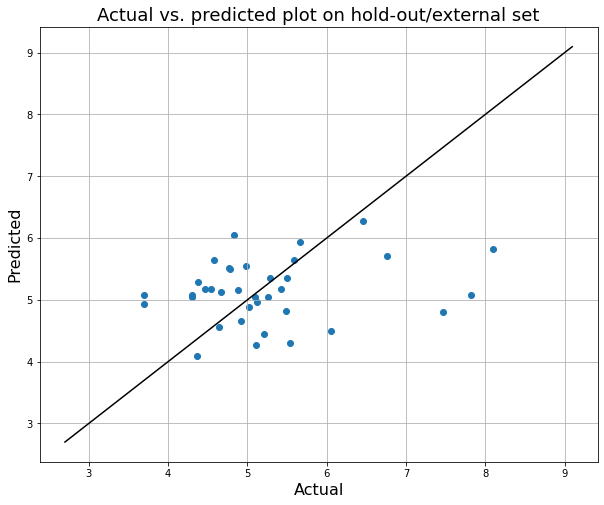

In [64]:
smiles_codes_val = model_wrapper.Data["smiles_codes_val"]
smiles_codes_train = model_wrapper.Data["smiles_codes_train"]
model_wrapper.Pipeline.fit(X=smiles_codes_train, y=None)
X_val = create_molecular_features(pipeline=model_wrapper.Pipeline, smiles_codes=smiles_codes_val)
X_val = process_molecular_features(pipeline=model_wrapper.Pipeline, X=X_val)
y_train_val_pred = model_wrapper.Predict(X_val)
y_train_val = model_wrapper.Data["targets_val"]
plotScatterWithIdeal(y_train_val.values, y_train_val_pred.values, "Actual vs. predicted plot on hold-out/external set")
l.info("R2 score on hold-out/external: %s", r2_score(y_train_val, y_train_val_pred))
l.info("MSE score on hold-out/external: %s", mean_squared_error(y_train_val, y_train_val_pred))
l.info("MAE score on hold-out/external: %s", mean_absolute_error(y_train_val, y_train_val_pred))

# Morgan 1024 regression

## Training

In [11]:
TRAINING_CONFIGURATION_FILE = "Morgan_1024_training_gyrase_regression.json"
with open(PIPELINES_DIR/TRAINING_CONFIGURATION_FILE, "r") as f:
    training_conf = json.load(f)
configuration_train = training_conf["training_aux_data"]

smiles_codes = df[ColumnNames.SMILES_COLUMN.value].copy()
target = df[ColumnNames.TARGET_COLUMN.value].copy()

non_idx = dt.validate_smiles(smiles_codes=smiles_codes)
smiles_codes = smiles_codes.drop(non_idx, axis=0)
target = target.drop(non_idx, axis=0)

pipeline_configuration = dt.read_in_pipeline(pipeline_file=configuration_train["pipeline_file"], 
                                                 pipeline_directory=PIPELINES_DIR)

y_train = dt.process_taget(pipeline_configuration=pipeline_configuration["target_transform"], y=target)
smiles_codes = smiles_codes.loc[y_train.index]

smiles_codes_train, smiles_codes_train_val, y_train, y_train_val = train_test_split(smiles_codes, y_train, test_size=0.1, random_state=42)

prediction_type = "regression"
model_wrapper = mw.model_wrapper.M_XGBoost(prediction_type=prediction_type, pipeline_configuration=pipeline_configuration)
model_wrapper.Data = {"smiles_codes_train": smiles_codes_train, "targets_train": y_train, "smiles_codes_val": smiles_codes_train_val, "targets_val": y_train_val}
model_wrapper.Create_Features()

2022-07-31 08:26:08,917 - logger - INFO - CreateFPS fit...
2022-07-31 08:26:08,918 - logger - INFO - CreateFPS transform...


In [12]:
fmin_objective = partial(model_wrapper.F_Opt, aux_data=configuration_train)
trials = Trials()
rstate = np.random.RandomState(42)
max_evals = configuration_train["max_evals"]
best_hyperparams = fmin(fn=fmin_objective, space=model_wrapper.Space, algo=tpe.suggest, max_evals=max_evals, 
                        trials=trials, return_argmin=True, rstate=rstate, show_progressbar=True)

100%|██████████| 200/200 [12:50<00:00,  3.85s/it, best loss: 0.429320593426761] 


In [13]:
model_wrapper.Save((MODELS_DIR/training_conf["model_storage"]["resulting_model"]).as_posix())

## Results

2022-07-31 08:43:25,843 - logger - INFO - CreateFPS fit...
2022-07-31 08:43:25,845 - logger - INFO - CreateFPS fit...
2022-07-31 08:43:25,846 - logger - INFO - CreateFPS transform...
2022-07-31 08:43:25,984 - logger - INFO - R2 score on hold-out/external: -0.059983026657358884
2022-07-31 08:43:25,985 - logger - INFO - MSE score on hold-out/external: 1.061602145050705
2022-07-31 08:43:25,986 - logger - INFO - MAE score on hold-out/external: 0.6112107530145591


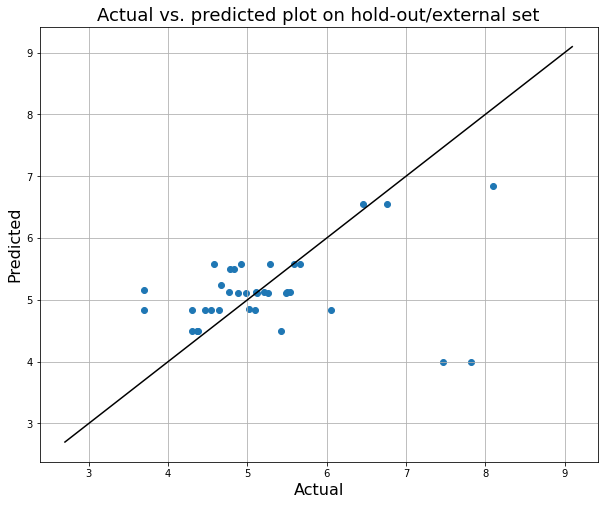

In [14]:
smiles_codes_val = model_wrapper.Data["smiles_codes_val"]
smiles_codes_train = model_wrapper.Data["smiles_codes_train"]
model_wrapper.Pipeline.fit(X=smiles_codes_train, y=None)
X_val = create_molecular_features(pipeline=model_wrapper.Pipeline, smiles_codes=smiles_codes_val)
X_val = process_molecular_features(pipeline=model_wrapper.Pipeline, X=X_val)
y_train_val_pred = model_wrapper.Predict(X_val)
y_train_val = model_wrapper.Data["targets_val"]
plotScatterWithIdeal(y_train_val.values, y_train_val_pred.values, "Actual vs. predicted plot on hold-out/external set")
l.info("R2 score on hold-out/external: %s", r2_score(y_train_val, y_train_val_pred))
l.info("MSE score on hold-out/external: %s", mean_squared_error(y_train_val, y_train_val_pred))
l.info("MAE score on hold-out/external: %s", mean_absolute_error(y_train_val, y_train_val_pred))

# QED, FP/PCA128 classification

## Training

In [50]:
TRAINING_CONFIGURATION_FILE = "QED_FP_PCA128_training_gyrase_classification.json"
with open(PIPELINES_DIR/TRAINING_CONFIGURATION_FILE, "r") as f:
    training_conf = json.load(f)
configuration_train = training_conf["training_aux_data"]

smiles_codes = df[ColumnNames.SMILES_COLUMN.value].copy()
target = df[ColumnNames.TARGET_COLUMN.value].copy()

non_idx = dt.validate_smiles(smiles_codes=smiles_codes)
smiles_codes = smiles_codes.drop(non_idx, axis=0)
target = target.drop(non_idx, axis=0)

pipeline_configuration = dt.read_in_pipeline(pipeline_file=configuration_train["pipeline_file"], 
                                                 pipeline_directory=PIPELINES_DIR)

y_train = dt.process_taget(pipeline_configuration=pipeline_configuration["target_transform"], y=target)
smiles_codes = smiles_codes.loc[y_train.index]

smiles_codes_train, smiles_codes_train_val, y_train, y_train_val = train_test_split(smiles_codes, y_train, test_size=0.1, random_state=42)

prediction_type = "classification"
model_wrapper = mw.model_wrapper.M_XGBoost(prediction_type=prediction_type, pipeline_configuration=pipeline_configuration)
model_wrapper.Data = {"smiles_codes_train": smiles_codes_train, "targets_train": y_train, "smiles_codes_val": smiles_codes_train_val, "targets_val": y_train_val}
model_wrapper.Create_Features()

2022-07-31 10:09:25,338 - logger - INFO - PCA constructor...
2022-07-31 10:09:25,340 - logger - INFO - CreateFPS fit...
2022-07-31 10:09:25,341 - logger - INFO - CreateFPS transform...
100%|██████████| 318/318 [00:01<00:00, 315.47it/s]


<AxesSubplot:>

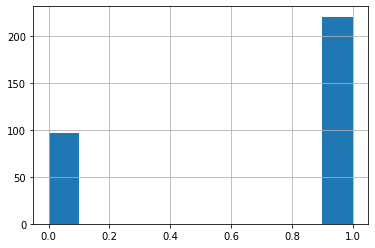

In [51]:
y_train.astype(int).hist()

In [52]:
fmin_objective = partial(model_wrapper.F_Opt, aux_data=configuration_train)
trials = Trials()
rstate = np.random.RandomState(42)
max_evals = configuration_train["max_evals"]
best_hyperparams = fmin(fn=fmin_objective, space=model_wrapper.Space, algo=tpe.suggest, max_evals=max_evals, 
                        trials=trials, return_argmin=True, rstate=rstate, show_progressbar=True)

  0%|          | 0/200 [00:00<?, ?it/s, best loss: ?]

2022-07-31 10:09:42,639 - logger - INFO - Scaler fit...
2022-07-31 10:09:42,751 - logger - INFO - PCA transform...
2022-07-31 10:09:42,776 - logger - INFO - PCA transform...
2022-07-31 10:09:43,402 - logger - INFO - Scaler fit...
2022-07-31 10:09:43,504 - logger - INFO - PCA transform...
2022-07-31 10:09:43,526 - logger - INFO - PCA transform...
2022-07-31 10:09:44,217 - logger - INFO - Scaler fit...
2022-07-31 10:09:44,366 - logger - INFO - PCA transform...
2022-07-31 10:09:44,408 - logger - INFO - PCA transform...
2022-07-31 10:09:44,800 - logger - INFO - Scaler fit...
2022-07-31 10:09:44,950 - logger - INFO - PCA transform...
2022-07-31 10:09:44,991 - logger - INFO - PCA transform...


  0%|          | 1/200 [00:02<09:18,  2.81s/it, best loss: -0.825531914893617]

2022-07-31 10:09:45,437 - logger - INFO - Scaler fit...
2022-07-31 10:09:45,518 - logger - INFO - PCA transform...
2022-07-31 10:09:45,540 - logger - INFO - PCA transform...
2022-07-31 10:09:45,958 - logger - INFO - Scaler fit...
2022-07-31 10:09:46,033 - logger - INFO - PCA transform...
2022-07-31 10:09:46,055 - logger - INFO - PCA transform...
2022-07-31 10:09:46,514 - logger - INFO - Scaler fit...
2022-07-31 10:09:46,591 - logger - INFO - PCA transform...
2022-07-31 10:09:46,617 - logger - INFO - PCA transform...
2022-07-31 10:09:47,198 - logger - INFO - Scaler fit...
2022-07-31 10:09:47,327 - logger - INFO - PCA transform...
2022-07-31 10:09:47,351 - logger - INFO - PCA transform...


  1%|          | 2/200 [00:05<08:32,  2.59s/it, best loss: -0.825531914893617]

2022-07-31 10:09:47,873 - logger - INFO - Scaler fit...
2022-07-31 10:09:48,000 - logger - INFO - PCA transform...
2022-07-31 10:09:48,040 - logger - INFO - PCA transform...
2022-07-31 10:09:48,637 - logger - INFO - Scaler fit...
2022-07-31 10:09:48,714 - logger - INFO - PCA transform...
2022-07-31 10:09:48,736 - logger - INFO - PCA transform...
2022-07-31 10:09:49,451 - logger - INFO - Scaler fit...
2022-07-31 10:09:49,522 - logger - INFO - PCA transform...
2022-07-31 10:09:49,550 - logger - INFO - PCA transform...
2022-07-31 10:09:50,264 - logger - INFO - Scaler fit...
2022-07-31 10:09:50,412 - logger - INFO - PCA transform...
2022-07-31 10:09:50,436 - logger - INFO - PCA transform...


  2%|▏         | 3/200 [00:08<09:13,  2.81s/it, best loss: -0.825531914893617]

2022-07-31 10:09:50,943 - logger - INFO - Scaler fit...
2022-07-31 10:09:51,076 - logger - INFO - PCA transform...
2022-07-31 10:09:51,098 - logger - INFO - PCA transform...
2022-07-31 10:09:51,665 - logger - INFO - Scaler fit...
2022-07-31 10:09:51,758 - logger - INFO - PCA transform...
2022-07-31 10:09:51,781 - logger - INFO - PCA transform...
2022-07-31 10:09:52,630 - logger - INFO - Scaler fit...
2022-07-31 10:09:52,704 - logger - INFO - PCA transform...
2022-07-31 10:09:52,727 - logger - INFO - PCA transform...
2022-07-31 10:09:53,111 - logger - INFO - Scaler fit...
2022-07-31 10:09:53,217 - logger - INFO - PCA transform...
2022-07-31 10:09:53,249 - logger - INFO - PCA transform...


  2%|▏         | 4/200 [00:11<09:11,  2.81s/it, best loss: -0.825531914893617]

2022-07-31 10:09:53,761 - logger - INFO - Scaler fit...
2022-07-31 10:09:53,839 - logger - INFO - PCA transform...
2022-07-31 10:09:53,861 - logger - INFO - PCA transform...
2022-07-31 10:09:54,790 - logger - INFO - Scaler fit...
2022-07-31 10:09:54,900 - logger - INFO - PCA transform...
2022-07-31 10:09:54,921 - logger - INFO - PCA transform...
2022-07-31 10:09:55,520 - logger - INFO - Scaler fit...
2022-07-31 10:09:55,632 - logger - INFO - PCA transform...
2022-07-31 10:09:55,664 - logger - INFO - PCA transform...
2022-07-31 10:09:56,370 - logger - INFO - Scaler fit...
2022-07-31 10:09:56,496 - logger - INFO - PCA transform...
2022-07-31 10:09:56,517 - logger - INFO - PCA transform...


  2%|▎         | 5/200 [00:14<09:47,  3.01s/it, best loss: -0.825531914893617]

2022-07-31 10:09:57,124 - logger - INFO - Scaler fit...
2022-07-31 10:09:57,458 - logger - INFO - PCA transform...
2022-07-31 10:09:57,481 - logger - INFO - PCA transform...
2022-07-31 10:09:57,912 - logger - INFO - Scaler fit...
2022-07-31 10:09:58,016 - logger - INFO - PCA transform...
2022-07-31 10:09:58,038 - logger - INFO - PCA transform...
2022-07-31 10:09:58,450 - logger - INFO - Scaler fit...
2022-07-31 10:09:58,596 - logger - INFO - PCA transform...
2022-07-31 10:09:58,628 - logger - INFO - PCA transform...
2022-07-31 10:09:59,118 - logger - INFO - Scaler fit...
2022-07-31 10:09:59,238 - logger - INFO - PCA transform...
2022-07-31 10:09:59,261 - logger - INFO - PCA transform...


  3%|▎         | 6/200 [00:17<09:15,  2.86s/it, best loss: -0.825531914893617]

2022-07-31 10:09:59,701 - logger - INFO - Scaler fit...
2022-07-31 10:09:59,828 - logger - INFO - PCA transform...
2022-07-31 10:09:59,851 - logger - INFO - PCA transform...
2022-07-31 10:10:00,343 - logger - INFO - Scaler fit...
2022-07-31 10:10:00,435 - logger - INFO - PCA transform...
2022-07-31 10:10:00,457 - logger - INFO - PCA transform...
2022-07-31 10:10:00,804 - logger - INFO - Scaler fit...
2022-07-31 10:10:00,960 - logger - INFO - PCA transform...
2022-07-31 10:10:00,983 - logger - INFO - PCA transform...
2022-07-31 10:10:01,518 - logger - INFO - Scaler fit...
2022-07-31 10:10:01,629 - logger - INFO - PCA transform...
2022-07-31 10:10:01,655 - logger - INFO - PCA transform...


  4%|▎         | 7/200 [00:19<08:50,  2.75s/it, best loss: -0.825531914893617]

2022-07-31 10:10:02,206 - logger - INFO - Scaler fit...
2022-07-31 10:10:02,307 - logger - INFO - PCA transform...
2022-07-31 10:10:02,329 - logger - INFO - PCA transform...
2022-07-31 10:10:02,864 - logger - INFO - Scaler fit...
2022-07-31 10:10:03,004 - logger - INFO - PCA transform...
2022-07-31 10:10:03,027 - logger - INFO - PCA transform...
2022-07-31 10:10:03,687 - logger - INFO - Scaler fit...
2022-07-31 10:10:03,811 - logger - INFO - PCA transform...
2022-07-31 10:10:03,841 - logger - INFO - PCA transform...
2022-07-31 10:10:04,556 - logger - INFO - Scaler fit...
2022-07-31 10:10:04,673 - logger - INFO - PCA transform...
2022-07-31 10:10:04,695 - logger - INFO - PCA transform...


  4%|▍         | 8/200 [00:22<09:04,  2.83s/it, best loss: -0.825531914893617]

2022-07-31 10:10:05,228 - logger - INFO - Scaler fit...
2022-07-31 10:10:05,300 - logger - INFO - PCA transform...
2022-07-31 10:10:05,346 - logger - INFO - PCA transform...
2022-07-31 10:10:06,109 - logger - INFO - Scaler fit...
2022-07-31 10:10:06,203 - logger - INFO - PCA transform...
2022-07-31 10:10:06,226 - logger - INFO - PCA transform...
2022-07-31 10:10:06,972 - logger - INFO - Scaler fit...
2022-07-31 10:10:07,047 - logger - INFO - PCA transform...
2022-07-31 10:10:07,080 - logger - INFO - PCA transform...
2022-07-31 10:10:07,671 - logger - INFO - Scaler fit...
2022-07-31 10:10:07,754 - logger - INFO - PCA transform...
2022-07-31 10:10:07,806 - logger - INFO - PCA transform...


  4%|▍         | 9/200 [00:25<09:29,  2.98s/it, best loss: -0.825531914893617]

2022-07-31 10:10:08,541 - logger - INFO - Scaler fit...
2022-07-31 10:10:08,678 - logger - INFO - PCA transform...
2022-07-31 10:10:08,701 - logger - INFO - PCA transform...
2022-07-31 10:10:09,116 - logger - INFO - Scaler fit...
2022-07-31 10:10:09,319 - logger - INFO - PCA transform...
2022-07-31 10:10:09,343 - logger - INFO - PCA transform...
2022-07-31 10:10:09,773 - logger - INFO - Scaler fit...
2022-07-31 10:10:09,848 - logger - INFO - PCA transform...
2022-07-31 10:10:09,872 - logger - INFO - PCA transform...
2022-07-31 10:10:10,634 - logger - INFO - Scaler fit...
2022-07-31 10:10:10,712 - logger - INFO - PCA transform...
2022-07-31 10:10:10,735 - logger - INFO - PCA transform...


  5%|▌         | 10/200 [00:28<09:18,  2.94s/it, best loss: -0.825531914893617]

2022-07-31 10:10:11,387 - logger - INFO - Scaler fit...
2022-07-31 10:10:11,488 - logger - INFO - PCA transform...
2022-07-31 10:10:11,511 - logger - INFO - PCA transform...
2022-07-31 10:10:11,796 - logger - INFO - Scaler fit...
2022-07-31 10:10:11,896 - logger - INFO - PCA transform...
2022-07-31 10:10:11,918 - logger - INFO - PCA transform...
2022-07-31 10:10:12,365 - logger - INFO - Scaler fit...
2022-07-31 10:10:12,869 - logger - INFO - PCA transform...
2022-07-31 10:10:12,892 - logger - INFO - PCA transform...
2022-07-31 10:10:13,192 - logger - INFO - Scaler fit...
2022-07-31 10:10:13,268 - logger - INFO - PCA transform...
2022-07-31 10:10:13,302 - logger - INFO - PCA transform...


  6%|▌         | 11/200 [00:31<08:44,  2.77s/it, best loss: -0.825531914893617]

/home/rafalb/miniconda3/envs/rorgammaqsar/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

2022-07-31 10:10:13,779 - logger - INFO - Scaler fit...
2022-07-31 10:10:13,877 - logger - INFO - PCA transform...
2022-07-31 10:10:13,899 - logger - INFO - PCA transform...
2022-07-31 10:10:14,918 - logger - INFO - Scaler fit...
2022-07-31 10:10:14,990 - logger - INFO - PCA transform...
2022-07-31 10:10:15,012 - logger - INFO - PCA transform...
2022-07-31 10:10:15,678 - logger - INFO - Scaler fit...
2022-07-31 10:10:15,751 - logger - INFO - PCA transform...
2022-07-31 10:10:15,774 - logger - INFO - PCA transform...
2022-07-31 10:10:16,580 - logger - INFO - Scaler fit...
2022-07-31 10:10:16,685 - logger - INFO - PCA transform...
2022-07-31 10:10:16,706 - logger - INFO -

  6%|▌         | 12/200 [00:34<09:27,  3.02s/it, best loss: -0.825531914893617]

2022-07-31 10:10:17,368 - logger - INFO - Scaler fit...
2022-07-31 10:10:17,469 - logger - INFO - PCA transform...
2022-07-31 10:10:17,491 - logger - INFO - PCA transform...
2022-07-31 10:10:18,406 - logger - INFO - Scaler fit...
2022-07-31 10:10:18,492 - logger - INFO - PCA transform...
2022-07-31 10:10:18,513 - logger - INFO - PCA transform...
2022-07-31 10:10:18,984 - logger - INFO - Scaler fit...
2022-07-31 10:10:19,120 - logger - INFO - PCA transform...
2022-07-31 10:10:19,143 - logger - INFO - PCA transform...
2022-07-31 10:10:19,794 - logger - INFO - Scaler fit...
2022-07-31 10:10:19,881 - logger - INFO - PCA transform...
2022-07-31 10:10:19,904 - logger - INFO - PCA transform...


  6%|▋         | 13/200 [00:37<09:38,  3.09s/it, best loss: -0.825531914893617]

2022-07-31 10:10:20,625 - logger - INFO - Scaler fit...
2022-07-31 10:10:20,741 - logger - INFO - PCA transform...
2022-07-31 10:10:20,764 - logger - INFO - PCA transform...
2022-07-31 10:10:21,218 - logger - INFO - Scaler fit...
2022-07-31 10:10:21,298 - logger - INFO - PCA transform...
2022-07-31 10:10:21,321 - logger - INFO - PCA transform...
2022-07-31 10:10:21,666 - logger - INFO - Scaler fit...
2022-07-31 10:10:21,788 - logger - INFO - PCA transform...
2022-07-31 10:10:21,816 - logger - INFO - PCA transform...
2022-07-31 10:10:22,265 - logger - INFO - Scaler fit...
2022-07-31 10:10:22,364 - logger - INFO - PCA transform...
2022-07-31 10:10:22,386 - logger - INFO - PCA transform...


  7%|▋         | 14/200 [00:40<08:38,  2.79s/it, best loss: -0.825531914893617]

2022-07-31 10:10:22,712 - logger - INFO - Scaler fit...
2022-07-31 10:10:22,794 - logger - INFO - PCA transform...
2022-07-31 10:10:22,833 - logger - INFO - PCA transform...
2022-07-31 10:10:23,399 - logger - INFO - Scaler fit...
2022-07-31 10:10:23,483 - logger - INFO - PCA transform...
2022-07-31 10:10:23,505 - logger - INFO - PCA transform...
2022-07-31 10:10:24,290 - logger - INFO - Scaler fit...
2022-07-31 10:10:24,385 - logger - INFO - PCA transform...
2022-07-31 10:10:24,407 - logger - INFO - PCA transform...
2022-07-31 10:10:24,957 - logger - INFO - Scaler fit...
2022-07-31 10:10:25,110 - logger - INFO - PCA transform...
2022-07-31 10:10:25,133 - logger - INFO - PCA transform...


  8%|▊         | 15/200 [00:43<08:57,  2.90s/it, best loss: -0.825531914893617]

2022-07-31 10:10:25,883 - logger - INFO - Scaler fit...
2022-07-31 10:10:25,979 - logger - INFO - PCA transform...
2022-07-31 10:10:26,001 - logger - INFO - PCA transform...
2022-07-31 10:10:26,598 - logger - INFO - Scaler fit...
2022-07-31 10:10:26,692 - logger - INFO - PCA transform...
2022-07-31 10:10:26,714 - logger - INFO - PCA transform...
2022-07-31 10:10:27,259 - logger - INFO - Scaler fit...
2022-07-31 10:10:27,356 - logger - INFO - PCA transform...
2022-07-31 10:10:27,378 - logger - INFO - PCA transform...
2022-07-31 10:10:28,103 - logger - INFO - Scaler fit...
2022-07-31 10:10:28,183 - logger - INFO - PCA transform...
2022-07-31 10:10:28,205 - logger - INFO - PCA transform...


  8%|▊         | 16/200 [00:46<08:56,  2.91s/it, best loss: -0.825531914893617]

2022-07-31 10:10:28,822 - logger - INFO - Scaler fit...
2022-07-31 10:10:28,903 - logger - INFO - PCA transform...
2022-07-31 10:10:28,932 - logger - INFO - PCA transform...
2022-07-31 10:10:29,711 - logger - INFO - Scaler fit...
2022-07-31 10:10:29,782 - logger - INFO - PCA transform...
2022-07-31 10:10:29,805 - logger - INFO - PCA transform...
2022-07-31 10:10:30,915 - logger - INFO - Scaler fit...
2022-07-31 10:10:31,042 - logger - INFO - PCA transform...
2022-07-31 10:10:31,064 - logger - INFO - PCA transform...
2022-07-31 10:10:31,911 - logger - INFO - Scaler fit...
2022-07-31 10:10:32,015 - logger - INFO - PCA transform...
2022-07-31 10:10:32,036 - logger - INFO - PCA transform...


  8%|▊         | 17/200 [00:50<09:50,  3.23s/it, best loss: -0.825531914893617]

2022-07-31 10:10:32,773 - logger - INFO - Scaler fit...
2022-07-31 10:10:32,881 - logger - INFO - PCA transform...
2022-07-31 10:10:32,903 - logger - INFO - PCA transform...
2022-07-31 10:10:33,571 - logger - INFO - Scaler fit...
2022-07-31 10:10:33,680 - logger - INFO - PCA transform...
2022-07-31 10:10:33,702 - logger - INFO - PCA transform...
2022-07-31 10:10:34,441 - logger - INFO - Scaler fit...
2022-07-31 10:10:34,542 - logger - INFO - PCA transform...
2022-07-31 10:10:34,564 - logger - INFO - PCA transform...
2022-07-31 10:10:35,430 - logger - INFO - Scaler fit...
2022-07-31 10:10:35,564 - logger - INFO - PCA transform...
2022-07-31 10:10:35,587 - logger - INFO - PCA transform...


  9%|▉         | 18/200 [00:53<09:54,  3.27s/it, best loss: -0.825531914893617]

2022-07-31 10:10:36,129 - logger - INFO - Scaler fit...
2022-07-31 10:10:36,254 - logger - INFO - PCA transform...
2022-07-31 10:10:36,290 - logger - INFO - PCA transform...
2022-07-31 10:10:36,811 - logger - INFO - Scaler fit...
2022-07-31 10:10:36,916 - logger - INFO - PCA transform...
2022-07-31 10:10:36,939 - logger - INFO - PCA transform...
2022-07-31 10:10:37,333 - logger - INFO - Scaler fit...
2022-07-31 10:10:37,439 - logger - INFO - PCA transform...
2022-07-31 10:10:37,462 - logger - INFO - PCA transform...
2022-07-31 10:10:37,967 - logger - INFO - Scaler fit...
2022-07-31 10:10:38,072 - logger - INFO - PCA transform...
2022-07-31 10:10:38,094 - logger - INFO - PCA transform...


 10%|▉         | 19/200 [00:55<09:00,  2.99s/it, best loss: -0.825531914893617]

2022-07-31 10:10:38,469 - logger - INFO - Scaler fit...
2022-07-31 10:10:38,540 - logger - INFO - PCA transform...
2022-07-31 10:10:38,569 - logger - INFO - PCA transform...
2022-07-31 10:10:38,959 - logger - INFO - Scaler fit...
2022-07-31 10:10:39,034 - logger - INFO - PCA transform...
2022-07-31 10:10:39,057 - logger - INFO - PCA transform...
2022-07-31 10:10:39,329 - logger - INFO - Scaler fit...
2022-07-31 10:10:39,444 - logger - INFO - PCA transform...
2022-07-31 10:10:39,466 - logger - INFO - PCA transform...
2022-07-31 10:10:39,827 - logger - INFO - Scaler fit...
2022-07-31 10:10:39,924 - logger - INFO - PCA transform...
2022-07-31 10:10:39,946 - logger - INFO - PCA transform...


 10%|█         | 20/200 [00:57<07:59,  2.67s/it, best loss: -0.825531914893617]

2022-07-31 10:10:40,398 - logger - INFO - Scaler fit...
2022-07-31 10:10:40,471 - logger - INFO - PCA transform...
2022-07-31 10:10:40,494 - logger - INFO - PCA transform...
2022-07-31 10:10:40,832 - logger - INFO - Scaler fit...
2022-07-31 10:10:40,912 - logger - INFO - PCA transform...
2022-07-31 10:10:40,934 - logger - INFO - PCA transform...
2022-07-31 10:10:41,478 - logger - INFO - Scaler fit...
2022-07-31 10:10:41,581 - logger - INFO - PCA transform...
2022-07-31 10:10:41,604 - logger - INFO - PCA transform...
2022-07-31 10:10:41,937 - logger - INFO - Scaler fit...
2022-07-31 10:10:42,055 - logger - INFO - PCA transform...
2022-07-31 10:10:42,079 - logger - INFO - PCA transform...


 10%|█         | 21/200 [00:59<07:24,  2.49s/it, best loss: -0.825531914893617]

2022-07-31 10:10:42,462 - logger - INFO - Scaler fit...
2022-07-31 10:10:42,591 - logger - INFO - PCA transform...
2022-07-31 10:10:42,614 - logger - INFO - PCA transform...
2022-07-31 10:10:43,058 - logger - INFO - Scaler fit...
2022-07-31 10:10:43,155 - logger - INFO - PCA transform...
2022-07-31 10:10:43,198 - logger - INFO - PCA transform...
2022-07-31 10:10:43,491 - logger - INFO - Scaler fit...
2022-07-31 10:10:43,567 - logger - INFO - PCA transform...
2022-07-31 10:10:43,602 - logger - INFO - PCA transform...
2022-07-31 10:10:44,055 - logger - INFO - Scaler fit...
2022-07-31 10:10:44,154 - logger - INFO - PCA transform...
2022-07-31 10:10:44,177 - logger - INFO - PCA transform...


 11%|█         | 22/200 [01:01<06:58,  2.35s/it, best loss: -0.825531914893617]

2022-07-31 10:10:44,500 - logger - INFO - Scaler fit...
2022-07-31 10:10:44,610 - logger - INFO - PCA transform...
2022-07-31 10:10:44,635 - logger - INFO - PCA transform...
2022-07-31 10:10:45,625 - logger - INFO - Scaler fit...
2022-07-31 10:10:45,728 - logger - INFO - PCA transform...
2022-07-31 10:10:45,749 - logger - INFO - PCA transform...
2022-07-31 10:10:46,475 - logger - INFO - Scaler fit...
2022-07-31 10:10:46,586 - logger - INFO - PCA transform...
2022-07-31 10:10:46,608 - logger - INFO - PCA transform...
2022-07-31 10:10:47,650 - logger - INFO - Scaler fit...
2022-07-31 10:10:47,768 - logger - INFO - PCA transform...
2022-07-31 10:10:47,790 - logger - INFO - PCA transform...


 12%|█▏        | 23/200 [01:06<08:37,  2.92s/it, best loss: -0.825531914893617]

2022-07-31 10:10:48,756 - logger - INFO - Scaler fit...
2022-07-31 10:10:48,909 - logger - INFO - PCA transform...
2022-07-31 10:10:48,931 - logger - INFO - PCA transform...
2022-07-31 10:10:49,533 - logger - INFO - Scaler fit...
2022-07-31 10:10:49,626 - logger - INFO - PCA transform...
2022-07-31 10:10:49,648 - logger - INFO - PCA transform...
2022-07-31 10:10:50,096 - logger - INFO - Scaler fit...
2022-07-31 10:10:50,190 - logger - INFO - PCA transform...
2022-07-31 10:10:50,214 - logger - INFO - PCA transform...
2022-07-31 10:10:50,826 - logger - INFO - Scaler fit...
2022-07-31 10:10:50,905 - logger - INFO - PCA transform...
2022-07-31 10:10:50,928 - logger - INFO - PCA transform...


 12%|█▏        | 24/200 [01:08<08:22,  2.85s/it, best loss: -0.825531914893617]

2022-07-31 10:10:51,450 - logger - INFO - Scaler fit...
2022-07-31 10:10:51,546 - logger - INFO - PCA transform...
2022-07-31 10:10:51,569 - logger - INFO - PCA transform...
2022-07-31 10:10:52,027 - logger - INFO - Scaler fit...
2022-07-31 10:10:52,103 - logger - INFO - PCA transform...
2022-07-31 10:10:52,126 - logger - INFO - PCA transform...
2022-07-31 10:10:52,544 - logger - INFO - Scaler fit...
2022-07-31 10:10:52,617 - logger - INFO - PCA transform...
2022-07-31 10:10:52,640 - logger - INFO - PCA transform...
2022-07-31 10:10:52,888 - logger - INFO - Scaler fit...
2022-07-31 10:10:52,975 - logger - INFO - PCA transform...
2022-07-31 10:10:53,001 - logger - INFO - PCA transform...


 12%|█▎        | 25/200 [01:10<07:35,  2.61s/it, best loss: -0.825531914893617]

2022-07-31 10:10:53,477 - logger - INFO - Scaler fit...
2022-07-31 10:10:53,550 - logger - INFO - PCA transform...
2022-07-31 10:10:53,573 - logger - INFO - PCA transform...
2022-07-31 10:10:54,042 - logger - INFO - Scaler fit...
2022-07-31 10:10:54,119 - logger - INFO - PCA transform...
2022-07-31 10:10:54,141 - logger - INFO - PCA transform...
2022-07-31 10:10:54,553 - logger - INFO - Scaler fit...
2022-07-31 10:10:54,628 - logger - INFO - PCA transform...
2022-07-31 10:10:54,651 - logger - INFO - PCA transform...
2022-07-31 10:10:55,172 - logger - INFO - Scaler fit...
2022-07-31 10:10:55,330 - logger - INFO - PCA transform...
2022-07-31 10:10:55,362 - logger - INFO - PCA transform...


 13%|█▎        | 26/200 [01:13<07:17,  2.51s/it, best loss: -0.825531914893617]

2022-07-31 10:10:55,779 - logger - INFO - Scaler fit...
2022-07-31 10:10:55,916 - logger - INFO - PCA transform...
2022-07-31 10:10:55,951 - logger - INFO - PCA transform...
2022-07-31 10:10:56,338 - logger - INFO - Scaler fit...
2022-07-31 10:10:56,675 - logger - INFO - PCA transform...
2022-07-31 10:10:56,698 - logger - INFO - PCA transform...
2022-07-31 10:10:57,128 - logger - INFO - Scaler fit...
2022-07-31 10:10:57,234 - logger - INFO - PCA transform...
2022-07-31 10:10:57,258 - logger - INFO - PCA transform...
2022-07-31 10:10:57,690 - logger - INFO - Scaler fit...
2022-07-31 10:10:57,788 - logger - INFO - PCA transform...
2022-07-31 10:10:57,810 - logger - INFO - PCA transform...


 14%|█▎        | 27/200 [01:15<07:24,  2.57s/it, best loss: -0.825531914893617]

2022-07-31 10:10:58,470 - logger - INFO - Scaler fit...
2022-07-31 10:10:58,565 - logger - INFO - PCA transform...
2022-07-31 10:10:58,587 - logger - INFO - PCA transform...
2022-07-31 10:10:59,686 - logger - INFO - Scaler fit...
2022-07-31 10:10:59,765 - logger - INFO - PCA transform...
2022-07-31 10:10:59,788 - logger - INFO - PCA transform...
2022-07-31 10:11:01,100 - logger - INFO - Scaler fit...
2022-07-31 10:11:01,178 - logger - INFO - PCA transform...
2022-07-31 10:11:01,200 - logger - INFO - PCA transform...
2022-07-31 10:11:02,448 - logger - INFO - Scaler fit...
2022-07-31 10:11:02,554 - logger - INFO - PCA transform...
2022-07-31 10:11:02,576 - logger - INFO - PCA transform...


 14%|█▍        | 28/200 [01:21<09:44,  3.40s/it, best loss: -0.825531914893617]

2022-07-31 10:11:03,806 - logger - INFO - Scaler fit...
2022-07-31 10:11:03,940 - logger - INFO - PCA transform...
2022-07-31 10:11:03,965 - logger - INFO - PCA transform...
2022-07-31 10:11:04,525 - logger - INFO - Scaler fit...
2022-07-31 10:11:04,600 - logger - INFO - PCA transform...
2022-07-31 10:11:04,623 - logger - INFO - PCA transform...
2022-07-31 10:11:05,353 - logger - INFO - Scaler fit...
2022-07-31 10:11:05,457 - logger - INFO - PCA transform...
2022-07-31 10:11:05,478 - logger - INFO - PCA transform...
2022-07-31 10:11:05,867 - logger - INFO - Scaler fit...
2022-07-31 10:11:05,970 - logger - INFO - PCA transform...
2022-07-31 10:11:06,002 - logger - INFO - PCA transform...


 14%|█▍        | 29/200 [01:23<09:07,  3.20s/it, best loss: -0.825531914893617]

2022-07-31 10:11:06,547 - logger - INFO - Scaler fit...
2022-07-31 10:11:06,630 - logger - INFO - PCA transform...
2022-07-31 10:11:06,652 - logger - INFO - PCA transform...
2022-07-31 10:11:07,271 - logger - INFO - Scaler fit...
2022-07-31 10:11:07,375 - logger - INFO - PCA transform...
2022-07-31 10:11:07,397 - logger - INFO - PCA transform...
2022-07-31 10:11:07,964 - logger - INFO - Scaler fit...
2022-07-31 10:11:08,060 - logger - INFO - PCA transform...
2022-07-31 10:11:08,082 - logger - INFO - PCA transform...
2022-07-31 10:11:08,643 - logger - INFO - Scaler fit...
2022-07-31 10:11:08,752 - logger - INFO - PCA transform...
2022-07-31 10:11:08,775 - logger - INFO - PCA transform...


 15%|█▌        | 30/200 [01:26<08:56,  3.16s/it, best loss: -0.825531914893617]

2022-07-31 10:11:09,603 - logger - INFO - Scaler fit...
2022-07-31 10:11:09,706 - logger - INFO - PCA transform...
2022-07-31 10:11:09,729 - logger - INFO - PCA transform...
2022-07-31 10:11:10,381 - logger - INFO - Scaler fit...
2022-07-31 10:11:10,457 - logger - INFO - PCA transform...
2022-07-31 10:11:10,480 - logger - INFO - PCA transform...
2022-07-31 10:11:11,105 - logger - INFO - Scaler fit...
2022-07-31 10:11:11,211 - logger - INFO - PCA transform...
2022-07-31 10:11:11,233 - logger - INFO - PCA transform...
2022-07-31 10:11:11,903 - logger - INFO - Scaler fit...
2022-07-31 10:11:12,021 - logger - INFO - PCA transform...
2022-07-31 10:11:12,043 - logger - INFO - PCA transform...


 16%|█▌        | 31/200 [01:29<08:42,  3.09s/it, best loss: -0.825531914893617]

2022-07-31 10:11:12,539 - logger - INFO - Scaler fit...
2022-07-31 10:11:12,709 - logger - INFO - PCA transform...
2022-07-31 10:11:12,751 - logger - INFO - PCA transform...
2022-07-31 10:11:13,309 - logger - INFO - Scaler fit...
2022-07-31 10:11:13,427 - logger - INFO - PCA transform...
2022-07-31 10:11:13,449 - logger - INFO - PCA transform...
2022-07-31 10:11:13,763 - logger - INFO - Scaler fit...
2022-07-31 10:11:13,903 - logger - INFO - PCA transform...
2022-07-31 10:11:13,926 - logger - INFO - PCA transform...
2022-07-31 10:11:14,338 - logger - INFO - Scaler fit...
2022-07-31 10:11:14,436 - logger - INFO - PCA transform...
2022-07-31 10:11:14,457 - logger - INFO - PCA transform...


 16%|█▌        | 32/200 [01:32<08:00,  2.86s/it, best loss: -0.825531914893617]

2022-07-31 10:11:14,864 - logger - INFO - Scaler fit...
2022-07-31 10:11:14,942 - logger - INFO - PCA transform...
2022-07-31 10:11:14,965 - logger - INFO - PCA transform...
2022-07-31 10:11:15,684 - logger - INFO - Scaler fit...
2022-07-31 10:11:15,822 - logger - INFO - PCA transform...
2022-07-31 10:11:15,845 - logger - INFO - PCA transform...
2022-07-31 10:11:16,212 - logger - INFO - Scaler fit...
2022-07-31 10:11:16,416 - logger - INFO - PCA transform...
2022-07-31 10:11:16,439 - logger - INFO - PCA transform...
2022-07-31 10:11:16,836 - logger - INFO - Scaler fit...
2022-07-31 10:11:16,912 - logger - INFO - PCA transform...
2022-07-31 10:11:16,935 - logger - INFO - PCA transform...


 16%|█▋        | 33/200 [01:34<07:49,  2.81s/it, best loss: -0.8271028037383178]

2022-07-31 10:11:17,554 - logger - INFO - Scaler fit...
2022-07-31 10:11:17,688 - logger - INFO - PCA transform...
2022-07-31 10:11:17,720 - logger - INFO - PCA transform...
2022-07-31 10:11:18,205 - logger - INFO - Scaler fit...
2022-07-31 10:11:18,286 - logger - INFO - PCA transform...
2022-07-31 10:11:18,307 - logger - INFO - PCA transform...
2022-07-31 10:11:18,602 - logger - INFO - Scaler fit...
2022-07-31 10:11:18,733 - logger - INFO - PCA transform...
2022-07-31 10:11:18,755 - logger - INFO - PCA transform...
2022-07-31 10:11:19,085 - logger - INFO - Scaler fit...
2022-07-31 10:11:19,199 - logger - INFO - PCA transform...
2022-07-31 10:11:19,221 - logger - INFO - PCA transform...


 17%|█▋        | 34/200 [01:37<07:21,  2.66s/it, best loss: -0.8271028037383178]

2022-07-31 10:11:19,865 - logger - INFO - Scaler fit...
2022-07-31 10:11:20,013 - logger - INFO - PCA transform...
2022-07-31 10:11:20,033 - logger - INFO - PCA transform...
2022-07-31 10:11:20,531 - logger - INFO - Scaler fit...
2022-07-31 10:11:20,600 - logger - INFO - PCA transform...
2022-07-31 10:11:20,632 - logger - INFO - PCA transform...
2022-07-31 10:11:21,141 - logger - INFO - Scaler fit...
2022-07-31 10:11:21,239 - logger - INFO - PCA transform...
2022-07-31 10:11:21,261 - logger - INFO - PCA transform...
2022-07-31 10:11:21,515 - logger - INFO - Scaler fit...
2022-07-31 10:11:21,598 - logger - INFO - PCA transform...
2022-07-31 10:11:21,620 - logger - INFO - PCA transform...


 18%|█▊        | 35/200 [01:39<07:06,  2.58s/it, best loss: -0.8271028037383178]

2022-07-31 10:11:22,264 - logger - INFO - Scaler fit...
2022-07-31 10:11:22,364 - logger - INFO - PCA transform...
2022-07-31 10:11:22,386 - logger - INFO - PCA transform...
2022-07-31 10:11:22,719 - logger - INFO - Scaler fit...
2022-07-31 10:11:22,820 - logger - INFO - PCA transform...
2022-07-31 10:11:22,841 - logger - INFO - PCA transform...
2022-07-31 10:11:23,334 - logger - INFO - Scaler fit...
2022-07-31 10:11:23,435 - logger - INFO - PCA transform...
2022-07-31 10:11:23,463 - logger - INFO - PCA transform...
2022-07-31 10:11:23,793 - logger - INFO - Scaler fit...
2022-07-31 10:11:23,867 - logger - INFO - PCA transform...
2022-07-31 10:11:23,889 - logger - INFO - PCA transform...


 18%|█▊        | 36/200 [01:41<06:44,  2.47s/it, best loss: -0.8271028037383178]

2022-07-31 10:11:24,465 - logger - INFO - Scaler fit...
2022-07-31 10:11:24,595 - logger - INFO - PCA transform...
2022-07-31 10:11:24,617 - logger - INFO - PCA transform...
2022-07-31 10:11:24,917 - logger - INFO - Scaler fit...
2022-07-31 10:11:24,987 - logger - INFO - PCA transform...
2022-07-31 10:11:25,030 - logger - INFO - PCA transform...
2022-07-31 10:11:25,527 - logger - INFO - Scaler fit...
2022-07-31 10:11:25,618 - logger - INFO - PCA transform...
2022-07-31 10:11:25,648 - logger - INFO - PCA transform...
2022-07-31 10:11:26,151 - logger - INFO - Scaler fit...
2022-07-31 10:11:26,223 - logger - INFO - PCA transform...
2022-07-31 10:11:26,248 - logger - INFO - PCA transform...


 18%|█▊        | 37/200 [01:43<06:23,  2.35s/it, best loss: -0.8271028037383178]

2022-07-31 10:11:26,552 - logger - INFO - Scaler fit...
2022-07-31 10:11:26,809 - logger - INFO - PCA transform...
2022-07-31 10:11:26,833 - logger - INFO - PCA transform...
2022-07-31 10:11:27,497 - logger - INFO - Scaler fit...
2022-07-31 10:11:27,571 - logger - INFO - PCA transform...
2022-07-31 10:11:27,593 - logger - INFO - PCA transform...
2022-07-31 10:11:27,949 - logger - INFO - Scaler fit...
2022-07-31 10:11:28,070 - logger - INFO - PCA transform...
2022-07-31 10:11:28,093 - logger - INFO - PCA transform...
2022-07-31 10:11:28,543 - logger - INFO - Scaler fit...
2022-07-31 10:11:28,625 - logger - INFO - PCA transform...
2022-07-31 10:11:28,647 - logger - INFO - PCA transform...


 19%|█▉        | 38/200 [01:46<06:25,  2.38s/it, best loss: -0.8271028037383178]

2022-07-31 10:11:28,998 - logger - INFO - Scaler fit...
2022-07-31 10:11:29,077 - logger - INFO - PCA transform...
2022-07-31 10:11:29,099 - logger - INFO - PCA transform...
2022-07-31 10:11:29,563 - logger - INFO - Scaler fit...
2022-07-31 10:11:29,660 - logger - INFO - PCA transform...
2022-07-31 10:11:29,682 - logger - INFO - PCA transform...
2022-07-31 10:11:30,188 - logger - INFO - Scaler fit...
2022-07-31 10:11:30,264 - logger - INFO - PCA transform...
2022-07-31 10:11:30,286 - logger - INFO - PCA transform...
2022-07-31 10:11:30,601 - logger - INFO - Scaler fit...
2022-07-31 10:11:30,714 - logger - INFO - PCA transform...
2022-07-31 10:11:30,735 - logger - INFO - PCA transform...


 20%|█▉        | 39/200 [01:48<06:17,  2.34s/it, best loss: -0.8271028037383178]

2022-07-31 10:11:31,260 - logger - INFO - Scaler fit...
2022-07-31 10:11:31,405 - logger - INFO - PCA transform...
2022-07-31 10:11:31,427 - logger - INFO - PCA transform...
2022-07-31 10:11:32,008 - logger - INFO - Scaler fit...
2022-07-31 10:11:32,294 - logger - INFO - PCA transform...
2022-07-31 10:11:32,317 - logger - INFO - PCA transform...
2022-07-31 10:11:32,728 - logger - INFO - Scaler fit...
2022-07-31 10:11:32,808 - logger - INFO - PCA transform...
2022-07-31 10:11:32,840 - logger - INFO - PCA transform...
2022-07-31 10:11:33,182 - logger - INFO - Scaler fit...
2022-07-31 10:11:33,290 - logger - INFO - PCA transform...
2022-07-31 10:11:33,312 - logger - INFO - PCA transform...


 20%|██        | 40/200 [01:51<06:34,  2.47s/it, best loss: -0.8271028037383178]

2022-07-31 10:11:34,014 - logger - INFO - Scaler fit...
2022-07-31 10:11:34,144 - logger - INFO - PCA transform...
2022-07-31 10:11:34,173 - logger - INFO - PCA transform...
2022-07-31 10:11:34,764 - logger - INFO - Scaler fit...
2022-07-31 10:11:34,860 - logger - INFO - PCA transform...
2022-07-31 10:11:34,883 - logger - INFO - PCA transform...
2022-07-31 10:11:35,475 - logger - INFO - Scaler fit...
2022-07-31 10:11:35,580 - logger - INFO - PCA transform...
2022-07-31 10:11:35,603 - logger - INFO - PCA transform...
2022-07-31 10:11:36,223 - logger - INFO - Scaler fit...
2022-07-31 10:11:36,355 - logger - INFO - PCA transform...
2022-07-31 10:11:36,377 - logger - INFO - PCA transform...


 20%|██        | 41/200 [01:54<06:59,  2.64s/it, best loss: -0.8271028037383178]

2022-07-31 10:11:37,048 - logger - INFO - Scaler fit...
2022-07-31 10:11:37,186 - logger - INFO - PCA transform...
2022-07-31 10:11:37,208 - logger - INFO - PCA transform...
2022-07-31 10:11:37,629 - logger - INFO - Scaler fit...
2022-07-31 10:11:37,730 - logger - INFO - PCA transform...
2022-07-31 10:11:37,753 - logger - INFO - PCA transform...
2022-07-31 10:11:38,235 - logger - INFO - Scaler fit...
2022-07-31 10:11:38,308 - logger - INFO - PCA transform...
2022-07-31 10:11:38,335 - logger - INFO - PCA transform...
2022-07-31 10:11:38,617 - logger - INFO - Scaler fit...
2022-07-31 10:11:38,758 - logger - INFO - PCA transform...
2022-07-31 10:11:38,785 - logger - INFO - PCA transform...


 21%|██        | 42/200 [01:56<06:34,  2.50s/it, best loss: -0.8271028037383178]

2022-07-31 10:11:39,215 - logger - INFO - Scaler fit...
2022-07-31 10:11:39,373 - logger - INFO - PCA transform...
2022-07-31 10:11:39,395 - logger - INFO - PCA transform...
2022-07-31 10:11:39,962 - logger - INFO - Scaler fit...
2022-07-31 10:11:40,069 - logger - INFO - PCA transform...
2022-07-31 10:11:40,092 - logger - INFO - PCA transform...
2022-07-31 10:11:40,443 - logger - INFO - Scaler fit...
2022-07-31 10:11:40,560 - logger - INFO - PCA transform...
2022-07-31 10:11:40,582 - logger - INFO - PCA transform...
2022-07-31 10:11:41,045 - logger - INFO - Scaler fit...
2022-07-31 10:11:41,132 - logger - INFO - PCA transform...
2022-07-31 10:11:41,156 - logger - INFO - PCA transform...


 22%|██▏       | 43/200 [01:58<06:23,  2.44s/it, best loss: -0.8271028037383178]

2022-07-31 10:11:41,529 - logger - INFO - Scaler fit...
2022-07-31 10:11:41,761 - logger - INFO - PCA transform...
2022-07-31 10:11:41,784 - logger - INFO - PCA transform...
2022-07-31 10:11:42,222 - logger - INFO - Scaler fit...
2022-07-31 10:11:42,344 - logger - INFO - PCA transform...
2022-07-31 10:11:42,369 - logger - INFO - PCA transform...
2022-07-31 10:11:42,880 - logger - INFO - Scaler fit...
2022-07-31 10:11:42,979 - logger - INFO - PCA transform...
2022-07-31 10:11:43,001 - logger - INFO - PCA transform...
2022-07-31 10:11:43,717 - logger - INFO - Scaler fit...
2022-07-31 10:11:43,810 - logger - INFO - PCA transform...
2022-07-31 10:11:43,832 - logger - INFO - PCA transform...


 22%|██▏       | 44/200 [02:01<06:38,  2.55s/it, best loss: -0.8271028037383178]

2022-07-31 10:11:44,350 - logger - INFO - Scaler fit...
2022-07-31 10:11:44,482 - logger - INFO - PCA transform...
2022-07-31 10:11:44,503 - logger - INFO - PCA transform...
2022-07-31 10:11:45,005 - logger - INFO - Scaler fit...
2022-07-31 10:11:45,102 - logger - INFO - PCA transform...
2022-07-31 10:11:45,124 - logger - INFO - PCA transform...
2022-07-31 10:11:45,388 - logger - INFO - Scaler fit...
2022-07-31 10:11:45,540 - logger - INFO - PCA transform...
2022-07-31 10:11:45,565 - logger - INFO - PCA transform...
2022-07-31 10:11:46,142 - logger - INFO - Scaler fit...
2022-07-31 10:11:46,243 - logger - INFO - PCA transform...
2022-07-31 10:11:46,265 - logger - INFO - PCA transform...


 22%|██▎       | 45/200 [02:03<06:21,  2.46s/it, best loss: -0.8271028037383178]

2022-07-31 10:11:46,580 - logger - INFO - Scaler fit...
2022-07-31 10:11:46,675 - logger - INFO - PCA transform...
2022-07-31 10:11:46,697 - logger - INFO - PCA transform...
2022-07-31 10:11:47,439 - logger - INFO - Scaler fit...
2022-07-31 10:11:47,512 - logger - INFO - PCA transform...
2022-07-31 10:11:47,538 - logger - INFO - PCA transform...
2022-07-31 10:11:48,077 - logger - INFO - Scaler fit...
2022-07-31 10:11:48,172 - logger - INFO - PCA transform...
2022-07-31 10:11:48,193 - logger - INFO - PCA transform...
2022-07-31 10:11:48,833 - logger - INFO - Scaler fit...
2022-07-31 10:11:48,905 - logger - INFO - PCA transform...
2022-07-31 10:11:48,927 - logger - INFO - PCA transform...


 23%|██▎       | 46/200 [02:06<06:40,  2.60s/it, best loss: -0.8305084745762712]

2022-07-31 10:11:49,502 - logger - INFO - Scaler fit...
2022-07-31 10:11:49,638 - logger - INFO - PCA transform...
2022-07-31 10:11:49,664 - logger - INFO - PCA transform...
2022-07-31 10:11:50,372 - logger - INFO - Scaler fit...
2022-07-31 10:11:50,466 - logger - INFO - PCA transform...
2022-07-31 10:11:50,488 - logger - INFO - PCA transform...
2022-07-31 10:11:50,966 - logger - INFO - Scaler fit...
2022-07-31 10:11:51,061 - logger - INFO - PCA transform...
2022-07-31 10:11:51,086 - logger - INFO - PCA transform...
2022-07-31 10:11:51,675 - logger - INFO - Scaler fit...
2022-07-31 10:11:51,779 - logger - INFO - PCA transform...
2022-07-31 10:11:51,801 - logger - INFO - PCA transform...


 24%|██▎       | 47/200 [02:09<06:47,  2.66s/it, best loss: -0.8305084745762712]

2022-07-31 10:11:52,311 - logger - INFO - Scaler fit...
2022-07-31 10:11:52,720 - logger - INFO - PCA transform...
2022-07-31 10:11:52,741 - logger - INFO - PCA transform...
2022-07-31 10:11:53,223 - logger - INFO - Scaler fit...
2022-07-31 10:11:53,296 - logger - INFO - PCA transform...
2022-07-31 10:11:53,328 - logger - INFO - PCA transform...
2022-07-31 10:11:53,897 - logger - INFO - Scaler fit...
2022-07-31 10:11:53,991 - logger - INFO - PCA transform...
2022-07-31 10:11:54,014 - logger - INFO - PCA transform...
2022-07-31 10:11:54,669 - logger - INFO - Scaler fit...
2022-07-31 10:11:54,772 - logger - INFO - PCA transform...
2022-07-31 10:11:54,794 - logger - INFO - PCA transform...


 24%|██▍       | 48/200 [02:12<07:00,  2.77s/it, best loss: -0.8305084745762712]

2022-07-31 10:11:55,320 - logger - INFO - Scaler fit...
2022-07-31 10:11:55,456 - logger - INFO - PCA transform...
2022-07-31 10:11:55,477 - logger - INFO - PCA transform...
2022-07-31 10:11:56,050 - logger - INFO - Scaler fit...
2022-07-31 10:11:56,178 - logger - INFO - PCA transform...
2022-07-31 10:11:56,200 - logger - INFO - PCA transform...
2022-07-31 10:11:56,740 - logger - INFO - Scaler fit...
2022-07-31 10:11:56,859 - logger - INFO - PCA transform...
2022-07-31 10:11:56,880 - logger - INFO - PCA transform...
2022-07-31 10:11:57,325 - logger - INFO - Scaler fit...
2022-07-31 10:11:57,438 - logger - INFO - PCA transform...
2022-07-31 10:11:57,460 - logger - INFO - PCA transform...


 24%|██▍       | 49/200 [02:15<06:58,  2.77s/it, best loss: -0.8305084745762712]

2022-07-31 10:11:58,115 - logger - INFO - Scaler fit...
2022-07-31 10:11:58,233 - logger - INFO - PCA transform...
2022-07-31 10:11:58,255 - logger - INFO - PCA transform...
2022-07-31 10:11:58,766 - logger - INFO - Scaler fit...
2022-07-31 10:11:58,856 - logger - INFO - PCA transform...
2022-07-31 10:11:58,878 - logger - INFO - PCA transform...
2022-07-31 10:11:59,655 - logger - INFO - Scaler fit...
2022-07-31 10:11:59,746 - logger - INFO - PCA transform...
2022-07-31 10:11:59,767 - logger - INFO - PCA transform...
2022-07-31 10:12:00,286 - logger - INFO - Scaler fit...
2022-07-31 10:12:00,359 - logger - INFO - PCA transform...
2022-07-31 10:12:00,381 - logger - INFO - PCA transform...


 25%|██▌       | 50/200 [02:18<07:05,  2.83s/it, best loss: -0.8305084745762712]

2022-07-31 10:12:01,092 - logger - INFO - Scaler fit...
2022-07-31 10:12:01,236 - logger - INFO - PCA transform...
2022-07-31 10:12:01,258 - logger - INFO - PCA transform...
2022-07-31 10:12:01,684 - logger - INFO - Scaler fit...
2022-07-31 10:12:01,789 - logger - INFO - PCA transform...
2022-07-31 10:12:01,810 - logger - INFO - PCA transform...
2022-07-31 10:12:02,376 - logger - INFO - Scaler fit...
2022-07-31 10:12:02,472 - logger - INFO - PCA transform...
2022-07-31 10:12:02,494 - logger - INFO - PCA transform...
2022-07-31 10:12:02,972 - logger - INFO - Scaler fit...
2022-07-31 10:12:03,096 - logger - INFO - PCA transform...
2022-07-31 10:12:03,118 - logger - INFO - PCA transform...


 26%|██▌       | 51/200 [02:21<06:52,  2.77s/it, best loss: -0.8305084745762712]

2022-07-31 10:12:03,716 - logger - INFO - Scaler fit...
2022-07-31 10:12:03,846 - logger - INFO - PCA transform...
2022-07-31 10:12:03,867 - logger - INFO - PCA transform...
2022-07-31 10:12:04,611 - logger - INFO - Scaler fit...
2022-07-31 10:12:04,709 - logger - INFO - PCA transform...
2022-07-31 10:12:04,731 - logger - INFO - PCA transform...
2022-07-31 10:12:05,283 - logger - INFO - Scaler fit...
2022-07-31 10:12:05,380 - logger - INFO - PCA transform...
2022-07-31 10:12:05,403 - logger - INFO - PCA transform...
2022-07-31 10:12:05,905 - logger - INFO - Scaler fit...
2022-07-31 10:12:06,036 - logger - INFO - PCA transform...
2022-07-31 10:12:06,060 - logger - INFO - PCA transform...


 26%|██▌       | 52/200 [02:24<07:03,  2.86s/it, best loss: -0.8305084745762712]

2022-07-31 10:12:06,786 - logger - INFO - Scaler fit...
2022-07-31 10:12:06,899 - logger - INFO - PCA transform...
2022-07-31 10:12:06,923 - logger - INFO - PCA transform...
2022-07-31 10:12:07,387 - logger - INFO - Scaler fit...
2022-07-31 10:12:07,520 - logger - INFO - PCA transform...
2022-07-31 10:12:07,542 - logger - INFO - PCA transform...
2022-07-31 10:12:08,077 - logger - INFO - Scaler fit...
2022-07-31 10:12:08,174 - logger - INFO - PCA transform...
2022-07-31 10:12:08,197 - logger - INFO - PCA transform...
2022-07-31 10:12:08,831 - logger - INFO - Scaler fit...
2022-07-31 10:12:08,932 - logger - INFO - PCA transform...
2022-07-31 10:12:08,955 - logger - INFO - PCA transform...


 26%|██▋       | 53/200 [02:26<06:50,  2.79s/it, best loss: -0.8305084745762712]

2022-07-31 10:12:09,425 - logger - INFO - Scaler fit...
2022-07-31 10:12:09,530 - logger - INFO - PCA transform...
2022-07-31 10:12:09,553 - logger - INFO - PCA transform...
2022-07-31 10:12:10,174 - logger - INFO - Scaler fit...
2022-07-31 10:12:10,273 - logger - INFO - PCA transform...
2022-07-31 10:12:10,295 - logger - INFO - PCA transform...
2022-07-31 10:12:10,729 - logger - INFO - Scaler fit...
2022-07-31 10:12:10,864 - logger - INFO - PCA transform...
2022-07-31 10:12:10,887 - logger - INFO - PCA transform...
2022-07-31 10:12:11,407 - logger - INFO - Scaler fit...
2022-07-31 10:12:11,501 - logger - INFO - PCA transform...
2022-07-31 10:12:11,523 - logger - INFO - PCA transform...


 27%|██▋       | 54/200 [02:29<06:36,  2.72s/it, best loss: -0.8305084745762712]

2022-07-31 10:12:11,968 - logger - INFO - Scaler fit...
2022-07-31 10:12:12,055 - logger - INFO - PCA transform...
2022-07-31 10:12:12,078 - logger - INFO - PCA transform...
2022-07-31 10:12:13,011 - logger - INFO - Scaler fit...
2022-07-31 10:12:13,110 - logger - INFO - PCA transform...
2022-07-31 10:12:13,132 - logger - INFO - PCA transform...
2022-07-31 10:12:13,856 - logger - INFO - Scaler fit...
2022-07-31 10:12:13,967 - logger - INFO - PCA transform...
2022-07-31 10:12:14,002 - logger - INFO - PCA transform...
2022-07-31 10:12:14,844 - logger - INFO - Scaler fit...
2022-07-31 10:12:14,943 - logger - INFO - PCA transform...
2022-07-31 10:12:14,965 - logger - INFO - PCA transform...


 28%|██▊       | 55/200 [02:33<07:23,  3.06s/it, best loss: -0.8407079646017699]

2022-07-31 10:12:15,815 - logger - INFO - Scaler fit...
2022-07-31 10:12:15,968 - logger - INFO - PCA transform...
2022-07-31 10:12:15,996 - logger - INFO - PCA transform...
2022-07-31 10:12:16,860 - logger - INFO - Scaler fit...
2022-07-31 10:12:17,078 - logger - INFO - PCA transform...
2022-07-31 10:12:17,100 - logger - INFO - PCA transform...
2022-07-31 10:12:17,948 - logger - INFO - Scaler fit...
2022-07-31 10:12:18,051 - logger - INFO - PCA transform...
2022-07-31 10:12:18,073 - logger - INFO - PCA transform...
2022-07-31 10:12:18,924 - logger - INFO - Scaler fit...
2022-07-31 10:12:19,035 - logger - INFO - PCA transform...
2022-07-31 10:12:19,058 - logger - INFO - PCA transform...


 28%|██▊       | 56/200 [02:37<08:12,  3.42s/it, best loss: -0.8407079646017699]

2022-07-31 10:12:20,082 - logger - INFO - Scaler fit...
2022-07-31 10:12:20,157 - logger - INFO - PCA transform...
2022-07-31 10:12:20,179 - logger - INFO - PCA transform...
2022-07-31 10:12:20,800 - logger - INFO - Scaler fit...
2022-07-31 10:12:20,940 - logger - INFO - PCA transform...
2022-07-31 10:12:20,962 - logger - INFO - PCA transform...
2022-07-31 10:12:21,840 - logger - INFO - Scaler fit...
2022-07-31 10:12:21,959 - logger - INFO - PCA transform...
2022-07-31 10:12:21,982 - logger - INFO - PCA transform...
2022-07-31 10:12:22,864 - logger - INFO - Scaler fit...
2022-07-31 10:12:22,968 - logger - INFO - PCA transform...
2022-07-31 10:12:22,990 - logger - INFO - PCA transform...


 28%|██▊       | 57/200 [02:40<08:11,  3.44s/it, best loss: -0.8407079646017699]

2022-07-31 10:12:23,564 - logger - INFO - Scaler fit...
2022-07-31 10:12:23,821 - logger - INFO - PCA transform...
2022-07-31 10:12:23,845 - logger - INFO - PCA transform...
2022-07-31 10:12:24,906 - logger - INFO - Scaler fit...
2022-07-31 10:12:25,028 - logger - INFO - PCA transform...
2022-07-31 10:12:25,050 - logger - INFO - PCA transform...
2022-07-31 10:12:26,275 - logger - INFO - Scaler fit...
2022-07-31 10:12:26,349 - logger - INFO - PCA transform...
2022-07-31 10:12:26,372 - logger - INFO - PCA transform...
2022-07-31 10:12:27,236 - logger - INFO - Scaler fit...
2022-07-31 10:12:27,330 - logger - INFO - PCA transform...
2022-07-31 10:12:27,362 - logger - INFO - PCA transform...


 29%|██▉       | 58/200 [02:45<09:08,  3.86s/it, best loss: -0.8407079646017699]

2022-07-31 10:12:28,405 - logger - INFO - Scaler fit...
2022-07-31 10:12:28,535 - logger - INFO - PCA transform...
2022-07-31 10:12:28,557 - logger - INFO - PCA transform...
2022-07-31 10:12:29,124 - logger - INFO - Scaler fit...
2022-07-31 10:12:29,244 - logger - INFO - PCA transform...
2022-07-31 10:12:29,265 - logger - INFO - PCA transform...
2022-07-31 10:12:29,939 - logger - INFO - Scaler fit...
2022-07-31 10:12:30,009 - logger - INFO - PCA transform...
2022-07-31 10:12:30,031 - logger - INFO - PCA transform...
2022-07-31 10:12:30,568 - logger - INFO - Scaler fit...
2022-07-31 10:12:30,688 - logger - INFO - PCA transform...
2022-07-31 10:12:30,711 - logger - INFO - PCA transform...


 30%|██▉       | 59/200 [02:48<08:26,  3.59s/it, best loss: -0.8407079646017699]

2022-07-31 10:12:31,380 - logger - INFO - Scaler fit...
2022-07-31 10:12:31,518 - logger - INFO - PCA transform...
2022-07-31 10:12:31,540 - logger - INFO - PCA transform...
2022-07-31 10:12:32,195 - logger - INFO - Scaler fit...
2022-07-31 10:12:32,316 - logger - INFO - PCA transform...
2022-07-31 10:12:32,346 - logger - INFO - PCA transform...
2022-07-31 10:12:33,010 - logger - INFO - Scaler fit...
2022-07-31 10:12:33,107 - logger - INFO - PCA transform...
2022-07-31 10:12:33,129 - logger - INFO - PCA transform...
2022-07-31 10:12:33,750 - logger - INFO - Scaler fit...
2022-07-31 10:12:33,852 - logger - INFO - PCA transform...
2022-07-31 10:12:33,874 - logger - INFO - PCA transform...


 30%|███       | 60/200 [02:51<07:56,  3.40s/it, best loss: -0.8407079646017699]

2022-07-31 10:12:34,335 - logger - INFO - Scaler fit...
2022-07-31 10:12:34,406 - logger - INFO - PCA transform...
2022-07-31 10:12:34,438 - logger - INFO - PCA transform...
2022-07-31 10:12:35,268 - logger - INFO - Scaler fit...
2022-07-31 10:12:35,351 - logger - INFO - PCA transform...
2022-07-31 10:12:35,373 - logger - INFO - PCA transform...
2022-07-31 10:12:36,323 - logger - INFO - Scaler fit...
2022-07-31 10:12:36,419 - logger - INFO - PCA transform...
2022-07-31 10:12:36,440 - logger - INFO - PCA transform...
2022-07-31 10:12:36,982 - logger - INFO - Scaler fit...
2022-07-31 10:12:37,125 - logger - INFO - PCA transform...
2022-07-31 10:12:37,158 - logger - INFO - PCA transform...


 30%|███       | 61/200 [02:55<07:59,  3.45s/it, best loss: -0.8407079646017699]

2022-07-31 10:12:37,907 - logger - INFO - Scaler fit...
2022-07-31 10:12:38,068 - logger - INFO - PCA transform...
2022-07-31 10:12:38,091 - logger - INFO - PCA transform...
2022-07-31 10:12:38,659 - logger - INFO - Scaler fit...
2022-07-31 10:12:38,732 - logger - INFO - PCA transform...
2022-07-31 10:12:38,755 - logger - INFO - PCA transform...
2022-07-31 10:12:39,311 - logger - INFO - Scaler fit...
2022-07-31 10:12:39,478 - logger - INFO - PCA transform...
2022-07-31 10:12:39,510 - logger - INFO - PCA transform...
2022-07-31 10:12:39,933 - logger - INFO - Scaler fit...
2022-07-31 10:12:40,111 - logger - INFO - PCA transform...
2022-07-31 10:12:40,133 - logger - INFO - PCA transform...


 31%|███       | 62/200 [02:57<07:24,  3.22s/it, best loss: -0.8407079646017699]

2022-07-31 10:12:40,586 - logger - INFO - Scaler fit...
2022-07-31 10:12:40,716 - logger - INFO - PCA transform...
2022-07-31 10:12:40,737 - logger - INFO - PCA transform...
2022-07-31 10:12:41,523 - logger - INFO - Scaler fit...
2022-07-31 10:12:41,660 - logger - INFO - PCA transform...
2022-07-31 10:12:41,682 - logger - INFO - PCA transform...
2022-07-31 10:12:42,500 - logger - INFO - Scaler fit...
2022-07-31 10:12:42,603 - logger - INFO - PCA transform...
2022-07-31 10:12:42,625 - logger - INFO - PCA transform...
2022-07-31 10:12:43,424 - logger - INFO - Scaler fit...
2022-07-31 10:12:43,544 - logger - INFO - PCA transform...
2022-07-31 10:12:43,566 - logger - INFO - PCA transform...


 32%|███▏      | 63/200 [03:01<07:43,  3.38s/it, best loss: -0.8407079646017699]

2022-07-31 10:12:44,346 - logger - INFO - Scaler fit...
2022-07-31 10:12:44,444 - logger - INFO - PCA transform...
2022-07-31 10:12:44,467 - logger - INFO - PCA transform...
2022-07-31 10:12:45,046 - logger - INFO - Scaler fit...
2022-07-31 10:12:45,163 - logger - INFO - PCA transform...
2022-07-31 10:12:45,185 - logger - INFO - PCA transform...
2022-07-31 10:12:45,574 - logger - INFO - Scaler fit...
2022-07-31 10:12:45,654 - logger - INFO - PCA transform...
2022-07-31 10:12:45,710 - logger - INFO - PCA transform...
2022-07-31 10:12:46,228 - logger - INFO - Scaler fit...
2022-07-31 10:12:46,304 - logger - INFO - PCA transform...
2022-07-31 10:12:46,326 - logger - INFO - PCA transform...


 32%|███▏      | 64/200 [03:04<06:58,  3.08s/it, best loss: -0.8407079646017699]

2022-07-31 10:12:46,706 - logger - INFO - Scaler fit...
2022-07-31 10:12:46,791 - logger - INFO - PCA transform...
2022-07-31 10:12:46,814 - logger - INFO - PCA transform...
2022-07-31 10:12:47,770 - logger - INFO - Scaler fit...
2022-07-31 10:12:47,850 - logger - INFO - PCA transform...
2022-07-31 10:12:47,872 - logger - INFO - PCA transform...
2022-07-31 10:12:48,433 - logger - INFO - Scaler fit...
2022-07-31 10:12:48,563 - logger - INFO - PCA transform...
2022-07-31 10:12:48,586 - logger - INFO - PCA transform...
2022-07-31 10:12:49,226 - logger - INFO - Scaler fit...
2022-07-31 10:12:49,366 - logger - INFO - PCA transform...
2022-07-31 10:12:49,388 - logger - INFO - PCA transform...


 32%|███▎      | 65/200 [03:07<07:01,  3.12s/it, best loss: -0.8407079646017699]

2022-07-31 10:12:49,938 - logger - INFO - Scaler fit...
2022-07-31 10:12:50,072 - logger - INFO - PCA transform...
2022-07-31 10:12:50,095 - logger - INFO - PCA transform...
2022-07-31 10:12:50,562 - logger - INFO - Scaler fit...
2022-07-31 10:12:50,724 - logger - INFO - PCA transform...
2022-07-31 10:12:50,750 - logger - INFO - PCA transform...
2022-07-31 10:12:51,144 - logger - INFO - Scaler fit...
2022-07-31 10:12:51,344 - logger - INFO - PCA transform...
2022-07-31 10:12:51,366 - logger - INFO - PCA transform...
2022-07-31 10:12:51,685 - logger - INFO - Scaler fit...
2022-07-31 10:12:51,779 - logger - INFO - PCA transform...
2022-07-31 10:12:51,801 - logger - INFO - PCA transform...


 33%|███▎      | 66/200 [03:09<06:20,  2.84s/it, best loss: -0.8407079646017699]

2022-07-31 10:12:52,120 - logger - INFO - Scaler fit...
2022-07-31 10:12:52,397 - logger - INFO - PCA transform...
2022-07-31 10:12:52,420 - logger - INFO - PCA transform...
2022-07-31 10:12:52,983 - logger - INFO - Scaler fit...
2022-07-31 10:12:53,292 - logger - INFO - PCA transform...
2022-07-31 10:12:53,323 - logger - INFO - PCA transform...
2022-07-31 10:12:53,839 - logger - INFO - Scaler fit...
2022-07-31 10:12:53,933 - logger - INFO - PCA transform...
2022-07-31 10:12:53,955 - logger - INFO - PCA transform...
2022-07-31 10:12:54,577 - logger - INFO - Scaler fit...
2022-07-31 10:12:54,665 - logger - INFO - PCA transform...
2022-07-31 10:12:54,688 - logger - INFO - PCA transform...


 34%|███▎      | 67/200 [03:12<06:28,  2.92s/it, best loss: -0.8407079646017699]

2022-07-31 10:12:55,222 - logger - INFO - Scaler fit...
2022-07-31 10:12:55,344 - logger - INFO - PCA transform...
2022-07-31 10:12:55,369 - logger - INFO - PCA transform...
2022-07-31 10:12:56,307 - logger - INFO - Scaler fit...
2022-07-31 10:12:56,394 - logger - INFO - PCA transform...
2022-07-31 10:12:56,416 - logger - INFO - PCA transform...
2022-07-31 10:12:57,197 - logger - INFO - Scaler fit...
2022-07-31 10:12:57,273 - logger - INFO - PCA transform...
2022-07-31 10:12:57,296 - logger - INFO - PCA transform...
2022-07-31 10:12:58,244 - logger - INFO - Scaler fit...
2022-07-31 10:12:58,325 - logger - INFO - PCA transform...
2022-07-31 10:12:58,347 - logger - INFO - PCA transform...


 34%|███▍      | 68/200 [03:16<07:00,  3.18s/it, best loss: -0.8407079646017699]

2022-07-31 10:12:59,026 - logger - INFO - Scaler fit...
2022-07-31 10:12:59,155 - logger - INFO - PCA transform...
2022-07-31 10:12:59,178 - logger - INFO - PCA transform...
2022-07-31 10:13:00,071 - logger - INFO - Scaler fit...
2022-07-31 10:13:00,172 - logger - INFO - PCA transform...
2022-07-31 10:13:00,194 - logger - INFO - PCA transform...
2022-07-31 10:13:00,933 - logger - INFO - Scaler fit...
2022-07-31 10:13:01,068 - logger - INFO - PCA transform...
2022-07-31 10:13:01,091 - logger - INFO - PCA transform...
2022-07-31 10:13:01,758 - logger - INFO - Scaler fit...
2022-07-31 10:13:01,858 - logger - INFO - PCA transform...
2022-07-31 10:13:01,881 - logger - INFO - PCA transform...


 34%|███▍      | 69/200 [03:20<07:17,  3.34s/it, best loss: -0.8407079646017699]

2022-07-31 10:13:02,734 - logger - INFO - Scaler fit...
2022-07-31 10:13:02,844 - logger - INFO - PCA transform...
2022-07-31 10:13:02,867 - logger - INFO - PCA transform...
2022-07-31 10:13:03,523 - logger - INFO - Scaler fit...
2022-07-31 10:13:03,616 - logger - INFO - PCA transform...
2022-07-31 10:13:03,638 - logger - INFO - PCA transform...
2022-07-31 10:13:04,581 - logger - INFO - Scaler fit...
2022-07-31 10:13:04,689 - logger - INFO - PCA transform...
2022-07-31 10:13:04,719 - logger - INFO - PCA transform...
2022-07-31 10:13:05,445 - logger - INFO - Scaler fit...
2022-07-31 10:13:05,527 - logger - INFO - PCA transform...
2022-07-31 10:13:05,548 - logger - INFO - PCA transform...


 35%|███▌      | 70/200 [03:23<07:16,  3.36s/it, best loss: -0.8407079646017699]

2022-07-31 10:13:06,135 - logger - INFO - Scaler fit...
2022-07-31 10:13:06,273 - logger - INFO - PCA transform...
2022-07-31 10:13:06,295 - logger - INFO - PCA transform...
2022-07-31 10:13:06,931 - logger - INFO - Scaler fit...
2022-07-31 10:13:07,011 - logger - INFO - PCA transform...
2022-07-31 10:13:07,033 - logger - INFO - PCA transform...
2022-07-31 10:13:07,558 - logger - INFO - Scaler fit...
2022-07-31 10:13:07,634 - logger - INFO - PCA transform...
2022-07-31 10:13:07,656 - logger - INFO - PCA transform...
2022-07-31 10:13:07,975 - logger - INFO - Scaler fit...
2022-07-31 10:13:08,074 - logger - INFO - PCA transform...
2022-07-31 10:13:08,096 - logger - INFO - PCA transform...


 36%|███▌      | 71/200 [03:25<06:39,  3.10s/it, best loss: -0.8407079646017699]

2022-07-31 10:13:08,619 - logger - INFO - Scaler fit...
2022-07-31 10:13:08,735 - logger - INFO - PCA transform...
2022-07-31 10:13:08,757 - logger - INFO - PCA transform...
2022-07-31 10:13:09,181 - logger - INFO - Scaler fit...
2022-07-31 10:13:09,279 - logger - INFO - PCA transform...
2022-07-31 10:13:09,301 - logger - INFO - PCA transform...
2022-07-31 10:13:09,890 - logger - INFO - Scaler fit...
2022-07-31 10:13:09,970 - logger - INFO - PCA transform...
2022-07-31 10:13:09,991 - logger - INFO - PCA transform...
2022-07-31 10:13:10,375 - logger - INFO - Scaler fit...
2022-07-31 10:13:10,468 - logger - INFO - PCA transform...
2022-07-31 10:13:10,490 - logger - INFO - PCA transform...


 36%|███▌      | 72/200 [03:28<06:11,  2.90s/it, best loss: -0.8407079646017699]

2022-07-31 10:13:11,058 - logger - INFO - Scaler fit...
2022-07-31 10:13:11,203 - logger - INFO - PCA transform...
2022-07-31 10:13:11,224 - logger - INFO - PCA transform...
2022-07-31 10:13:11,791 - logger - INFO - Scaler fit...
2022-07-31 10:13:11,894 - logger - INFO - PCA transform...
2022-07-31 10:13:11,916 - logger - INFO - PCA transform...
2022-07-31 10:13:12,800 - logger - INFO - Scaler fit...
2022-07-31 10:13:12,909 - logger - INFO - PCA transform...
2022-07-31 10:13:12,931 - logger - INFO - PCA transform...
2022-07-31 10:13:13,522 - logger - INFO - Scaler fit...
2022-07-31 10:13:13,632 - logger - INFO - PCA transform...
2022-07-31 10:13:13,654 - logger - INFO - PCA transform...


 36%|███▋      | 73/200 [03:31<06:23,  3.02s/it, best loss: -0.8407079646017699]

2022-07-31 10:13:14,368 - logger - INFO - Scaler fit...
2022-07-31 10:13:14,554 - logger - INFO - PCA transform...
2022-07-31 10:13:14,577 - logger - INFO - PCA transform...
2022-07-31 10:13:15,339 - logger - INFO - Scaler fit...
2022-07-31 10:13:15,409 - logger - INFO - PCA transform...
2022-07-31 10:13:15,435 - logger - INFO - PCA transform...
2022-07-31 10:13:16,045 - logger - INFO - Scaler fit...
2022-07-31 10:13:16,172 - logger - INFO - PCA transform...
2022-07-31 10:13:16,195 - logger - INFO - PCA transform...
2022-07-31 10:13:16,963 - logger - INFO - Scaler fit...
2022-07-31 10:13:17,079 - logger - INFO - PCA transform...
2022-07-31 10:13:17,100 - logger - INFO - PCA transform...


 37%|███▋      | 74/200 [03:34<06:27,  3.08s/it, best loss: -0.8407079646017699]

2022-07-31 10:13:17,575 - logger - INFO - Scaler fit...
2022-07-31 10:13:17,777 - logger - INFO - PCA transform...
2022-07-31 10:13:17,799 - logger - INFO - PCA transform...
2022-07-31 10:13:18,306 - logger - INFO - Scaler fit...
2022-07-31 10:13:18,405 - logger - INFO - PCA transform...
2022-07-31 10:13:18,427 - logger - INFO - PCA transform...
2022-07-31 10:13:18,781 - logger - INFO - Scaler fit...
2022-07-31 10:13:18,872 - logger - INFO - PCA transform...
2022-07-31 10:13:18,893 - logger - INFO - PCA transform...
2022-07-31 10:13:19,421 - logger - INFO - Scaler fit...
2022-07-31 10:13:19,531 - logger - INFO - PCA transform...
2022-07-31 10:13:19,553 - logger - INFO - PCA transform...


 38%|███▊      | 75/200 [03:37<06:01,  2.89s/it, best loss: -0.8407079646017699]

2022-07-31 10:13:20,033 - logger - INFO - Scaler fit...
2022-07-31 10:13:20,164 - logger - INFO - PCA transform...
2022-07-31 10:13:20,185 - logger - INFO - PCA transform...
2022-07-31 10:13:20,761 - logger - INFO - Scaler fit...
2022-07-31 10:13:20,860 - logger - INFO - PCA transform...
2022-07-31 10:13:20,891 - logger - INFO - PCA transform...
2022-07-31 10:13:21,385 - logger - INFO - Scaler fit...
2022-07-31 10:13:21,481 - logger - INFO - PCA transform...
2022-07-31 10:13:21,503 - logger - INFO - PCA transform...
2022-07-31 10:13:21,918 - logger - INFO - Scaler fit...
2022-07-31 10:13:21,996 - logger - INFO - PCA transform...
2022-07-31 10:13:22,018 - logger - INFO - PCA transform...


 38%|███▊      | 76/200 [03:39<05:46,  2.79s/it, best loss: -0.8407079646017699]

2022-07-31 10:13:22,599 - logger - INFO - Scaler fit...
2022-07-31 10:13:22,738 - logger - INFO - PCA transform...
2022-07-31 10:13:22,762 - logger - INFO - PCA transform...
2022-07-31 10:13:23,152 - logger - INFO - Scaler fit...
2022-07-31 10:13:23,265 - logger - INFO - PCA transform...
2022-07-31 10:13:23,287 - logger - INFO - PCA transform...
2022-07-31 10:13:23,884 - logger - INFO - Scaler fit...
2022-07-31 10:13:23,979 - logger - INFO - PCA transform...
2022-07-31 10:13:24,000 - logger - INFO - PCA transform...
2022-07-31 10:13:24,355 - logger - INFO - Scaler fit...
2022-07-31 10:13:24,430 - logger - INFO - PCA transform...
2022-07-31 10:13:24,453 - logger - INFO - PCA transform...


 38%|███▊      | 77/200 [03:42<05:31,  2.70s/it, best loss: -0.8407079646017699]

2022-07-31 10:13:25,074 - logger - INFO - Scaler fit...
2022-07-31 10:13:25,252 - logger - INFO - PCA transform...
2022-07-31 10:13:25,275 - logger - INFO - PCA transform...
2022-07-31 10:13:26,502 - logger - INFO - Scaler fit...
2022-07-31 10:13:26,640 - logger - INFO - PCA transform...
2022-07-31 10:13:26,661 - logger - INFO - PCA transform...
2022-07-31 10:13:27,966 - logger - INFO - Scaler fit...
2022-07-31 10:13:28,066 - logger - INFO - PCA transform...
2022-07-31 10:13:28,088 - logger - INFO - PCA transform...
2022-07-31 10:13:29,137 - logger - INFO - Scaler fit...
2022-07-31 10:13:29,238 - logger - INFO - PCA transform...
2022-07-31 10:13:29,260 - logger - INFO - PCA transform...


 39%|███▉      | 78/200 [03:47<06:56,  3.42s/it, best loss: -0.8407079646017699]

2022-07-31 10:13:30,573 - logger - INFO - Scaler fit...
2022-07-31 10:13:30,812 - logger - INFO - PCA transform...
2022-07-31 10:13:30,836 - logger - INFO - PCA transform...
2022-07-31 10:13:31,544 - logger - INFO - Scaler fit...
2022-07-31 10:13:31,640 - logger - INFO - PCA transform...
2022-07-31 10:13:31,664 - logger - INFO - PCA transform...
2022-07-31 10:13:32,005 - logger - INFO - Scaler fit...
2022-07-31 10:13:32,101 - logger - INFO - PCA transform...
2022-07-31 10:13:32,125 - logger - INFO - PCA transform...
2022-07-31 10:13:32,661 - logger - INFO - Scaler fit...
2022-07-31 10:13:32,764 - logger - INFO - PCA transform...
2022-07-31 10:13:32,792 - logger - INFO - PCA transform...


 40%|███▉      | 79/200 [03:50<06:37,  3.29s/it, best loss: -0.8407079646017699]

2022-07-31 10:13:33,156 - logger - INFO - Scaler fit...
2022-07-31 10:13:33,285 - logger - INFO - PCA transform...
2022-07-31 10:13:33,308 - logger - INFO - PCA transform...
2022-07-31 10:13:33,840 - logger - INFO - Scaler fit...
2022-07-31 10:13:33,943 - logger - INFO - PCA transform...
2022-07-31 10:13:33,967 - logger - INFO - PCA transform...
2022-07-31 10:13:34,415 - logger - INFO - Scaler fit...
2022-07-31 10:13:34,517 - logger - INFO - PCA transform...
2022-07-31 10:13:34,541 - logger - INFO - PCA transform...
2022-07-31 10:13:35,152 - logger - INFO - Scaler fit...
2022-07-31 10:13:35,398 - logger - INFO - PCA transform...
2022-07-31 10:13:35,422 - logger - INFO - PCA transform...


 40%|████      | 80/200 [03:53<06:13,  3.11s/it, best loss: -0.8407079646017699]

2022-07-31 10:13:35,861 - logger - INFO - Scaler fit...
2022-07-31 10:13:36,008 - logger - INFO - PCA transform...
2022-07-31 10:13:36,033 - logger - INFO - PCA transform...
2022-07-31 10:13:36,474 - logger - INFO - Scaler fit...
2022-07-31 10:13:36,568 - logger - INFO - PCA transform...
2022-07-31 10:13:36,592 - logger - INFO - PCA transform...
2022-07-31 10:13:36,840 - logger - INFO - Scaler fit...
2022-07-31 10:13:36,935 - logger - INFO - PCA transform...
2022-07-31 10:13:36,959 - logger - INFO - PCA transform...
2022-07-31 10:13:37,390 - logger - INFO - Scaler fit...
2022-07-31 10:13:37,485 - logger - INFO - PCA transform...
2022-07-31 10:13:37,510 - logger - INFO - PCA transform...


 40%|████      | 81/200 [03:55<05:27,  2.75s/it, best loss: -0.8407079646017699]

/home/rafalb/miniconda3/envs/rorgammaqsar/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

2022-07-31 10:13:37,777 - logger - INFO - Scaler fit...
2022-07-31 10:13:37,906 - logger - INFO - PCA transform...
2022-07-31 10:13:37,934 - logger - INFO - PCA transform...
2022-07-31 10:13:38,413 - logger - INFO - Scaler fit...
2022-07-31 10:13:38,517 - logger - INFO - PCA transform...
2022-07-31 10:13:38,547 - logger - INFO - PCA transform...
2022-07-31 10:13:38,865 - logger - INFO - Scaler fit...
2022-07-31 10:13:38,959 - logger - INFO - PCA transform...
2022-07-31 10:13:38,984 - logger - INFO - PCA transform...
2022-07-31 10:13:39,456 - logger - INFO - Scaler fit...
2022-07-31 10:13:39,557 - logger - INFO - PCA transform...
2022-07-31 10:13:39,582 - logger - INFO -

 41%|████      | 82/200 [03:57<05:06,  2.60s/it, best loss: -0.8407079646017699]

2022-07-31 10:13:40,006 - logger - INFO - Scaler fit...
2022-07-31 10:13:40,354 - logger - INFO - PCA transform...
2022-07-31 10:13:40,379 - logger - INFO - PCA transform...
2022-07-31 10:13:41,005 - logger - INFO - Scaler fit...
2022-07-31 10:13:41,098 - logger - INFO - PCA transform...
2022-07-31 10:13:41,123 - logger - INFO - PCA transform...
2022-07-31 10:13:41,840 - logger - INFO - Scaler fit...
2022-07-31 10:13:41,936 - logger - INFO - PCA transform...
2022-07-31 10:13:41,961 - logger - INFO - PCA transform...
2022-07-31 10:13:42,515 - logger - INFO - Scaler fit...
2022-07-31 10:13:42,615 - logger - INFO - PCA transform...
2022-07-31 10:13:42,659 - logger - INFO - PCA transform...


 42%|████▏     | 83/200 [04:00<05:30,  2.83s/it, best loss: -0.8407079646017699]

2022-07-31 10:13:43,372 - logger - INFO - Scaler fit...
2022-07-31 10:13:43,510 - logger - INFO - PCA transform...
2022-07-31 10:13:43,534 - logger - INFO - PCA transform...
2022-07-31 10:13:44,979 - logger - INFO - Scaler fit...
2022-07-31 10:13:45,074 - logger - INFO - PCA transform...
2022-07-31 10:13:45,098 - logger - INFO - PCA transform...
2022-07-31 10:13:46,169 - logger - INFO - Scaler fit...
2022-07-31 10:13:46,246 - logger - INFO - PCA transform...
2022-07-31 10:13:46,272 - logger - INFO - PCA transform...
2022-07-31 10:13:48,073 - logger - INFO - Scaler fit...
2022-07-31 10:13:48,168 - logger - INFO - PCA transform...
2022-07-31 10:13:48,193 - logger - INFO - PCA transform...


 42%|████▏     | 84/200 [04:07<07:30,  3.89s/it, best loss: -0.8407079646017699]

2022-07-31 10:13:49,730 - logger - INFO - Scaler fit...
2022-07-31 10:13:49,898 - logger - INFO - PCA transform...
2022-07-31 10:13:49,924 - logger - INFO - PCA transform...
2022-07-31 10:13:50,576 - logger - INFO - Scaler fit...
2022-07-31 10:13:50,693 - logger - INFO - PCA transform...
2022-07-31 10:13:50,743 - logger - INFO - PCA transform...
2022-07-31 10:13:51,313 - logger - INFO - Scaler fit...
2022-07-31 10:13:51,411 - logger - INFO - PCA transform...
2022-07-31 10:13:51,447 - logger - INFO - PCA transform...
2022-07-31 10:13:52,073 - logger - INFO - Scaler fit...
2022-07-31 10:13:52,180 - logger - INFO - PCA transform...
2022-07-31 10:13:52,207 - logger - INFO - PCA transform...


 42%|████▎     | 85/200 [04:10<07:02,  3.67s/it, best loss: -0.8407079646017699]

2022-07-31 10:13:52,898 - logger - INFO - Scaler fit...
2022-07-31 10:13:53,007 - logger - INFO - PCA transform...
2022-07-31 10:13:53,032 - logger - INFO - PCA transform...
2022-07-31 10:13:53,652 - logger - INFO - Scaler fit...
2022-07-31 10:13:53,747 - logger - INFO - PCA transform...
2022-07-31 10:13:53,771 - logger - INFO - PCA transform...
2022-07-31 10:13:54,196 - logger - INFO - Scaler fit...
2022-07-31 10:13:54,273 - logger - INFO - PCA transform...
2022-07-31 10:13:54,298 - logger - INFO - PCA transform...
2022-07-31 10:13:54,934 - logger - INFO - Scaler fit...
2022-07-31 10:13:55,039 - logger - INFO - PCA transform...
2022-07-31 10:13:55,064 - logger - INFO - PCA transform...


 43%|████▎     | 86/200 [04:12<06:22,  3.36s/it, best loss: -0.8407079646017699]

2022-07-31 10:13:55,514 - logger - INFO - Scaler fit...
2022-07-31 10:13:55,654 - logger - INFO - PCA transform...
2022-07-31 10:13:55,679 - logger - INFO - PCA transform...
2022-07-31 10:13:56,506 - logger - INFO - Scaler fit...
2022-07-31 10:13:56,597 - logger - INFO - PCA transform...
2022-07-31 10:13:56,621 - logger - INFO - PCA transform...
2022-07-31 10:13:57,314 - logger - INFO - Scaler fit...
2022-07-31 10:13:57,411 - logger - INFO - PCA transform...
2022-07-31 10:13:57,442 - logger - INFO - PCA transform...
2022-07-31 10:13:58,403 - logger - INFO - Scaler fit...
2022-07-31 10:13:58,522 - logger - INFO - PCA transform...
2022-07-31 10:13:58,547 - logger - INFO - PCA transform...


 44%|████▎     | 87/200 [04:16<06:35,  3.50s/it, best loss: -0.8407079646017699]

2022-07-31 10:13:59,359 - logger - INFO - Scaler fit...
2022-07-31 10:13:59,477 - logger - INFO - PCA transform...
2022-07-31 10:13:59,503 - logger - INFO - PCA transform...
2022-07-31 10:14:00,105 - logger - INFO - Scaler fit...
2022-07-31 10:14:00,200 - logger - INFO - PCA transform...
2022-07-31 10:14:00,224 - logger - INFO - PCA transform...
2022-07-31 10:14:00,578 - logger - INFO - Scaler fit...
2022-07-31 10:14:00,818 - logger - INFO - PCA transform...
2022-07-31 10:14:00,844 - logger - INFO - PCA transform...
2022-07-31 10:14:01,223 - logger - INFO - Scaler fit...
2022-07-31 10:14:01,327 - logger - INFO - PCA transform...
2022-07-31 10:14:01,350 - logger - INFO - PCA transform...


 44%|████▍     | 88/200 [04:19<06:01,  3.23s/it, best loss: -0.8407079646017699]

2022-07-31 10:14:01,946 - logger - INFO - Scaler fit...
2022-07-31 10:14:02,088 - logger - INFO - PCA transform...
2022-07-31 10:14:02,112 - logger - INFO - PCA transform...
2022-07-31 10:14:02,522 - logger - INFO - Scaler fit...
2022-07-31 10:14:02,669 - logger - INFO - PCA transform...
2022-07-31 10:14:02,693 - logger - INFO - PCA transform...
2022-07-31 10:14:03,131 - logger - INFO - Scaler fit...
2022-07-31 10:14:03,226 - logger - INFO - PCA transform...
2022-07-31 10:14:03,250 - logger - INFO - PCA transform...
2022-07-31 10:14:03,711 - logger - INFO - Scaler fit...
2022-07-31 10:14:03,817 - logger - INFO - PCA transform...
2022-07-31 10:14:03,843 - logger - INFO - PCA transform...


 44%|████▍     | 89/200 [04:21<05:31,  2.98s/it, best loss: -0.8407079646017699]

2022-07-31 10:14:04,359 - logger - INFO - Scaler fit...
2022-07-31 10:14:04,444 - logger - INFO - PCA transform...
2022-07-31 10:14:04,469 - logger - INFO - PCA transform...
2022-07-31 10:14:04,845 - logger - INFO - Scaler fit...
2022-07-31 10:14:05,010 - logger - INFO - PCA transform...
2022-07-31 10:14:05,050 - logger - INFO - PCA transform...
2022-07-31 10:14:05,511 - logger - INFO - Scaler fit...
2022-07-31 10:14:05,605 - logger - INFO - PCA transform...
2022-07-31 10:14:05,629 - logger - INFO - PCA transform...
2022-07-31 10:14:05,992 - logger - INFO - Scaler fit...
2022-07-31 10:14:06,110 - logger - INFO - PCA transform...
2022-07-31 10:14:06,137 - logger - INFO - PCA transform...


 45%|████▌     | 90/200 [04:24<05:08,  2.80s/it, best loss: -0.8407079646017699]

2022-07-31 10:14:06,738 - logger - INFO - Scaler fit...
2022-07-31 10:14:06,852 - logger - INFO - PCA transform...
2022-07-31 10:14:06,877 - logger - INFO - PCA transform...
2022-07-31 10:14:07,210 - logger - INFO - Scaler fit...
2022-07-31 10:14:07,291 - logger - INFO - PCA transform...
2022-07-31 10:14:07,315 - logger - INFO - PCA transform...
2022-07-31 10:14:07,860 - logger - INFO - Scaler fit...
2022-07-31 10:14:07,955 - logger - INFO - PCA transform...
2022-07-31 10:14:07,979 - logger - INFO - PCA transform...
2022-07-31 10:14:08,315 - logger - INFO - Scaler fit...
2022-07-31 10:14:08,416 - logger - INFO - PCA transform...
2022-07-31 10:14:08,440 - logger - INFO - PCA transform...


 46%|████▌     | 91/200 [04:26<04:42,  2.59s/it, best loss: -0.8407079646017699]

2022-07-31 10:14:08,830 - logger - INFO - Scaler fit...
2022-07-31 10:14:08,935 - logger - INFO - PCA transform...
2022-07-31 10:14:08,962 - logger - INFO - PCA transform...
2022-07-31 10:14:09,505 - logger - INFO - Scaler fit...
2022-07-31 10:14:09,599 - logger - INFO - PCA transform...
2022-07-31 10:14:09,622 - logger - INFO - PCA transform...
2022-07-31 10:14:09,994 - logger - INFO - Scaler fit...
2022-07-31 10:14:10,088 - logger - INFO - PCA transform...
2022-07-31 10:14:10,111 - logger - INFO - PCA transform...
2022-07-31 10:14:10,679 - logger - INFO - Scaler fit...
2022-07-31 10:14:10,777 - logger - INFO - PCA transform...
2022-07-31 10:14:10,800 - logger - INFO - PCA transform...


 46%|████▌     | 92/200 [04:28<04:32,  2.52s/it, best loss: -0.8407079646017699]

2022-07-31 10:14:11,205 - logger - INFO - Scaler fit...
2022-07-31 10:14:11,374 - logger - INFO - PCA transform...
2022-07-31 10:14:11,398 - logger - INFO - PCA transform...
2022-07-31 10:14:12,154 - logger - INFO - Scaler fit...
2022-07-31 10:14:12,251 - logger - INFO - PCA transform...
2022-07-31 10:14:12,268 - logger - INFO - PCA transform...
2022-07-31 10:14:12,874 - logger - INFO - Scaler fit...
2022-07-31 10:14:12,986 - logger - INFO - PCA transform...
2022-07-31 10:14:13,010 - logger - INFO - PCA transform...
2022-07-31 10:14:13,876 - logger - INFO - Scaler fit...
2022-07-31 10:14:13,973 - logger - INFO - PCA transform...
2022-07-31 10:14:13,997 - logger - INFO - PCA transform...


 46%|████▋     | 93/200 [04:32<05:02,  2.83s/it, best loss: -0.8407079646017699]

2022-07-31 10:14:14,742 - logger - INFO - Scaler fit...
2022-07-31 10:14:14,912 - logger - INFO - PCA transform...
2022-07-31 10:14:14,945 - logger - INFO - PCA transform...
2022-07-31 10:14:15,639 - logger - INFO - Scaler fit...
2022-07-31 10:14:15,740 - logger - INFO - PCA transform...
2022-07-31 10:14:15,763 - logger - INFO - PCA transform...
2022-07-31 10:14:16,288 - logger - INFO - Scaler fit...
2022-07-31 10:14:16,386 - logger - INFO - PCA transform...
2022-07-31 10:14:16,410 - logger - INFO - PCA transform...
2022-07-31 10:14:17,093 - logger - INFO - Scaler fit...
2022-07-31 10:14:17,188 - logger - INFO - PCA transform...
2022-07-31 10:14:17,212 - logger - INFO - PCA transform...


 47%|████▋     | 94/200 [04:35<05:05,  2.88s/it, best loss: -0.8407079646017699]

2022-07-31 10:14:17,737 - logger - INFO - Scaler fit...
2022-07-31 10:14:17,847 - logger - INFO - PCA transform...
2022-07-31 10:14:17,871 - logger - INFO - PCA transform...
2022-07-31 10:14:18,611 - logger - INFO - Scaler fit...
2022-07-31 10:14:18,758 - logger - INFO - PCA transform...
2022-07-31 10:14:18,782 - logger - INFO - PCA transform...
2022-07-31 10:14:19,248 - logger - INFO - Scaler fit...
2022-07-31 10:14:19,384 - logger - INFO - PCA transform...
2022-07-31 10:14:19,409 - logger - INFO - PCA transform...
2022-07-31 10:14:20,059 - logger - INFO - Scaler fit...
2022-07-31 10:14:20,156 - logger - INFO - PCA transform...
2022-07-31 10:14:20,180 - logger - INFO - PCA transform...


 48%|████▊     | 95/200 [04:37<05:02,  2.88s/it, best loss: -0.8407079646017699]

2022-07-31 10:14:20,634 - logger - INFO - Scaler fit...
2022-07-31 10:14:20,775 - logger - INFO - PCA transform...
2022-07-31 10:14:20,798 - logger - INFO - PCA transform...
2022-07-31 10:14:21,335 - logger - INFO - Scaler fit...
2022-07-31 10:14:21,432 - logger - INFO - PCA transform...
2022-07-31 10:14:21,456 - logger - INFO - PCA transform...
2022-07-31 10:14:21,813 - logger - INFO - Scaler fit...
2022-07-31 10:14:21,934 - logger - INFO - PCA transform...
2022-07-31 10:14:21,959 - logger - INFO - PCA transform...
2022-07-31 10:14:22,445 - logger - INFO - Scaler fit...
2022-07-31 10:14:22,519 - logger - INFO - PCA transform...
2022-07-31 10:14:22,543 - logger - INFO - PCA transform...


 48%|████▊     | 96/200 [04:40<04:42,  2.72s/it, best loss: -0.8407079646017699]

2022-07-31 10:14:22,969 - logger - INFO - Scaler fit...
2022-07-31 10:14:23,112 - logger - INFO - PCA transform...
2022-07-31 10:14:23,136 - logger - INFO - PCA transform...
2022-07-31 10:14:23,633 - logger - INFO - Scaler fit...
2022-07-31 10:14:23,713 - logger - INFO - PCA transform...
2022-07-31 10:14:23,737 - logger - INFO - PCA transform...
2022-07-31 10:14:24,057 - logger - INFO - Scaler fit...
2022-07-31 10:14:24,172 - logger - INFO - PCA transform...
2022-07-31 10:14:24,196 - logger - INFO - PCA transform...
2022-07-31 10:14:24,687 - logger - INFO - Scaler fit...
2022-07-31 10:14:24,780 - logger - INFO - PCA transform...
2022-07-31 10:14:24,804 - logger - INFO - PCA transform...


 48%|████▊     | 97/200 [04:42<04:24,  2.56s/it, best loss: -0.8407079646017699]

2022-07-31 10:14:25,172 - logger - INFO - Scaler fit...
2022-07-31 10:14:25,363 - logger - INFO - PCA transform...
2022-07-31 10:14:25,386 - logger - INFO - PCA transform...
2022-07-31 10:14:26,001 - logger - INFO - Scaler fit...
2022-07-31 10:14:26,101 - logger - INFO - PCA transform...
2022-07-31 10:14:26,125 - logger - INFO - PCA transform...
2022-07-31 10:14:26,494 - logger - INFO - Scaler fit...
2022-07-31 10:14:26,589 - logger - INFO - PCA transform...
2022-07-31 10:14:26,612 - logger - INFO - PCA transform...
2022-07-31 10:14:27,123 - logger - INFO - Scaler fit...
2022-07-31 10:14:27,276 - logger - INFO - PCA transform...
2022-07-31 10:14:27,302 - logger - INFO - PCA transform...


 49%|████▉     | 98/200 [04:45<04:24,  2.59s/it, best loss: -0.8407079646017699]

2022-07-31 10:14:27,823 - logger - INFO - Scaler fit...
2022-07-31 10:14:27,941 - logger - INFO - PCA transform...
2022-07-31 10:14:27,978 - logger - INFO - PCA transform...
2022-07-31 10:14:28,571 - logger - INFO - Scaler fit...
2022-07-31 10:14:28,641 - logger - INFO - PCA transform...
2022-07-31 10:14:28,665 - logger - INFO - PCA transform...
2022-07-31 10:14:29,173 - logger - INFO - Scaler fit...
2022-07-31 10:14:29,262 - logger - INFO - PCA transform...
2022-07-31 10:14:29,286 - logger - INFO - PCA transform...
2022-07-31 10:14:29,871 - logger - INFO - Scaler fit...
2022-07-31 10:14:29,964 - logger - INFO - PCA transform...
2022-07-31 10:14:29,987 - logger - INFO - PCA transform...


 50%|████▉     | 99/200 [04:47<04:28,  2.66s/it, best loss: -0.8407079646017699]

2022-07-31 10:14:30,635 - logger - INFO - Scaler fit...
2022-07-31 10:14:30,783 - logger - INFO - PCA transform...
2022-07-31 10:14:30,813 - logger - INFO - PCA transform...
2022-07-31 10:14:31,259 - logger - INFO - Scaler fit...
2022-07-31 10:14:31,405 - logger - INFO - PCA transform...
2022-07-31 10:14:31,452 - logger - INFO - PCA transform...
2022-07-31 10:14:32,041 - logger - INFO - Scaler fit...
2022-07-31 10:14:32,819 - logger - INFO - PCA transform...
2022-07-31 10:14:32,843 - logger - INFO - PCA transform...
2022-07-31 10:14:33,389 - logger - INFO - Scaler fit...
2022-07-31 10:14:33,509 - logger - INFO - PCA transform...
2022-07-31 10:14:33,533 - logger - INFO - PCA transform...


 50%|█████     | 100/200 [04:51<04:50,  2.91s/it, best loss: -0.8407079646017699]

2022-07-31 10:14:34,133 - logger - INFO - Scaler fit...
2022-07-31 10:14:34,271 - logger - INFO - PCA transform...
2022-07-31 10:14:34,295 - logger - INFO - PCA transform...
2022-07-31 10:14:35,010 - logger - INFO - Scaler fit...
2022-07-31 10:14:35,116 - logger - INFO - PCA transform...
2022-07-31 10:14:35,140 - logger - INFO - PCA transform...
2022-07-31 10:14:35,910 - logger - INFO - Scaler fit...
2022-07-31 10:14:36,128 - logger - INFO - PCA transform...
2022-07-31 10:14:36,152 - logger - INFO - PCA transform...
2022-07-31 10:14:36,842 - logger - INFO - Scaler fit...
2022-07-31 10:14:36,937 - logger - INFO - PCA transform...
2022-07-31 10:14:36,961 - logger - INFO - PCA transform...


 50%|█████     | 101/200 [04:54<05:02,  3.05s/it, best loss: -0.8407079646017699]

2022-07-31 10:14:37,520 - logger - INFO - Scaler fit...
2022-07-31 10:14:37,593 - logger - INFO - PCA transform...
2022-07-31 10:14:37,618 - logger - INFO - PCA transform...
2022-07-31 10:14:38,185 - logger - INFO - Scaler fit...
2022-07-31 10:14:38,280 - logger - INFO - PCA transform...
2022-07-31 10:14:38,303 - logger - INFO - PCA transform...
2022-07-31 10:14:38,615 - logger - INFO - Scaler fit...
2022-07-31 10:14:38,827 - logger - INFO - PCA transform...
2022-07-31 10:14:38,851 - logger - INFO - PCA transform...
2022-07-31 10:14:39,342 - logger - INFO - Scaler fit...
2022-07-31 10:14:39,443 - logger - INFO - PCA transform...
2022-07-31 10:14:39,469 - logger - INFO - PCA transform...


 51%|█████     | 102/200 [04:57<04:36,  2.83s/it, best loss: -0.8407079646017699]

2022-07-31 10:14:39,814 - logger - INFO - Scaler fit...
2022-07-31 10:14:39,925 - logger - INFO - PCA transform...
2022-07-31 10:14:39,949 - logger - INFO - PCA transform...
2022-07-31 10:14:40,470 - logger - INFO - Scaler fit...
2022-07-31 10:14:40,565 - logger - INFO - PCA transform...
2022-07-31 10:14:40,588 - logger - INFO - PCA transform...
2022-07-31 10:14:40,970 - logger - INFO - Scaler fit...
2022-07-31 10:14:41,068 - logger - INFO - PCA transform...
2022-07-31 10:14:41,093 - logger - INFO - PCA transform...
2022-07-31 10:14:41,591 - logger - INFO - Scaler fit...
2022-07-31 10:14:41,703 - logger - INFO - PCA transform...
2022-07-31 10:14:41,726 - logger - INFO - PCA transform...


 52%|█████▏    | 103/200 [04:59<04:19,  2.68s/it, best loss: -0.8407079646017699]

2022-07-31 10:14:42,154 - logger - INFO - Scaler fit...
2022-07-31 10:14:42,419 - logger - INFO - PCA transform...
2022-07-31 10:14:42,444 - logger - INFO - PCA transform...
2022-07-31 10:14:42,897 - logger - INFO - Scaler fit...
2022-07-31 10:14:43,092 - logger - INFO - PCA transform...
2022-07-31 10:14:43,116 - logger - INFO - PCA transform...
2022-07-31 10:14:43,561 - logger - INFO - Scaler fit...
2022-07-31 10:14:43,639 - logger - INFO - PCA transform...
2022-07-31 10:14:43,672 - logger - INFO - PCA transform...
2022-07-31 10:14:44,215 - logger - INFO - Scaler fit...
2022-07-31 10:14:44,315 - logger - INFO - PCA transform...
2022-07-31 10:14:44,339 - logger - INFO - PCA transform...


 52%|█████▏    | 104/200 [05:02<04:21,  2.72s/it, best loss: -0.8407079646017699]

2022-07-31 10:14:44,977 - logger - INFO - Scaler fit...
2022-07-31 10:14:45,057 - logger - INFO - PCA transform...
2022-07-31 10:14:45,082 - logger - INFO - PCA transform...
2022-07-31 10:14:45,396 - logger - INFO - Scaler fit...
2022-07-31 10:14:45,508 - logger - INFO - PCA transform...
2022-07-31 10:14:45,532 - logger - INFO - PCA transform...
2022-07-31 10:14:45,961 - logger - INFO - Scaler fit...
2022-07-31 10:14:46,056 - logger - INFO - PCA transform...
2022-07-31 10:14:46,079 - logger - INFO - PCA transform...
2022-07-31 10:14:46,351 - logger - INFO - Scaler fit...
2022-07-31 10:14:46,446 - logger - INFO - PCA transform...
2022-07-31 10:14:46,471 - logger - INFO - PCA transform...


 52%|█████▎    | 105/200 [05:04<03:56,  2.49s/it, best loss: -0.8407079646017699]

2022-07-31 10:14:46,911 - logger - INFO - Scaler fit...
2022-07-31 10:14:47,008 - logger - INFO - PCA transform...
2022-07-31 10:14:47,032 - logger - INFO - PCA transform...
2022-07-31 10:14:47,931 - logger - INFO - Scaler fit...
2022-07-31 10:14:48,064 - logger - INFO - PCA transform...
2022-07-31 10:14:48,088 - logger - INFO - PCA transform...
2022-07-31 10:14:48,810 - logger - INFO - Scaler fit...
2022-07-31 10:14:49,045 - logger - INFO - PCA transform...
2022-07-31 10:14:49,069 - logger - INFO - PCA transform...
2022-07-31 10:14:49,843 - logger - INFO - Scaler fit...
2022-07-31 10:14:49,960 - logger - INFO - PCA transform...
2022-07-31 10:14:49,984 - logger - INFO - PCA transform...


 53%|█████▎    | 106/200 [05:08<04:37,  2.95s/it, best loss: -0.8407079646017699]

2022-07-31 10:14:50,937 - logger - INFO - Scaler fit...
2022-07-31 10:14:51,010 - logger - INFO - PCA transform...
2022-07-31 10:14:51,034 - logger - INFO - PCA transform...
2022-07-31 10:14:51,642 - logger - INFO - Scaler fit...
2022-07-31 10:14:51,733 - logger - INFO - PCA transform...
2022-07-31 10:14:51,757 - logger - INFO - PCA transform...
2022-07-31 10:14:52,447 - logger - INFO - Scaler fit...
2022-07-31 10:14:53,005 - logger - INFO - PCA transform...
2022-07-31 10:14:53,030 - logger - INFO - PCA transform...
2022-07-31 10:14:53,530 - logger - INFO - Scaler fit...
2022-07-31 10:14:53,690 - logger - INFO - PCA transform...
2022-07-31 10:14:53,714 - logger - INFO - PCA transform...


 54%|█████▎    | 107/200 [05:11<04:43,  3.05s/it, best loss: -0.8407079646017699]

2022-07-31 10:14:54,231 - logger - INFO - Scaler fit...
2022-07-31 10:14:54,311 - logger - INFO - PCA transform...
2022-07-31 10:14:54,336 - logger - INFO - PCA transform...
2022-07-31 10:14:55,286 - logger - INFO - Scaler fit...
2022-07-31 10:14:55,379 - logger - INFO - PCA transform...
2022-07-31 10:14:55,402 - logger - INFO - PCA transform...
2022-07-31 10:14:56,160 - logger - INFO - Scaler fit...
2022-07-31 10:14:56,272 - logger - INFO - PCA transform...
2022-07-31 10:14:56,295 - logger - INFO - PCA transform...
2022-07-31 10:14:57,339 - logger - INFO - Scaler fit...
2022-07-31 10:14:57,446 - logger - INFO - PCA transform...
2022-07-31 10:14:57,469 - logger - INFO - PCA transform...


 54%|█████▍    | 108/200 [05:15<05:13,  3.41s/it, best loss: -0.8407079646017699]

2022-07-31 10:14:58,482 - logger - INFO - Scaler fit...
2022-07-31 10:14:58,608 - logger - INFO - PCA transform...
2022-07-31 10:14:58,654 - logger - INFO - PCA transform...
2022-07-31 10:14:59,441 - logger - INFO - Scaler fit...
2022-07-31 10:14:59,515 - logger - INFO - PCA transform...
2022-07-31 10:14:59,547 - logger - INFO - PCA transform...
2022-07-31 10:15:00,216 - logger - INFO - Scaler fit...
2022-07-31 10:15:00,290 - logger - INFO - PCA transform...
2022-07-31 10:15:00,314 - logger - INFO - PCA transform...
2022-07-31 10:15:01,096 - logger - INFO - Scaler fit...
2022-07-31 10:15:01,203 - logger - INFO - PCA transform...
2022-07-31 10:15:01,228 - logger - INFO - PCA transform...


 55%|█████▍    | 109/200 [05:19<05:11,  3.42s/it, best loss: -0.8407079646017699]

2022-07-31 10:15:01,934 - logger - INFO - Scaler fit...
2022-07-31 10:15:02,073 - logger - INFO - PCA transform...
2022-07-31 10:15:02,097 - logger - INFO - PCA transform...
2022-07-31 10:15:02,554 - logger - INFO - Scaler fit...
2022-07-31 10:15:02,649 - logger - INFO - PCA transform...
2022-07-31 10:15:02,674 - logger - INFO - PCA transform...
2022-07-31 10:15:02,974 - logger - INFO - Scaler fit...
2022-07-31 10:15:03,069 - logger - INFO - PCA transform...
2022-07-31 10:15:03,092 - logger - INFO - PCA transform...
2022-07-31 10:15:03,533 - logger - INFO - Scaler fit...
2022-07-31 10:15:03,789 - logger - INFO - PCA transform...
2022-07-31 10:15:03,812 - logger - INFO - PCA transform...


 55%|█████▌    | 110/200 [05:21<04:37,  3.09s/it, best loss: -0.8407079646017699]

2022-07-31 10:15:04,232 - logger - INFO - Scaler fit...
2022-07-31 10:15:04,391 - logger - INFO - PCA transform...
2022-07-31 10:15:04,416 - logger - INFO - PCA transform...
2022-07-31 10:15:05,180 - logger - INFO - Scaler fit...
2022-07-31 10:15:05,273 - logger - INFO - PCA transform...
2022-07-31 10:15:05,297 - logger - INFO - PCA transform...
2022-07-31 10:15:05,850 - logger - INFO - Scaler fit...
2022-07-31 10:15:05,948 - logger - INFO - PCA transform...
2022-07-31 10:15:05,972 - logger - INFO - PCA transform...
2022-07-31 10:15:06,788 - logger - INFO - Scaler fit...
2022-07-31 10:15:06,882 - logger - INFO - PCA transform...
2022-07-31 10:15:06,905 - logger - INFO - PCA transform...


 56%|█████▌    | 111/200 [05:24<04:40,  3.15s/it, best loss: -0.8407079646017699]

2022-07-31 10:15:07,533 - logger - INFO - Scaler fit...
2022-07-31 10:15:07,704 - logger - INFO - PCA transform...
2022-07-31 10:15:07,727 - logger - INFO - PCA transform...
2022-07-31 10:15:08,462 - logger - INFO - Scaler fit...
2022-07-31 10:15:08,560 - logger - INFO - PCA transform...
2022-07-31 10:15:08,583 - logger - INFO - PCA transform...
2022-07-31 10:15:09,093 - logger - INFO - Scaler fit...
2022-07-31 10:15:09,222 - logger - INFO - PCA transform...
2022-07-31 10:15:09,246 - logger - INFO - PCA transform...
2022-07-31 10:15:09,785 - logger - INFO - Scaler fit...
2022-07-31 10:15:09,876 - logger - INFO - PCA transform...
2022-07-31 10:15:09,900 - logger - INFO - PCA transform...


 56%|█████▌    | 112/200 [05:27<04:27,  3.04s/it, best loss: -0.8407079646017699]

2022-07-31 10:15:10,307 - logger - INFO - Scaler fit...
2022-07-31 10:15:10,444 - logger - INFO - PCA transform...
2022-07-31 10:15:10,469 - logger - INFO - PCA transform...
2022-07-31 10:15:11,200 - logger - INFO - Scaler fit...
2022-07-31 10:15:11,301 - logger - INFO - PCA transform...
2022-07-31 10:15:11,324 - logger - INFO - PCA transform...
2022-07-31 10:15:11,826 - logger - INFO - Scaler fit...
2022-07-31 10:15:11,924 - logger - INFO - PCA transform...
2022-07-31 10:15:11,948 - logger - INFO - PCA transform...
2022-07-31 10:15:12,685 - logger - INFO - Scaler fit...
2022-07-31 10:15:12,778 - logger - INFO - PCA transform...
2022-07-31 10:15:12,801 - logger - INFO - PCA transform...


 56%|█████▋    | 113/200 [05:30<04:24,  3.04s/it, best loss: -0.8407079646017699]

2022-07-31 10:15:13,365 - logger - INFO - Scaler fit...
2022-07-31 10:15:13,500 - logger - INFO - PCA transform...
2022-07-31 10:15:13,525 - logger - INFO - PCA transform...
2022-07-31 10:15:14,044 - logger - INFO - Scaler fit...
2022-07-31 10:15:14,122 - logger - INFO - PCA transform...
2022-07-31 10:15:14,146 - logger - INFO - PCA transform...
2022-07-31 10:15:14,479 - logger - INFO - Scaler fit...
2022-07-31 10:15:14,551 - logger - INFO - PCA transform...
2022-07-31 10:15:14,575 - logger - INFO - PCA transform...
2022-07-31 10:15:15,097 - logger - INFO - Scaler fit...
2022-07-31 10:15:15,173 - logger - INFO - PCA transform...
2022-07-31 10:15:15,197 - logger - INFO - PCA transform...


 57%|█████▋    | 114/200 [05:32<03:59,  2.79s/it, best loss: -0.8407079646017699]

2022-07-31 10:15:15,549 - logger - INFO - Scaler fit...
2022-07-31 10:15:15,623 - logger - INFO - PCA transform...
2022-07-31 10:15:15,648 - logger - INFO - PCA transform...
2022-07-31 10:15:16,569 - logger - INFO - Scaler fit...
2022-07-31 10:15:16,641 - logger - INFO - PCA transform...
2022-07-31 10:15:16,665 - logger - INFO - PCA transform...
2022-07-31 10:15:17,387 - logger - INFO - Scaler fit...
2022-07-31 10:15:17,469 - logger - INFO - PCA transform...
2022-07-31 10:15:17,494 - logger - INFO - PCA transform...
2022-07-31 10:15:18,450 - logger - INFO - Scaler fit...
2022-07-31 10:15:18,522 - logger - INFO - PCA transform...
2022-07-31 10:15:18,542 - logger - INFO - PCA transform...


 57%|█████▊    | 115/200 [05:36<04:21,  3.08s/it, best loss: -0.8407079646017699]

2022-07-31 10:15:19,318 - logger - INFO - Scaler fit...
2022-07-31 10:15:19,391 - logger - INFO - PCA transform...
2022-07-31 10:15:19,415 - logger - INFO - PCA transform...
2022-07-31 10:15:19,930 - logger - INFO - Scaler fit...
2022-07-31 10:15:20,024 - logger - INFO - PCA transform...
2022-07-31 10:15:20,048 - logger - INFO - PCA transform...
2022-07-31 10:15:20,350 - logger - INFO - Scaler fit...
2022-07-31 10:15:20,439 - logger - INFO - PCA transform...
2022-07-31 10:15:20,463 - logger - INFO - PCA transform...
2022-07-31 10:15:20,768 - logger - INFO - Scaler fit...
2022-07-31 10:15:20,883 - logger - INFO - PCA transform...
2022-07-31 10:15:20,908 - logger - INFO - PCA transform...


 58%|█████▊    | 116/200 [05:38<03:56,  2.82s/it, best loss: -0.8407079646017699]

2022-07-31 10:15:21,515 - logger - INFO - Scaler fit...
2022-07-31 10:15:21,745 - logger - INFO - PCA transform...
2022-07-31 10:15:21,769 - logger - INFO - PCA transform...
2022-07-31 10:15:22,502 - logger - INFO - Scaler fit...
2022-07-31 10:15:22,574 - logger - INFO - PCA transform...
2022-07-31 10:15:22,598 - logger - INFO - PCA transform...
2022-07-31 10:15:23,201 - logger - INFO - Scaler fit...
2022-07-31 10:15:23,297 - logger - INFO - PCA transform...
2022-07-31 10:15:23,320 - logger - INFO - PCA transform...
2022-07-31 10:15:24,043 - logger - INFO - Scaler fit...
2022-07-31 10:15:24,152 - logger - INFO - PCA transform...
2022-07-31 10:15:24,175 - logger - INFO - PCA transform...


 58%|█████▊    | 117/200 [05:42<04:05,  2.95s/it, best loss: -0.8407079646017699]

2022-07-31 10:15:24,785 - logger - INFO - Scaler fit...
2022-07-31 10:15:24,860 - logger - INFO - PCA transform...
2022-07-31 10:15:24,884 - logger - INFO - PCA transform...
2022-07-31 10:15:25,433 - logger - INFO - Scaler fit...
2022-07-31 10:15:25,534 - logger - INFO - PCA transform...
2022-07-31 10:15:25,558 - logger - INFO - PCA transform...
2022-07-31 10:15:26,132 - logger - INFO - Scaler fit...
2022-07-31 10:15:26,204 - logger - INFO - PCA transform...
2022-07-31 10:15:26,228 - logger - INFO - PCA transform...
2022-07-31 10:15:26,608 - logger - INFO - Scaler fit...
2022-07-31 10:15:26,679 - logger - INFO - PCA transform...
2022-07-31 10:15:26,703 - logger - INFO - PCA transform...


 59%|█████▉    | 118/200 [05:44<03:50,  2.81s/it, best loss: -0.8407079646017699]

2022-07-31 10:15:27,262 - logger - INFO - Scaler fit...
2022-07-31 10:15:27,347 - logger - INFO - PCA transform...
2022-07-31 10:15:27,371 - logger - INFO - PCA transform...
2022-07-31 10:15:27,757 - logger - INFO - Scaler fit...
2022-07-31 10:15:27,828 - logger - INFO - PCA transform...
2022-07-31 10:15:27,852 - logger - INFO - PCA transform...
2022-07-31 10:15:28,317 - logger - INFO - Scaler fit...
2022-07-31 10:15:28,390 - logger - INFO - PCA transform...
2022-07-31 10:15:28,414 - logger - INFO - PCA transform...
2022-07-31 10:15:28,794 - logger - INFO - Scaler fit...
2022-07-31 10:15:29,003 - logger - INFO - PCA transform...
2022-07-31 10:15:29,027 - logger - INFO - PCA transform...


 60%|█████▉    | 119/200 [05:46<03:32,  2.62s/it, best loss: -0.8407079646017699]

2022-07-31 10:15:29,432 - logger - INFO - Scaler fit...
2022-07-31 10:15:29,662 - logger - INFO - PCA transform...
2022-07-31 10:15:29,685 - logger - INFO - PCA transform...
2022-07-31 10:15:30,179 - logger - INFO - Scaler fit...
2022-07-31 10:15:30,280 - logger - INFO - PCA transform...
2022-07-31 10:15:30,304 - logger - INFO - PCA transform...
2022-07-31 10:15:30,624 - logger - INFO - Scaler fit...
2022-07-31 10:15:30,698 - logger - INFO - PCA transform...
2022-07-31 10:15:30,721 - logger - INFO - PCA transform...
2022-07-31 10:15:31,284 - logger - INFO - Scaler fit...
2022-07-31 10:15:31,356 - logger - INFO - PCA transform...
2022-07-31 10:15:31,380 - logger - INFO - PCA transform...


 60%|██████    | 120/200 [05:49<03:22,  2.53s/it, best loss: -0.8407079646017699]

2022-07-31 10:15:31,761 - logger - INFO - Scaler fit...
2022-07-31 10:15:31,842 - logger - INFO - PCA transform...
2022-07-31 10:15:31,866 - logger - INFO - PCA transform...
2022-07-31 10:15:32,457 - logger - INFO - Scaler fit...
2022-07-31 10:15:32,536 - logger - INFO - PCA transform...
2022-07-31 10:15:32,559 - logger - INFO - PCA transform...
2022-07-31 10:15:32,987 - logger - INFO - Scaler fit...
2022-07-31 10:15:33,062 - logger - INFO - PCA transform...
2022-07-31 10:15:33,086 - logger - INFO - PCA transform...
2022-07-31 10:15:33,522 - logger - INFO - Scaler fit...
2022-07-31 10:15:33,609 - logger - INFO - PCA transform...
2022-07-31 10:15:33,633 - logger - INFO - PCA transform...


 60%|██████    | 121/200 [05:51<03:18,  2.51s/it, best loss: -0.8407079646017699]

2022-07-31 10:15:34,234 - logger - INFO - Scaler fit...
2022-07-31 10:15:34,440 - logger - INFO - PCA transform...
2022-07-31 10:15:34,463 - logger - INFO - PCA transform...
2022-07-31 10:15:35,356 - logger - INFO - Scaler fit...
2022-07-31 10:15:35,559 - logger - INFO - PCA transform...
2022-07-31 10:15:35,583 - logger - INFO - PCA transform...
2022-07-31 10:15:36,668 - logger - INFO - Scaler fit...
2022-07-31 10:15:36,781 - logger - INFO - PCA transform...
2022-07-31 10:15:36,805 - logger - INFO - PCA transform...
2022-07-31 10:15:37,575 - logger - INFO - Scaler fit...
2022-07-31 10:15:37,650 - logger - INFO - PCA transform...
2022-07-31 10:15:37,674 - logger - INFO - PCA transform...


 61%|██████    | 122/200 [05:56<04:01,  3.09s/it, best loss: -0.8407079646017699]

2022-07-31 10:15:38,668 - logger - INFO - Scaler fit...
2022-07-31 10:15:38,744 - logger - INFO - PCA transform...
2022-07-31 10:15:38,769 - logger - INFO - PCA transform...
2022-07-31 10:15:39,420 - logger - INFO - Scaler fit...
2022-07-31 10:15:39,520 - logger - INFO - PCA transform...
2022-07-31 10:15:39,544 - logger - INFO - PCA transform...
2022-07-31 10:15:40,039 - logger - INFO - Scaler fit...
2022-07-31 10:15:40,158 - logger - INFO - PCA transform...
2022-07-31 10:15:40,190 - logger - INFO - PCA transform...
2022-07-31 10:15:40,854 - logger - INFO - Scaler fit...
2022-07-31 10:15:40,958 - logger - INFO - PCA transform...
2022-07-31 10:15:40,989 - logger - INFO - PCA transform...


 62%|██████▏   | 123/200 [05:58<03:52,  3.02s/it, best loss: -0.8407079646017699]

2022-07-31 10:15:41,523 - logger - INFO - Scaler fit...
2022-07-31 10:15:41,697 - logger - INFO - PCA transform...
2022-07-31 10:15:41,727 - logger - INFO - PCA transform...
2022-07-31 10:15:42,196 - logger - INFO - Scaler fit...
2022-07-31 10:15:42,269 - logger - INFO - PCA transform...
2022-07-31 10:15:42,292 - logger - INFO - PCA transform...
2022-07-31 10:15:42,701 - logger - INFO - Scaler fit...
2022-07-31 10:15:42,779 - logger - INFO - PCA transform...
2022-07-31 10:15:42,803 - logger - INFO - PCA transform...
2022-07-31 10:15:43,343 - logger - INFO - Scaler fit...
2022-07-31 10:15:43,438 - logger - INFO - PCA transform...
2022-07-31 10:15:43,462 - logger - INFO - PCA transform...


 62%|██████▏   | 124/200 [06:01<03:34,  2.82s/it, best loss: -0.8407079646017699]

2022-07-31 10:15:43,889 - logger - INFO - Scaler fit...
2022-07-31 10:15:44,032 - logger - INFO - PCA transform...
2022-07-31 10:15:44,056 - logger - INFO - PCA transform...
2022-07-31 10:15:44,588 - logger - INFO - Scaler fit...
2022-07-31 10:15:44,702 - logger - INFO - PCA transform...
2022-07-31 10:15:44,725 - logger - INFO - PCA transform...
2022-07-31 10:15:45,014 - logger - INFO - Scaler fit...
2022-07-31 10:15:45,111 - logger - INFO - PCA transform...
2022-07-31 10:15:45,136 - logger - INFO - PCA transform...
2022-07-31 10:15:45,671 - logger - INFO - Scaler fit...
2022-07-31 10:15:45,754 - logger - INFO - PCA transform...
2022-07-31 10:15:45,780 - logger - INFO - PCA transform...


 62%|██████▎   | 125/200 [06:03<03:18,  2.64s/it, best loss: -0.8407079646017699]

2022-07-31 10:15:46,108 - logger - INFO - Scaler fit...
2022-07-31 10:15:46,274 - logger - INFO - PCA transform...
2022-07-31 10:15:46,299 - logger - INFO - PCA transform...
2022-07-31 10:15:46,976 - logger - INFO - Scaler fit...
2022-07-31 10:15:47,096 - logger - INFO - PCA transform...
2022-07-31 10:15:47,127 - logger - INFO - PCA transform...
2022-07-31 10:15:47,688 - logger - INFO - Scaler fit...
2022-07-31 10:15:47,844 - logger - INFO - PCA transform...
2022-07-31 10:15:47,870 - logger - INFO - PCA transform...
2022-07-31 10:15:48,572 - logger - INFO - Scaler fit...
2022-07-31 10:15:48,719 - logger - INFO - PCA transform...
2022-07-31 10:15:48,743 - logger - INFO - PCA transform...


 63%|██████▎   | 126/200 [06:06<03:30,  2.84s/it, best loss: -0.8407079646017699]

2022-07-31 10:15:49,404 - logger - INFO - Scaler fit...
2022-07-31 10:15:49,507 - logger - INFO - PCA transform...
2022-07-31 10:15:49,531 - logger - INFO - PCA transform...
2022-07-31 10:15:50,153 - logger - INFO - Scaler fit...
2022-07-31 10:15:50,248 - logger - INFO - PCA transform...
2022-07-31 10:15:50,272 - logger - INFO - PCA transform...
2022-07-31 10:15:50,731 - logger - INFO - Scaler fit...
2022-07-31 10:15:50,831 - logger - INFO - PCA transform...
2022-07-31 10:15:50,854 - logger - INFO - PCA transform...
2022-07-31 10:15:51,634 - logger - INFO - Scaler fit...
2022-07-31 10:15:51,730 - logger - INFO - PCA transform...
2022-07-31 10:15:51,754 - logger - INFO - PCA transform...


 64%|██████▎   | 127/200 [06:09<03:28,  2.85s/it, best loss: -0.8407079646017699]

2022-07-31 10:15:52,285 - logger - INFO - Scaler fit...
2022-07-31 10:15:52,361 - logger - INFO - PCA transform...
2022-07-31 10:15:52,385 - logger - INFO - PCA transform...
2022-07-31 10:15:52,937 - logger - INFO - Scaler fit...
2022-07-31 10:15:53,014 - logger - INFO - PCA transform...
2022-07-31 10:15:53,038 - logger - INFO - PCA transform...
2022-07-31 10:15:53,450 - logger - INFO - Scaler fit...
2022-07-31 10:15:53,528 - logger - INFO - PCA transform...
2022-07-31 10:15:53,553 - logger - INFO - PCA transform...
2022-07-31 10:15:54,052 - logger - INFO - Scaler fit...
2022-07-31 10:15:54,154 - logger - INFO - PCA transform...
2022-07-31 10:15:54,178 - logger - INFO - PCA transform...


 64%|██████▍   | 128/200 [06:11<03:12,  2.67s/it, best loss: -0.8407079646017699]

2022-07-31 10:15:54,530 - logger - INFO - Scaler fit...
2022-07-31 10:15:54,609 - logger - INFO - PCA transform...
2022-07-31 10:15:54,633 - logger - INFO - PCA transform...
2022-07-31 10:15:55,164 - logger - INFO - Scaler fit...
2022-07-31 10:15:55,264 - logger - INFO - PCA transform...
2022-07-31 10:15:55,287 - logger - INFO - PCA transform...
2022-07-31 10:15:55,654 - logger - INFO - Scaler fit...
2022-07-31 10:15:55,778 - logger - INFO - PCA transform...
2022-07-31 10:15:55,823 - logger - INFO - PCA transform...
2022-07-31 10:15:56,302 - logger - INFO - Scaler fit...
2022-07-31 10:15:56,375 - logger - INFO - PCA transform...
2022-07-31 10:15:56,399 - logger - INFO - PCA transform...


 64%|██████▍   | 129/200 [06:14<03:06,  2.62s/it, best loss: -0.8407079646017699]

2022-07-31 10:15:57,038 - logger - INFO - Scaler fit...
2022-07-31 10:15:57,167 - logger - INFO - PCA transform...
2022-07-31 10:15:57,196 - logger - INFO - PCA transform...
2022-07-31 10:15:57,736 - logger - INFO - Scaler fit...
2022-07-31 10:15:57,831 - logger - INFO - PCA transform...
2022-07-31 10:15:57,855 - logger - INFO - PCA transform...
2022-07-31 10:15:58,239 - logger - INFO - Scaler fit...
2022-07-31 10:15:58,336 - logger - INFO - PCA transform...
2022-07-31 10:15:58,360 - logger - INFO - PCA transform...
2022-07-31 10:15:58,940 - logger - INFO - Scaler fit...
2022-07-31 10:15:59,041 - logger - INFO - PCA transform...
2022-07-31 10:15:59,064 - logger - INFO - PCA transform...


 65%|██████▌   | 130/200 [06:16<03:00,  2.57s/it, best loss: -0.8407079646017699]

2022-07-31 10:15:59,502 - logger - INFO - Scaler fit...
2022-07-31 10:15:59,612 - logger - INFO - PCA transform...
2022-07-31 10:15:59,658 - logger - INFO - PCA transform...
2022-07-31 10:16:00,316 - logger - INFO - Scaler fit...
2022-07-31 10:16:00,388 - logger - INFO - PCA transform...
2022-07-31 10:16:00,412 - logger - INFO - PCA transform...
2022-07-31 10:16:00,892 - logger - INFO - Scaler fit...
2022-07-31 10:16:00,966 - logger - INFO - PCA transform...
2022-07-31 10:16:00,990 - logger - INFO - PCA transform...
2022-07-31 10:16:01,561 - logger - INFO - Scaler fit...
2022-07-31 10:16:01,633 - logger - INFO - PCA transform...
2022-07-31 10:16:01,675 - logger - INFO - PCA transform...


 66%|██████▌   | 131/200 [06:19<03:02,  2.65s/it, best loss: -0.8407079646017699]

2022-07-31 10:16:02,336 - logger - INFO - Scaler fit...
2022-07-31 10:16:02,421 - logger - INFO - PCA transform...
2022-07-31 10:16:02,445 - logger - INFO - PCA transform...
2022-07-31 10:16:03,076 - logger - INFO - Scaler fit...
2022-07-31 10:16:03,155 - logger - INFO - PCA transform...
2022-07-31 10:16:03,180 - logger - INFO - PCA transform...
2022-07-31 10:16:03,534 - logger - INFO - Scaler fit...
2022-07-31 10:16:03,629 - logger - INFO - PCA transform...
2022-07-31 10:16:03,654 - logger - INFO - PCA transform...
2022-07-31 10:16:04,201 - logger - INFO - Scaler fit...
2022-07-31 10:16:04,302 - logger - INFO - PCA transform...
2022-07-31 10:16:04,325 - logger - INFO - PCA transform...


 66%|██████▌   | 132/200 [06:22<02:54,  2.57s/it, best loss: -0.8407079646017699]

2022-07-31 10:16:04,726 - logger - INFO - Scaler fit...
2022-07-31 10:16:04,866 - logger - INFO - PCA transform...
2022-07-31 10:16:04,890 - logger - INFO - PCA transform...
2022-07-31 10:16:05,708 - logger - INFO - Scaler fit...
2022-07-31 10:16:05,939 - logger - INFO - PCA transform...
2022-07-31 10:16:05,962 - logger - INFO - PCA transform...
2022-07-31 10:16:06,444 - logger - INFO - Scaler fit...
2022-07-31 10:16:06,560 - logger - INFO - PCA transform...
2022-07-31 10:16:06,586 - logger - INFO - PCA transform...
2022-07-31 10:16:07,282 - logger - INFO - Scaler fit...
2022-07-31 10:16:07,355 - logger - INFO - PCA transform...
2022-07-31 10:16:07,379 - logger - INFO - PCA transform...


 66%|██████▋   | 133/200 [06:25<03:04,  2.76s/it, best loss: -0.8407079646017699]

2022-07-31 10:16:07,918 - logger - INFO - Scaler fit...
2022-07-31 10:16:08,090 - logger - INFO - PCA transform...
2022-07-31 10:16:08,123 - logger - INFO - PCA transform...
2022-07-31 10:16:08,598 - logger - INFO - Scaler fit...
2022-07-31 10:16:08,713 - logger - INFO - PCA transform...
2022-07-31 10:16:08,737 - logger - INFO - PCA transform...
2022-07-31 10:16:09,206 - logger - INFO - Scaler fit...
2022-07-31 10:16:09,280 - logger - INFO - PCA transform...
2022-07-31 10:16:09,304 - logger - INFO - PCA transform...
2022-07-31 10:16:09,653 - logger - INFO - Scaler fit...
2022-07-31 10:16:09,729 - logger - INFO - PCA transform...
2022-07-31 10:16:09,753 - logger - INFO - PCA transform...


 67%|██████▋   | 134/200 [06:27<02:50,  2.59s/it, best loss: -0.8407079646017699]

2022-07-31 10:16:10,106 - logger - INFO - Scaler fit...
2022-07-31 10:16:10,194 - logger - INFO - PCA transform...
2022-07-31 10:16:10,218 - logger - INFO - PCA transform...
2022-07-31 10:16:10,749 - logger - INFO - Scaler fit...
2022-07-31 10:16:10,857 - logger - INFO - PCA transform...
2022-07-31 10:16:10,881 - logger - INFO - PCA transform...
2022-07-31 10:16:11,216 - logger - INFO - Scaler fit...
2022-07-31 10:16:11,332 - logger - INFO - PCA transform...
2022-07-31 10:16:11,356 - logger - INFO - PCA transform...
2022-07-31 10:16:11,890 - logger - INFO - Scaler fit...
2022-07-31 10:16:11,986 - logger - INFO - PCA transform...
2022-07-31 10:16:12,009 - logger - INFO - PCA transform...


 68%|██████▊   | 135/200 [06:29<02:42,  2.50s/it, best loss: -0.8407079646017699]

2022-07-31 10:16:12,409 - logger - INFO - Scaler fit...
2022-07-31 10:16:12,525 - logger - INFO - PCA transform...
2022-07-31 10:16:12,549 - logger - INFO - PCA transform...
2022-07-31 10:16:13,133 - logger - INFO - Scaler fit...
2022-07-31 10:16:13,206 - logger - INFO - PCA transform...
2022-07-31 10:16:13,229 - logger - INFO - PCA transform...
2022-07-31 10:16:13,635 - logger - INFO - Scaler fit...
2022-07-31 10:16:13,741 - logger - INFO - PCA transform...
2022-07-31 10:16:13,764 - logger - INFO - PCA transform...
2022-07-31 10:16:14,323 - logger - INFO - Scaler fit...
2022-07-31 10:16:14,433 - logger - INFO - PCA transform...
2022-07-31 10:16:14,458 - logger - INFO - PCA transform...


 68%|██████▊   | 136/200 [06:32<02:40,  2.50s/it, best loss: -0.8407079646017699]

2022-07-31 10:16:14,913 - logger - INFO - Scaler fit...
2022-07-31 10:16:15,017 - logger - INFO - PCA transform...
2022-07-31 10:16:15,040 - logger - INFO - PCA transform...
2022-07-31 10:16:15,574 - logger - INFO - Scaler fit...
2022-07-31 10:16:15,655 - logger - INFO - PCA transform...
2022-07-31 10:16:15,684 - logger - INFO - PCA transform...
2022-07-31 10:16:16,051 - logger - INFO - Scaler fit...
2022-07-31 10:16:16,124 - logger - INFO - PCA transform...
2022-07-31 10:16:16,147 - logger - INFO - PCA transform...
2022-07-31 10:16:16,594 - logger - INFO - Scaler fit...
2022-07-31 10:16:16,753 - logger - INFO - PCA transform...
2022-07-31 10:16:16,777 - logger - INFO - PCA transform...


 68%|██████▊   | 137/200 [06:34<02:36,  2.49s/it, best loss: -0.8407079646017699]

2022-07-31 10:16:17,366 - logger - INFO - Scaler fit...
2022-07-31 10:16:17,572 - logger - INFO - PCA transform...
2022-07-31 10:16:17,598 - logger - INFO - PCA transform...
2022-07-31 10:16:18,061 - logger - INFO - Scaler fit...
2022-07-31 10:16:18,266 - logger - INFO - PCA transform...
2022-07-31 10:16:18,300 - logger - INFO - PCA transform...
2022-07-31 10:16:18,694 - logger - INFO - Scaler fit...
2022-07-31 10:16:18,799 - logger - INFO - PCA transform...
2022-07-31 10:16:18,822 - logger - INFO - PCA transform...
2022-07-31 10:16:19,333 - logger - INFO - Scaler fit...
2022-07-31 10:16:19,428 - logger - INFO - PCA transform...
2022-07-31 10:16:19,451 - logger - INFO - PCA transform...


 69%|██████▉   | 138/200 [06:37<02:33,  2.48s/it, best loss: -0.8407079646017699]

2022-07-31 10:16:19,826 - logger - INFO - Scaler fit...
2022-07-31 10:16:19,913 - logger - INFO - PCA transform...
2022-07-31 10:16:19,937 - logger - INFO - PCA transform...
2022-07-31 10:16:20,465 - logger - INFO - Scaler fit...
2022-07-31 10:16:20,590 - logger - INFO - PCA transform...
2022-07-31 10:16:20,614 - logger - INFO - PCA transform...
2022-07-31 10:16:20,996 - logger - INFO - Scaler fit...
2022-07-31 10:16:21,077 - logger - INFO - PCA transform...
2022-07-31 10:16:21,101 - logger - INFO - PCA transform...
2022-07-31 10:16:21,631 - logger - INFO - Scaler fit...
2022-07-31 10:16:21,705 - logger - INFO - PCA transform...
2022-07-31 10:16:21,728 - logger - INFO - PCA transform...


 70%|██████▉   | 139/200 [06:39<02:28,  2.44s/it, best loss: -0.8407079646017699]

2022-07-31 10:16:22,160 - logger - INFO - Scaler fit...
2022-07-31 10:16:22,273 - logger - INFO - PCA transform...
2022-07-31 10:16:22,297 - logger - INFO - PCA transform...
2022-07-31 10:16:22,866 - logger - INFO - Scaler fit...
2022-07-31 10:16:22,960 - logger - INFO - PCA transform...
2022-07-31 10:16:22,984 - logger - INFO - PCA transform...
2022-07-31 10:16:23,389 - logger - INFO - Scaler fit...
2022-07-31 10:16:23,525 - logger - INFO - PCA transform...
2022-07-31 10:16:23,558 - logger - INFO - PCA transform...
2022-07-31 10:16:24,171 - logger - INFO - Scaler fit...
2022-07-31 10:16:24,282 - logger - INFO - PCA transform...
2022-07-31 10:16:24,305 - logger - INFO - PCA transform...


 70%|███████   | 140/200 [06:42<02:29,  2.48s/it, best loss: -0.8407079646017699]

2022-07-31 10:16:24,758 - logger - INFO - Scaler fit...
2022-07-31 10:16:24,870 - logger - INFO - PCA transform...
2022-07-31 10:16:24,903 - logger - INFO - PCA transform...
2022-07-31 10:16:25,495 - logger - INFO - Scaler fit...
2022-07-31 10:16:25,602 - logger - INFO - PCA transform...
2022-07-31 10:16:25,625 - logger - INFO - PCA transform...
2022-07-31 10:16:26,338 - logger - INFO - Scaler fit...
2022-07-31 10:16:26,435 - logger - INFO - PCA transform...
2022-07-31 10:16:26,458 - logger - INFO - PCA transform...
2022-07-31 10:16:26,908 - logger - INFO - Scaler fit...
2022-07-31 10:16:27,128 - logger - INFO - PCA transform...
2022-07-31 10:16:27,152 - logger - INFO - PCA transform...


 70%|███████   | 141/200 [06:45<02:34,  2.62s/it, best loss: -0.8407079646017699]

2022-07-31 10:16:27,680 - logger - INFO - Scaler fit...
2022-07-31 10:16:27,873 - logger - INFO - PCA transform...
2022-07-31 10:16:27,903 - logger - INFO - PCA transform...
2022-07-31 10:16:28,555 - logger - INFO - Scaler fit...
2022-07-31 10:16:28,667 - logger - INFO - PCA transform...
2022-07-31 10:16:28,690 - logger - INFO - PCA transform...
2022-07-31 10:16:29,167 - logger - INFO - Scaler fit...
2022-07-31 10:16:29,240 - logger - INFO - PCA transform...
2022-07-31 10:16:29,264 - logger - INFO - PCA transform...
2022-07-31 10:16:30,038 - logger - INFO - Scaler fit...
2022-07-31 10:16:30,111 - logger - INFO - PCA transform...
2022-07-31 10:16:30,135 - logger - INFO - PCA transform...


 71%|███████   | 142/200 [06:48<02:44,  2.83s/it, best loss: -0.8407079646017699]

2022-07-31 10:16:31,019 - logger - INFO - Scaler fit...
2022-07-31 10:16:31,168 - logger - INFO - PCA transform...
2022-07-31 10:16:31,192 - logger - INFO - PCA transform...
2022-07-31 10:16:31,755 - logger - INFO - Scaler fit...
2022-07-31 10:16:31,828 - logger - INFO - PCA transform...
2022-07-31 10:16:31,852 - logger - INFO - PCA transform...
2022-07-31 10:16:32,391 - logger - INFO - Scaler fit...
2022-07-31 10:16:32,499 - logger - INFO - PCA transform...
2022-07-31 10:16:32,523 - logger - INFO - PCA transform...
2022-07-31 10:16:32,950 - logger - INFO - Scaler fit...
2022-07-31 10:16:33,085 - logger - INFO - PCA transform...
2022-07-31 10:16:33,108 - logger - INFO - PCA transform...


 72%|███████▏  | 143/200 [06:51<02:39,  2.80s/it, best loss: -0.8407079646017699]

2022-07-31 10:16:33,744 - logger - INFO - Scaler fit...
2022-07-31 10:16:33,887 - logger - INFO - PCA transform...
2022-07-31 10:16:33,911 - logger - INFO - PCA transform...
2022-07-31 10:16:34,460 - logger - INFO - Scaler fit...
2022-07-31 10:16:34,561 - logger - INFO - PCA transform...
2022-07-31 10:16:34,585 - logger - INFO - PCA transform...
2022-07-31 10:16:35,419 - logger - INFO - Scaler fit...
2022-07-31 10:16:35,523 - logger - INFO - PCA transform...
2022-07-31 10:16:35,547 - logger - INFO - PCA transform...
2022-07-31 10:16:36,165 - logger - INFO - Scaler fit...
2022-07-31 10:16:36,287 - logger - INFO - PCA transform...
2022-07-31 10:16:36,310 - logger - INFO - PCA transform...


 72%|███████▏  | 144/200 [06:54<02:47,  2.99s/it, best loss: -0.8407079646017699]

2022-07-31 10:16:37,169 - logger - INFO - Scaler fit...
2022-07-31 10:16:37,240 - logger - INFO - PCA transform...
2022-07-31 10:16:37,264 - logger - INFO - PCA transform...
2022-07-31 10:16:37,742 - logger - INFO - Scaler fit...
2022-07-31 10:16:37,854 - logger - INFO - PCA transform...
2022-07-31 10:16:37,877 - logger - INFO - PCA transform...
2022-07-31 10:16:38,455 - logger - INFO - Scaler fit...
2022-07-31 10:16:38,547 - logger - INFO - PCA transform...
2022-07-31 10:16:38,570 - logger - INFO - PCA transform...
2022-07-31 10:16:39,431 - logger - INFO - Scaler fit...
2022-07-31 10:16:39,532 - logger - INFO - PCA transform...
2022-07-31 10:16:39,557 - logger - INFO - PCA transform...


 72%|███████▎  | 145/200 [06:57<02:42,  2.96s/it, best loss: -0.8407079646017699]

2022-07-31 10:16:40,061 - logger - INFO - Scaler fit...
2022-07-31 10:16:40,159 - logger - INFO - PCA transform...
2022-07-31 10:16:40,184 - logger - INFO - PCA transform...
2022-07-31 10:16:40,760 - logger - INFO - Scaler fit...
2022-07-31 10:16:40,868 - logger - INFO - PCA transform...
2022-07-31 10:16:40,892 - logger - INFO - PCA transform...
2022-07-31 10:16:41,261 - logger - INFO - Scaler fit...
2022-07-31 10:16:41,397 - logger - INFO - PCA transform...
2022-07-31 10:16:41,421 - logger - INFO - PCA transform...
2022-07-31 10:16:41,900 - logger - INFO - Scaler fit...
2022-07-31 10:16:42,000 - logger - INFO - PCA transform...
2022-07-31 10:16:42,024 - logger - INFO - PCA transform...


 73%|███████▎  | 146/200 [06:59<02:31,  2.81s/it, best loss: -0.8407079646017699]

2022-07-31 10:16:42,508 - logger - INFO - Scaler fit...
2022-07-31 10:16:42,624 - logger - INFO - PCA transform...
2022-07-31 10:16:42,662 - logger - INFO - PCA transform...
2022-07-31 10:16:43,186 - logger - INFO - Scaler fit...
2022-07-31 10:16:43,282 - logger - INFO - PCA transform...
2022-07-31 10:16:43,306 - logger - INFO - PCA transform...
2022-07-31 10:16:43,718 - logger - INFO - Scaler fit...
2022-07-31 10:16:43,814 - logger - INFO - PCA transform...
2022-07-31 10:16:43,839 - logger - INFO - PCA transform...
2022-07-31 10:16:44,214 - logger - INFO - Scaler fit...
2022-07-31 10:16:44,332 - logger - INFO - PCA transform...
2022-07-31 10:16:44,357 - logger - INFO - PCA transform...


 74%|███████▎  | 147/200 [07:02<02:22,  2.69s/it, best loss: -0.8407079646017699]

2022-07-31 10:16:44,928 - logger - INFO - Scaler fit...
2022-07-31 10:16:45,053 - logger - INFO - PCA transform...
2022-07-31 10:16:45,091 - logger - INFO - PCA transform...
2022-07-31 10:16:45,565 - logger - INFO - Scaler fit...
2022-07-31 10:16:45,736 - logger - INFO - PCA transform...
2022-07-31 10:16:45,761 - logger - INFO - PCA transform...
2022-07-31 10:16:46,315 - logger - INFO - Scaler fit...
2022-07-31 10:16:46,406 - logger - INFO - PCA transform...
2022-07-31 10:16:46,431 - logger - INFO - PCA transform...
2022-07-31 10:16:46,936 - logger - INFO - Scaler fit...
2022-07-31 10:16:47,154 - logger - INFO - PCA transform...
2022-07-31 10:16:47,181 - logger - INFO - PCA transform...


 74%|███████▍  | 148/200 [07:05<02:26,  2.81s/it, best loss: -0.8407079646017699]

2022-07-31 10:16:48,020 - logger - INFO - Scaler fit...
2022-07-31 10:16:48,110 - logger - INFO - PCA transform...
2022-07-31 10:16:48,134 - logger - INFO - PCA transform...
2022-07-31 10:16:48,888 - logger - INFO - Scaler fit...
2022-07-31 10:16:48,979 - logger - INFO - PCA transform...
2022-07-31 10:16:49,005 - logger - INFO - PCA transform...
2022-07-31 10:16:49,369 - logger - INFO - Scaler fit...
2022-07-31 10:16:49,484 - logger - INFO - PCA transform...
2022-07-31 10:16:49,508 - logger - INFO - PCA transform...
2022-07-31 10:16:50,187 - logger - INFO - Scaler fit...
2022-07-31 10:16:50,278 - logger - INFO - PCA transform...
2022-07-31 10:16:50,302 - logger - INFO - PCA transform...


 74%|███████▍  | 149/200 [07:08<02:24,  2.84s/it, best loss: -0.8407079646017699]

2022-07-31 10:16:50,940 - logger - INFO - Scaler fit...
2022-07-31 10:16:51,060 - logger - INFO - PCA transform...
2022-07-31 10:16:51,084 - logger - INFO - PCA transform...
2022-07-31 10:16:51,656 - logger - INFO - Scaler fit...
2022-07-31 10:16:51,750 - logger - INFO - PCA transform...
2022-07-31 10:16:51,775 - logger - INFO - PCA transform...
2022-07-31 10:16:52,702 - logger - INFO - Scaler fit...
2022-07-31 10:16:52,804 - logger - INFO - PCA transform...
2022-07-31 10:16:52,829 - logger - INFO - PCA transform...
2022-07-31 10:16:53,212 - logger - INFO - Scaler fit...
2022-07-31 10:16:53,311 - logger - INFO - PCA transform...
2022-07-31 10:16:53,336 - logger - INFO - PCA transform...


 75%|███████▌  | 150/200 [07:11<02:21,  2.82s/it, best loss: -0.8407079646017699]

2022-07-31 10:16:53,723 - logger - INFO - Scaler fit...
2022-07-31 10:16:53,858 - logger - INFO - PCA transform...
2022-07-31 10:16:53,883 - logger - INFO - PCA transform...
2022-07-31 10:16:54,468 - logger - INFO - Scaler fit...
2022-07-31 10:16:54,574 - logger - INFO - PCA transform...
2022-07-31 10:16:54,599 - logger - INFO - PCA transform...
2022-07-31 10:16:55,236 - logger - INFO - Scaler fit...
2022-07-31 10:16:55,340 - logger - INFO - PCA transform...
2022-07-31 10:16:55,365 - logger - INFO - PCA transform...
2022-07-31 10:16:55,844 - logger - INFO - Scaler fit...
2022-07-31 10:16:55,942 - logger - INFO - PCA transform...
2022-07-31 10:16:55,968 - logger - INFO - PCA transform...


 76%|███████▌  | 151/200 [07:14<02:20,  2.86s/it, best loss: -0.8407079646017699]

2022-07-31 10:16:56,678 - logger - INFO - Scaler fit...
2022-07-31 10:16:56,830 - logger - INFO - PCA transform...
2022-07-31 10:16:56,856 - logger - INFO - PCA transform...
2022-07-31 10:16:57,238 - logger - INFO - Scaler fit...
2022-07-31 10:16:57,341 - logger - INFO - PCA transform...
2022-07-31 10:16:57,365 - logger - INFO - PCA transform...
2022-07-31 10:16:57,863 - logger - INFO - Scaler fit...
2022-07-31 10:16:57,969 - logger - INFO - PCA transform...
2022-07-31 10:16:57,994 - logger - INFO - PCA transform...
2022-07-31 10:16:58,348 - logger - INFO - Scaler fit...
2022-07-31 10:16:58,442 - logger - INFO - PCA transform...
2022-07-31 10:16:58,466 - logger - INFO - PCA transform...


 76%|███████▌  | 152/200 [07:16<02:10,  2.72s/it, best loss: -0.8407079646017699]

2022-07-31 10:16:59,063 - logger - INFO - Scaler fit...
2022-07-31 10:16:59,299 - logger - INFO - PCA transform...
2022-07-31 10:16:59,323 - logger - INFO - PCA transform...
2022-07-31 10:16:59,750 - logger - INFO - Scaler fit...
2022-07-31 10:16:59,841 - logger - INFO - PCA transform...
2022-07-31 10:16:59,865 - logger - INFO - PCA transform...
2022-07-31 10:17:00,448 - logger - INFO - Scaler fit...
2022-07-31 10:17:00,580 - logger - INFO - PCA transform...
2022-07-31 10:17:00,617 - logger - INFO - PCA transform...
2022-07-31 10:17:01,067 - logger - INFO - Scaler fit...
2022-07-31 10:17:01,163 - logger - INFO - PCA transform...
2022-07-31 10:17:01,190 - logger - INFO - PCA transform...


 76%|███████▋  | 153/200 [07:19<02:07,  2.72s/it, best loss: -0.8407079646017699]

2022-07-31 10:17:01,792 - logger - INFO - Scaler fit...
2022-07-31 10:17:01,918 - logger - INFO - PCA transform...
2022-07-31 10:17:01,942 - logger - INFO - PCA transform...
2022-07-31 10:17:02,346 - logger - INFO - Scaler fit...
2022-07-31 10:17:02,555 - logger - INFO - PCA transform...
2022-07-31 10:17:02,579 - logger - INFO - PCA transform...
2022-07-31 10:17:03,318 - logger - INFO - Scaler fit...
2022-07-31 10:17:03,417 - logger - INFO - PCA transform...
2022-07-31 10:17:03,441 - logger - INFO - PCA transform...
2022-07-31 10:17:03,865 - logger - INFO - Scaler fit...
2022-07-31 10:17:03,992 - logger - INFO - PCA transform...
2022-07-31 10:17:04,019 - logger - INFO - PCA transform...


 77%|███████▋  | 154/200 [07:21<02:06,  2.76s/it, best loss: -0.8407079646017699]

2022-07-31 10:17:04,628 - logger - INFO - Scaler fit...
2022-07-31 10:17:04,773 - logger - INFO - PCA transform...
2022-07-31 10:17:04,797 - logger - INFO - PCA transform...
2022-07-31 10:17:05,135 - logger - INFO - Scaler fit...
2022-07-31 10:17:05,240 - logger - INFO - PCA transform...
2022-07-31 10:17:05,264 - logger - INFO - PCA transform...
2022-07-31 10:17:05,764 - logger - INFO - Scaler fit...
2022-07-31 10:17:05,848 - logger - INFO - PCA transform...
2022-07-31 10:17:05,872 - logger - INFO - PCA transform...
2022-07-31 10:17:06,186 - logger - INFO - Scaler fit...
2022-07-31 10:17:06,282 - logger - INFO - PCA transform...
2022-07-31 10:17:06,306 - logger - INFO - PCA transform...


 78%|███████▊  | 155/200 [07:24<01:54,  2.54s/it, best loss: -0.8407079646017699]

2022-07-31 10:17:06,659 - logger - INFO - Scaler fit...
2022-07-31 10:17:06,729 - logger - INFO - PCA transform...
2022-07-31 10:17:06,752 - logger - INFO - PCA transform...
2022-07-31 10:17:07,453 - logger - INFO - Scaler fit...
2022-07-31 10:17:07,547 - logger - INFO - PCA transform...
2022-07-31 10:17:07,571 - logger - INFO - PCA transform...
2022-07-31 10:17:07,931 - logger - INFO - Scaler fit...
2022-07-31 10:17:08,053 - logger - INFO - PCA transform...
2022-07-31 10:17:08,077 - logger - INFO - PCA transform...
2022-07-31 10:17:08,572 - logger - INFO - Scaler fit...
2022-07-31 10:17:08,643 - logger - INFO - PCA transform...
2022-07-31 10:17:08,667 - logger - INFO - PCA transform...


 78%|███████▊  | 156/200 [07:26<01:50,  2.51s/it, best loss: -0.8407079646017699]

2022-07-31 10:17:09,118 - logger - INFO - Scaler fit...
2022-07-31 10:17:09,396 - logger - INFO - PCA transform...
2022-07-31 10:17:09,421 - logger - INFO - PCA transform...
2022-07-31 10:17:10,317 - logger - INFO - Scaler fit...
2022-07-31 10:17:10,416 - logger - INFO - PCA transform...
2022-07-31 10:17:10,440 - logger - INFO - PCA transform...
2022-07-31 10:17:11,125 - logger - INFO - Scaler fit...
2022-07-31 10:17:11,205 - logger - INFO - PCA transform...
2022-07-31 10:17:11,230 - logger - INFO - PCA transform...
2022-07-31 10:17:12,025 - logger - INFO - Scaler fit...
2022-07-31 10:17:12,097 - logger - INFO - PCA transform...
2022-07-31 10:17:12,121 - logger - INFO - PCA transform...


 78%|███████▊  | 157/200 [07:30<02:07,  2.96s/it, best loss: -0.8407079646017699]

2022-07-31 10:17:13,132 - logger - INFO - Scaler fit...
2022-07-31 10:17:13,283 - logger - INFO - PCA transform...
2022-07-31 10:17:13,308 - logger - INFO - PCA transform...
2022-07-31 10:17:13,690 - logger - INFO - Scaler fit...
2022-07-31 10:17:13,760 - logger - INFO - PCA transform...
2022-07-31 10:17:13,810 - logger - INFO - PCA transform...
2022-07-31 10:17:14,443 - logger - INFO - Scaler fit...
2022-07-31 10:17:14,535 - logger - INFO - PCA transform...
2022-07-31 10:17:14,559 - logger - INFO - PCA transform...
2022-07-31 10:17:15,064 - logger - INFO - Scaler fit...
2022-07-31 10:17:15,182 - logger - INFO - PCA transform...
2022-07-31 10:17:15,206 - logger - INFO - PCA transform...


 79%|███████▉  | 158/200 [07:33<02:03,  2.94s/it, best loss: -0.8407079646017699]

2022-07-31 10:17:15,998 - logger - INFO - Scaler fit...
2022-07-31 10:17:16,113 - logger - INFO - PCA transform...
2022-07-31 10:17:16,138 - logger - INFO - PCA transform...
2022-07-31 10:17:16,529 - logger - INFO - Scaler fit...
2022-07-31 10:17:16,603 - logger - INFO - PCA transform...
2022-07-31 10:17:16,628 - logger - INFO - PCA transform...
2022-07-31 10:17:17,130 - logger - INFO - Scaler fit...
2022-07-31 10:17:17,205 - logger - INFO - PCA transform...
2022-07-31 10:17:17,229 - logger - INFO - PCA transform...
2022-07-31 10:17:17,771 - logger - INFO - Scaler fit...
2022-07-31 10:17:17,845 - logger - INFO - PCA transform...
2022-07-31 10:17:17,869 - logger - INFO - PCA transform...


 80%|███████▉  | 159/200 [07:36<01:57,  2.86s/it, best loss: -0.8407079646017699]

2022-07-31 10:17:18,700 - logger - INFO - Scaler fit...
2022-07-31 10:17:18,822 - logger - INFO - PCA transform...
2022-07-31 10:17:18,852 - logger - INFO - PCA transform...
2022-07-31 10:17:19,480 - logger - INFO - Scaler fit...
2022-07-31 10:17:19,560 - logger - INFO - PCA transform...
2022-07-31 10:17:19,583 - logger - INFO - PCA transform...
2022-07-31 10:17:20,181 - logger - INFO - Scaler fit...
2022-07-31 10:17:20,256 - logger - INFO - PCA transform...
2022-07-31 10:17:20,306 - logger - INFO - PCA transform...
2022-07-31 10:17:20,655 - logger - INFO - Scaler fit...
2022-07-31 10:17:20,777 - logger - INFO - PCA transform...
2022-07-31 10:17:20,801 - logger - INFO - PCA transform...


 80%|████████  | 160/200 [07:38<01:51,  2.79s/it, best loss: -0.8407079646017699]

2022-07-31 10:17:21,316 - logger - INFO - Scaler fit...
2022-07-31 10:17:21,429 - logger - INFO - PCA transform...
2022-07-31 10:17:21,454 - logger - INFO - PCA transform...
2022-07-31 10:17:22,057 - logger - INFO - Scaler fit...
2022-07-31 10:17:22,157 - logger - INFO - PCA transform...
2022-07-31 10:17:22,180 - logger - INFO - PCA transform...
2022-07-31 10:17:22,521 - logger - INFO - Scaler fit...
2022-07-31 10:17:22,597 - logger - INFO - PCA transform...
2022-07-31 10:17:22,622 - logger - INFO - PCA transform...
2022-07-31 10:17:23,272 - logger - INFO - Scaler fit...
2022-07-31 10:17:23,382 - logger - INFO - PCA transform...
2022-07-31 10:17:23,405 - logger - INFO - PCA transform...


 80%|████████  | 161/200 [07:41<01:44,  2.68s/it, best loss: -0.8407079646017699]

2022-07-31 10:17:23,751 - logger - INFO - Scaler fit...
2022-07-31 10:17:23,905 - logger - INFO - PCA transform...
2022-07-31 10:17:23,929 - logger - INFO - PCA transform...
2022-07-31 10:17:24,641 - logger - INFO - Scaler fit...
2022-07-31 10:17:24,736 - logger - INFO - PCA transform...
2022-07-31 10:17:24,760 - logger - INFO - PCA transform...
2022-07-31 10:17:25,098 - logger - INFO - Scaler fit...
2022-07-31 10:17:25,198 - logger - INFO - PCA transform...
2022-07-31 10:17:25,222 - logger - INFO - PCA transform...
2022-07-31 10:17:25,852 - logger - INFO - Scaler fit...
2022-07-31 10:17:25,964 - logger - INFO - PCA transform...
2022-07-31 10:17:25,989 - logger - INFO - PCA transform...


 81%|████████  | 162/200 [07:43<01:42,  2.70s/it, best loss: -0.8407079646017699]

2022-07-31 10:17:26,497 - logger - INFO - Scaler fit...
2022-07-31 10:17:26,575 - logger - INFO - PCA transform...
2022-07-31 10:17:26,600 - logger - INFO - PCA transform...
2022-07-31 10:17:27,400 - logger - INFO - Scaler fit...
2022-07-31 10:17:27,499 - logger - INFO - PCA transform...
2022-07-31 10:17:27,523 - logger - INFO - PCA transform...
2022-07-31 10:17:28,103 - logger - INFO - Scaler fit...
2022-07-31 10:17:28,207 - logger - INFO - PCA transform...
2022-07-31 10:17:28,231 - logger - INFO - PCA transform...
2022-07-31 10:17:28,653 - logger - INFO - Scaler fit...
2022-07-31 10:17:28,739 - logger - INFO - PCA transform...
2022-07-31 10:17:28,765 - logger - INFO - PCA transform...


 82%|████████▏ | 163/200 [07:46<01:41,  2.75s/it, best loss: -0.8407079646017699]

2022-07-31 10:17:29,347 - logger - INFO - Scaler fit...
2022-07-31 10:17:29,429 - logger - INFO - PCA transform...
2022-07-31 10:17:29,453 - logger - INFO - PCA transform...
2022-07-31 10:17:30,342 - logger - INFO - Scaler fit...
2022-07-31 10:17:30,440 - logger - INFO - PCA transform...
2022-07-31 10:17:30,465 - logger - INFO - PCA transform...
2022-07-31 10:17:31,160 - logger - INFO - Scaler fit...
2022-07-31 10:17:31,240 - logger - INFO - PCA transform...
2022-07-31 10:17:31,266 - logger - INFO - PCA transform...
2022-07-31 10:17:32,572 - logger - INFO - Scaler fit...
2022-07-31 10:17:32,648 - logger - INFO - PCA transform...
2022-07-31 10:17:32,688 - logger - INFO - PCA transform...


 82%|████████▏ | 164/200 [07:50<01:55,  3.21s/it, best loss: -0.8407079646017699]

2022-07-31 10:17:33,623 - logger - INFO - Scaler fit...
2022-07-31 10:17:33,821 - logger - INFO - PCA transform...
2022-07-31 10:17:33,844 - logger - INFO - PCA transform...
2022-07-31 10:17:34,495 - logger - INFO - Scaler fit...
2022-07-31 10:17:34,593 - logger - INFO - PCA transform...
2022-07-31 10:17:34,617 - logger - INFO - PCA transform...
2022-07-31 10:17:35,016 - logger - INFO - Scaler fit...
2022-07-31 10:17:35,131 - logger - INFO - PCA transform...
2022-07-31 10:17:35,154 - logger - INFO - PCA transform...
2022-07-31 10:17:35,717 - logger - INFO - Scaler fit...
2022-07-31 10:17:35,822 - logger - INFO - PCA transform...
2022-07-31 10:17:35,846 - logger - INFO - PCA transform...


 82%|████████▎ | 165/200 [07:53<01:49,  3.14s/it, best loss: -0.8407079646017699]

2022-07-31 10:17:36,602 - logger - INFO - Scaler fit...
2022-07-31 10:17:36,716 - logger - INFO - PCA transform...
2022-07-31 10:17:36,740 - logger - INFO - PCA transform...
2022-07-31 10:17:37,102 - logger - INFO - Scaler fit...
2022-07-31 10:17:37,178 - logger - INFO - PCA transform...
2022-07-31 10:17:37,202 - logger - INFO - PCA transform...
2022-07-31 10:17:37,745 - logger - INFO - Scaler fit...
2022-07-31 10:17:37,850 - logger - INFO - PCA transform...
2022-07-31 10:17:37,874 - logger - INFO - PCA transform...
2022-07-31 10:17:38,329 - logger - INFO - Scaler fit...
2022-07-31 10:17:38,480 - logger - INFO - PCA transform...
2022-07-31 10:17:38,504 - logger - INFO - PCA transform...


 83%|████████▎ | 166/200 [07:56<01:39,  2.93s/it, best loss: -0.8407079646017699]

2022-07-31 10:17:39,041 - logger - INFO - Scaler fit...
2022-07-31 10:17:39,175 - logger - INFO - PCA transform...
2022-07-31 10:17:39,198 - logger - INFO - PCA transform...
2022-07-31 10:17:39,757 - logger - INFO - Scaler fit...
2022-07-31 10:17:39,856 - logger - INFO - PCA transform...
2022-07-31 10:17:39,883 - logger - INFO - PCA transform...
2022-07-31 10:17:40,240 - logger - INFO - Scaler fit...
2022-07-31 10:17:40,338 - logger - INFO - PCA transform...
2022-07-31 10:17:40,362 - logger - INFO - PCA transform...
2022-07-31 10:17:40,938 - logger - INFO - Scaler fit...
2022-07-31 10:17:41,059 - logger - INFO - PCA transform...
2022-07-31 10:17:41,082 - logger - INFO - PCA transform...


 84%|████████▎ | 167/200 [07:58<01:32,  2.80s/it, best loss: -0.8407079646017699]

2022-07-31 10:17:41,534 - logger - INFO - Scaler fit...
2022-07-31 10:17:41,605 - logger - INFO - PCA transform...
2022-07-31 10:17:41,628 - logger - INFO - PCA transform...
2022-07-31 10:17:42,430 - logger - INFO - Scaler fit...
2022-07-31 10:17:42,502 - logger - INFO - PCA transform...
2022-07-31 10:17:42,526 - logger - INFO - PCA transform...
2022-07-31 10:17:43,041 - logger - INFO - Scaler fit...
2022-07-31 10:17:43,117 - logger - INFO - PCA transform...
2022-07-31 10:17:43,141 - logger - INFO - PCA transform...
2022-07-31 10:17:44,086 - logger - INFO - Scaler fit...
2022-07-31 10:17:44,183 - logger - INFO - PCA transform...
2022-07-31 10:17:44,208 - logger - INFO - PCA transform...


 84%|████████▍ | 168/200 [08:02<01:34,  2.95s/it, best loss: -0.8407079646017699]

2022-07-31 10:17:44,831 - logger - INFO - Scaler fit...
2022-07-31 10:17:45,054 - logger - INFO - PCA transform...
2022-07-31 10:17:45,078 - logger - INFO - PCA transform...
2022-07-31 10:17:45,865 - logger - INFO - Scaler fit...
2022-07-31 10:17:46,121 - logger - INFO - PCA transform...
2022-07-31 10:17:46,145 - logger - INFO - PCA transform...
2022-07-31 10:17:46,649 - logger - INFO - Scaler fit...
2022-07-31 10:17:46,776 - logger - INFO - PCA transform...
2022-07-31 10:17:46,801 - logger - INFO - PCA transform...
2022-07-31 10:17:47,498 - logger - INFO - Scaler fit...
2022-07-31 10:17:47,600 - logger - INFO - PCA transform...
2022-07-31 10:17:47,624 - logger - INFO - PCA transform...


 84%|████████▍ | 169/200 [08:05<01:36,  3.11s/it, best loss: -0.8407079646017699]

2022-07-31 10:17:48,313 - logger - INFO - Scaler fit...
2022-07-31 10:17:48,530 - logger - INFO - PCA transform...
2022-07-31 10:17:48,553 - logger - INFO - PCA transform...
2022-07-31 10:17:49,246 - logger - INFO - Scaler fit...
2022-07-31 10:17:49,356 - logger - INFO - PCA transform...
2022-07-31 10:17:49,379 - logger - INFO - PCA transform...
2022-07-31 10:17:49,976 - logger - INFO - Scaler fit...
2022-07-31 10:17:50,118 - logger - INFO - PCA transform...
2022-07-31 10:17:50,142 - logger - INFO - PCA transform...
2022-07-31 10:17:50,655 - logger - INFO - Scaler fit...
2022-07-31 10:17:50,756 - logger - INFO - PCA transform...
2022-07-31 10:17:50,780 - logger - INFO - PCA transform...


 85%|████████▌ | 170/200 [08:08<01:32,  3.09s/it, best loss: -0.8407079646017699]

2022-07-31 10:17:51,359 - logger - INFO - Scaler fit...
2022-07-31 10:17:51,576 - logger - INFO - PCA transform...
2022-07-31 10:17:51,610 - logger - INFO - PCA transform...
2022-07-31 10:17:52,368 - logger - INFO - Scaler fit...
2022-07-31 10:17:52,482 - logger - INFO - PCA transform...
2022-07-31 10:17:52,508 - logger - INFO - PCA transform...
2022-07-31 10:17:53,157 - logger - INFO - Scaler fit...
2022-07-31 10:17:53,287 - logger - INFO - PCA transform...
2022-07-31 10:17:53,311 - logger - INFO - PCA transform...
2022-07-31 10:17:53,800 - logger - INFO - Scaler fit...
2022-07-31 10:17:53,895 - logger - INFO - PCA transform...
2022-07-31 10:17:53,919 - logger - INFO - PCA transform...


 86%|████████▌ | 171/200 [08:11<01:30,  3.14s/it, best loss: -0.8407079646017699]

2022-07-31 10:17:54,607 - logger - INFO - Scaler fit...
2022-07-31 10:17:54,719 - logger - INFO - PCA transform...
2022-07-31 10:17:54,742 - logger - INFO - PCA transform...
2022-07-31 10:17:55,141 - logger - INFO - Scaler fit...
2022-07-31 10:17:55,234 - logger - INFO - PCA transform...
2022-07-31 10:17:55,258 - logger - INFO - PCA transform...
2022-07-31 10:17:55,658 - logger - INFO - Scaler fit...
2022-07-31 10:17:55,764 - logger - INFO - PCA transform...
2022-07-31 10:17:55,788 - logger - INFO - PCA transform...
2022-07-31 10:17:56,358 - logger - INFO - Scaler fit...
2022-07-31 10:17:56,462 - logger - INFO - PCA transform...
2022-07-31 10:17:56,486 - logger - INFO - PCA transform...


 86%|████████▌ | 172/200 [08:14<01:22,  2.93s/it, best loss: -0.8407079646017699]

2022-07-31 10:17:57,052 - logger - INFO - Scaler fit...
2022-07-31 10:17:57,178 - logger - INFO - PCA transform...
2022-07-31 10:17:57,202 - logger - INFO - PCA transform...
2022-07-31 10:17:57,842 - logger - INFO - Scaler fit...
2022-07-31 10:17:57,936 - logger - INFO - PCA transform...
2022-07-31 10:17:57,960 - logger - INFO - PCA transform...
2022-07-31 10:17:58,719 - logger - INFO - Scaler fit...
2022-07-31 10:17:58,813 - logger - INFO - PCA transform...
2022-07-31 10:17:58,837 - logger - INFO - PCA transform...
2022-07-31 10:17:59,305 - logger - INFO - Scaler fit...
2022-07-31 10:17:59,442 - logger - INFO - PCA transform...
2022-07-31 10:17:59,467 - logger - INFO - PCA transform...


 86%|████████▋ | 173/200 [08:17<01:20,  2.99s/it, best loss: -0.8407079646017699]

2022-07-31 10:18:00,195 - logger - INFO - Scaler fit...
2022-07-31 10:18:00,314 - logger - INFO - PCA transform...
2022-07-31 10:18:00,337 - logger - INFO - PCA transform...
2022-07-31 10:18:00,798 - logger - INFO - Scaler fit...
2022-07-31 10:18:00,873 - logger - INFO - PCA transform...
2022-07-31 10:18:00,897 - logger - INFO - PCA transform...
2022-07-31 10:18:01,571 - logger - INFO - Scaler fit...
2022-07-31 10:18:01,646 - logger - INFO - PCA transform...
2022-07-31 10:18:01,670 - logger - INFO - PCA transform...
2022-07-31 10:18:02,185 - logger - INFO - Scaler fit...
2022-07-31 10:18:02,304 - logger - INFO - PCA transform...
2022-07-31 10:18:02,329 - logger - INFO - PCA transform...


 87%|████████▋ | 174/200 [08:20<01:16,  2.94s/it, best loss: -0.8407079646017699]

2022-07-31 10:18:03,024 - logger - INFO - Scaler fit...
2022-07-31 10:18:03,145 - logger - INFO - PCA transform...
2022-07-31 10:18:03,168 - logger - INFO - PCA transform...
2022-07-31 10:18:03,685 - logger - INFO - Scaler fit...
2022-07-31 10:18:03,759 - logger - INFO - PCA transform...
2022-07-31 10:18:03,783 - logger - INFO - PCA transform...
2022-07-31 10:18:04,401 - logger - INFO - Scaler fit...
2022-07-31 10:18:04,475 - logger - INFO - PCA transform...
2022-07-31 10:18:04,499 - logger - INFO - PCA transform...
2022-07-31 10:18:05,254 - logger - INFO - Scaler fit...
2022-07-31 10:18:05,342 - logger - INFO - PCA transform...
2022-07-31 10:18:05,368 - logger - INFO - PCA transform...


 88%|████████▊ | 175/200 [08:23<01:13,  2.93s/it, best loss: -0.8407079646017699]

2022-07-31 10:18:05,941 - logger - INFO - Scaler fit...
2022-07-31 10:18:06,017 - logger - INFO - PCA transform...
2022-07-31 10:18:06,042 - logger - INFO - PCA transform...
2022-07-31 10:18:06,687 - logger - INFO - Scaler fit...
2022-07-31 10:18:06,778 - logger - INFO - PCA transform...
2022-07-31 10:18:06,802 - logger - INFO - PCA transform...
2022-07-31 10:18:07,269 - logger - INFO - Scaler fit...
2022-07-31 10:18:07,363 - logger - INFO - PCA transform...
2022-07-31 10:18:07,387 - logger - INFO - PCA transform...
2022-07-31 10:18:08,026 - logger - INFO - Scaler fit...
2022-07-31 10:18:08,132 - logger - INFO - PCA transform...
2022-07-31 10:18:08,155 - logger - INFO - PCA transform...


 88%|████████▊ | 176/200 [08:26<01:09,  2.89s/it, best loss: -0.8407079646017699]

2022-07-31 10:18:08,710 - logger - INFO - Scaler fit...
2022-07-31 10:18:08,849 - logger - INFO - PCA transform...
2022-07-31 10:18:08,872 - logger - INFO - PCA transform...
2022-07-31 10:18:09,482 - logger - INFO - Scaler fit...
2022-07-31 10:18:09,555 - logger - INFO - PCA transform...
2022-07-31 10:18:09,579 - logger - INFO - PCA transform...
2022-07-31 10:18:10,161 - logger - INFO - Scaler fit...
2022-07-31 10:18:10,261 - logger - INFO - PCA transform...
2022-07-31 10:18:10,285 - logger - INFO - PCA transform...
2022-07-31 10:18:10,747 - logger - INFO - Scaler fit...
2022-07-31 10:18:10,888 - logger - INFO - PCA transform...
2022-07-31 10:18:10,912 - logger - INFO - PCA transform...


 88%|████████▊ | 177/200 [08:28<01:06,  2.89s/it, best loss: -0.8407079646017699]

2022-07-31 10:18:11,606 - logger - INFO - Scaler fit...
2022-07-31 10:18:11,679 - logger - INFO - PCA transform...
2022-07-31 10:18:11,706 - logger - INFO - PCA transform...
2022-07-31 10:18:12,674 - logger - INFO - Scaler fit...
2022-07-31 10:18:12,784 - logger - INFO - PCA transform...
2022-07-31 10:18:12,808 - logger - INFO - PCA transform...
2022-07-31 10:18:13,526 - logger - INFO - Scaler fit...
2022-07-31 10:18:13,654 - logger - INFO - PCA transform...
2022-07-31 10:18:13,680 - logger - INFO - PCA transform...
2022-07-31 10:18:14,473 - logger - INFO - Scaler fit...
2022-07-31 10:18:14,600 - logger - INFO - PCA transform...
2022-07-31 10:18:14,625 - logger - INFO - PCA transform...


 89%|████████▉ | 178/200 [08:32<01:10,  3.19s/it, best loss: -0.8407079646017699]

2022-07-31 10:18:15,508 - logger - INFO - Scaler fit...
2022-07-31 10:18:15,723 - logger - INFO - PCA transform...
2022-07-31 10:18:15,748 - logger - INFO - PCA transform...
2022-07-31 10:18:16,540 - logger - INFO - Scaler fit...
2022-07-31 10:18:16,638 - logger - INFO - PCA transform...
2022-07-31 10:18:16,662 - logger - INFO - PCA transform...
2022-07-31 10:18:17,110 - logger - INFO - Scaler fit...
2022-07-31 10:18:17,205 - logger - INFO - PCA transform...
2022-07-31 10:18:17,228 - logger - INFO - PCA transform...
2022-07-31 10:18:17,889 - logger - INFO - Scaler fit...
2022-07-31 10:18:17,986 - logger - INFO - PCA transform...
2022-07-31 10:18:18,010 - logger - INFO - PCA transform...


 90%|████████▉ | 179/200 [08:35<01:05,  3.13s/it, best loss: -0.8407079646017699]

2022-07-31 10:18:18,484 - logger - INFO - Scaler fit...
2022-07-31 10:18:18,604 - logger - INFO - PCA transform...
2022-07-31 10:18:18,628 - logger - INFO - PCA transform...
2022-07-31 10:18:19,196 - logger - INFO - Scaler fit...
2022-07-31 10:18:19,288 - logger - INFO - PCA transform...
2022-07-31 10:18:19,311 - logger - INFO - PCA transform...
2022-07-31 10:18:19,691 - logger - INFO - Scaler fit...
2022-07-31 10:18:20,072 - logger - INFO - PCA transform...
2022-07-31 10:18:20,098 - logger - INFO - PCA transform...
2022-07-31 10:18:20,547 - logger - INFO - Scaler fit...
2022-07-31 10:18:20,644 - logger - INFO - PCA transform...
2022-07-31 10:18:20,668 - logger - INFO - PCA transform...


 90%|█████████ | 180/200 [08:38<01:00,  3.03s/it, best loss: -0.8407079646017699]

2022-07-31 10:18:21,280 - logger - INFO - Scaler fit...
2022-07-31 10:18:21,403 - logger - INFO - PCA transform...
2022-07-31 10:18:21,427 - logger - INFO - PCA transform...
2022-07-31 10:18:22,051 - logger - INFO - Scaler fit...
2022-07-31 10:18:22,170 - logger - INFO - PCA transform...
2022-07-31 10:18:22,194 - logger - INFO - PCA transform...
2022-07-31 10:18:22,936 - logger - INFO - Scaler fit...
2022-07-31 10:18:23,030 - logger - INFO - PCA transform...
2022-07-31 10:18:23,054 - logger - INFO - PCA transform...
2022-07-31 10:18:24,056 - logger - INFO - Scaler fit...
2022-07-31 10:18:24,168 - logger - INFO - PCA transform...
2022-07-31 10:18:24,191 - logger - INFO - PCA transform...


 90%|█████████ | 181/200 [08:42<01:00,  3.18s/it, best loss: -0.8407079646017699]

2022-07-31 10:18:24,823 - logger - INFO - Scaler fit...
2022-07-31 10:18:25,020 - logger - INFO - PCA transform...
2022-07-31 10:18:25,044 - logger - INFO - PCA transform...
2022-07-31 10:18:25,778 - logger - INFO - Scaler fit...
2022-07-31 10:18:25,878 - logger - INFO - PCA transform...
2022-07-31 10:18:25,902 - logger - INFO - PCA transform...
2022-07-31 10:18:26,410 - logger - INFO - Scaler fit...
2022-07-31 10:18:26,500 - logger - INFO - PCA transform...
2022-07-31 10:18:26,523 - logger - INFO - PCA transform...
2022-07-31 10:18:27,382 - logger - INFO - Scaler fit...
2022-07-31 10:18:27,508 - logger - INFO - PCA transform...
2022-07-31 10:18:27,538 - logger - INFO - PCA transform...


 91%|█████████ | 182/200 [08:45<00:58,  3.27s/it, best loss: -0.8407079646017699]

2022-07-31 10:18:28,284 - logger - INFO - Scaler fit...
2022-07-31 10:18:28,405 - logger - INFO - PCA transform...
2022-07-31 10:18:28,458 - logger - INFO - PCA transform...
2022-07-31 10:18:29,071 - logger - INFO - Scaler fit...
2022-07-31 10:18:29,171 - logger - INFO - PCA transform...
2022-07-31 10:18:29,195 - logger - INFO - PCA transform...
2022-07-31 10:18:29,567 - logger - INFO - Scaler fit...
2022-07-31 10:18:29,705 - logger - INFO - PCA transform...
2022-07-31 10:18:29,730 - logger - INFO - PCA transform...
2022-07-31 10:18:30,319 - logger - INFO - Scaler fit...
2022-07-31 10:18:30,413 - logger - INFO - PCA transform...
2022-07-31 10:18:30,437 - logger - INFO - PCA transform...


 92%|█████████▏| 183/200 [08:48<00:52,  3.06s/it, best loss: -0.8407079646017699]

2022-07-31 10:18:30,866 - logger - INFO - Scaler fit...
2022-07-31 10:18:31,096 - logger - INFO - PCA transform...
2022-07-31 10:18:31,120 - logger - INFO - PCA transform...
2022-07-31 10:18:31,631 - logger - INFO - Scaler fit...
2022-07-31 10:18:31,710 - logger - INFO - PCA transform...
2022-07-31 10:18:31,734 - logger - INFO - PCA transform...
2022-07-31 10:18:32,277 - logger - INFO - Scaler fit...
2022-07-31 10:18:32,384 - logger - INFO - PCA transform...
2022-07-31 10:18:32,408 - logger - INFO - PCA transform...
2022-07-31 10:18:33,115 - logger - INFO - Scaler fit...
2022-07-31 10:18:33,247 - logger - INFO - PCA transform...
2022-07-31 10:18:33,271 - logger - INFO - PCA transform...


 92%|█████████▏| 184/200 [08:51<00:48,  3.06s/it, best loss: -0.8407079646017699]

2022-07-31 10:18:33,923 - logger - INFO - Scaler fit...
2022-07-31 10:18:33,994 - logger - INFO - PCA transform...
2022-07-31 10:18:34,018 - logger - INFO - PCA transform...
2022-07-31 10:18:34,855 - logger - INFO - Scaler fit...
2022-07-31 10:18:34,956 - logger - INFO - PCA transform...
2022-07-31 10:18:34,980 - logger - INFO - PCA transform...
2022-07-31 10:18:35,465 - logger - INFO - Scaler fit...
2022-07-31 10:18:35,620 - logger - INFO - PCA transform...
2022-07-31 10:18:35,646 - logger - INFO - PCA transform...
2022-07-31 10:18:36,509 - logger - INFO - Scaler fit...
2022-07-31 10:18:36,590 - logger - INFO - PCA transform...
2022-07-31 10:18:36,613 - logger - INFO - PCA transform...


 92%|█████████▎| 185/200 [08:54<00:47,  3.13s/it, best loss: -0.8407079646017699]

2022-07-31 10:18:37,232 - logger - INFO - Scaler fit...
2022-07-31 10:18:37,349 - logger - INFO - PCA transform...
2022-07-31 10:18:37,374 - logger - INFO - PCA transform...
2022-07-31 10:18:38,973 - logger - INFO - Scaler fit...
2022-07-31 10:18:39,069 - logger - INFO - PCA transform...
2022-07-31 10:18:39,092 - logger - INFO - PCA transform...
2022-07-31 10:18:39,804 - logger - INFO - Scaler fit...
2022-07-31 10:18:39,906 - logger - INFO - PCA transform...
2022-07-31 10:18:39,930 - logger - INFO - PCA transform...
2022-07-31 10:18:40,773 - logger - INFO - Scaler fit...
2022-07-31 10:18:40,841 - logger - INFO - PCA transform...
2022-07-31 10:18:40,868 - logger - INFO - PCA transform...


 93%|█████████▎| 186/200 [08:59<00:49,  3.57s/it, best loss: -0.8407079646017699]

2022-07-31 10:18:41,810 - logger - INFO - Scaler fit...
2022-07-31 10:18:42,024 - logger - INFO - PCA transform...
2022-07-31 10:18:42,049 - logger - INFO - PCA transform...
2022-07-31 10:18:42,495 - logger - INFO - Scaler fit...
2022-07-31 10:18:42,569 - logger - INFO - PCA transform...
2022-07-31 10:18:42,593 - logger - INFO - PCA transform...
2022-07-31 10:18:43,350 - logger - INFO - Scaler fit...
2022-07-31 10:18:43,423 - logger - INFO - PCA transform...
2022-07-31 10:18:43,447 - logger - INFO - PCA transform...
2022-07-31 10:18:44,023 - logger - INFO - Scaler fit...
2022-07-31 10:18:44,154 - logger - INFO - PCA transform...
2022-07-31 10:18:44,178 - logger - INFO - PCA transform...


 94%|█████████▎| 187/200 [09:02<00:43,  3.38s/it, best loss: -0.8407079646017699]

2022-07-31 10:18:44,752 - logger - INFO - Scaler fit...
2022-07-31 10:18:44,935 - logger - INFO - PCA transform...
2022-07-31 10:18:44,959 - logger - INFO - PCA transform...
2022-07-31 10:18:45,543 - logger - INFO - Scaler fit...
2022-07-31 10:18:45,638 - logger - INFO - PCA transform...
2022-07-31 10:18:45,661 - logger - INFO - PCA transform...
2022-07-31 10:18:46,079 - logger - INFO - Scaler fit...
2022-07-31 10:18:46,152 - logger - INFO - PCA transform...
2022-07-31 10:18:46,175 - logger - INFO - PCA transform...
2022-07-31 10:18:46,809 - logger - INFO - Scaler fit...
2022-07-31 10:18:46,880 - logger - INFO - PCA transform...
2022-07-31 10:18:46,906 - logger - INFO - PCA transform...


 94%|█████████▍| 188/200 [09:04<00:38,  3.24s/it, best loss: -0.8407079646017699]

2022-07-31 10:18:47,651 - logger - INFO - Scaler fit...
2022-07-31 10:18:47,759 - logger - INFO - PCA transform...
2022-07-31 10:18:47,791 - logger - INFO - PCA transform...
2022-07-31 10:18:48,461 - logger - INFO - Scaler fit...
2022-07-31 10:18:48,546 - logger - INFO - PCA transform...
2022-07-31 10:18:48,571 - logger - INFO - PCA transform...
2022-07-31 10:18:49,052 - logger - INFO - Scaler fit...
2022-07-31 10:18:49,165 - logger - INFO - PCA transform...
2022-07-31 10:18:49,188 - logger - INFO - PCA transform...
2022-07-31 10:18:49,898 - logger - INFO - Scaler fit...
2022-07-31 10:18:50,004 - logger - INFO - PCA transform...
2022-07-31 10:18:50,028 - logger - INFO - PCA transform...


 94%|█████████▍| 189/200 [09:08<00:35,  3.19s/it, best loss: -0.8407079646017699]

2022-07-31 10:18:50,754 - logger - INFO - Scaler fit...
2022-07-31 10:18:50,856 - logger - INFO - PCA transform...
2022-07-31 10:18:50,880 - logger - INFO - PCA transform...
2022-07-31 10:18:51,845 - logger - INFO - Scaler fit...
2022-07-31 10:18:51,951 - logger - INFO - PCA transform...
2022-07-31 10:18:51,975 - logger - INFO - PCA transform...
2022-07-31 10:18:52,564 - logger - INFO - Scaler fit...
2022-07-31 10:18:52,765 - logger - INFO - PCA transform...
2022-07-31 10:18:52,789 - logger - INFO - PCA transform...
2022-07-31 10:18:53,403 - logger - INFO - Scaler fit...
2022-07-31 10:18:53,504 - logger - INFO - PCA transform...
2022-07-31 10:18:53,529 - logger - INFO - PCA transform...


 95%|█████████▌| 190/200 [09:11<00:33,  3.32s/it, best loss: -0.8407079646017699]

2022-07-31 10:18:54,374 - logger - INFO - Scaler fit...
2022-07-31 10:18:54,517 - logger - INFO - PCA transform...
2022-07-31 10:18:54,541 - logger - INFO - PCA transform...
2022-07-31 10:18:55,295 - logger - INFO - Scaler fit...
2022-07-31 10:18:55,394 - logger - INFO - PCA transform...
2022-07-31 10:18:55,418 - logger - INFO - PCA transform...
2022-07-31 10:18:56,113 - logger - INFO - Scaler fit...
2022-07-31 10:18:56,192 - logger - INFO - PCA transform...
2022-07-31 10:18:56,216 - logger - INFO - PCA transform...
2022-07-31 10:18:56,923 - logger - INFO - Scaler fit...
2022-07-31 10:18:56,998 - logger - INFO - PCA transform...
2022-07-31 10:18:57,022 - logger - INFO - PCA transform...


 96%|█████████▌| 191/200 [09:14<00:29,  3.31s/it, best loss: -0.8407079646017699]

2022-07-31 10:18:57,649 - logger - INFO - Scaler fit...
2022-07-31 10:18:57,853 - logger - INFO - PCA transform...
2022-07-31 10:18:57,877 - logger - INFO - PCA transform...
2022-07-31 10:18:58,529 - logger - INFO - Scaler fit...
2022-07-31 10:18:58,614 - logger - INFO - PCA transform...
2022-07-31 10:18:58,658 - logger - INFO - PCA transform...
2022-07-31 10:18:59,423 - logger - INFO - Scaler fit...
2022-07-31 10:18:59,608 - logger - INFO - PCA transform...
2022-07-31 10:18:59,634 - logger - INFO - PCA transform...
2022-07-31 10:19:00,167 - logger - INFO - Scaler fit...
2022-07-31 10:19:00,271 - logger - INFO - PCA transform...
2022-07-31 10:19:00,295 - logger - INFO - PCA transform...


 96%|█████████▌| 192/200 [09:18<00:26,  3.33s/it, best loss: -0.8407079646017699]

2022-07-31 10:19:01,035 - logger - INFO - Scaler fit...
2022-07-31 10:19:01,165 - logger - INFO - PCA transform...
2022-07-31 10:19:01,198 - logger - INFO - PCA transform...
2022-07-31 10:19:02,132 - logger - INFO - Scaler fit...
2022-07-31 10:19:02,413 - logger - INFO - PCA transform...
2022-07-31 10:19:02,437 - logger - INFO - PCA transform...
2022-07-31 10:19:02,947 - logger - INFO - Scaler fit...
2022-07-31 10:19:03,056 - logger - INFO - PCA transform...
2022-07-31 10:19:03,081 - logger - INFO - PCA transform...
2022-07-31 10:19:04,482 - logger - INFO - Scaler fit...
2022-07-31 10:19:04,588 - logger - INFO - PCA transform...
2022-07-31 10:19:04,612 - logger - INFO - PCA transform...


 96%|█████████▋| 193/200 [09:22<00:25,  3.62s/it, best loss: -0.8407079646017699]

2022-07-31 10:19:05,332 - logger - INFO - Scaler fit...
2022-07-31 10:19:05,478 - logger - INFO - PCA transform...
2022-07-31 10:19:05,501 - logger - INFO - PCA transform...
2022-07-31 10:19:06,697 - logger - INFO - Scaler fit...
2022-07-31 10:19:06,925 - logger - INFO - PCA transform...
2022-07-31 10:19:06,948 - logger - INFO - PCA transform...
2022-07-31 10:19:08,349 - logger - INFO - Scaler fit...
2022-07-31 10:19:08,489 - logger - INFO - PCA transform...
2022-07-31 10:19:08,516 - logger - INFO - PCA transform...
2022-07-31 10:19:09,977 - logger - INFO - Scaler fit...
2022-07-31 10:19:10,080 - logger - INFO - PCA transform...
2022-07-31 10:19:10,104 - logger - INFO - PCA transform...


 97%|█████████▋| 194/200 [09:29<00:26,  4.44s/it, best loss: -0.8407079646017699]

2022-07-31 10:19:11,683 - logger - INFO - Scaler fit...
2022-07-31 10:19:11,820 - logger - INFO - PCA transform...
2022-07-31 10:19:11,844 - logger - INFO - PCA transform...
2022-07-31 10:19:12,541 - logger - INFO - Scaler fit...
2022-07-31 10:19:12,643 - logger - INFO - PCA transform...
2022-07-31 10:19:12,667 - logger - INFO - PCA transform...
2022-07-31 10:19:13,532 - logger - INFO - Scaler fit...
2022-07-31 10:19:13,638 - logger - INFO - PCA transform...
2022-07-31 10:19:13,661 - logger - INFO - PCA transform...
2022-07-31 10:19:14,272 - logger - INFO - Scaler fit...
2022-07-31 10:19:14,408 - logger - INFO - PCA transform...
2022-07-31 10:19:14,432 - logger - INFO - PCA transform...


 98%|█████████▊| 195/200 [09:32<00:20,  4.15s/it, best loss: -0.8407079646017699]

2022-07-31 10:19:15,167 - logger - INFO - Scaler fit...
2022-07-31 10:19:15,304 - logger - INFO - PCA transform...
2022-07-31 10:19:15,328 - logger - INFO - PCA transform...
2022-07-31 10:19:16,057 - logger - INFO - Scaler fit...
2022-07-31 10:19:16,186 - logger - INFO - PCA transform...
2022-07-31 10:19:16,209 - logger - INFO - PCA transform...
2022-07-31 10:19:16,956 - logger - INFO - Scaler fit...
2022-07-31 10:19:17,032 - logger - INFO - PCA transform...
2022-07-31 10:19:17,067 - logger - INFO - PCA transform...
2022-07-31 10:19:17,806 - logger - INFO - Scaler fit...
2022-07-31 10:19:17,901 - logger - INFO - PCA transform...
2022-07-31 10:19:17,925 - logger - INFO - PCA transform...


 98%|█████████▊| 196/200 [09:35<00:15,  3.90s/it, best loss: -0.8407079646017699]

2022-07-31 10:19:18,475 - logger - INFO - Scaler fit...
2022-07-31 10:19:18,715 - logger - INFO - PCA transform...
2022-07-31 10:19:18,739 - logger - INFO - PCA transform...
2022-07-31 10:19:19,356 - logger - INFO - Scaler fit...
2022-07-31 10:19:19,452 - logger - INFO - PCA transform...
2022-07-31 10:19:19,475 - logger - INFO - PCA transform...
2022-07-31 10:19:19,993 - logger - INFO - Scaler fit...
2022-07-31 10:19:20,076 - logger - INFO - PCA transform...
2022-07-31 10:19:20,101 - logger - INFO - PCA transform...
2022-07-31 10:19:20,653 - logger - INFO - Scaler fit...
2022-07-31 10:19:20,728 - logger - INFO - PCA transform...
2022-07-31 10:19:20,752 - logger - INFO - PCA transform...


 98%|█████████▊| 197/200 [09:38<00:10,  3.64s/it, best loss: -0.8407079646017699]

2022-07-31 10:19:21,504 - logger - INFO - Scaler fit...
2022-07-31 10:19:21,681 - logger - INFO - PCA transform...
2022-07-31 10:19:21,705 - logger - INFO - PCA transform...
2022-07-31 10:19:22,449 - logger - INFO - Scaler fit...
2022-07-31 10:19:22,574 - logger - INFO - PCA transform...
2022-07-31 10:19:22,608 - logger - INFO - PCA transform...
2022-07-31 10:19:23,086 - logger - INFO - Scaler fit...
2022-07-31 10:19:23,159 - logger - INFO - PCA transform...
2022-07-31 10:19:23,198 - logger - INFO - PCA transform...
2022-07-31 10:19:23,749 - logger - INFO - Scaler fit...
2022-07-31 10:19:23,894 - logger - INFO - PCA transform...
2022-07-31 10:19:23,918 - logger - INFO - PCA transform...


 99%|█████████▉| 198/200 [09:41<00:06,  3.43s/it, best loss: -0.8407079646017699]

2022-07-31 10:19:24,442 - logger - INFO - Scaler fit...
2022-07-31 10:19:24,574 - logger - INFO - PCA transform...
2022-07-31 10:19:24,597 - logger - INFO - PCA transform...
2022-07-31 10:19:25,201 - logger - INFO - Scaler fit...
2022-07-31 10:19:25,304 - logger - INFO - PCA transform...
2022-07-31 10:19:25,327 - logger - INFO - PCA transform...
2022-07-31 10:19:25,903 - logger - INFO - Scaler fit...
2022-07-31 10:19:26,018 - logger - INFO - PCA transform...
2022-07-31 10:19:26,042 - logger - INFO - PCA transform...
2022-07-31 10:19:26,681 - logger - INFO - Scaler fit...
2022-07-31 10:19:26,755 - logger - INFO - PCA transform...
2022-07-31 10:19:26,780 - logger - INFO - PCA transform...


100%|█████████▉| 199/200 [09:44<00:03,  3.23s/it, best loss: -0.8407079646017699]

2022-07-31 10:19:27,212 - logger - INFO - Scaler fit...
2022-07-31 10:19:27,284 - logger - INFO - PCA transform...
2022-07-31 10:19:27,308 - logger - INFO - PCA transform...
2022-07-31 10:19:28,195 - logger - INFO - Scaler fit...
2022-07-31 10:19:28,269 - logger - INFO - PCA transform...
2022-07-31 10:19:28,293 - logger - INFO - PCA transform...
2022-07-31 10:19:29,138 - logger - INFO - Scaler fit...
2022-07-31 10:19:29,242 - logger - INFO - PCA transform...
2022-07-31 10:19:29,265 - logger - INFO - PCA transform...
2022-07-31 10:19:29,876 - logger - INFO - Scaler fit...
2022-07-31 10:19:29,948 - logger - INFO - PCA transform...
2022-07-31 10:19:29,972 - logger - INFO - PCA transform...


100%|██████████| 200/200 [09:48<00:00,  2.94s/it, best loss: -0.8407079646017699]


In [55]:
model_wrapper.Save((MODELS_DIR/training_conf["model_storage"]["resulting_model"]).as_posix())

## Results

2022-07-31 10:19:42,528 - logger - INFO - CreateFPS fit...
2022-07-31 10:19:42,530 - logger - INFO - CreateFPS transform...
100%|██████████| 318/318 [00:00<00:00, 351.29it/s]
2022-07-31 10:19:44,184 - logger - INFO - Scaler fit...
2022-07-31 10:19:44,451 - logger - INFO - CreateFPS fit...
2022-07-31 10:19:44,452 - logger - INFO - CreateFPS transform...
100%|██████████| 36/36 [00:00<00:00, 294.81it/s]
2022-07-31 10:19:44,725 - logger - INFO - PCA transform...
2022-07-31 10:19:44,833 - logger - INFO - Precision score on hold-out/external: 0.8064516129032258
2022-07-31 10:19:44,836 - logger - INFO - Recall score on hold-out/external: 1.0
2022-07-31 10:19:44,839 - logger - INFO - ROCAUC score on hold-out/external: 0.7272727272727273
2022-07-31 10:19:44,840 - logger - INFO - Average precision score on hold-out/external: 0.8064516129032258
2022-07-31 10:19:44,842 - logger - INFO - Accuracy precision score on hold-out/external: 0.8333333333333334


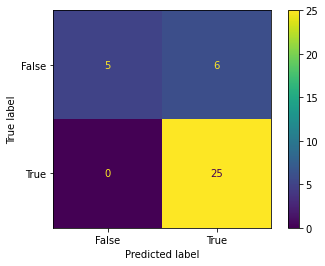

In [54]:
smiles_codes_val = model_wrapper.Data["smiles_codes_val"]
smiles_codes_train = model_wrapper.Data["smiles_codes_train"]
model_wrapper.Pipeline.fit(X=smiles_codes_train, y=None)
X_val = create_molecular_features(pipeline=model_wrapper.Pipeline, smiles_codes=smiles_codes_val)
X_val = process_molecular_features(pipeline=model_wrapper.Pipeline, X=X_val)
y_train_val_pred = model_wrapper.Predict(X_val)
y_train_val = model_wrapper.Data["targets_val"]
ConfusionMatrixDisplay.from_predictions(y_train_val, y_train_val_pred > configuration_train["threshold"])
l.info("Precision score on hold-out/external: %s", precision_score(y_train_val, y_train_val_pred > configuration_train["threshold"]))
l.info("Recall score on hold-out/external: %s", recall_score(y_train_val, y_train_val_pred > configuration_train["threshold"]))
l.info("ROCAUC score on hold-out/external: %s", roc_auc_score(y_train_val, y_train_val_pred > configuration_train["threshold"]))
l.info("Average precision score on hold-out/external: %s", average_precision_score(y_train_val, y_train_val_pred > configuration_train["threshold"]))
l.info("Accuracy precision score on hold-out/external: %s", accuracy_score(y_train_val, y_train_val_pred > configuration_train["threshold"]))